In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.autograd import Variable
from torch.utils.data import Dataset
import classification_models
from classification_models import GetLoader
import time
from datetime import datetime

In [2]:
#导入数据
factor_df=pd.read_csv("/data01/data_for_intern/factor_data_13_19.csv")
return_df=pd.read_csv("/data01/data_for_intern/return_data_13_19.csv")
return_label=return_df.drop(columns=['return_adj_d001','return_adj_d005','car_hs300_b30_d005'])
return_label['car_hs300_b30_d001']=(return_label['car_hs300_b30_d001']>=0)*1
#利用内连接方式合并数据
merged_factor_return = factor_df.merge(return_label,on=["stock_code","trade_date"],how="inner")

In [3]:
import lxml

In [5]:
import tushare as ts

In [27]:
hs = ts.get_hs300s()['code']
zz = ts.get_zz500s()['code']
hs_zz = pd.concat([hs,zz])

In [36]:
hs_zz.iloc[1]+'.SH'

'600004.SH'

In [38]:
hs_zz_name=[]
for i in range(hs_zz.shape[0]):
    hs_zz_name.append(hs_zz.iloc[i]+'.SH')
    hs_zz_name.append(hs_zz.iloc[i]+'.SZ')

In [39]:
index_df = merged_factor_return[merged_factor_return['stock_code'].isin (hs_zz_name)]

In [41]:
#筛选日期节点,以15个交易日为界
date=[]
import datetime
date.append("2013-01-07")
i=0
while(i>-1):
    now=datetime.datetime.strptime(date[i], "%Y-%m-%d")
    if date[i]=="2019-12-02":
        break
    delta=datetime.timedelta(days=28)
    n_days=now+delta
    date.append(n_days.strftime('%Y-%m-%d'))
    i=i+1

In [42]:
date_dict={}
for i in range(len(date)-1):
    #print(i)
    temp_list=[]
    temp_list.append(date[i])
    now=datetime.datetime.strptime(date[i], "%Y-%m-%d")
    while(1):
        delta=datetime.timedelta(days=1)
        #print('k')
        now=now+delta
        #print('l')
        if now.strftime('%Y-%m-%d') == date[i+1]:
            break
        #print('o')
        temp_list.append(now.strftime('%Y-%m-%d'))
        #print(now.strftime('%Y-%m-%d'))
    date_dict[str(i)] = temp_list

In [43]:
valid_date_dict={}
for i in range(1,len(date)):
    #print(i)
    temp_list=[]
    temp_list.append(date[i])
    now=datetime.datetime.strptime(date[i], "%Y-%m-%d")
    k = 0
    while(1):
        delta=datetime.timedelta(days=1)
        #print('k')
        now=now+delta
        #print('l')
        if k>=14:
            break
        #print('o')
        temp_list.append(now.strftime('%Y-%m-%d'))
        #print(now.strftime('%Y-%m-%d'))
        k=k+1
    valid_date_dict[str(i-1)] = temp_list

In [44]:
df_train_dict={}
for i in range(len(date_dict)):
    df_train_dict[str(i)] = index_df[index_df['trade_date'].isin (date_dict[str(i)])]

In [45]:
df_valid_dict={}
for i in range(len(valid_date_dict)):
    df_valid_dict[str(i)] = index_df[index_df['trade_date'].isin (valid_date_dict[str(i)])]

In [46]:
from datetime import datetime
import roll_data
from roll_data import unroll_data

In [47]:
from rolling_window import *

In [48]:
from classification_models import LSTM

In [49]:
def LSTM_rolling_window(df_train_dict, df_valid_dict):
    softmax = nn.Softmax(-1)
    result = {}
    for i in range(1, len(df_train_dict)):
        print("current i is",i)
        temp_df = df_train_dict[str(i)].set_index(['trade_date', 'stock_code'])
        train_index_list, train_data_list, train_label_list = unroll_data(temp_df, 100, 8, debug=False)

        temp_df = df_valid_dict[str(i)].set_index(['trade_date', 'stock_code'])        
        valid_index_list, valid_data_list, valid_label_list = unroll_data(temp_df, 100, 8, debug=False)    
        if len(valid_data_list) == 0:
            continue
        train_index_list, train_data_list, train_label_list = nan_dele(train_index_list, train_data_list, train_label_list)
        valid_index_list, valid_data_list, valid_label_list = nan_dele(valid_index_list, valid_data_list, valid_label_list)
        print(train_data_list.shape, valid_data_list.shape)
        sequence_length = 10  # 序列长度，将图像的每一列作为一个序列
        input_size = 42  # 输入数据的维度
        hidden_size = 64  # 隐藏层的size
        num_layers =  4 # 有多少层
        num_classes = 2
        batch_size = 256
        num_epochs = 200
        learning_rate = 0.001
        device = torch.device("cuda:1")
        
        train_loader, valid_loader = load_data(
            train_index_list, train_data_list, train_label_list,valid_index_list, valid_data_list, valid_label_list, batch_size)
        
        lstm = LSTM(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers, num_classes=num_classes,device=device)
        lstm.to(device)
        # Loss and Optimizer
        loss_function = nn.CrossEntropyLoss()
        optimizer = torch.optim.Adam(lstm.parameters(), lr=learning_rate)

        _, _, model = training(lstm, num_epochs, train_loader,valid_loader, loss_function, optimizer, device, softmax)
        
        for _, images, labels in valid_loader:
            num,valid_pre, predicted=predict_precision(model,images,labels,device,predict_type='validation',softmax=softmax)
        #num = softmax(num)
        print(num[0:100])
        result[str(i)] = valid_index_list, num, predicted, valid_label_list
    
    return result

current i is 1
Filter large gap...
Time: 3.400
Unrolling Data...
Time: 2.440 s
Filter large gap...
Time: 3.662
Unrolling Data...
Time: 2.527 s
(4274, 8, 42) (1838, 8, 42)
precision of the model on thetrainingdata: 69.23076629638672%
precision of the model on thevalidationdata: 47.14912414550781%
precision of the model on thetrainingdata: 91.93548583984375%
precision of the model on thevalidationdata: 45.71773147583008%
precision of the model on thetrainingdata: 90.2255630493164%
precision of the model on thevalidationdata: 47.25%


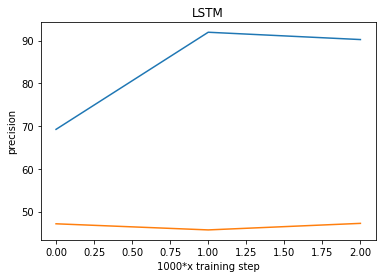

precision of the model on thevalidationdata: 46.26474380493164%
tensor([1.0000, 0.7909, 0.8044, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        0.9982, 0.5859, 0.5864, 1.0000, 1.0000, 1.0000, 0.9718, 0.9996, 1.0000,
        1.0000, 1.0000, 0.9980, 0.9189, 0.5768, 0.9998, 1.0000, 0.9993, 1.0000,
        0.9969, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 0.9159, 1.0000, 1.0000, 1.0000, 0.5884, 0.6444, 1.0000, 0.9798,
        1.0000, 1.0000, 0.9955, 0.9143, 0.5844, 0.5871, 0.9861, 1.0000, 0.9928,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 0.9814, 1.0000, 0.9999,
        1.0000, 1.0000, 1.0000, 0.8192, 0.8797, 0.9667, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 0.9495, 0.7420, 0.7763, 0.9999, 1.0000, 1.0000,
        1.0000, 0.9971, 0.8928, 1.0000, 1.0000, 1.0000, 0.9994, 1.0000, 0.7412,
        1.0000, 1.0000, 1.0000, 1.0000, 0.7381, 0.9600, 0.9877, 0.7262, 0.9692,
        0.9753], device='cuda:1')
current i is 2
Filter 

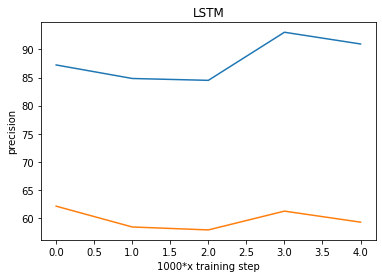

precision of the model on thevalidationdata: 59.8684196472168%
tensor([0.9999, 1.0000, 0.9699, 0.9668, 0.8339, 1.0000, 0.9999, 1.0000, 1.0000,
        0.9197, 0.9984, 0.9195, 0.9997, 0.9999, 1.0000, 0.6114, 1.0000, 1.0000,
        0.5099, 1.0000, 0.8627, 0.5826, 1.0000, 1.0000, 1.0000, 0.8461, 0.9978,
        1.0000, 0.6109, 1.0000, 1.0000, 1.0000, 0.6021, 0.8999, 1.0000, 1.0000,
        1.0000, 0.9200, 0.9996, 1.0000, 1.0000, 0.5343, 1.0000, 0.9893, 0.7931,
        1.0000, 0.9996, 0.9992, 1.0000, 0.8778, 1.0000, 0.5397, 0.6298, 0.9965,
        0.8306, 1.0000, 1.0000, 0.9982, 0.6660, 0.9995, 1.0000, 1.0000, 1.0000,
        0.9450, 1.0000, 0.7798, 1.0000, 0.9999, 0.9819, 0.9845, 0.5617, 1.0000,
        0.9998, 1.0000, 0.5872, 1.0000, 1.0000, 0.7634, 0.9388, 0.5650, 1.0000,
        0.9876, 0.5748, 0.9983, 1.0000, 0.5532, 1.0000, 0.9989, 1.0000, 1.0000,
        0.9981, 0.9978, 1.0000, 0.9998, 1.0000, 0.9997, 1.0000, 0.9526, 0.7886,
        1.0000], device='cuda:1')
current i is 3
Filter l

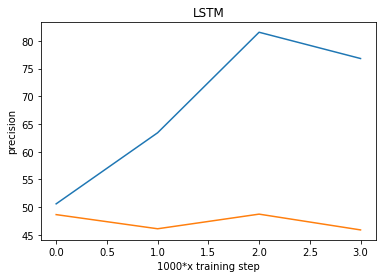

precision of the model on thevalidationdata: 47.11388397216797%
tensor([0.9610, 0.9986, 1.0000, 1.0000, 0.9594, 1.0000, 0.6297, 1.0000, 0.9995,
        0.6816, 0.5096, 0.9998, 0.9997, 0.5484, 0.5335, 0.9998, 0.7454, 0.5154,
        0.7329, 0.5591, 0.5917, 1.0000, 1.0000, 0.5556, 0.9139, 1.0000, 0.5569,
        0.5158, 0.6382, 1.0000, 0.9989, 0.6471, 0.9676, 1.0000, 1.0000, 0.9943,
        1.0000, 0.5298, 0.6335, 0.6605, 0.9978, 0.9655, 1.0000, 1.0000, 0.9994,
        0.5036, 0.5336, 1.0000, 1.0000, 1.0000, 0.9994, 0.9611, 1.0000, 0.9922,
        1.0000, 0.7031, 1.0000, 1.0000, 1.0000, 0.5692, 0.9893, 0.5123, 0.5118,
        1.0000, 1.0000, 1.0000, 1.0000, 0.5053, 0.5122, 1.0000, 1.0000, 1.0000,
        1.0000, 0.9863, 0.9999, 0.9990, 1.0000, 0.9999, 0.9847, 0.9928, 1.0000,
        0.9984, 1.0000, 0.6276, 0.9965, 0.7093, 0.9986, 1.0000, 1.0000, 0.9875,
        0.9998, 1.0000, 0.9831, 1.0000, 0.9998, 0.9997, 1.0000, 0.9999, 1.0000,
        0.9958], device='cuda:1')
current i is 5
Filter 

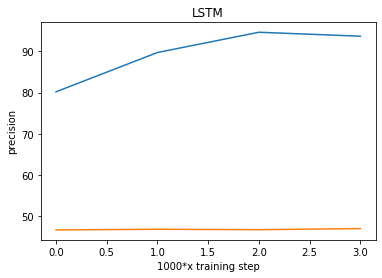

precision of the model on thevalidationdata: 47.72370529174805%
tensor([1.0000, 1.0000, 1.0000, 1.0000, 0.9966, 0.6164, 0.9526, 1.0000, 1.0000,
        0.5100, 0.9412, 1.0000, 1.0000, 0.9532, 0.9999, 0.9911, 0.7790, 0.9020,
        1.0000, 0.9990, 0.5203, 1.0000, 1.0000, 0.9917, 0.8550, 0.9743, 0.8597,
        1.0000, 1.0000, 0.8759, 0.8523, 0.9989, 0.5331, 0.8076, 1.0000, 1.0000,
        0.9729, 0.9979, 0.9999, 1.0000, 0.9989, 0.8963, 1.0000, 1.0000, 0.9992,
        0.9999, 0.9999, 0.9885, 0.5390, 0.6958, 0.7481, 1.0000, 1.0000, 0.9964,
        0.9973, 1.0000, 0.7996, 1.0000, 1.0000, 0.9998, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 0.9982, 1.0000, 1.0000, 1.0000, 0.9999, 0.5889, 0.9971,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 0.6230,
        0.6531, 0.9783, 0.9974, 0.9427, 0.9998, 1.0000, 0.9852, 0.9291, 0.8575,
        0.7706, 1.0000, 0.6363, 1.0000, 0.9758, 0.9999, 1.0000, 1.0000, 1.0000,
        1.0000], device='cuda:1')
current i is 6
Filter 

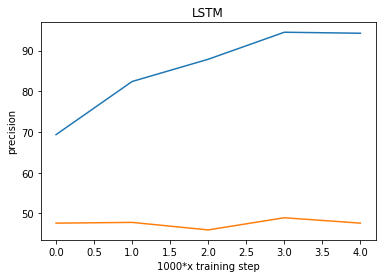

precision of the model on thevalidationdata: 50.0%
tensor([1.0000, 0.9999, 0.9999, 0.8939, 1.0000, 1.0000, 0.7769, 0.8955, 0.8641,
        1.0000, 1.0000, 0.7714, 1.0000, 0.9998, 0.9995, 0.9404, 1.0000, 1.0000,
        0.6447, 0.5812, 0.8022, 0.9998, 1.0000, 0.6597, 0.8180, 0.6514, 0.5976,
        1.0000, 1.0000, 0.9998, 1.0000, 0.6525, 0.5935, 0.9999, 0.9999, 0.9698,
        0.9676, 1.0000, 1.0000, 0.6198, 1.0000, 1.0000, 1.0000, 0.9996, 1.0000,
        0.9690, 0.9977, 1.0000, 0.9944, 0.6795, 0.6932, 0.5549, 1.0000, 0.9994,
        0.9975, 0.5783, 0.5180, 0.5890, 0.9856, 0.7897, 0.5958, 0.9988, 1.0000,
        0.5802, 1.0000, 0.9999, 0.9963, 0.7700, 0.9786, 0.5334, 0.9128, 1.0000,
        0.9978, 1.0000, 0.8880, 1.0000, 0.8367, 0.6356, 0.7470, 1.0000, 0.5849,
        0.6645, 1.0000, 0.6979, 1.0000, 1.0000, 1.0000, 1.0000, 0.9996, 1.0000,
        1.0000, 0.7836, 1.0000, 0.9989, 1.0000, 1.0000, 0.9923, 0.6672, 0.9225,
        0.5105], device='cuda:1')
current i is 7
Filter large gap...


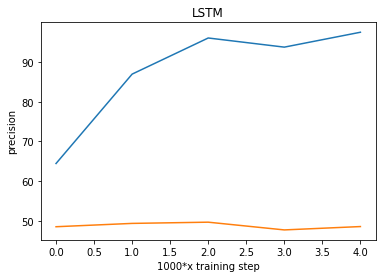

precision of the model on thevalidationdata: 49.5%
tensor([0.7164, 0.5423, 0.6342, 1.0000, 0.9997, 1.0000, 1.0000, 0.9997, 0.9952,
        0.9444, 1.0000, 1.0000, 0.6942, 1.0000, 1.0000, 0.9999, 0.9996, 0.9999,
        0.6238, 0.6388, 0.6232, 0.7571, 0.5894, 0.6812, 0.5146, 0.9604, 0.9662,
        0.9383, 0.8477, 0.9999, 1.0000, 0.9999, 0.9999, 0.9851, 0.8815, 1.0000,
        0.9965, 0.9973, 0.6232, 0.6346, 0.7502, 0.6453, 0.8420, 1.0000, 1.0000,
        0.8326, 0.9141, 1.0000, 0.5640, 0.6509, 0.8221, 0.5728, 0.9885, 1.0000,
        1.0000, 1.0000, 0.8452, 0.9999, 0.9984, 1.0000, 0.6234, 0.6244, 0.6239,
        0.6496, 0.6246, 0.6242, 0.7743, 1.0000, 1.0000, 0.6235, 0.6221, 0.8467,
        0.7409, 0.9372, 0.9980, 0.5746, 0.7111, 0.6241, 0.6347, 0.5783, 0.6253,
        0.6768, 0.9996, 0.5915, 0.6130, 1.0000, 0.9999, 0.8375, 0.9595, 0.9980,
        0.5817, 0.8076, 0.5463, 0.5234, 0.8651, 0.5093, 0.5754, 0.6030, 0.6659,
        0.6470], device='cuda:1')
current i is 8
Filter large gap...


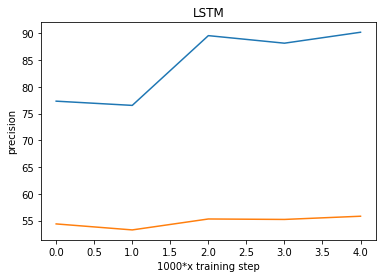

precision of the model on thevalidationdata: 55.07246398925781%
tensor([1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 0.8410,
        0.9999, 1.0000, 0.9960, 0.5116, 0.9962, 1.0000, 1.0000, 0.9858, 0.9974,
        0.9999, 0.9875, 1.0000, 0.7663, 1.0000, 1.0000, 1.0000, 0.9973, 1.0000,
        0.9997, 1.0000, 0.9999, 0.9997, 0.5455, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 0.9426, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 0.9994,
        0.7016, 0.9997, 0.5566, 1.0000, 1.0000, 1.0000, 0.9975, 1.0000, 1.0000,
        0.9622, 1.0000, 0.9974, 1.0000, 1.0000, 1.0000, 1.0000, 0.9904, 1.0000,
        1.0000, 0.8633, 0.9777, 0.7515, 1.0000, 0.9966, 0.8713, 1.0000, 1.0000,
        0.9987, 0.9913, 0.8978, 0.9989, 0.9992, 1.0000, 0.9346, 1.0000, 1.0000,
        1.0000, 0.9936, 0.5491, 1.0000, 1.0000, 0.8775, 0.9997, 1.0000, 1.0000,
        0.5432, 0.9989, 1.0000, 0.9996, 0.9951, 0.9995, 1.0000, 0.8491, 0.9984,
        1.0000], device='cuda:1')
current i is 9
Filter 

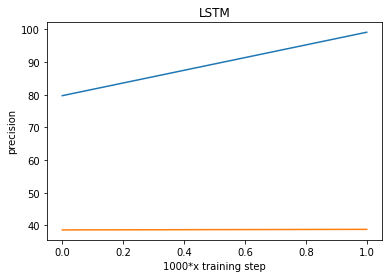

precision of the model on thevalidationdata: 39.10984802246094%
tensor([1.0000, 1.0000, 1.0000, 1.0000, 0.9999, 1.0000, 0.9995, 1.0000, 1.0000,
        0.9992, 0.9898, 0.5843, 0.9997, 1.0000, 1.0000, 0.5970, 0.9999, 1.0000,
        0.5864, 0.9998, 0.9469, 0.5392, 0.9330, 0.6057, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 0.8361, 0.9993, 0.9996, 1.0000, 0.6534, 0.8408, 1.0000,
        1.0000, 1.0000, 1.0000, 0.5241, 1.0000, 0.9998, 1.0000, 1.0000, 0.9803,
        0.8709, 1.0000, 1.0000, 1.0000, 1.0000, 0.9079, 1.0000, 0.5094, 0.5024,
        0.9996, 0.9993, 0.9992, 0.6140, 0.9748, 0.9952, 0.8673, 1.0000, 1.0000,
        0.9977, 1.0000, 0.9977, 1.0000, 0.9994, 1.0000, 0.9253, 0.9924, 0.9992,
        0.9614, 1.0000, 0.9968, 0.7823, 0.9966, 0.5287, 0.9731, 0.9902, 0.6480,
        0.5976, 0.9994, 1.0000, 1.0000, 0.9999, 1.0000, 0.9441, 0.9969, 0.9739,
        1.0000, 1.0000, 0.9999, 0.9994, 0.9982, 1.0000, 0.9973, 0.9965, 1.0000,
        0.9992], device='cuda:1')
current i is 10
Filter

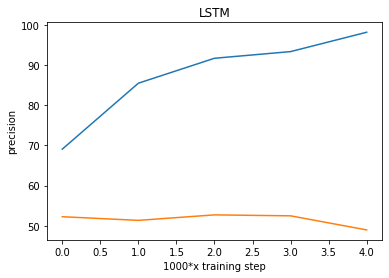

precision of the model on thevalidationdata: 50.68027114868164%
tensor([1.0000, 0.9862, 0.9999, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 0.8528,
        0.9745, 0.9978, 0.9985, 0.9906, 0.9981, 0.9992, 0.9999, 1.0000, 0.9994,
        0.9961, 0.8295, 0.5895, 1.0000, 1.0000, 1.0000, 0.9571, 0.9995, 1.0000,
        1.0000, 0.9951, 0.6482, 1.0000, 1.0000, 0.9990, 1.0000, 0.9501, 0.9880,
        0.9998, 1.0000, 1.0000, 0.9989, 1.0000, 1.0000, 0.9995, 0.9999, 1.0000,
        0.6469, 1.0000, 0.8965, 1.0000, 1.0000, 0.7129, 1.0000, 1.0000, 0.9689,
        0.9993, 0.9905, 0.9980, 0.9998, 1.0000, 1.0000, 0.8859, 0.5917, 0.5905,
        0.9939, 0.9961, 1.0000, 0.6232, 0.5822, 0.5917, 0.9904, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 0.9931, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 0.9995, 1.0000, 1.0000, 0.9998, 0.8130, 0.5175,
        1.0000, 0.9996, 1.0000, 1.0000, 1.0000, 1.0000, 0.5098, 0.5983, 0.5662,
        0.5031], device='cuda:1')
current i is 11
Filter

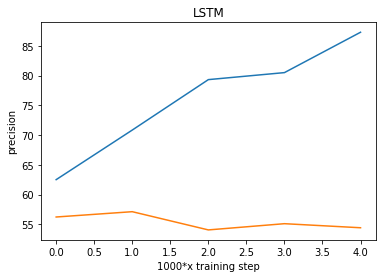

precision of the model on thevalidationdata: 53.631839752197266%
tensor([0.9999, 0.9895, 0.9971, 0.9999, 1.0000, 0.9998, 0.7912, 0.9968, 1.0000,
        1.0000, 0.9870, 1.0000, 0.9924, 1.0000, 0.8503, 0.7545, 0.5855, 0.8156,
        0.9940, 0.9998, 1.0000, 0.9993, 0.9570, 0.9996, 0.9936, 0.9783, 0.8783,
        0.8762, 1.0000, 0.9983, 0.8874, 0.9999, 1.0000, 0.9761, 0.9996, 0.9957,
        0.9952, 0.9993, 1.0000, 0.9993, 0.9989, 0.8426, 0.9970, 1.0000, 0.9999,
        1.0000, 1.0000, 1.0000, 0.9974, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        0.8926, 0.9898, 0.5682, 1.0000, 0.9994, 0.9966, 0.5003, 0.9962, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 0.9795, 0.8831, 0.9685, 0.5614,
        0.6017, 0.6496, 0.9999, 0.9825, 1.0000, 0.9658, 1.0000, 1.0000, 0.9807,
        1.0000, 0.9757, 1.0000, 1.0000, 1.0000, 0.9942, 0.9994, 1.0000, 1.0000,
        0.8464, 0.9998, 1.0000, 0.9998, 1.0000, 0.9992, 0.9326, 1.0000, 0.9999,
        1.0000], device='cuda:1')
current i is 12
Filte

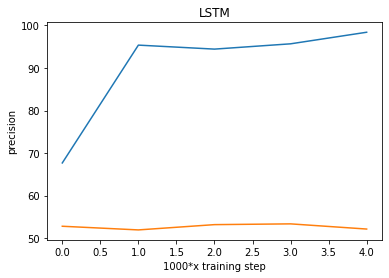

precision of the model on thevalidationdata: 52.024539947509766%
tensor([1.0000, 0.9824, 1.0000, 0.9982, 1.0000, 1.0000, 0.9995, 0.9496, 0.9926,
        0.9843, 0.9999, 1.0000, 0.9998, 0.9967, 1.0000, 0.5270, 0.5462, 0.5460,
        1.0000, 0.9983, 0.9795, 1.0000, 1.0000, 1.0000, 0.5115, 1.0000, 0.9998,
        0.7741, 0.9090, 1.0000, 1.0000, 0.9815, 0.9653, 0.9760, 1.0000, 1.0000,
        0.9801, 0.5095, 0.5094, 0.9198, 1.0000, 1.0000, 0.9942, 1.0000, 0.9938,
        1.0000, 1.0000, 1.0000, 0.5765, 0.6573, 0.8728, 0.9596, 0.9999, 1.0000,
        1.0000, 1.0000, 0.8449, 0.9954, 1.0000, 0.9395, 1.0000, 1.0000, 0.9925,
        0.9961, 0.9998, 0.8314, 1.0000, 0.8589, 0.5519, 0.9075, 0.9999, 1.0000,
        0.9997, 1.0000, 0.9772, 1.0000, 0.9945, 1.0000, 1.0000, 1.0000, 0.9999,
        0.6832, 0.6330, 0.7035, 0.7982, 1.0000, 0.9974, 1.0000, 0.9999, 1.0000,
        0.9630, 0.9999, 0.9723, 0.9999, 0.9994, 1.0000, 1.0000, 0.9556, 1.0000,
        1.0000], device='cuda:1')
current i is 13
Filte

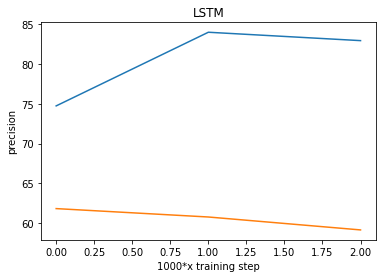

precision of the model on thevalidationdata: 59.94550323486328%
tensor([1.0000, 1.0000, 1.0000, 0.9985, 0.9997, 0.5179, 0.9868, 0.7905, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 0.9999, 0.9879, 1.0000, 1.0000, 0.9840,
        0.9981, 0.9577, 0.9623, 0.8775, 0.5887, 0.7657, 0.9575, 0.9999, 0.9554,
        0.9999, 0.9973, 1.0000, 0.9997, 0.9993, 1.0000, 0.9961, 0.9976, 0.5239,
        1.0000, 0.9993, 1.0000, 0.9325, 0.5713, 0.7198, 1.0000, 0.6113, 1.0000,
        1.0000, 0.6980, 1.0000, 0.9375, 0.9453, 1.0000, 0.9993, 0.9990, 1.0000,
        1.0000, 1.0000, 0.9411, 0.6253, 0.6044, 0.8615, 0.9984, 0.9735, 1.0000,
        1.0000, 0.9980, 1.0000, 1.0000, 1.0000, 0.9999, 1.0000, 1.0000, 0.9214,
        0.9684, 1.0000, 1.0000, 1.0000, 0.9994, 0.9999, 1.0000, 1.0000, 0.9999,
        0.9998, 0.9975, 1.0000, 1.0000, 1.0000, 0.9842, 1.0000, 1.0000, 1.0000,
        1.0000, 0.9998, 1.0000, 0.9999, 1.0000, 1.0000, 1.0000, 0.9845, 1.0000,
        0.9961], device='cuda:1')
current i is 15
Filter

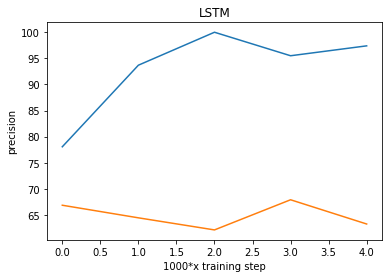

precision of the model on thevalidationdata: 66.66666412353516%
tensor([0.9902, 0.9894, 0.9975, 0.9998, 0.9985, 0.9449, 0.9608, 0.9779, 0.5405,
        0.5139, 0.8706, 0.9893, 0.5090, 0.9915, 1.0000, 1.0000, 0.5398, 0.5142,
        0.5377, 0.5029, 0.9982, 0.8895, 0.5316, 0.5317, 0.5321, 0.5318, 0.5314,
        0.5009, 0.5699, 0.9957, 0.9954, 0.9272, 0.5357, 0.9861, 0.9732, 0.6935,
        0.5293, 0.9541, 0.5204, 0.8841, 0.6834, 0.6296, 0.5280, 0.7136, 0.6757,
        0.9996, 0.9999, 0.5316, 0.5316, 0.5440, 0.5316, 1.0000, 0.9376, 0.8881,
        0.5529, 0.5171, 0.5923, 0.9231, 0.7505, 0.5862, 0.5096, 0.5317, 0.5028,
        0.5532, 0.5015, 1.0000, 0.9998, 0.9999, 0.9999, 0.5316, 0.5310, 0.5825,
        0.5521, 1.0000, 0.9901, 0.9991, 0.5041, 0.6513, 0.9590, 0.9531, 0.5316,
        1.0000, 0.8326, 0.5316, 0.5316, 0.6582, 0.8312, 0.9988, 0.9831, 1.0000,
        1.0000, 0.8440, 0.9997, 0.5430, 0.5072, 0.8356, 0.6863, 0.7110, 0.8249,
        0.5318], device='cuda:1')
current i is 16
Filter

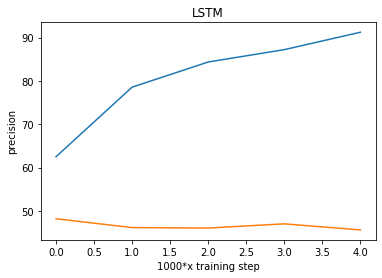

precision of the model on thevalidationdata: 45.588233947753906%
tensor([0.9999, 0.9998, 0.8735, 1.0000, 1.0000, 0.8836, 0.6583, 0.9998, 0.9994,
        0.9996, 1.0000, 0.9999, 0.9997, 0.9298, 0.9995, 1.0000, 1.0000, 0.9999,
        1.0000, 0.9992, 0.9653, 0.5193, 0.8385, 0.9906, 0.7244, 0.6421, 1.0000,
        0.9779, 0.9388, 0.9986, 1.0000, 0.9998, 1.0000, 0.9995, 1.0000, 1.0000,
        1.0000, 1.0000, 0.9969, 0.8219, 1.0000, 0.6574, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 0.9966, 1.0000, 0.9999, 1.0000, 1.0000, 1.0000,
        1.0000, 0.9998, 0.9999, 1.0000, 1.0000, 1.0000, 1.0000, 0.7032, 1.0000,
        1.0000, 0.6025, 0.5937, 1.0000, 1.0000, 1.0000, 0.7910, 1.0000, 1.0000,
        0.9235, 0.5835, 0.5945, 0.9999, 0.9968, 0.9888, 0.7009, 1.0000, 1.0000,
        0.9998, 1.0000, 1.0000, 1.0000, 0.8899, 0.9998, 0.9896, 1.0000, 0.9929,
        0.6693, 0.9997, 1.0000, 0.9349, 1.0000, 0.9990, 1.0000, 1.0000, 1.0000,
        0.9998], device='cuda:1')
current i is 17
Filte

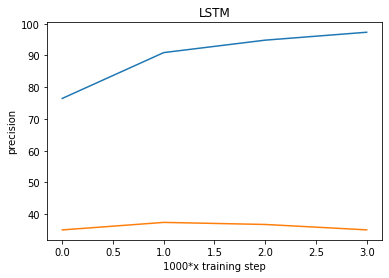

precision of the model on thevalidationdata: 37.728939056396484%
tensor([0.5205, 0.9498, 1.0000, 1.0000, 0.9995, 1.0000, 0.9624, 0.9840, 0.5688,
        0.5185, 0.9744, 1.0000, 0.7591, 0.9998, 0.6820, 0.7365, 1.0000, 1.0000,
        0.8981, 0.9991, 0.8308, 0.9454, 1.0000, 0.8221, 0.9981, 1.0000, 0.9965,
        0.9805, 0.9996, 0.9964, 0.6053, 0.6483, 0.5316, 0.6323, 0.5534, 0.5523,
        1.0000, 1.0000, 0.5923, 0.9973, 1.0000, 0.9979, 0.5591, 0.6292, 0.5441,
        0.9823, 0.9986, 1.0000, 1.0000, 1.0000, 0.7042, 0.5980, 0.9998, 0.8606,
        0.5060, 0.6658, 0.9955, 0.9640, 0.6656, 0.9168, 0.9999, 1.0000, 1.0000,
        0.9812, 1.0000, 1.0000, 0.5298, 0.5298, 0.6974, 0.9689, 1.0000, 0.7150,
        0.9989, 1.0000, 1.0000, 1.0000, 0.6478, 0.9496, 0.9999, 1.0000, 0.6985,
        0.5295, 0.9995, 0.6055, 0.9996, 0.7792, 0.6782, 0.5686, 0.9998, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 0.9988, 1.0000, 0.5496, 0.7798, 0.9996,
        0.9508], device='cuda:1')
current i is 18
Filte

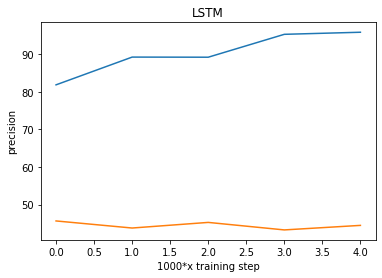

precision of the model on thevalidationdata: 44.481605529785156%
tensor([0.9991, 0.9796, 0.9973, 1.0000, 1.0000, 0.5010, 1.0000, 0.9996, 0.5626,
        0.9693, 0.9989, 0.9907, 1.0000, 0.9999, 0.8865, 1.0000, 0.9614, 0.9988,
        0.5941, 0.5013, 0.6917, 0.9991, 0.6408, 0.9855, 0.7301, 1.0000, 0.9957,
        0.9999, 0.5055, 0.5195, 1.0000, 1.0000, 1.0000, 0.6923, 0.6700, 0.5618,
        1.0000, 0.9978, 0.9998, 0.6623, 0.5788, 0.9797, 1.0000, 0.7814, 0.8441,
        0.8824, 0.7450, 0.9990, 1.0000, 0.9988, 0.9665, 0.9552, 1.0000, 0.8348,
        0.8292, 1.0000, 1.0000, 1.0000, 0.5817, 0.6326, 0.7335, 0.5581, 0.5465,
        1.0000, 0.8332, 1.0000, 0.5668, 0.9797, 0.9999, 0.9966, 0.5290, 0.9988,
        0.5278, 0.5846, 0.5077, 1.0000, 0.9990, 0.7951, 0.6131, 0.5043, 0.5057,
        0.5755, 0.6245, 0.5678, 1.0000, 0.9999, 0.6859, 1.0000, 1.0000, 0.9583,
        0.9984, 0.9999, 0.9998, 0.9987, 0.9784, 0.9999, 0.9997, 0.9409, 1.0000,
        0.5224], device='cuda:1')
current i is 19
Filte

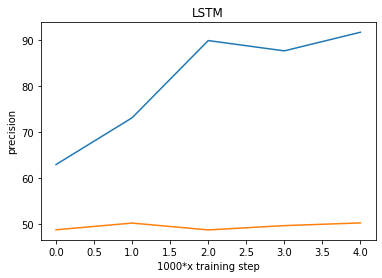

precision of the model on thevalidationdata: 48.75%
tensor([0.7973, 0.5072, 0.9239, 1.0000, 1.0000, 1.0000, 0.5240, 0.5072, 0.5106,
        0.9998, 0.9995, 0.9992, 0.8541, 0.5131, 0.5342, 0.8890, 0.5077, 0.5071,
        0.5144, 0.5135, 0.5220, 0.5957, 0.7405, 0.9999, 0.5072, 0.5072, 0.5072,
        0.9997, 0.9728, 0.8556, 0.6561, 0.6144, 0.9996, 1.0000, 0.5072, 0.5072,
        1.0000, 1.0000, 0.9165, 0.6937, 0.5441, 0.5472, 0.6312, 0.6151, 0.6128,
        0.5072, 0.5072, 0.5072, 0.7258, 0.5072, 0.5072, 0.5086, 0.5082, 0.5075,
        1.0000, 0.9935, 0.5362, 1.0000, 1.0000, 0.5208, 0.5072, 0.5072, 0.5072,
        0.5072, 0.5072, 0.5002, 0.5201, 0.5073, 0.5072, 0.5072, 0.5072, 0.5238,
        0.5076, 0.5076, 0.5263, 0.5074, 0.5072, 0.5072, 0.6423, 0.9210, 0.8995,
        0.9783, 1.0000, 0.9405, 1.0000, 0.9998, 0.9998, 0.5293, 0.5174, 0.5072,
        0.5072, 0.5022, 1.0000, 1.0000, 1.0000, 0.5083, 0.5073, 0.5041, 0.5072,
        0.5129], device='cuda:1')
current i is 20
Filter large gap..

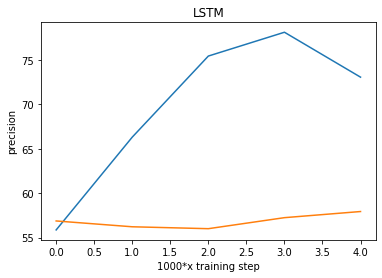

precision of the model on thevalidationdata: 57.0512809753418%
tensor([0.9999, 0.9996, 0.5707, 1.0000, 1.0000, 0.9999, 1.0000, 1.0000, 0.9241,
        0.9999, 0.9997, 0.8975, 0.9879, 1.0000, 0.9969, 1.0000, 0.9988, 0.9971,
        0.5680, 1.0000, 0.9873, 1.0000, 1.0000, 0.7591, 1.0000, 0.9234, 0.9971,
        0.7743, 1.0000, 0.9995, 1.0000, 0.9924, 1.0000, 1.0000, 0.9974, 1.0000,
        1.0000, 1.0000, 0.9999, 1.0000, 1.0000, 0.9879, 0.9975, 0.9804, 1.0000,
        0.9009, 1.0000, 1.0000, 0.8222, 0.9542, 0.9731, 1.0000, 1.0000, 0.5472,
        0.6968, 0.5172, 1.0000, 1.0000, 0.7507, 1.0000, 1.0000, 0.9919, 1.0000,
        1.0000, 0.9991, 0.6440, 0.9999, 1.0000, 1.0000, 0.9989, 1.0000, 1.0000,
        1.0000, 0.9939, 1.0000, 1.0000, 1.0000, 0.5838, 0.9995, 0.9998, 1.0000,
        0.9646, 1.0000, 0.6126, 0.5725, 0.5044, 0.7222, 0.9341, 0.9963, 0.9998,
        0.5385, 1.0000, 0.9999, 0.9867, 1.0000, 0.6423, 1.0000, 1.0000, 0.9979,
        1.0000], device='cuda:1')
current i is 21
Filter 

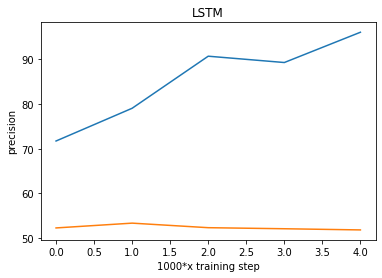

precision of the model on thevalidationdata: 53.149169921875%
tensor([0.8375, 1.0000, 1.0000, 0.5204, 0.5546, 0.7109, 1.0000, 1.0000, 1.0000,
        0.9998, 0.9988, 0.5154, 0.9998, 1.0000, 0.9998, 0.6482, 0.5662, 0.9997,
        0.9502, 0.9767, 0.6898, 1.0000, 0.9852, 1.0000, 0.9989, 0.8825, 0.9759,
        1.0000, 0.9356, 0.7069, 0.8666, 0.9997, 0.9999, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 0.7418, 0.8785, 0.5576, 0.7619, 1.0000, 1.0000,
        0.9999, 0.9960, 0.5837, 0.5424, 1.0000, 0.8537, 0.9780, 0.8599, 0.6415,
        0.6657, 0.5615, 0.6194, 1.0000, 0.6109, 1.0000, 0.9998, 0.9999, 1.0000,
        0.9882, 1.0000, 0.9365, 0.9592, 0.7016, 0.8689, 1.0000, 1.0000, 1.0000,
        0.6078, 1.0000, 1.0000, 1.0000, 1.0000, 0.9823, 0.9997, 0.9936, 0.9994,
        1.0000, 0.9414, 1.0000, 0.6179, 0.5866, 0.7371, 0.6390, 0.7853, 0.6314,
        0.7200, 1.0000, 0.5591, 0.9997, 1.0000, 1.0000, 1.0000, 1.0000, 0.7415,
        0.5325], device='cuda:1')
current i is 22
Filter l

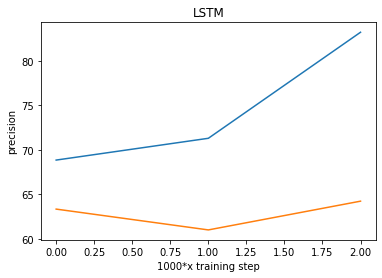

precision of the model on thevalidationdata: 63.74845886230469%
tensor([0.8927, 0.9812, 0.6753, 1.0000, 1.0000, 1.0000, 1.0000, 0.9629, 0.9999,
        0.9990, 0.9760, 0.9990, 0.9994, 0.5739, 0.7943, 0.9645, 1.0000, 1.0000,
        1.0000, 0.9999, 0.9997, 0.9943, 1.0000, 1.0000, 1.0000, 0.7779, 0.9999,
        0.6958, 0.9999, 0.9995, 1.0000, 1.0000, 1.0000, 0.9916, 0.9764, 1.0000,
        0.9946, 0.9995, 0.9992, 0.6072, 0.9999, 1.0000, 0.9999, 1.0000, 1.0000,
        1.0000, 0.9256, 0.9837, 1.0000, 0.9995, 1.0000, 0.9976, 0.5525, 1.0000,
        1.0000, 0.9952, 1.0000, 1.0000, 0.9908, 1.0000, 0.6069, 1.0000, 1.0000,
        1.0000, 0.9179, 0.9989, 0.9999, 1.0000, 0.9981, 1.0000, 1.0000, 0.9896,
        0.5453, 0.9453, 0.9999, 0.9996, 0.8106, 0.9868, 0.9631, 0.9930, 0.8528,
        0.9795, 0.9258, 1.0000, 1.0000, 1.0000, 0.9834, 1.0000, 0.9290, 0.9999,
        0.9379, 1.0000, 1.0000, 0.9977, 1.0000, 1.0000, 1.0000, 0.9999, 0.9994,
        1.0000], device='cuda:1')
current i is 23
Filter

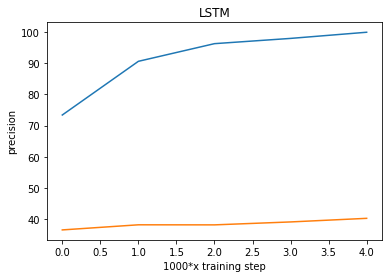

precision of the model on thevalidationdata: 39.149559020996094%
tensor([1.0000, 1.0000, 0.8356, 0.8671, 0.9998, 0.9963, 0.9716, 0.9985, 0.8421,
        0.8064, 0.9994, 1.0000, 0.7464, 0.9995, 0.5758, 0.6609, 0.5313, 0.6603,
        0.9219, 0.9998, 0.8796, 0.9983, 0.9787, 0.9175, 0.6013, 1.0000, 1.0000,
        1.0000, 1.0000, 0.9997, 0.9992, 0.9859, 0.9999, 0.5831, 0.5837, 0.5818,
        1.0000, 0.9919, 1.0000, 0.9919, 0.9996, 0.9999, 0.7106, 0.9994, 0.9797,
        1.0000, 1.0000, 1.0000, 0.9727, 0.9995, 0.6502, 1.0000, 1.0000, 0.9997,
        0.6355, 0.8278, 0.9677, 1.0000, 1.0000, 0.9914, 0.9858, 1.0000, 0.9999,
        1.0000, 0.9994, 0.6156, 1.0000, 0.9885, 1.0000, 0.9998, 1.0000, 1.0000,
        0.9748, 1.0000, 0.9848, 0.7114, 0.9997, 0.9986, 0.6411, 0.9998, 0.9895,
        0.9999, 0.9997, 0.7778, 0.9784, 0.9421, 0.9985, 1.0000, 0.9950, 0.6241,
        0.6236, 0.9999, 0.6993, 0.9693, 0.7380, 0.6150, 0.9932, 0.5264, 0.9662,
        1.0000], device='cuda:1')
current i is 24
Filte

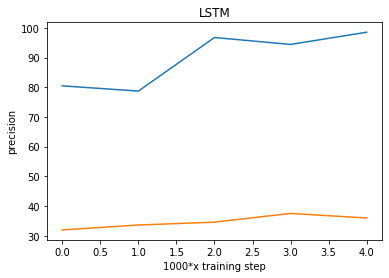

precision of the model on thevalidationdata: 36.57243728637695%
tensor([1.0000, 1.0000, 0.9991, 1.0000, 0.9999, 1.0000, 1.0000, 0.5836, 0.6286,
        0.9308, 0.9965, 0.5751, 0.9126, 1.0000, 1.0000, 0.9997, 0.9992, 0.9998,
        1.0000, 1.0000, 0.9992, 0.9724, 0.9993, 0.8773, 0.9863, 0.5702, 0.9940,
        0.9893, 0.5250, 0.9971, 0.9999, 1.0000, 0.5062, 0.7427, 0.8086, 0.7326,
        0.5928, 0.9991, 1.0000, 0.9475, 0.9992, 0.6800, 0.7608, 1.0000, 1.0000,
        1.0000, 1.0000, 0.9910, 0.8742, 1.0000, 1.0000, 1.0000, 1.0000, 0.9992,
        0.5014, 0.7644, 0.9988, 0.6888, 0.7166, 0.5222, 0.8942, 0.9977, 1.0000,
        0.9998, 0.7222, 0.7071, 0.6856, 0.5728, 0.6653, 0.6806, 1.0000, 1.0000,
        0.9202, 0.9946, 0.9383, 0.9979, 0.6810, 0.5111, 0.7113, 0.7132, 0.6030,
        0.7165, 0.9968, 0.9892, 0.9914, 0.5759, 0.8466, 1.0000, 1.0000, 0.9985,
        0.8735, 0.9992, 0.8583, 0.9999, 1.0000, 0.9203, 0.8255, 0.6470, 0.5168,
        0.5651], device='cuda:1')
current i is 25
Filter

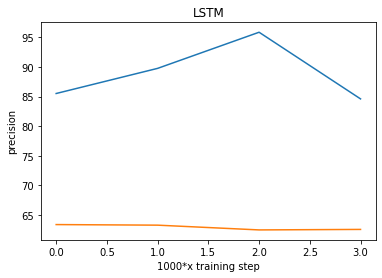

precision of the model on thevalidationdata: 62.22222137451172%
tensor([0.9954, 1.0000, 0.9987, 1.0000, 1.0000, 1.0000, 1.0000, 0.9220, 0.7499,
        0.6644, 0.5773, 1.0000, 1.0000, 0.5226, 0.5360, 0.5461, 0.8105, 0.8588,
        1.0000, 1.0000, 0.9282, 0.9999, 0.7433, 0.9525, 0.9099, 0.5734, 0.5083,
        0.5100, 1.0000, 1.0000, 0.9997, 0.9322, 0.9982, 0.6964, 0.9982, 0.9150,
        1.0000, 0.9998, 1.0000, 1.0000, 0.7472, 1.0000, 0.9730, 0.7960, 0.5259,
        0.5442, 0.5008, 0.9866, 0.9609, 0.9990, 0.7480, 0.9996, 0.9887, 1.0000,
        1.0000, 1.0000, 0.5609, 0.5163, 0.6383, 0.9994, 1.0000, 0.9999, 0.9999,
        1.0000, 0.9999, 1.0000, 0.9986, 0.9993, 1.0000, 0.9998, 1.0000, 1.0000,
        0.9991, 1.0000, 1.0000, 1.0000, 1.0000, 0.9968, 0.9997, 0.9999, 0.5293,
        0.5267, 0.5023, 1.0000, 0.9998, 1.0000, 0.9987, 1.0000, 0.9861, 0.8337,
        0.8648, 1.0000, 1.0000, 1.0000, 1.0000, 0.7293, 0.9075, 0.9993, 0.7177,
        0.5294], device='cuda:1')
current i is 26
Filter

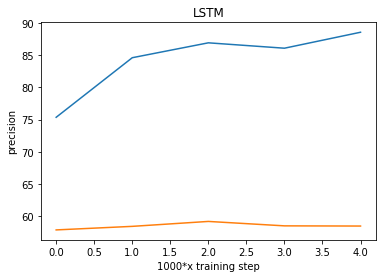

precision of the model on thevalidationdata: 58.40707778930664%
tensor([1.0000, 0.9999, 1.0000, 1.0000, 1.0000, 0.9999, 0.9999, 1.0000, 0.9982,
        1.0000, 1.0000, 1.0000, 0.9938, 0.9884, 1.0000, 1.0000, 1.0000, 0.9999,
        0.9989, 0.9622, 0.9951, 1.0000, 0.9833, 1.0000, 1.0000, 1.0000, 0.9576,
        1.0000, 1.0000, 0.9982, 0.7434, 1.0000, 0.9998, 0.5051, 0.9861, 1.0000,
        1.0000, 0.9834, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 0.5771, 0.5140,
        0.5055, 1.0000, 1.0000, 0.6895, 1.0000, 1.0000, 0.9650, 1.0000, 1.0000,
        1.0000, 0.5785, 1.0000, 1.0000, 0.9998, 0.9981, 1.0000, 1.0000, 0.9351,
        1.0000, 1.0000, 0.9999, 0.9999, 1.0000, 1.0000, 0.5841, 0.9119, 0.8555,
        0.6546, 1.0000, 0.6936, 0.9858, 0.9999, 0.9937, 1.0000, 0.9997, 1.0000,
        0.7459, 1.0000, 0.9988, 1.0000, 0.6233, 1.0000, 0.9999, 1.0000, 1.0000,
        0.5965, 1.0000, 0.9965, 1.0000, 1.0000, 1.0000, 0.9999, 0.9403, 1.0000,
        1.0000], device='cuda:1')
current i is 27
Filter

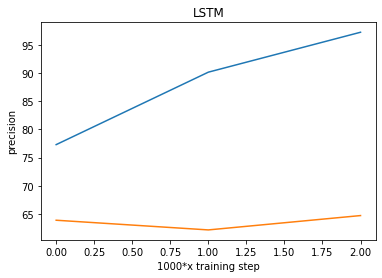

precision of the model on thevalidationdata: 63.52357482910156%
tensor([1.0000, 0.9818, 1.0000, 1.0000, 0.9169, 0.9998, 0.5507, 0.8070, 0.5920,
        0.6863, 0.5175, 0.9355, 0.7451, 0.7858, 0.9751, 0.9433, 0.8052, 0.8921,
        0.8200, 0.5132, 0.5161, 0.5393, 0.5949, 0.9135, 0.9098, 1.0000, 1.0000,
        1.0000, 0.6400, 0.6627, 0.5959, 0.9997, 0.9900, 0.9978, 0.9960, 0.8632,
        0.9977, 0.5816, 0.7619, 0.6811, 0.9998, 0.7828, 0.9991, 0.5058, 0.8679,
        0.9733, 0.9994, 1.0000, 0.5537, 0.9363, 0.6588, 0.8577, 0.9935, 0.5314,
        0.6107, 0.8810, 0.5412, 0.7795, 0.6915, 0.5486, 0.5776, 0.9826, 0.6582,
        0.9994, 1.0000, 1.0000, 0.6634, 0.6239, 0.5475, 0.7362, 0.6508, 0.6333,
        0.9983, 0.8731, 0.9997, 0.9763, 0.6956, 0.7256, 0.9846, 0.5704, 0.5853,
        0.9999, 0.9997, 0.9996, 0.9991, 0.9962, 0.9991, 0.5534, 0.9168, 0.8657,
        0.8832, 0.8183, 0.8210, 0.6191, 0.5689, 0.5350, 0.9999, 0.9784, 0.9998,
        0.6178], device='cuda:1')
current i is 28
Filter

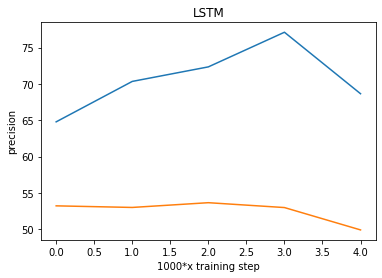

precision of the model on thevalidationdata: 52.82555389404297%
tensor([0.5881, 0.5945, 0.9989, 0.9985, 0.5081, 0.5855, 0.6972, 1.0000, 0.9992,
        1.0000, 0.5547, 0.5750, 0.5437, 0.5723, 0.6506, 0.8667, 0.8065, 1.0000,
        1.0000, 1.0000, 0.6599, 0.9720, 0.5999, 0.5145, 0.5029, 0.6142, 1.0000,
        0.9998, 0.5935, 0.5954, 0.5907, 0.6035, 0.6055, 0.6015, 0.5166, 1.0000,
        1.0000, 1.0000, 0.9999, 0.9833, 0.9476, 0.5711, 0.6266, 0.5009, 0.5325,
        0.9745, 0.7487, 0.6366, 0.7291, 0.6433, 0.5889, 0.5369, 0.9994, 0.9976,
        0.5201, 0.5292, 0.6874, 0.6288, 0.5891, 0.5735, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 0.6461, 0.6388, 0.5181, 0.5820, 0.9985, 1.0000,
        0.5138, 0.5547, 0.6037, 0.5772, 1.0000, 1.0000, 0.9036, 0.6541, 0.9999,
        1.0000, 0.8213, 0.8279, 0.9203, 0.8193, 0.5741, 0.5888, 0.9956, 0.9961,
        0.7317, 0.9879, 0.9767, 0.9972, 0.6250, 0.7182, 0.9977, 0.9998, 1.0000,
        1.0000], device='cuda:1')
current i is 29
Filter

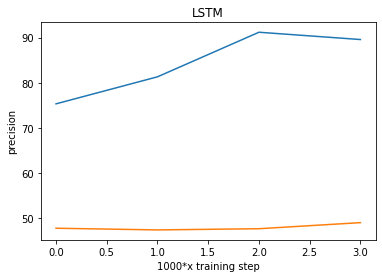

precision of the model on thevalidationdata: 48.71794891357422%
tensor([1.0000, 1.0000, 0.8428, 0.6782, 0.9610, 1.0000, 1.0000, 0.9366, 1.0000,
        0.9999, 0.9999, 0.7188, 0.9997, 1.0000, 0.9982, 0.9684, 1.0000, 0.9997,
        1.0000, 1.0000, 1.0000, 1.0000, 0.8076, 0.9993, 1.0000, 1.0000, 0.9998,
        1.0000, 0.9999, 0.9932, 0.9990, 1.0000, 0.9686, 0.9874, 0.8061, 1.0000,
        0.7061, 1.0000, 0.9939, 0.6068, 0.9962, 0.7601, 0.9918, 1.0000, 0.7883,
        1.0000, 1.0000, 1.0000, 0.6023, 1.0000, 0.9171, 0.8702, 0.9827, 0.8087,
        1.0000, 1.0000, 1.0000, 1.0000, 0.9952, 1.0000, 0.9535, 0.6389, 0.5543,
        0.9878, 1.0000, 1.0000, 1.0000, 0.9727, 1.0000, 1.0000, 0.9995, 0.9818,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 0.5306, 0.9158, 1.0000,
        0.9844, 1.0000, 0.9942, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        0.7511, 1.0000, 1.0000, 1.0000, 0.8907, 1.0000, 1.0000, 0.9899, 1.0000,
        1.0000], device='cuda:1')
current i is 30
Filter

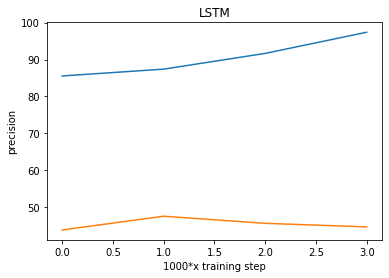

precision of the model on thevalidationdata: 43.614131927490234%
tensor([0.9953, 1.0000, 0.9991, 0.9998, 0.8654, 1.0000, 0.9997, 0.9637, 1.0000,
        0.9225, 0.9883, 0.9899, 0.9553, 1.0000, 0.9910, 0.9475, 0.9713, 0.9999,
        0.9999, 1.0000, 0.9997, 0.9986, 1.0000, 0.9996, 0.5658, 0.5406, 1.0000,
        0.8686, 0.9226, 1.0000, 0.9336, 0.5390, 0.5493, 0.7982, 0.9997, 0.9997,
        0.9921, 0.9988, 0.9774, 1.0000, 0.9161, 1.0000, 0.9625, 0.7232, 0.9278,
        0.9879, 0.5035, 0.8120, 0.9990, 1.0000, 0.9915, 0.9875, 0.8948, 0.8889,
        0.9962, 0.9789, 0.9977, 0.5632, 0.5632, 0.5632, 0.9557, 0.9999, 1.0000,
        0.9990, 0.9944, 0.9990, 0.6942, 0.9029, 0.5540, 0.9997, 0.9946, 0.9558,
        0.9085, 0.6857, 0.6384, 0.9684, 0.8824, 0.8318, 0.8708, 0.9940, 1.0000,
        0.9987, 0.9999, 0.9997, 1.0000, 1.0000, 1.0000, 0.5632, 0.5632, 0.5632,
        0.6167, 0.9994, 0.9666, 0.5632, 0.5632, 0.5632, 1.0000, 1.0000, 0.9993,
        1.0000], device='cuda:1')
current i is 31
Filte

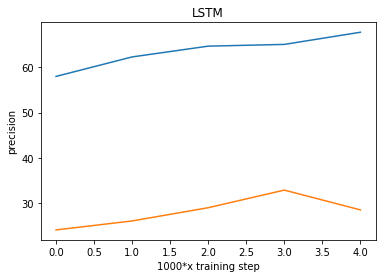

precision of the model on thevalidationdata: 27.272727966308594%
tensor([0.9848, 0.9929, 0.7970, 0.9860, 0.9493, 0.9836, 0.9793, 0.9918, 0.9964,
        0.9956, 0.9999, 0.9978, 0.9971, 0.9973, 0.9893, 0.9985, 0.9997, 0.9977,
        0.9932, 0.9973, 0.9953, 0.9930, 0.9234, 0.9852, 0.7094, 0.9113, 0.8486,
        0.9849, 0.9999, 0.9770, 0.9982, 0.5815, 0.9999, 0.9997, 0.9987, 0.9998,
        0.9993, 0.5261, 0.9992, 0.9723, 0.9958, 0.9452, 0.9880, 0.9571, 0.9626,
        0.9996, 0.9977, 0.9999, 0.9999, 0.8893, 0.8127, 0.9988, 0.9995, 0.9587,
        0.9668, 0.5755, 0.9998, 0.9624, 0.8186, 0.9863, 0.9243, 0.9988, 0.9999,
        0.9995, 0.7507, 0.9984, 0.9992, 0.9975, 0.5538, 0.9944, 0.9999, 0.9997,
        0.7350, 0.9698, 0.5689, 0.9992, 0.9960, 0.9998, 0.9986, 0.9906, 0.9989,
        0.7979, 0.9185, 0.9991, 0.9883, 0.9980, 0.9260, 0.9997, 0.9968, 0.9967,
        0.9995, 0.9871, 0.9946, 0.9943, 0.5792, 0.9734, 0.9990, 0.9922, 0.8104,
        1.0000], device='cuda:1')
current i is 32
Filte

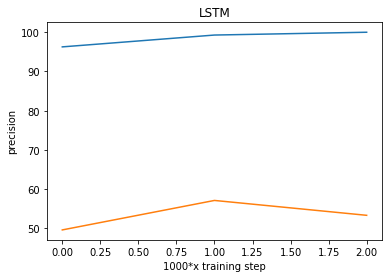

precision of the model on thevalidationdata: 55.48387145996094%
tensor([1.0000, 0.9991, 1.0000, 1.0000, 1.0000, 1.0000, 0.7952, 0.9582, 0.9879,
        0.9998, 0.9996, 0.7421, 0.7389, 0.7349, 0.7900, 0.8164, 0.5216, 0.7385,
        0.9772, 1.0000, 0.7187, 0.7401, 0.9642, 1.0000, 0.9100, 0.5422, 0.9984,
        0.9058, 0.9637, 0.9323, 0.8051, 0.5546, 1.0000, 0.9975, 0.9995, 0.9379,
        0.8450, 1.0000, 0.9991, 0.9945, 0.7180, 0.9999, 0.9965, 1.0000, 0.9997,
        0.8650, 0.9674, 0.9996, 0.9951, 0.8462, 0.9998, 0.9986, 0.9945, 0.8308,
        0.5957, 1.0000, 0.8709, 0.9920, 0.9036, 1.0000, 0.9904, 1.0000, 0.9123,
        0.9996, 1.0000, 0.9978, 0.8979, 0.9775, 0.9758, 0.9485, 0.9997, 0.9959,
        0.9999, 1.0000, 0.9833, 1.0000, 1.0000, 1.0000, 0.9906, 0.6319, 0.8116,
        0.6696, 0.7302, 0.7129, 0.9742, 1.0000, 0.9034, 0.9821, 0.8334, 0.9819,
        0.9999, 0.6153, 0.9606, 0.9996, 0.9850, 0.6094, 0.6880, 1.0000, 0.9899,
        0.9856], device='cuda:1')
current i is 33
Filter

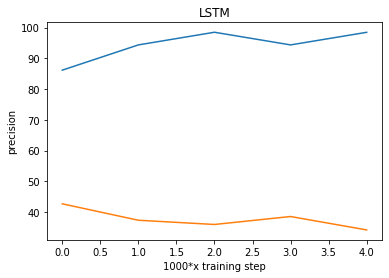

precision of the model on thevalidationdata: 34.1732292175293%
tensor([1.0000, 1.0000, 1.0000, 0.8814, 0.9519, 1.0000, 0.9783, 0.9981, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 0.9997, 0.9996, 1.0000, 1.0000,
        1.0000, 1.0000, 0.9880, 0.9555, 1.0000, 1.0000, 1.0000, 1.0000, 0.9999,
        1.0000, 1.0000, 1.0000, 0.8622, 0.9999, 0.9425, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 0.8702, 0.8106, 1.0000, 0.9937, 1.0000, 0.9520, 0.9929,
        1.0000, 0.9627, 0.9965, 0.9913, 1.0000, 1.0000, 0.9999, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 0.9654, 0.7438, 0.5852, 1.0000, 0.9996, 1.0000,
        0.9985, 1.0000, 1.0000, 0.9996, 0.9912, 0.9856, 0.9327, 1.0000, 0.9998,
        0.9993, 1.0000, 1.0000, 1.0000, 1.0000, 0.9998, 1.0000, 1.0000, 0.5169,
        1.0000, 0.9993, 1.0000, 0.9989, 1.0000, 1.0000, 0.9653, 0.8021, 1.0000,
        0.9669], device='cuda:1')
current i is 34
Filter 

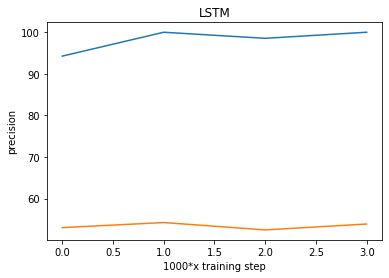

precision of the model on thevalidationdata: 53.62318801879883%
tensor([0.9999, 0.9859, 0.9970, 1.0000, 0.9975, 0.9999, 0.6879, 0.8390, 0.9786,
        0.9994, 0.9757, 0.9191, 0.9894, 0.9987, 0.9999, 0.9978, 1.0000, 0.9358,
        0.9970, 1.0000, 1.0000, 0.9997, 0.9911, 0.9919, 1.0000, 1.0000, 1.0000,
        0.6997, 0.9981, 0.7719, 0.9991, 0.5211, 1.0000, 1.0000, 1.0000, 1.0000,
        0.9986, 0.9844, 0.9999, 1.0000, 0.9066, 0.9660, 1.0000, 0.9988, 0.6052,
        1.0000, 0.9984, 1.0000, 0.9991, 0.9944, 0.9998, 1.0000, 0.9995, 0.9928,
        0.9988, 1.0000, 0.6779, 0.9634, 0.9706, 0.8985, 1.0000, 0.9870, 1.0000,
        1.0000, 0.9986, 1.0000, 0.9544, 0.9989, 0.6476, 1.0000, 0.9999, 0.8073,
        0.9995, 0.9941, 0.7942, 0.9989, 0.9801, 0.9978, 0.8190, 0.8694, 1.0000,
        0.9959, 1.0000, 0.9736, 1.0000, 0.9803, 0.9824, 1.0000, 1.0000, 0.9660,
        0.9213, 1.0000, 0.9607, 0.9997, 1.0000, 0.9997, 1.0000, 1.0000, 0.9348,
        1.0000], device='cuda:1')
current i is 35
Filter

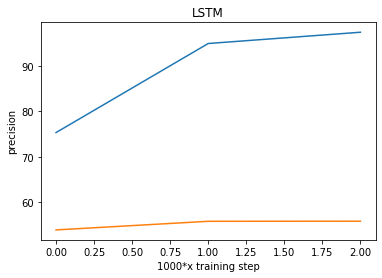

precision of the model on thevalidationdata: 55.82990264892578%
tensor([0.9342, 0.7055, 0.7354, 0.7636, 0.9946, 0.9836, 0.6091, 0.8603, 0.5330,
        0.6866, 0.8657, 0.5643, 0.5519, 0.9657, 0.9693, 0.6748, 0.8006, 0.8017,
        0.9454, 0.8066, 0.7014, 0.8934, 0.8978, 0.9949, 0.9193, 0.6737, 0.6745,
        0.6750, 0.8438, 0.9851, 0.7658, 0.9986, 0.9992, 0.8830, 0.5979, 0.8090,
        0.7000, 0.9994, 0.9937, 0.9735, 0.8132, 0.6802, 0.9313, 0.6572, 0.6874,
        0.6718, 0.6096, 0.8611, 0.5318, 0.9543, 0.9976, 0.8629, 0.6285, 0.8785,
        0.5291, 0.5716, 0.8273, 0.5715, 0.8480, 0.9553, 0.6101, 0.5894, 0.8461,
        0.5557, 0.8845, 0.9996, 0.9142, 0.5750, 0.8073, 0.5611, 0.5051, 0.8438,
        0.8523, 0.6774, 0.7855, 0.6478, 0.7114, 0.9493, 0.9082, 0.8088, 0.9854,
        0.9624, 0.7333, 0.8289, 0.8456, 0.5732, 0.6857, 0.8312, 0.8065, 0.8641,
        0.6595, 0.8003, 0.6412, 0.8595, 0.6575, 0.7407, 0.5633, 0.6572, 0.8246,
        0.5622], device='cuda:1')
current i is 36
Filter

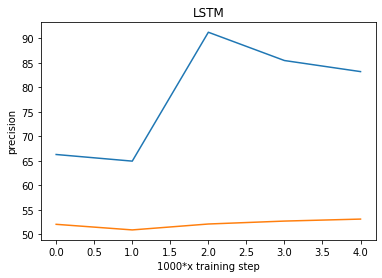

precision of the model on thevalidationdata: 52.932762145996094%
tensor([0.9796, 0.7077, 0.9986, 0.9994, 1.0000, 0.8067, 0.9999, 0.9999, 0.9410,
        1.0000, 0.9976, 0.9957, 1.0000, 0.9997, 0.9744, 0.9554, 0.9999, 0.5814,
        0.9994, 0.9983, 0.6980, 0.9957, 0.9983, 0.9855, 0.9523, 0.7527, 1.0000,
        0.6471, 0.9010, 0.7217, 0.8471, 0.9998, 0.9830, 0.9950, 0.9956, 1.0000,
        1.0000, 0.9998, 0.9979, 0.5885, 0.8751, 0.7403, 1.0000, 1.0000, 0.5759,
        0.9997, 0.5529, 0.6794, 0.7827, 0.9992, 0.9641, 0.9971, 0.9866, 0.7482,
        1.0000, 0.9970, 0.9996, 0.5801, 0.9967, 1.0000, 0.9936, 0.9953, 0.9162,
        0.8984, 0.7427, 1.0000, 0.9641, 0.9938, 0.9964, 0.8934, 0.9508, 0.6397,
        0.9066, 0.5424, 0.9998, 0.7521, 0.9997, 0.7973, 0.9949, 0.9963, 0.9614,
        0.5495, 0.7418, 0.7343, 0.6518, 0.7793, 0.9899, 0.7478, 1.0000, 0.5669,
        1.0000, 1.0000, 0.9784, 0.9243, 0.9983, 1.0000, 0.9904, 0.9520, 0.9997,
        0.9589], device='cuda:1')
current i is 37
Filte

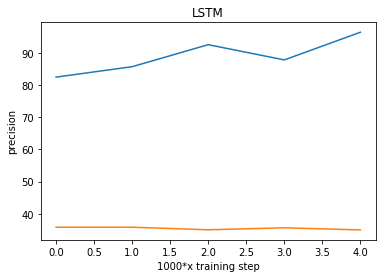

precision of the model on thevalidationdata: 35.57046890258789%
tensor([0.9990, 0.9954, 1.0000, 0.9998, 0.9999, 0.9997, 1.0000, 1.0000, 0.5081,
        1.0000, 1.0000, 1.0000, 0.8954, 1.0000, 0.6360, 1.0000, 0.9719, 0.9914,
        0.9682, 0.6959, 0.9677, 0.9713, 0.9670, 0.9999, 1.0000, 0.9802, 1.0000,
        0.9484, 1.0000, 0.9942, 1.0000, 1.0000, 1.0000, 1.0000, 0.7762, 1.0000,
        0.6296, 0.9375, 0.9723, 0.6026, 0.6966, 0.9192, 0.9999, 0.9997, 1.0000,
        1.0000, 0.6420, 1.0000, 0.9999, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        0.9486, 1.0000, 0.7526, 1.0000, 0.9996, 0.8362, 0.9999, 0.9818, 1.0000,
        1.0000, 0.9642, 1.0000, 0.9912, 1.0000, 0.9999, 0.9978, 0.9995, 1.0000,
        1.0000, 1.0000, 1.0000, 0.9505, 0.9752, 0.9978, 0.9987, 0.9612, 0.9661,
        0.9927, 0.9999, 1.0000, 1.0000, 1.0000, 0.9996, 1.0000, 0.9996, 0.5353,
        1.0000, 0.5630, 0.9308, 0.9893, 1.0000, 0.8092, 1.0000, 1.0000, 0.9995,
        1.0000], device='cuda:1')
current i is 38
Filter

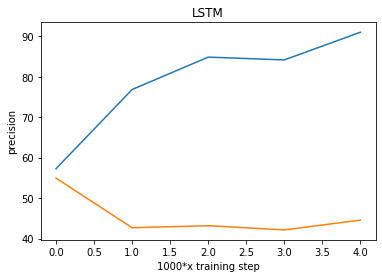

precision of the model on thevalidationdata: 42.30769348144531%
tensor([1.0000, 1.0000, 0.9999, 0.9997, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 0.9997,
        0.9998, 1.0000, 1.0000, 1.0000, 0.6308, 1.0000, 0.9997, 0.9999, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 0.5988, 0.9989, 1.0000,
        0.9999, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 0.9964, 1.0000, 1.0000,
        0.5846, 0.6038, 0.7235, 0.6717, 1.0000, 1.0000, 1.0000, 0.5320, 0.9970,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        0.9494, 0.9993, 1.0000, 1.0000, 1.0000, 0.6109, 1.0000, 1.0000, 1.0000,
        0.9959, 1.0000, 0.7597, 0.9999, 0.9999, 0.9999, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 0.9999, 0.9916, 1.0000, 1.0000, 0.5671, 0.9789,
        1.0000, 1.0000, 1.0000, 1.0000, 0.9998, 0.9962, 0.9880, 1.0000, 1.0000,
        0.9880], device='cuda:1')
current i is 39
Filter

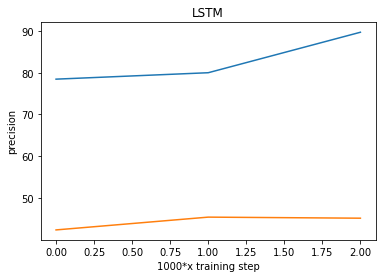

precision of the model on thevalidationdata: 46.50059127807617%
tensor([0.9999, 0.9605, 0.8047, 0.8256, 0.9798, 0.9999, 0.9984, 0.9998, 0.7991,
        0.6149, 1.0000, 1.0000, 0.9959, 0.8995, 0.5553, 1.0000, 1.0000, 0.9958,
        1.0000, 1.0000, 0.8614, 0.8315, 0.5729, 0.7221, 1.0000, 0.9152, 1.0000,
        0.9999, 0.5327, 1.0000, 0.9472, 1.0000, 1.0000, 1.0000, 1.0000, 0.9948,
        0.6379, 0.7284, 0.9280, 0.9998, 0.9856, 0.9998, 1.0000, 1.0000, 0.9987,
        1.0000, 0.9451, 0.8265, 0.9785, 0.8601, 0.9998, 1.0000, 1.0000, 1.0000,
        0.9156, 1.0000, 0.9974, 0.9999, 1.0000, 1.0000, 1.0000, 0.9873, 0.9788,
        0.9938, 1.0000, 0.9211, 1.0000, 0.7501, 0.9816, 0.5192, 0.6572, 0.8592,
        1.0000, 1.0000, 0.9929, 0.9233, 0.8068, 0.9888, 0.8015, 0.9067, 1.0000,
        0.9986, 0.9773, 1.0000, 1.0000, 0.9923, 0.9997, 1.0000, 0.9987, 0.6494,
        1.0000, 1.0000, 0.9999, 0.9999, 0.5979, 0.5906, 0.9940, 0.9596, 0.9999,
        1.0000], device='cuda:1')
current i is 41
Filter

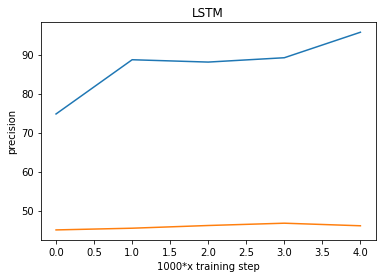

precision of the model on thevalidationdata: 46.47481918334961%
tensor([1.0000, 0.9990, 0.6580, 0.9835, 0.6942, 0.5493, 0.5789, 0.9904, 0.6414,
        0.5485, 0.8568, 0.9982, 0.5296, 0.9788, 0.9911, 0.9989, 0.5741, 1.0000,
        0.9997, 1.0000, 0.6748, 1.0000, 1.0000, 0.9946, 0.6476, 0.9742, 0.9221,
        0.9769, 1.0000, 0.9906, 1.0000, 0.9897, 0.9999, 0.6107, 0.6782, 0.6282,
        0.9977, 0.9110, 1.0000, 0.7974, 0.6972, 1.0000, 1.0000, 0.9938, 0.5185,
        0.9950, 1.0000, 0.6906, 0.8305, 0.9950, 1.0000, 0.9997, 0.9927, 0.7457,
        0.8625, 1.0000, 1.0000, 0.9828, 0.9998, 0.5777, 0.8561, 0.6586, 0.9499,
        1.0000, 0.8184, 1.0000, 0.9997, 0.6492, 0.9808, 0.9884, 0.9998, 0.5152,
        0.9997, 0.8655, 0.9236, 1.0000, 0.9999, 0.9989, 0.9996, 1.0000, 0.9933,
        0.9992, 0.8876, 0.9996, 1.0000, 0.8684, 1.0000, 1.0000, 1.0000, 0.9986,
        0.6527, 0.6446, 0.5797, 1.0000, 0.9996, 0.9512, 0.6647, 1.0000, 0.6407,
        0.5584], device='cuda:1')
current i is 42
Filter

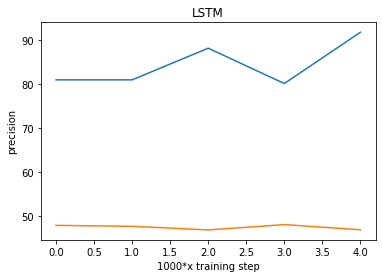

precision of the model on thevalidationdata: 47.73869323730469%
tensor([0.8403, 1.0000, 0.9998, 0.6954, 1.0000, 1.0000, 0.9949, 0.9986, 1.0000,
        0.6564, 1.0000, 0.8534, 1.0000, 0.6244, 0.7736, 1.0000, 1.0000, 0.9863,
        0.9995, 0.9994, 1.0000, 1.0000, 0.9997, 1.0000, 1.0000, 1.0000, 0.9976,
        0.9986, 1.0000, 0.9326, 0.9862, 1.0000, 1.0000, 0.5744, 1.0000, 0.6813,
        0.9166, 0.9991, 1.0000, 0.9984, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 0.9544, 0.9907, 1.0000, 0.8700, 1.0000, 0.9092, 0.7232,
        0.9987, 0.9945, 1.0000, 0.6763, 1.0000, 0.9870, 0.9833, 1.0000, 1.0000,
        0.9147, 0.9433, 0.9999, 0.8021, 1.0000, 0.9944, 0.9705, 0.8462, 0.9998,
        1.0000, 0.9987, 1.0000, 0.8707, 0.5593, 1.0000, 0.9948, 0.9177, 0.9947,
        1.0000, 1.0000, 1.0000, 0.9895, 0.5911, 0.9794, 0.9999, 0.9958, 0.8317,
        0.9811, 0.9992, 0.8726, 1.0000, 1.0000, 0.6637, 0.9909, 1.0000, 1.0000,
        0.9863], device='cuda:1')
current i is 43
Filter

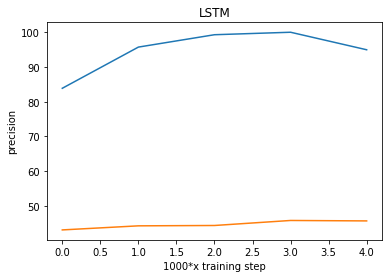

precision of the model on thevalidationdata: 44.84848403930664%
tensor([0.9966, 0.9987, 0.9886, 0.9795, 0.6431, 0.9741, 0.9796, 0.9801, 0.9965,
        0.9432, 0.8148, 0.7891, 1.0000, 0.9838, 0.9999, 0.8235, 0.9509, 0.9999,
        0.9651, 0.9969, 0.9981, 1.0000, 0.9999, 1.0000, 0.9441, 1.0000, 1.0000,
        0.6219, 0.9822, 0.8733, 0.9486, 0.9999, 0.8060, 0.7375, 0.6971, 0.7280,
        0.9779, 0.9993, 0.9947, 0.9502, 1.0000, 0.9405, 0.9575, 0.9418, 0.5126,
        0.8781, 1.0000, 0.6286, 0.9940, 0.9174, 0.9826, 0.9999, 0.9993, 0.9987,
        0.9990, 1.0000, 1.0000, 0.9981, 0.9703, 0.8796, 0.8982, 1.0000, 0.9518,
        0.9999, 0.9876, 0.9989, 0.9985, 0.7711, 0.9791, 0.8096, 1.0000, 0.5291,
        0.6728, 0.5675, 0.6755, 0.9891, 1.0000, 1.0000, 1.0000, 1.0000, 0.9999,
        0.9670, 0.9979, 0.9948, 1.0000, 1.0000, 0.9667, 0.9359, 0.9844, 0.5919,
        0.9772, 0.9994, 0.9731, 0.9998, 1.0000, 0.9998, 0.9999, 0.9850, 0.6607,
        1.0000], device='cuda:1')
current i is 44
Filter

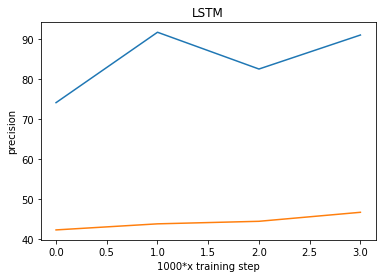

precision of the model on thevalidationdata: 44.962406158447266%
tensor([1.0000, 0.9740, 0.6706, 1.0000, 0.9995, 1.0000, 0.5657, 0.5420, 0.6646,
        0.9998, 0.9998, 0.7198, 0.5269, 0.5472, 0.5736, 0.5988, 0.6120, 0.6595,
        0.9994, 1.0000, 0.9815, 1.0000, 0.9997, 0.9998, 0.5074, 0.8910, 0.5509,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 0.9991, 0.9972, 0.9999,
        0.9978, 0.9907, 1.0000, 0.6024, 0.5907, 0.5360, 0.5516, 0.5338, 0.6739,
        1.0000, 0.9996, 0.9999, 1.0000, 0.9347, 0.6437, 1.0000, 0.9978, 0.9985,
        0.9999, 0.9968, 0.5244, 0.9984, 0.9999, 1.0000, 0.7877, 0.6859, 0.9998,
        0.9994, 0.5682, 0.6334, 0.9603, 0.9877, 0.9935, 0.5375, 0.5678, 0.9529,
        0.6256, 0.5797, 0.5839, 0.5608, 0.9088, 0.7408, 0.5972, 0.6518, 0.5865,
        0.6214, 0.5842, 0.5558, 0.5073, 0.7547, 1.0000, 1.0000, 1.0000, 0.5012,
        1.0000, 0.9968, 0.9882, 1.0000, 0.5323, 0.5293, 0.5292, 0.5332, 0.5440,
        0.5759], device='cuda:1')
current i is 45
Filte

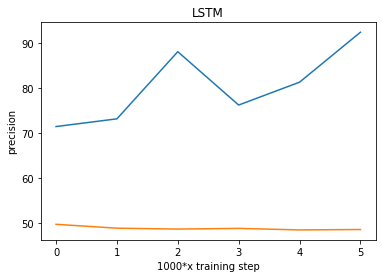

precision of the model on thevalidationdata: 48.633880615234375%
tensor([0.8101, 0.9997, 0.9764, 1.0000, 1.0000, 0.9998, 1.0000, 1.0000, 1.0000,
        0.9871, 0.9981, 0.9747, 0.9995, 1.0000, 0.9554, 0.9999, 0.5283, 0.7657,
        1.0000, 1.0000, 0.9985, 1.0000, 0.9730, 0.9970, 1.0000, 1.0000, 0.9304,
        0.9758, 0.9976, 0.9993, 0.9986, 1.0000, 0.9982, 0.9993, 0.9996, 0.8704,
        0.9880, 1.0000, 0.7997, 1.0000, 1.0000, 0.9290, 0.9724, 0.9886, 0.9999,
        0.9970, 1.0000, 1.0000, 1.0000, 0.8032, 1.0000, 1.0000, 0.9999, 0.9820,
        0.9999, 0.9845, 0.7324, 0.9813, 0.5191, 1.0000, 1.0000, 1.0000, 0.5271,
        1.0000, 1.0000, 1.0000, 0.9975, 1.0000, 0.9972, 1.0000, 1.0000, 0.6285,
        0.5047, 1.0000, 0.9975, 0.9994, 1.0000, 1.0000, 1.0000, 0.8709, 0.9999,
        1.0000, 0.9997, 0.6638, 0.6333, 0.5877, 1.0000, 1.0000, 0.9602, 0.8924,
        1.0000, 1.0000, 0.9997, 1.0000, 1.0000, 0.6175, 0.9987, 0.9955, 0.9339,
        0.9966], device='cuda:1')
current i is 46
Filte

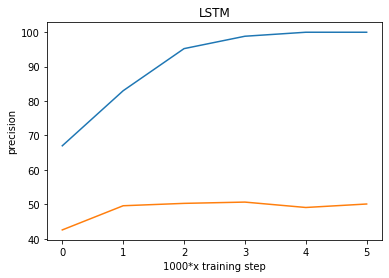

precision of the model on thevalidationdata: 50.076568603515625%
tensor([0.5124, 0.7494, 0.6823, 1.0000, 0.9991, 1.0000, 1.0000, 1.0000, 0.9363,
        0.8057, 0.8605, 0.7534, 0.6261, 0.7557, 0.8593, 0.8391, 0.9984, 1.0000,
        0.9661, 1.0000, 0.9843, 0.8456, 0.8597, 0.8986, 0.8918, 0.9852, 1.0000,
        0.9079, 1.0000, 1.0000, 0.5102, 0.7225, 0.7554, 0.5705, 0.9530, 0.9413,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 0.7421, 0.5517, 1.0000, 0.8239,
        1.0000, 1.0000, 1.0000, 1.0000, 0.9998, 1.0000, 1.0000, 0.9956, 0.9942,
        0.5132, 0.8593, 0.9145, 0.6931, 0.5289, 0.8129, 0.8698, 1.0000, 0.7626,
        1.0000, 1.0000, 1.0000, 0.7142, 0.5712, 0.8780, 0.7022, 0.5081, 0.9122,
        1.0000, 0.9990, 0.9971, 0.7615, 0.9988, 0.7311, 0.9864, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 0.9983, 1.0000, 1.0000, 0.9300, 0.9999, 0.5844,
        0.9575, 0.9967, 0.9890, 0.9953, 0.9984, 0.9540, 0.6527, 0.9997, 1.0000,
        0.9735], device='cuda:1')
current i is 47
Filte

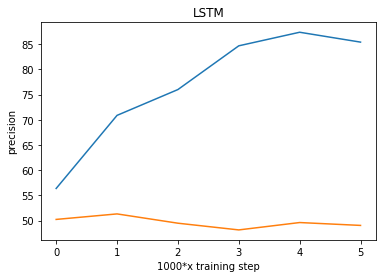

precision of the model on thevalidationdata: 49.02723693847656%
tensor([0.9999, 1.0000, 1.0000, 0.9995, 0.9799, 1.0000, 0.9992, 1.0000, 0.5104,
        0.9929, 1.0000, 0.8786, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 0.5366,
        0.9040, 1.0000, 0.9764, 0.9961, 1.0000, 0.9902, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 0.9998, 0.7189, 0.7479, 1.0000, 1.0000, 0.9997, 1.0000,
        0.9917, 1.0000, 0.9545, 1.0000, 0.9999, 1.0000, 0.5556, 1.0000, 0.6164,
        0.9992, 0.9999, 1.0000, 1.0000, 0.9995, 0.9965, 0.5015, 1.0000, 0.9989,
        1.0000, 0.6258, 0.7115, 1.0000, 0.8945, 0.9999, 1.0000, 1.0000, 0.5030,
        1.0000, 0.9997, 1.0000, 0.9873, 0.5405, 1.0000, 0.9906, 1.0000, 0.5807,
        1.0000, 1.0000, 1.0000, 0.8795, 1.0000, 1.0000, 0.9508, 1.0000, 0.9846,
        0.5304, 0.9912, 1.0000, 0.7795, 1.0000, 1.0000, 1.0000, 1.0000, 0.9917,
        0.9996, 1.0000, 0.9997, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000], device='cuda:1')
current i is 48
Filter

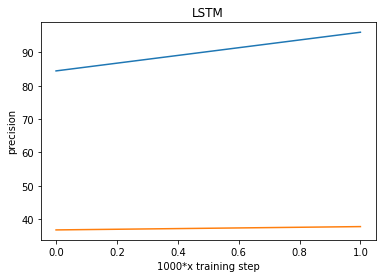

precision of the model on thevalidationdata: 37.86982345581055%
tensor([0.8162, 0.9992, 0.9220, 1.0000, 1.0000, 0.8650, 0.6920, 0.6633, 0.9555,
        0.5774, 0.7932, 0.5953, 0.5432, 0.5436, 0.5430, 0.9971, 0.9976, 0.9603,
        0.5450, 0.5430, 0.5437, 0.5455, 0.6533, 0.6399, 0.9553, 0.9786, 0.9054,
        0.9729, 0.5623, 0.8864, 1.0000, 0.9998, 0.9918, 0.9366, 0.7692, 0.5684,
        0.8593, 0.7630, 0.8401, 0.5395, 0.6188, 0.6163, 0.9577, 0.8007, 0.8724,
        0.7937, 0.7693, 0.6339, 1.0000, 1.0000, 1.0000, 0.7855, 0.9524, 0.9947,
        0.8868, 0.8820, 1.0000, 0.5593, 0.5493, 0.5473, 0.7865, 0.8971, 0.7871,
        1.0000, 0.9999, 0.9057, 0.5428, 0.9999, 0.9997, 0.7364, 0.5186, 0.5874,
        0.7671, 0.5916, 0.5671, 0.9255, 0.9831, 0.9936, 0.6710, 0.8782, 0.5087,
        0.9046, 0.9071, 0.5339, 0.7876, 0.5513, 0.5943, 1.0000, 0.9997, 0.9999,
        0.5435, 0.5438, 0.5434, 0.8893, 0.8241, 0.6141, 0.9999, 0.9997, 0.9663,
        0.7816], device='cuda:1')
current i is 49
Filter

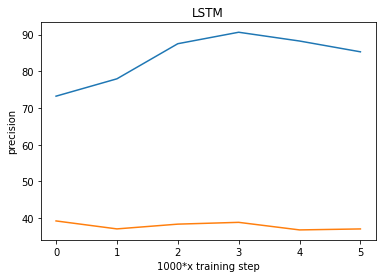

precision of the model on thevalidationdata: 37.055015563964844%
tensor([0.6878, 0.5816, 0.5058, 0.9999, 0.7628, 0.9997, 0.8682, 0.9787, 0.9949,
        1.0000, 0.9375, 0.6190, 0.5470, 0.6004, 0.6467, 0.9976, 0.6199, 0.5803,
        0.5664, 0.5517, 0.5249, 0.5507, 0.5497, 0.7483, 0.6928, 1.0000, 0.9952,
        0.7679, 0.5119, 0.5643, 1.0000, 1.0000, 1.0000, 0.9999, 0.9993, 0.9846,
        0.6309, 0.8626, 0.7883, 0.5542, 0.5541, 0.5542, 0.9997, 1.0000, 0.9999,
        0.9999, 0.6155, 0.5835, 1.0000, 0.9857, 1.0000, 0.9937, 0.9815, 0.9068,
        0.9999, 1.0000, 0.9650, 1.0000, 0.9984, 0.9092, 0.9733, 0.9998, 0.9797,
        0.5202, 0.5167, 0.5569, 0.8428, 0.7763, 0.9962, 0.5541, 0.5541, 1.0000,
        0.5688, 0.6737, 0.5073, 0.5625, 0.5679, 0.7738, 0.5519, 0.5307, 0.5389,
        0.9952, 1.0000, 0.6649, 0.8215, 0.9899, 0.5395, 0.5728, 0.6182, 0.5960,
        1.0000, 0.9999, 0.7250, 0.6840, 0.7210, 0.7568, 0.9961, 1.0000, 1.0000,
        0.9626], device='cuda:1')
current i is 50
Filte

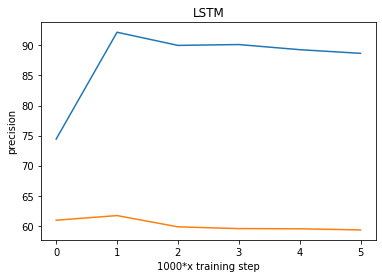

precision of the model on thevalidationdata: 59.30232620239258%
tensor([1.0000, 1.0000, 0.9997, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        0.8370, 0.9996, 0.9997, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        0.9274, 1.0000, 1.0000, 0.8069, 1.0000, 0.9999, 1.0000, 1.0000, 1.0000,
        0.9917, 0.6471, 0.9977, 1.0000, 0.9810, 1.0000, 1.0000, 1.0000, 1.0000,
        0.5038, 1.0000, 0.9619, 1.0000, 1.0000, 1.0000, 0.9996, 0.9223, 1.0000,
        1.0000, 0.9740, 0.9876, 1.0000, 1.0000, 1.0000, 0.9596, 1.0000, 1.0000,
        1.0000, 1.0000, 0.9984, 1.0000, 1.0000, 1.0000, 0.9998, 0.9998, 1.0000,
        0.9999, 1.0000, 0.7351, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 0.9932, 0.9706, 1.0000, 1.0000, 0.9878, 0.9984, 1.0000,
        1.0000, 1.0000, 0.6176, 1.0000, 0.9999, 1.0000, 1.0000, 0.8324, 0.9999,
        0.9960, 0.9962, 0.5211, 1.0000, 0.9972, 1.0000, 0.9999, 0.9510, 1.0000,
        0.9070], device='cuda:1')
current i is 51
Filter

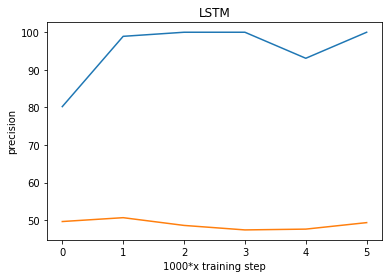

precision of the model on thevalidationdata: 49.367088317871094%
tensor([0.9587, 0.8857, 0.9937, 0.7490, 1.0000, 0.9999, 0.9994, 0.9998, 0.7338,
        0.7469, 1.0000, 0.7708, 0.7858, 0.6377, 0.5236, 0.6403, 1.0000, 1.0000,
        0.6939, 0.6329, 1.0000, 0.9951, 0.9803, 0.7039, 0.6866, 1.0000, 1.0000,
        0.5596, 1.0000, 1.0000, 0.8990, 0.9914, 0.9999, 0.8887, 0.9291, 0.9054,
        0.6925, 0.8656, 1.0000, 0.8520, 1.0000, 0.9729, 0.6979, 0.7453, 0.9336,
        1.0000, 0.6905, 0.9288, 0.6381, 0.6846, 0.9991, 0.8732, 0.9984, 1.0000,
        0.9985, 0.9948, 1.0000, 1.0000, 0.5087, 0.7636, 0.9294, 0.5701, 0.6786,
        0.6310, 0.7832, 1.0000, 0.9981, 1.0000, 0.6849, 0.6852, 0.6820, 0.6075,
        0.9997, 1.0000, 0.9994, 0.8200, 1.0000, 0.9983, 0.8084, 0.9982, 0.9911,
        1.0000, 0.7202, 0.8192, 1.0000, 1.0000, 1.0000, 1.0000, 0.8794, 0.9654,
        1.0000, 1.0000, 0.7157, 0.7968, 1.0000, 0.9843, 0.9997, 1.0000, 0.6152,
        0.5918], device='cuda:1')
current i is 52
Filte

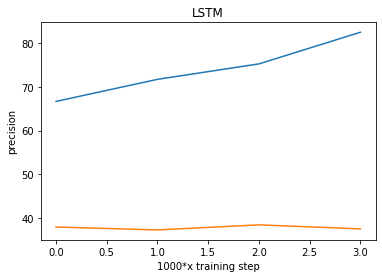

precision of the model on thevalidationdata: 37.17616653442383%
tensor([0.7272, 0.9966, 1.0000, 0.9935, 0.8305, 0.9998, 1.0000, 0.9991, 1.0000,
        0.5642, 0.9943, 1.0000, 0.9999, 1.0000, 0.9941, 0.5356, 0.9988, 0.9990,
        1.0000, 0.9999, 1.0000, 1.0000, 0.9996, 0.6578, 0.5330, 0.7026, 0.9698,
        0.5144, 0.5496, 1.0000, 1.0000, 0.9207, 0.9290, 0.8098, 0.9677, 0.9999,
        0.9998, 1.0000, 0.9450, 1.0000, 1.0000, 0.9999, 0.9999, 1.0000, 1.0000,
        0.5820, 0.8313, 0.6468, 0.9553, 0.9980, 0.6695, 0.5162, 0.9898, 0.9436,
        1.0000, 0.6714, 0.9199, 0.6248, 0.5412, 0.5126, 1.0000, 0.7027, 0.9999,
        0.6800, 0.9299, 0.5410, 0.7962, 0.8931, 0.5306, 0.9995, 0.8650, 0.6676,
        1.0000, 0.8044, 0.9284, 0.9979, 1.0000, 0.8037, 1.0000, 0.8168, 1.0000,
        0.9984, 1.0000, 1.0000, 0.9999, 1.0000, 0.9839, 1.0000, 0.9993, 1.0000,
        0.5203, 0.5097, 0.6597, 0.5861, 0.9973, 0.9994, 0.6836, 0.9682, 0.9988,
        1.0000], device='cuda:1')
current i is 54
Filter

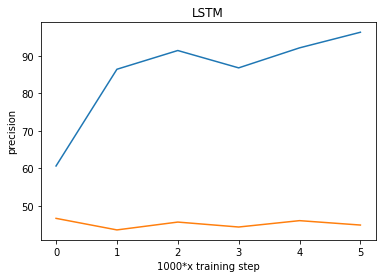

precision of the model on thevalidationdata: 44.08945846557617%
tensor([0.9851, 0.9811, 0.9898, 1.0000, 1.0000, 1.0000, 1.0000, 0.9920, 0.9989,
        0.9822, 0.5135, 0.9973, 0.9996, 1.0000, 0.9455, 1.0000, 0.9897, 0.9760,
        1.0000, 0.5946, 1.0000, 0.9928, 1.0000, 0.9992, 0.9990, 0.9963, 0.9983,
        0.7084, 0.5146, 0.7894, 0.9991, 0.8230, 0.9998, 0.9922, 1.0000, 0.8512,
        0.9811, 0.8957, 0.9993, 0.9951, 1.0000, 1.0000, 0.9981, 1.0000, 1.0000,
        1.0000, 0.9944, 1.0000, 0.9953, 0.7025, 0.9994, 0.5254, 0.7492, 1.0000,
        0.8380, 1.0000, 0.9656, 0.8436, 1.0000, 1.0000, 0.6025, 1.0000, 1.0000,
        0.7717, 0.6908, 0.8619, 1.0000, 0.9952, 0.5933, 0.9227, 0.9968, 1.0000,
        1.0000, 0.9903, 0.6151, 0.5128, 0.8180, 0.9980, 1.0000, 0.7308, 0.9390,
        1.0000, 1.0000, 0.7451, 1.0000, 0.5418, 0.6707, 1.0000, 1.0000, 0.9977,
        0.9664, 1.0000, 0.9681, 0.9808, 0.9998, 1.0000, 0.7658, 0.9997, 0.9536,
        1.0000], device='cuda:1')
current i is 55
Filter

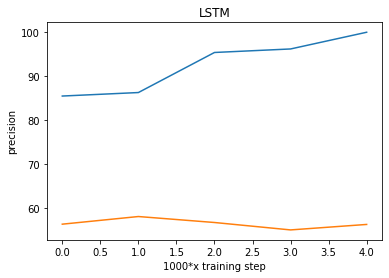

precision of the model on thevalidationdata: 56.33802795410156%
tensor([1.0000, 1.0000, 1.0000, 0.9996, 0.9999, 0.9681, 1.0000, 1.0000, 0.9991,
        1.0000, 1.0000, 1.0000, 0.7203, 1.0000, 0.9983, 0.9992, 0.9911, 0.9999,
        0.6969, 1.0000, 1.0000, 0.9997, 0.9996, 1.0000, 0.7992, 0.6252, 1.0000,
        0.9999, 0.9664, 0.9996, 1.0000, 1.0000, 0.9995, 1.0000, 1.0000, 1.0000,
        1.0000, 0.9993, 1.0000, 0.9963, 0.9953, 0.5643, 0.7204, 1.0000, 0.9092,
        0.9938, 1.0000, 0.6984, 0.5918, 0.9990, 1.0000, 0.5136, 0.6344, 1.0000,
        0.8644, 0.9999, 0.9970, 1.0000, 0.9777, 1.0000, 0.9968, 1.0000, 1.0000,
        0.7229, 1.0000, 1.0000, 1.0000, 0.9999, 0.9999, 0.7336, 1.0000, 1.0000,
        0.9839, 0.9999, 1.0000, 0.9964, 1.0000, 1.0000, 0.9999, 0.8703, 0.9940,
        0.9999, 1.0000, 1.0000, 0.9972, 1.0000, 1.0000, 0.7169, 0.9999, 0.9959,
        1.0000, 1.0000, 0.9604, 0.9797, 0.9996, 1.0000, 0.8097, 0.6699, 1.0000,
        0.5100], device='cuda:1')
current i is 56
Filter

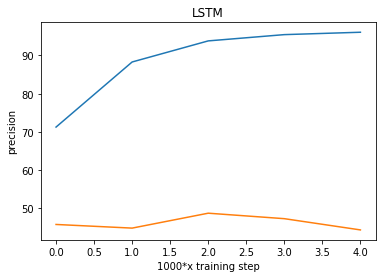

precision of the model on thevalidationdata: 42.682926177978516%
tensor([0.5535, 0.5303, 0.9404, 0.9871, 0.9966, 0.9941, 0.9334, 0.9951, 0.9919,
        1.0000, 0.9997, 0.9663, 1.0000, 0.7073, 0.9992, 0.9999, 0.5554, 1.0000,
        0.5996, 0.6655, 0.8061, 0.5470, 1.0000, 0.8377, 0.9997, 0.9413, 0.8056,
        0.8401, 0.9992, 1.0000, 0.5409, 0.9999, 1.0000, 1.0000, 0.5351, 0.5476,
        1.0000, 0.9978, 0.7637, 0.6029, 1.0000, 1.0000, 1.0000, 0.9969, 1.0000,
        0.9998, 0.7615, 0.9705, 0.9981, 0.7590, 0.9998, 0.9236, 1.0000, 0.9934,
        0.9626, 0.7610, 1.0000, 0.5128, 0.9992, 1.0000, 1.0000, 1.0000, 0.9041,
        1.0000, 1.0000, 0.9895, 0.9820, 1.0000, 0.9680, 1.0000, 0.7834, 1.0000,
        1.0000, 0.8848, 0.9958, 1.0000, 1.0000, 0.9364, 0.9203, 0.7421, 1.0000,
        0.9986, 0.9979, 0.6084, 0.9751, 0.9444, 0.8447, 1.0000, 1.0000, 0.8714,
        1.0000, 0.5348, 0.5411, 1.0000, 0.9929, 0.5510, 0.5597, 0.5353, 1.0000,
        1.0000], device='cuda:1')
current i is 57
Filte

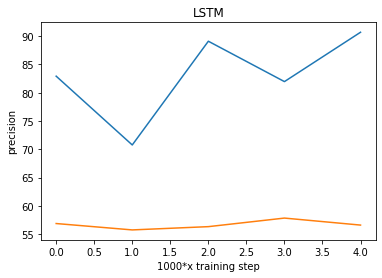

precision of the model on thevalidationdata: 57.518798828125%
tensor([0.6160, 0.5575, 0.5632, 0.9957, 1.0000, 0.9990, 0.9999, 0.9888, 0.9936,
        0.5501, 0.5195, 0.5129, 0.5915, 0.5799, 0.5630, 0.6705, 0.9998, 1.0000,
        0.6068, 0.7968, 0.7238, 0.9986, 0.5994, 0.6076, 0.5559, 1.0000, 0.9363,
        0.8938, 0.5099, 0.5936, 0.6584, 0.5363, 0.6083, 0.5128, 0.5012, 0.6536,
        0.6656, 0.5212, 0.5171, 0.5366, 0.9967, 0.9999, 1.0000, 0.6047, 0.6325,
        0.6355, 0.7042, 0.6229, 0.6576, 0.5179, 0.6223, 0.5363, 0.6634, 0.7225,
        0.9092, 1.0000, 0.9999, 0.9040, 0.5284, 0.9495, 0.9999, 0.8718, 0.5316,
        0.9332, 0.7764, 0.5670, 0.5785, 0.5960, 0.9499, 0.8718, 0.9997, 0.6691,
        0.7826, 0.9715, 0.5750, 0.9938, 0.5500, 0.5500, 0.5673, 0.6518, 0.5910,
        0.5906, 1.0000, 0.9980, 0.9958, 1.0000, 0.7785, 0.9999, 0.5559, 0.6301,
        0.6632, 0.7022, 0.6816, 0.5569, 0.9991, 0.7493, 0.5275, 0.9969, 0.9727,
        0.7346], device='cuda:1')
current i is 58
Filter l

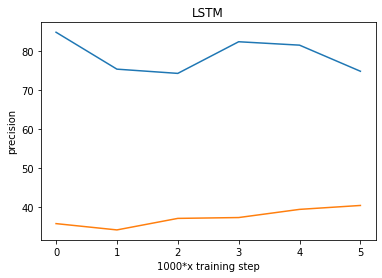

precision of the model on thevalidationdata: 38.972808837890625%
tensor([1.0000, 0.8535, 0.9999, 1.0000, 1.0000, 0.9996, 1.0000, 0.9449, 1.0000,
        1.0000, 0.5235, 0.9994, 0.8941, 1.0000, 1.0000, 0.9968, 0.9994, 1.0000,
        1.0000, 0.8209, 1.0000, 1.0000, 0.6103, 1.0000, 0.9014, 0.5417, 1.0000,
        0.9999, 0.6049, 0.9998, 0.5498, 0.5677, 0.8860, 0.5765, 0.6702, 0.9988,
        1.0000, 1.0000, 1.0000, 1.0000, 0.9943, 1.0000, 1.0000, 1.0000, 1.0000,
        0.9999, 0.9257, 0.9977, 0.9875, 0.8852, 0.7140, 0.9402, 0.9916, 1.0000,
        0.9999, 1.0000, 0.9945, 1.0000, 1.0000, 0.8662, 1.0000, 1.0000, 0.9975,
        0.5175, 0.5279, 0.9999, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 0.9995, 0.5772, 0.5161, 0.5503, 0.9979,
        0.5191, 0.5546, 0.9894, 0.5473, 0.5619, 0.6607, 0.5201, 0.5392, 0.9695,
        0.9905, 0.7095, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 0.5484,
        0.5645], device='cuda:1')
current i is 59
Filte

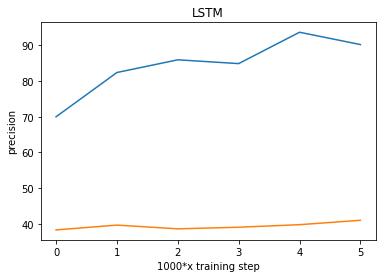

precision of the model on thevalidationdata: 38.88255310058594%
tensor([1.0000, 0.5908, 1.0000, 0.9744, 0.9807, 0.6062, 0.9957, 0.9910, 0.5334,
        1.0000, 0.9997, 0.9334, 0.8133, 0.6258, 0.9480, 0.5388, 0.5192, 0.5094,
        0.9999, 0.9957, 1.0000, 1.0000, 0.7637, 1.0000, 0.9958, 1.0000, 1.0000,
        1.0000, 1.0000, 0.9683, 0.9813, 0.5468, 0.9995, 1.0000, 0.9986, 0.6937,
        1.0000, 0.9007, 0.9746, 0.5422, 0.9653, 0.9996, 0.9999, 0.9991, 0.5202,
        1.0000, 1.0000, 1.0000, 1.0000, 0.9928, 0.9062, 0.9994, 0.5041, 1.0000,
        0.6088, 0.8311, 1.0000, 1.0000, 0.9984, 0.9977, 0.9999, 0.9904, 1.0000,
        0.5247, 0.5951, 0.5194, 0.9952, 1.0000, 1.0000, 0.6337, 0.5569, 0.9954,
        0.8849, 0.9994, 0.9995, 1.0000, 0.8999, 0.9483, 1.0000, 1.0000, 0.9985,
        1.0000, 0.9389, 0.9987, 0.9999, 0.7934, 1.0000, 0.9955, 0.9994, 0.6212,
        1.0000, 1.0000, 1.0000, 0.9883, 0.9917, 1.0000, 1.0000, 1.0000, 1.0000,
        0.9995], device='cuda:1')
current i is 60
Filter

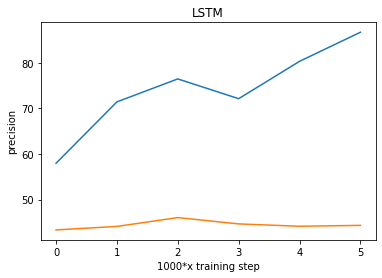

precision of the model on thevalidationdata: 45.11201477050781%
tensor([0.9999, 0.9999, 0.9872, 0.9996, 1.0000, 0.9999, 0.5272, 0.6027, 0.5170,
        0.9534, 0.9298, 0.5859, 0.9594, 0.9602, 0.8996, 0.7514, 1.0000, 0.9987,
        1.0000, 1.0000, 1.0000, 1.0000, 0.9119, 1.0000, 1.0000, 1.0000, 0.9978,
        0.5157, 0.5112, 0.5180, 1.0000, 1.0000, 0.9995, 1.0000, 1.0000, 0.9125,
        0.9996, 0.7177, 0.9969, 0.9998, 0.9370, 0.9992, 0.5309, 0.5338, 0.5161,
        0.5687, 0.5289, 0.5221, 0.9331, 0.9999, 0.6396, 0.9980, 0.9988, 1.0000,
        0.9622, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 0.9996, 1.0000, 1.0000,
        0.5042, 0.9998, 0.8979, 1.0000, 1.0000, 1.0000, 0.9971, 1.0000, 0.9666,
        0.9075, 0.9672, 1.0000, 1.0000, 1.0000, 1.0000, 0.9525, 1.0000, 0.9815,
        0.5020, 0.9816, 0.9804, 1.0000, 1.0000, 0.9990, 1.0000, 1.0000, 1.0000,
        0.5707, 0.5620, 0.5131, 0.5017, 0.9336, 0.6176, 1.0000, 1.0000, 1.0000,
        1.0000], device='cuda:1')
current i is 61
Filter

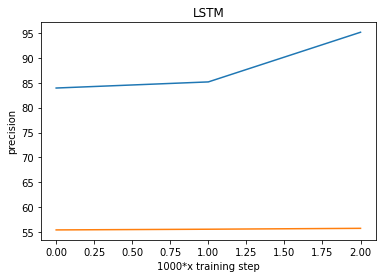

precision of the model on thevalidationdata: 55.76036834716797%
tensor([0.9985, 0.9980, 0.7952, 1.0000, 0.9970, 1.0000, 0.9112, 1.0000, 1.0000,
        1.0000, 0.9306, 1.0000, 1.0000, 1.0000, 1.0000, 0.9890, 1.0000, 1.0000,
        1.0000, 1.0000, 0.6371, 0.9599, 0.7416, 0.8598, 0.5025, 0.6099, 0.7285,
        0.9370, 0.9999, 0.9992, 1.0000, 1.0000, 1.0000, 0.8075, 0.5525, 0.9999,
        1.0000, 1.0000, 1.0000, 1.0000, 0.9021, 0.9994, 0.9873, 0.9618, 1.0000,
        1.0000, 0.9958, 1.0000, 1.0000, 1.0000, 0.9811, 0.5588, 0.6961, 0.9982,
        1.0000, 0.9782, 0.9943, 1.0000, 1.0000, 0.6969, 0.5012, 0.5198, 0.6318,
        0.9228, 0.9985, 0.9974, 0.6437, 0.9999, 1.0000, 0.9969, 0.9308, 0.9999,
        0.9914, 0.9998, 1.0000, 0.8435, 0.9972, 0.8522, 0.6443, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 0.9850,
        1.0000, 1.0000, 1.0000, 0.7079, 0.6538, 0.9998, 1.0000, 0.6450, 1.0000,
        0.8349], device='cuda:1')
current i is 62
Filter

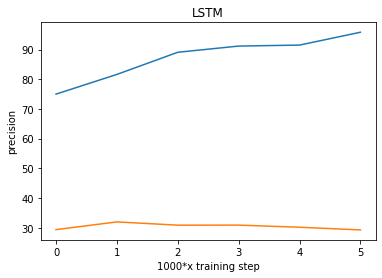

precision of the model on thevalidationdata: 31.056467056274414%
tensor([0.5691, 0.5107, 0.5107, 0.9997, 1.0000, 1.0000, 0.9997, 0.9998, 0.9999,
        1.0000, 0.9997, 0.9008, 0.9997, 1.0000, 0.8225, 0.5102, 0.5107, 0.8532,
        1.0000, 1.0000, 1.0000, 1.0000, 0.9995, 0.6801, 1.0000, 0.9998, 1.0000,
        0.5043, 0.6255, 0.7113, 1.0000, 0.9802, 1.0000, 0.9728, 0.7652, 0.8029,
        1.0000, 0.9654, 0.9986, 0.9985, 1.0000, 0.8606, 0.5629, 0.6383, 1.0000,
        0.5988, 0.5345, 0.5523, 1.0000, 1.0000, 0.9329, 1.0000, 1.0000, 0.9879,
        0.9527, 0.9572, 1.0000, 0.6652, 0.9182, 1.0000, 1.0000, 0.9890, 1.0000,
        0.7654, 0.6322, 1.0000, 0.9992, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 0.9971, 0.9999, 1.0000, 1.0000, 0.5355, 0.5162, 0.5147,
        0.9977, 1.0000, 1.0000, 0.5204, 0.5801, 0.5351, 0.9968, 0.6028, 1.0000,
        1.0000, 1.0000, 0.9992, 0.8866, 0.8176, 0.9486, 0.9988, 1.0000, 1.0000,
        0.6171], device='cuda:1')
current i is 63
Filte

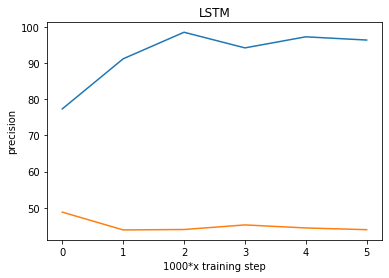

precision of the model on thevalidationdata: 44.089012145996094%
tensor([0.5334, 1.0000, 0.9308, 0.8521, 0.9813, 1.0000, 0.9889, 0.9998, 1.0000,
        0.6205, 1.0000, 1.0000, 1.0000, 0.9574, 0.9990, 0.9823, 0.9983, 1.0000,
        1.0000, 1.0000, 0.7024, 0.9098, 0.9999, 1.0000, 1.0000, 1.0000, 1.0000,
        0.8067, 1.0000, 1.0000, 0.9999, 0.9409, 1.0000, 1.0000, 1.0000, 0.9911,
        1.0000, 0.9999, 1.0000, 0.9999, 0.9903, 0.5656, 0.8916, 0.7539, 1.0000,
        0.9842, 0.9915, 0.6437, 1.0000, 1.0000, 1.0000, 0.9973, 1.0000, 0.5106,
        0.9998, 0.9998, 1.0000, 1.0000, 1.0000, 0.9999, 1.0000, 1.0000, 1.0000,
        1.0000, 0.9700, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 0.8602, 0.9541,
        1.0000, 1.0000, 0.9767, 1.0000, 0.6477, 0.8621, 1.0000, 0.9924, 1.0000,
        0.6721, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 0.9998, 0.9973, 0.8201,
        0.6723, 1.0000, 0.9992, 1.0000, 1.0000, 1.0000, 0.9886, 1.0000, 0.9999,
        0.9881], device='cuda:1')
current i is 64
Filte

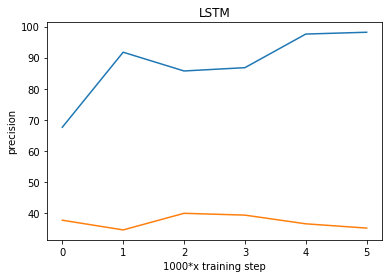

precision of the model on thevalidationdata: 36.53845977783203%
tensor([0.7805, 0.9922, 0.8957, 0.9963, 0.6304, 0.8424, 0.9999, 0.8575, 0.5940,
        0.7413, 0.5751, 0.5858, 0.6123, 0.9524, 0.5940, 0.5966, 0.7275, 0.8030,
        0.9280, 0.9987, 0.5912, 0.5937, 0.5029, 0.7025, 0.5421, 0.5123, 0.6031,
        0.7399, 0.6004, 0.6380, 0.9998, 1.0000, 0.5940, 0.5940, 0.5940, 0.5940,
        0.5942, 0.5944, 0.5940, 0.8134, 0.5940, 0.5940, 0.5891, 0.5771, 0.5935,
        0.5938, 0.5906, 0.5951, 0.5940, 0.5940, 0.6229, 0.6103, 0.5840, 0.5995,
        0.7721, 0.9823, 0.5940, 0.5940, 0.6409, 0.5043, 0.9935, 0.9989, 0.5940,
        0.5940, 0.5940, 0.5940, 0.8844, 0.5940, 0.9982, 0.9997, 0.5340, 0.5619,
        0.6023, 0.5906, 1.0000, 1.0000, 0.5940, 0.5940, 0.5429, 0.7507, 0.5940,
        0.5940, 0.9999, 0.7884, 0.7516, 0.9812, 0.5940, 0.5940, 0.6468, 0.7298,
        0.5940, 0.7188, 0.5940, 0.5940, 0.5940, 0.8141, 0.5879, 0.5969, 0.9977,
        0.9530], device='cuda:1')
current i is 65
Filter

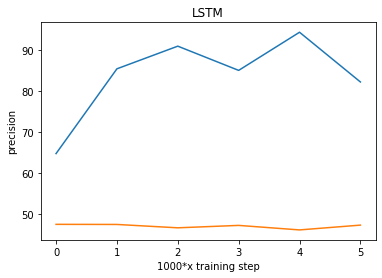

precision of the model on thevalidationdata: 47.31182861328125%
tensor([1.0000, 1.0000, 0.9875, 0.9078, 1.0000, 1.0000, 0.9237, 0.9777, 0.7504,
        0.9996, 1.0000, 0.9979, 1.0000, 0.9998, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 0.9994, 0.9940, 0.9992, 1.0000, 0.9008, 0.7653, 1.0000,
        0.8769, 0.9741, 1.0000, 0.9998, 0.9883, 1.0000, 1.0000, 0.9264, 1.0000,
        1.0000, 0.9986, 1.0000, 0.9999, 0.9831, 0.8228, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 0.9975, 1.0000, 1.0000, 0.9566, 1.0000,
        1.0000, 0.9981, 0.9263, 0.9999, 1.0000, 1.0000, 0.6857, 0.9995, 1.0000,
        1.0000, 1.0000, 0.9996, 0.9582, 0.9691, 0.9174, 1.0000, 1.0000, 1.0000,
        0.5224, 1.0000, 1.0000, 1.0000, 0.9998, 1.0000, 1.0000, 0.9988, 1.0000,
        0.9989, 0.9999, 1.0000, 0.5755, 0.9992, 1.0000, 1.0000, 0.9999, 1.0000,
        0.9954, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 0.9996, 1.0000, 1.0000,
        1.0000], device='cuda:1')
current i is 66
Filter

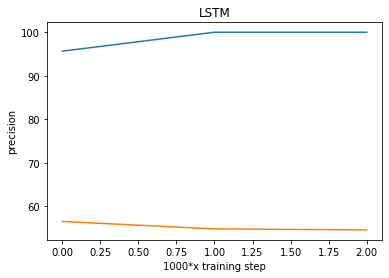

precision of the model on thevalidationdata: 56.1214485168457%
tensor([1.0000, 1.0000, 0.9987, 1.0000, 1.0000, 0.9963, 1.0000, 0.9991, 0.9991,
        0.5273, 0.5025, 0.5112, 1.0000, 1.0000, 0.9931, 0.5052, 0.5167, 0.5068,
        0.5002, 0.6013, 0.9942, 0.9984, 0.5011, 0.9982, 0.6381, 0.9942, 0.9997,
        0.9676, 0.9998, 0.5818, 0.5129, 0.5168, 0.5126, 1.0000, 1.0000, 1.0000,
        0.5088, 0.5253, 0.5096, 0.5584, 0.5451, 0.5472, 1.0000, 0.8727, 0.9927,
        0.9513, 0.7176, 0.5007, 0.9828, 1.0000, 1.0000, 0.8258, 0.9747, 0.8175,
        0.9467, 1.0000, 0.9999, 0.8344, 0.6305, 0.6958, 0.5028, 0.5026, 0.5077,
        1.0000, 0.9995, 0.9059, 0.7667, 0.7716, 0.5782, 1.0000, 1.0000, 0.9996,
        0.5076, 0.5685, 0.5480, 1.0000, 1.0000, 1.0000, 0.9999, 0.9901, 1.0000,
        0.9764, 1.0000, 0.7757, 0.6919, 0.5156, 0.5034, 1.0000, 0.9993, 1.0000,
        0.9975, 0.9999, 0.9989, 1.0000, 1.0000, 0.5347, 0.6541, 0.9380, 0.9967,
        0.9559], device='cuda:1')
current i is 67
Filter 

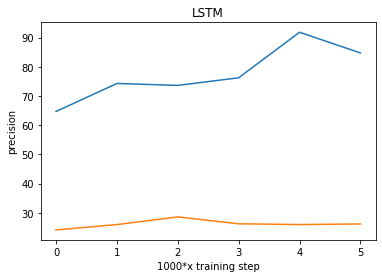

precision of the model on thevalidationdata: 26.575342178344727%
tensor([1.0000, 1.0000, 1.0000, 0.9603, 0.9033, 1.0000, 0.9992, 0.9999, 0.9981,
        1.0000, 0.9843, 0.9998, 0.5208, 1.0000, 1.0000, 0.8074, 1.0000, 0.5380,
        0.9996, 1.0000, 0.9192, 1.0000, 0.5406, 0.9884, 0.9998, 0.9999, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 0.9999, 1.0000, 0.9975, 0.6323, 0.9995,
        0.9878, 1.0000, 1.0000, 0.9950, 1.0000, 1.0000, 1.0000, 0.9994, 1.0000,
        1.0000, 0.9997, 0.9991, 1.0000, 1.0000, 1.0000, 0.6246, 0.8947, 0.7335,
        1.0000, 0.9221, 0.9054, 0.6399, 1.0000, 0.7618, 1.0000, 1.0000, 0.9537,
        1.0000, 1.0000, 0.9998, 0.9999, 1.0000, 1.0000, 0.9638, 0.6027, 1.0000,
        1.0000, 0.5654, 0.9256, 1.0000, 1.0000, 1.0000, 1.0000, 0.9992, 1.0000,
        0.7201, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 0.7286, 0.5883, 0.9122,
        1.0000, 1.0000, 1.0000, 0.5822, 1.0000, 1.0000, 1.0000, 1.0000, 0.9980,
        1.0000], device='cuda:1')
current i is 68
Filte

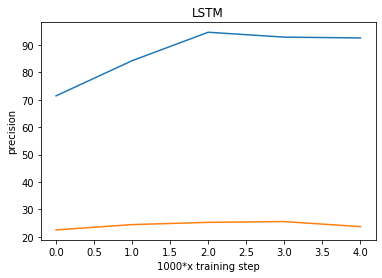

precision of the model on thevalidationdata: 23.890785217285156%
tensor([1.0000, 1.0000, 1.0000, 0.7964, 0.6509, 1.0000, 1.0000, 0.9982, 1.0000,
        0.9954, 1.0000, 0.9642, 0.5039, 0.9967, 0.9970, 0.9976, 0.8436, 0.9807,
        1.0000, 0.9972, 0.9741, 1.0000, 0.6699, 0.6130, 1.0000, 1.0000, 1.0000,
        0.5037, 0.6660, 0.9155, 0.7345, 0.9262, 0.7179, 1.0000, 0.9888, 0.9989,
        1.0000, 0.5070, 1.0000, 0.5283, 0.9995, 0.8148, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 0.9991, 1.0000, 1.0000, 0.9969, 0.9999,
        1.0000, 1.0000, 0.9949, 0.9141, 0.9110, 0.9859, 1.0000, 0.5051, 0.9994,
        1.0000, 0.9138, 0.9180, 0.9950, 0.9929, 1.0000, 0.9980, 0.9999, 1.0000,
        0.9999, 0.9916, 0.9923, 1.0000, 0.9848, 1.0000, 1.0000, 0.6940, 0.9995,
        0.6111, 0.8029, 0.5359, 0.7940, 0.9995, 0.9983, 1.0000, 1.0000, 1.0000,
        1.0000, 0.9980, 0.5038, 0.9994, 1.0000, 1.0000, 0.9935, 0.9973, 0.8237,
        1.0000], device='cuda:1')
current i is 69
Filte

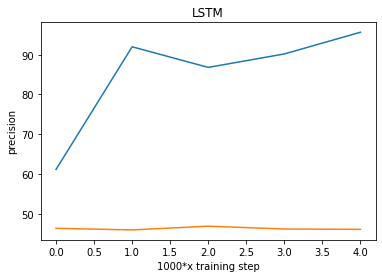

precision of the model on thevalidationdata: 46.19834899902344%
tensor([1.0000, 0.9551, 0.9999, 1.0000, 1.0000, 1.0000, 0.9995, 1.0000, 0.9954,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 0.9895, 1.0000, 1.0000, 1.0000,
        1.0000, 0.9987, 0.5528, 1.0000, 0.9729, 1.0000, 1.0000, 0.9999, 0.9807,
        0.9771, 1.0000, 1.0000, 1.0000, 1.0000, 0.7993, 1.0000, 0.6903, 0.9686,
        0.9999, 1.0000, 1.0000, 1.0000, 1.0000, 0.9724, 0.9999, 1.0000, 1.0000,
        0.8471, 0.7849, 1.0000, 1.0000, 0.9999, 1.0000, 1.0000, 0.9995, 1.0000,
        1.0000, 1.0000, 0.6050, 0.9952, 1.0000, 0.9999, 1.0000, 1.0000, 0.9504,
        1.0000, 0.9887, 0.9975, 1.0000, 0.9455, 0.9942, 1.0000, 1.0000, 0.9006,
        0.9431, 0.9743, 0.8122, 0.9970, 0.9298, 1.0000, 0.9936, 0.9999, 0.9139,
        1.0000, 0.9464, 0.9996, 1.0000, 1.0000, 1.0000, 0.9989, 0.9997, 0.9998,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 0.9908, 0.7511, 0.9897, 0.6535,
        1.0000], device='cuda:1')
current i is 70
Filter

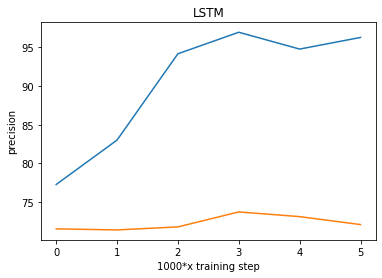

precision of the model on thevalidationdata: 72.7272720336914%
tensor([0.9998, 0.7038, 1.0000, 1.0000, 1.0000, 1.0000, 0.9999, 1.0000, 0.9757,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 0.9999, 0.8129, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 0.9999, 1.0000, 1.0000, 0.9937, 0.9908, 0.5453,
        0.9976, 1.0000, 1.0000, 0.9978, 0.9888, 0.6830, 1.0000, 0.9991, 1.0000,
        1.0000, 1.0000, 1.0000, 0.9988, 1.0000, 0.9998, 1.0000, 0.9983, 1.0000,
        1.0000, 1.0000, 1.0000, 0.9987, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        0.9990, 0.9996, 1.0000, 1.0000, 0.9999, 1.0000, 0.9768, 0.6954, 1.0000,
        0.9177, 1.0000, 1.0000, 1.0000, 0.9997, 0.8521, 0.5020, 0.9944, 0.9997,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 0.9972, 1.0000, 1.0000,
        0.9767, 0.9997, 0.9343, 1.0000, 1.0000, 0.9471, 1.0000, 1.0000, 1.0000,
        1.0000, 0.9986, 1.0000, 1.0000, 0.9317, 1.0000, 1.0000, 1.0000, 0.9997,
        1.0000], device='cuda:1')
current i is 71
Filter 

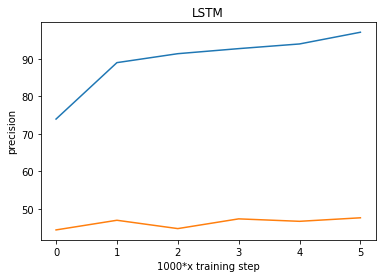

precision of the model on thevalidationdata: 46.783626556396484%
tensor([0.7459, 0.9991, 0.9966, 0.5502, 0.8138, 0.9293, 0.5787, 0.6646, 0.6219,
        0.8652, 0.8997, 0.9858, 0.5416, 0.6055, 0.6870, 0.9935, 0.9996, 0.9988,
        0.7355, 0.9707, 0.5825, 1.0000, 1.0000, 1.0000, 0.7365, 0.8107, 0.6896,
        1.0000, 0.9816, 0.9997, 0.5633, 0.5225, 0.8800, 0.8932, 0.9191, 0.5994,
        1.0000, 0.9999, 0.7932, 0.8506, 1.0000, 0.9469, 0.5045, 0.9218, 0.6751,
        0.5884, 0.6449, 0.5484, 0.5853, 0.5903, 0.5827, 0.9999, 0.9997, 0.9063,
        0.9960, 0.9741, 0.9772, 0.5588, 0.6996, 0.9392, 0.5293, 0.7119, 0.6316,
        0.9853, 0.7434, 0.9965, 0.5469, 0.9923, 0.8034, 1.0000, 0.8925, 0.9916,
        1.0000, 1.0000, 0.9999, 0.9996, 0.8538, 0.9997, 0.9884, 0.9999, 0.9771,
        0.9653, 1.0000, 0.6557, 0.6844, 0.8816, 0.5917, 0.5852, 0.5856, 0.5861,
        0.5863, 0.5875, 0.7801, 0.9983, 0.9960, 1.0000, 0.9518, 0.9703, 0.9991,
        0.9302], device='cuda:1')
current i is 72
Filte

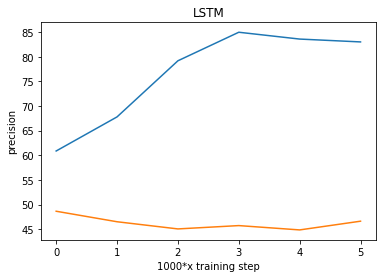

precision of the model on thevalidationdata: 45.146087646484375%
tensor([0.9999, 1.0000, 1.0000, 0.9995, 0.9854, 0.9689, 1.0000, 1.0000, 0.9976,
        1.0000, 0.9959, 1.0000, 0.9701, 0.9988, 0.9994, 0.9636, 1.0000, 0.5193,
        0.9966, 0.9670, 0.9999, 1.0000, 0.9992, 0.9905, 0.9303, 0.9969, 1.0000,
        0.9996, 0.7871, 0.9991, 1.0000, 0.8892, 1.0000, 1.0000, 1.0000, 0.9099,
        0.9985, 0.9029, 1.0000, 0.9999, 0.9999, 1.0000, 0.9997, 1.0000, 1.0000,
        0.6511, 0.5355, 0.5042, 0.9999, 1.0000, 1.0000, 0.9988, 0.7270, 0.9448,
        0.9864, 0.9998, 1.0000, 1.0000, 0.9999, 0.9999, 1.0000, 1.0000, 0.7765,
        0.9992, 0.8885, 0.9846, 0.8961, 0.9898, 1.0000, 0.8799, 0.8973, 0.9991,
        0.9897, 0.9998, 0.9820, 0.6224, 0.5563, 0.5134, 0.5858, 0.6778, 0.9214,
        0.9458, 1.0000, 0.9999, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 0.8898,
        0.9643, 1.0000, 1.0000, 0.9989, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        0.9622], device='cuda:1')
current i is 73
Filte

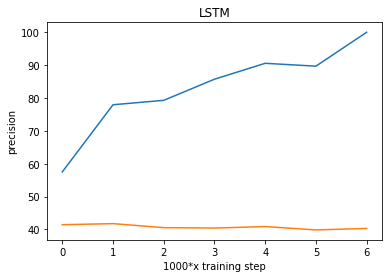

precision of the model on thevalidationdata: 40.31007766723633%
tensor([0.9920, 1.0000, 0.9998, 0.9763, 0.5182, 0.6081, 1.0000, 0.9970, 1.0000,
        1.0000, 1.0000, 0.9988, 0.9991, 0.9991, 0.5082, 0.5329, 0.9772, 1.0000,
        1.0000, 1.0000, 0.9445, 0.9159, 0.9991, 1.0000, 0.9398, 1.0000, 0.9972,
        1.0000, 0.9683, 0.9743, 0.9856, 0.6703, 0.6388, 1.0000, 0.9018, 0.9995,
        0.9998, 1.0000, 0.9713, 0.9972, 1.0000, 0.9996, 0.9999, 1.0000, 1.0000,
        1.0000, 0.7318, 0.5728, 1.0000, 1.0000, 0.7401, 0.9624, 0.9894, 0.9993,
        1.0000, 1.0000, 0.6943, 0.5543, 0.7502, 0.8914, 1.0000, 1.0000, 0.6816,
        0.5371, 0.5135, 1.0000, 1.0000, 0.9862, 0.9532, 0.9976, 0.9990, 1.0000,
        0.9989, 0.9999, 0.9920, 0.7189, 0.8184, 1.0000, 0.9652, 0.9689, 0.8233,
        1.0000, 0.9877, 0.9885, 0.5532, 0.5207, 1.0000, 0.9897, 0.5978, 0.8448,
        0.8897, 1.0000, 0.5291, 0.9051, 1.0000, 0.7700, 0.6571, 1.0000, 1.0000,
        1.0000], device='cuda:1')
current i is 74
Filter

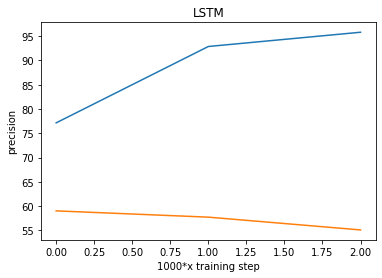

precision of the model on thevalidationdata: 57.07196044921875%
tensor([1.0000, 0.9985, 0.9849, 1.0000, 1.0000, 1.0000, 0.9996, 0.9999, 1.0000,
        1.0000, 1.0000, 1.0000, 0.9999, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 0.8918, 0.8230, 0.8666, 0.9989, 1.0000,
        0.9949, 1.0000, 0.9999, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 0.7547, 0.9503, 0.9959, 0.9577, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 0.9999, 0.9997, 0.9990, 1.0000, 0.9999, 1.0000, 0.9986, 0.9999,
        1.0000, 0.9891, 0.9999, 1.0000, 1.0000, 0.9992, 0.9751, 1.0000, 1.0000,
        0.9992, 1.0000, 1.0000, 0.9198, 1.0000, 0.9988, 1.0000, 0.9909, 1.0000,
        1.0000, 1.0000, 0.9999, 1.0000, 1.0000, 0.9192, 0.9654, 0.9999, 0.9773,
        1.0000, 1.0000, 0.9952, 1.0000, 0.8299, 0.9988, 1.0000, 0.9646, 0.9998,
        0.8714, 0.9998, 1.0000, 1.0000, 0.9999, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000], device='cuda:1')
current i is 75
Filter

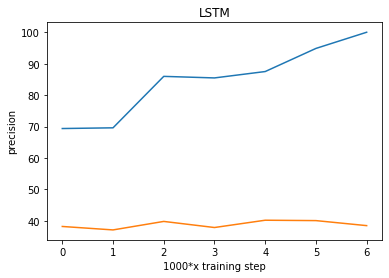

precision of the model on thevalidationdata: 38.48920822143555%
tensor([1.0000, 1.0000, 0.9146, 1.0000, 1.0000, 0.7959, 0.6130, 0.6130, 0.6129,
        0.7103, 0.9894, 0.9999, 0.6124, 0.6126, 0.6134, 0.5897, 0.5910, 0.5862,
        0.7086, 0.8511, 0.8795, 0.6109, 0.6117, 0.6148, 0.6829, 0.7185, 0.6340,
        0.7309, 0.7890, 0.7300, 0.9707, 0.9412, 0.8548, 0.9786, 0.9996, 0.9623,
        0.8150, 0.5691, 0.8023, 0.6297, 0.6194, 0.6075, 0.6129, 0.6132, 0.6132,
        0.6647, 0.5552, 0.6523, 0.8935, 0.7380, 0.5477, 0.6012, 0.5928, 0.6176,
        0.9922, 0.5754, 0.8668, 0.7053, 0.9142, 0.9868, 0.5593, 0.9287, 0.9852,
        0.5991, 0.7044, 0.6723, 0.5962, 0.7492, 0.5220, 0.5862, 0.5993, 0.6307,
        0.8653, 0.9272, 0.9790, 0.6378, 0.6374, 0.6166, 0.9999, 0.9730, 0.8445,
        0.9647, 0.7960, 0.8417, 0.6523, 0.5025, 0.5774, 0.6128, 0.6166, 0.6276,
        0.8313, 0.7807, 0.8724, 0.6543, 0.7420, 0.7539, 0.6130, 0.6130, 0.6129,
        0.6479], device='cuda:1')
current i is 76
Filter

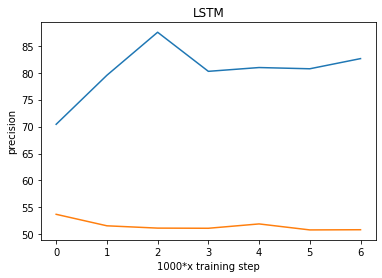

precision of the model on thevalidationdata: 50.86206817626953%
tensor([0.9999, 0.9164, 0.8991, 0.9648, 0.9981, 0.9998, 0.8656, 0.5446, 1.0000,
        1.0000, 1.0000, 0.9994, 0.8045, 1.0000, 0.8465, 1.0000, 1.0000, 1.0000,
        0.7250, 0.7568, 0.6273, 0.5985, 0.6570, 0.8824, 1.0000, 0.9903, 1.0000,
        0.5210, 0.9829, 1.0000, 0.8830, 1.0000, 0.9970, 0.9788, 0.5676, 0.9508,
        1.0000, 0.8648, 0.9782, 1.0000, 1.0000, 0.9998, 1.0000, 0.9155, 1.0000,
        0.9826, 1.0000, 1.0000, 1.0000, 0.9980, 0.9522, 1.0000, 1.0000, 0.9976,
        0.9983, 0.9998, 1.0000, 0.9399, 1.0000, 1.0000, 0.9998, 1.0000, 0.9995,
        1.0000, 0.8678, 0.9997, 0.5420, 1.0000, 0.9982, 1.0000, 0.9995, 1.0000,
        0.9992, 0.9992, 0.9991, 0.9946, 1.0000, 1.0000, 0.7815, 0.9998, 1.0000,
        0.9998, 1.0000, 1.0000, 0.5666, 0.7076, 1.0000, 0.9288, 0.9667, 0.9590,
        0.9998, 0.5617, 0.5301, 0.6104, 0.9864, 0.9994, 0.9998, 1.0000, 1.0000,
        0.6557], device='cuda:1')
current i is 77
Filter

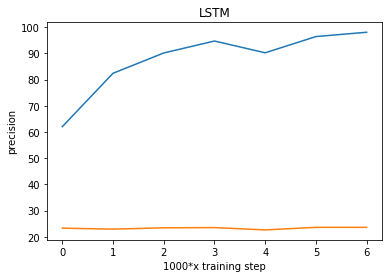

precision of the model on thevalidationdata: 22.381929397583008%
tensor([1.0000, 1.0000, 0.9900, 0.8210, 0.9999, 1.0000, 0.5353, 1.0000, 1.0000,
        0.9886, 0.5262, 1.0000, 0.9897, 1.0000, 0.7025, 1.0000, 1.0000, 0.9999,
        0.9999, 1.0000, 1.0000, 1.0000, 0.5307, 0.8013, 1.0000, 0.7290, 0.5457,
        0.9998, 1.0000, 1.0000, 0.7134, 1.0000, 0.5980, 0.9881, 0.8969, 1.0000,
        1.0000, 0.7011, 0.5034, 1.0000, 0.9633, 1.0000, 0.9664, 0.9819, 1.0000,
        1.0000, 0.9503, 1.0000, 0.9947, 0.9999, 0.6705, 0.6554, 0.5260, 0.5188,
        0.5260, 0.8679, 1.0000, 1.0000, 1.0000, 1.0000, 0.9997, 1.0000, 0.9976,
        0.9996, 0.9205, 0.5543, 1.0000, 1.0000, 0.5261, 0.5254, 0.9943, 1.0000,
        0.8416, 1.0000, 1.0000, 0.9986, 1.0000, 0.5403, 1.0000, 0.5325, 1.0000,
        0.6003, 0.8370, 1.0000, 0.8707, 1.0000, 0.9926, 0.5899, 0.9997, 0.5316,
        1.0000, 0.8716, 0.9276, 0.9903, 0.9128, 0.9987, 0.5257, 1.0000, 1.0000,
        0.9997], device='cuda:1')
current i is 78
Filte

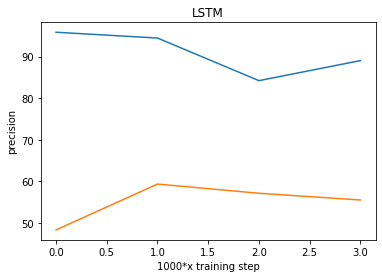

precision of the model on thevalidationdata: 54.90196228027344%
tensor([0.9985, 0.9999, 0.9650, 0.9974, 0.9999, 0.9998, 0.5151, 0.5028, 0.9730,
        0.5080, 0.5089, 0.8493, 0.5180, 0.5136, 0.8671, 0.6957, 0.5341, 0.5144,
        0.5227, 0.5038, 0.9316, 1.0000, 0.9963, 0.9983, 0.9836, 0.9996, 0.9839,
        0.5148, 0.5153, 0.9895, 0.5146, 0.5152, 0.8963, 0.9711, 0.8031, 0.8318,
        0.9999, 0.9900, 0.9960, 0.5342, 0.5121, 0.6119, 0.5144, 0.5140, 0.9701,
        0.5140, 0.5133, 0.5160, 0.5679, 0.8006, 0.7831, 0.7458, 0.8633, 0.5290,
        0.5001, 0.5071, 0.9898, 0.5063, 0.5136, 0.9770, 0.9998, 0.9937, 0.9490,
        0.5130, 0.5182, 0.7519, 0.9970, 0.9919, 0.8962, 0.5215, 0.6104, 0.5515,
        0.5309, 0.5143, 0.9944, 0.5145, 0.5145, 0.5145, 1.0000, 0.9991, 1.0000,
        0.5145, 0.5145, 0.6066, 0.7188, 0.9534, 0.8239, 0.5165, 0.5925, 0.5125,
        0.9989, 0.9985, 0.7922, 0.5145, 0.5146, 0.9848, 0.5145, 0.5245, 0.9908,
        0.6237], device='cuda:1')
current i is 80
Filter

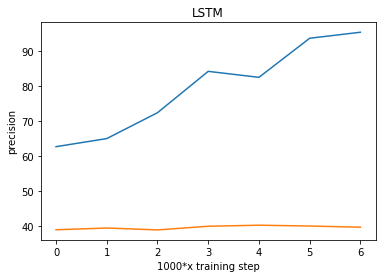

precision of the model on thevalidationdata: 39.913230895996094%
tensor([1.0000, 1.0000, 1.0000, 0.9077, 1.0000, 1.0000, 1.0000, 1.0000, 0.9728,
        0.9999, 1.0000, 0.9999, 0.9489, 1.0000, 1.0000, 0.9775, 0.9822, 0.7486,
        1.0000, 1.0000, 0.9999, 1.0000, 0.7763, 1.0000, 0.9591, 0.9984, 0.9999,
        1.0000, 1.0000, 1.0000, 0.8236, 0.9725, 0.9975, 1.0000, 0.9996, 1.0000,
        1.0000, 0.8442, 1.0000, 0.9995, 0.9994, 0.9996, 0.9995, 0.9814, 1.0000,
        0.9997, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 0.6672, 0.9988, 0.9991,
        1.0000, 1.0000, 0.9999, 1.0000, 0.9618, 0.6857, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 0.9882, 0.9560, 0.7646, 1.0000, 1.0000, 1.0000,
        0.9995, 0.9999, 1.0000, 0.9353, 0.9996, 0.9975, 0.9785, 1.0000, 0.9746,
        0.8464, 0.9999, 1.0000, 1.0000, 0.8398, 0.9943, 1.0000, 0.9998, 0.9999,
        0.9941, 1.0000, 0.8232, 1.0000, 1.0000, 0.9964, 1.0000, 0.9539, 0.5706,
        1.0000], device='cuda:1')
current i is 81
Filte

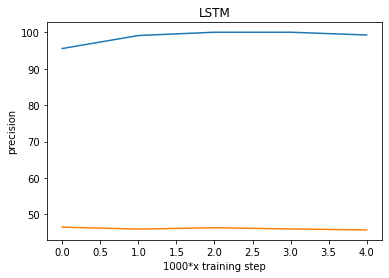

precision of the model on thevalidationdata: 45.4454460144043%
tensor([0.9988, 0.9895, 1.0000, 0.9861, 1.0000, 0.9876, 1.0000, 0.9996, 0.9994,
        0.5512, 0.9961, 1.0000, 0.9976, 0.5159, 0.8145, 0.6037, 0.8242, 0.5828,
        0.9999, 1.0000, 0.6117, 0.9999, 1.0000, 0.8296, 1.0000, 1.0000, 1.0000,
        0.9982, 0.9860, 0.9999, 0.8534, 0.9851, 0.9387, 0.9995, 0.9374, 0.6792,
        0.9993, 1.0000, 0.9984, 0.9925, 0.9858, 0.9928, 0.9831, 0.9958, 0.8791,
        0.9430, 0.9991, 0.8079, 0.7762, 0.8827, 0.5288, 0.9666, 0.9986, 0.8544,
        0.9788, 0.9997, 0.8934, 1.0000, 0.9959, 0.9912, 0.9985, 0.8264, 0.9308,
        0.9535, 0.9920, 0.9865, 0.9727, 0.9532, 0.9919, 0.8317, 0.6495, 0.7386,
        0.9999, 0.9988, 0.9702, 0.9572, 0.8323, 0.9999, 0.8224, 0.9993, 0.7234,
        0.9955, 1.0000, 0.6195, 0.8298, 0.5454, 0.9999, 0.9642, 0.9539, 0.8789,
        0.9933, 0.9974, 0.5299, 1.0000, 0.9822, 0.9926, 0.9926, 0.9054, 1.0000,
        0.9875], device='cuda:1')
current i is 83
Filter 

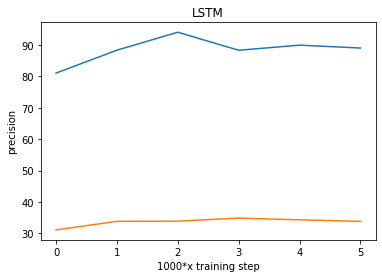

precision of the model on thevalidationdata: 32.39910125732422%
tensor([0.6441, 0.6002, 0.6160, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 0.8926,
        0.9975, 0.9663, 0.9619, 1.0000, 1.0000, 1.0000, 0.9858, 1.0000, 0.5665,
        0.5280, 0.5926, 1.0000, 0.9928, 0.9943, 0.5876, 0.9965, 0.9989, 0.6215,
        0.9608, 0.9995, 0.8862, 0.9698, 0.8137, 0.9999, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 0.9272, 0.9977, 1.0000, 1.0000, 1.0000, 0.9401, 1.0000,
        1.0000, 1.0000, 1.0000, 0.9995, 1.0000, 0.5036, 1.0000, 1.0000, 0.9557,
        0.8781, 0.5494, 0.8493, 0.9050, 0.9408, 0.5318, 0.5909, 0.5254, 0.5254,
        1.0000, 0.9862, 0.9993, 0.9891, 0.9990, 0.5872, 1.0000, 0.9651, 0.9809,
        0.5832, 0.5272, 0.6042, 1.0000, 1.0000, 0.9915, 0.6442, 0.5405, 0.6129,
        1.0000, 1.0000, 0.9766, 0.6250, 0.6530, 0.5730, 0.7475, 0.9363, 0.9864,
        0.5157, 0.6055, 0.8238, 0.7106, 0.5653, 0.6903, 1.0000, 0.9980, 0.5253,
        0.5411], device='cuda:1')
current i is 84
Filter

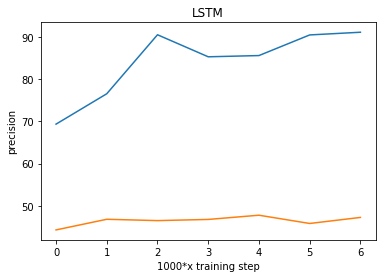

precision of the model on thevalidationdata: 45.77586364746094%
tensor([0.9718, 0.9998, 0.9998, 1.0000, 0.9948, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 0.9937, 0.9829, 0.9939, 1.0000, 1.0000, 0.9622, 0.9999,
        0.9993, 1.0000, 1.0000, 0.9994, 0.9964, 0.9954, 1.0000, 1.0000, 1.0000,
        0.6193, 0.5584, 0.5061, 1.0000, 1.0000, 1.0000, 0.6127, 0.7642, 1.0000,
        0.8132, 0.8759, 0.9475, 0.8074, 1.0000, 1.0000, 1.0000, 0.9989, 1.0000,
        0.9072, 0.9859, 0.6997, 0.9999, 1.0000, 1.0000, 1.0000, 0.5607, 0.9106,
        1.0000, 1.0000, 0.8119, 1.0000, 0.5244, 0.9993, 0.9997, 1.0000, 0.9997,
        1.0000, 0.9060, 0.9967, 0.5621, 0.6624, 0.7727, 0.9999, 1.0000, 0.9912,
        0.5065, 0.5983, 0.5489, 0.9998, 0.6811, 1.0000, 0.9162, 1.0000, 0.9987,
        0.5274, 1.0000, 1.0000, 0.9655, 0.9258, 1.0000, 0.9987, 1.0000, 1.0000,
        1.0000, 0.9493, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 0.9994, 1.0000,
        0.9266], device='cuda:1')
current i is 85
Filter

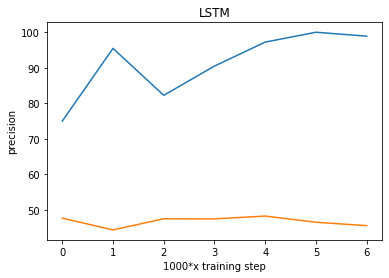

precision of the model on thevalidationdata: 46.84260177612305%
tensor([1.0000, 1.0000, 0.9997, 0.5296, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        0.8782, 0.9616, 0.5064, 0.9959, 0.7766, 0.6038, 0.5041, 0.5058, 0.5077,
        1.0000, 1.0000, 0.7072, 0.5184, 0.5899, 0.6170, 1.0000, 1.0000, 0.9999,
        0.9999, 1.0000, 0.7363, 0.7019, 0.6671, 1.0000, 0.6229, 0.6581, 0.5532,
        0.9951, 0.9932, 0.5570, 1.0000, 1.0000, 0.9695, 0.5129, 0.5045, 0.5626,
        0.8340, 0.9656, 0.5549, 0.9265, 1.0000, 0.9972, 0.9997, 0.9964, 1.0000,
        0.9527, 0.7191, 0.5321, 0.9999, 0.9846, 0.7637, 0.5076, 0.5068, 0.5090,
        0.5251, 0.5054, 0.5042, 1.0000, 0.9958, 0.9142, 0.8806, 0.9544, 0.5473,
        1.0000, 0.9505, 0.9396, 0.5109, 0.7720, 0.8823, 0.9765, 1.0000, 0.9944,
        0.9642, 0.9983, 1.0000, 1.0000, 0.9605, 0.5475, 1.0000, 0.9854, 0.6284,
        0.5128, 0.5223, 0.5366, 0.6404, 0.5501, 0.5087, 1.0000, 0.8353, 0.6660,
        0.9804], device='cuda:1')
current i is 86
Filter

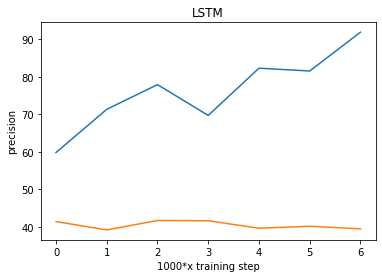

precision of the model on thevalidationdata: 38.38862609863281%
tensor([1.0000, 0.9999, 0.9988, 0.9669, 0.9792, 0.9865, 1.0000, 0.9959, 0.6420,
        0.9917, 1.0000, 1.0000, 0.9996, 0.9997, 0.9601, 1.0000, 1.0000, 1.0000,
        0.5244, 0.9548, 0.5615, 0.9987, 0.9982, 0.9968, 0.7765, 0.6031, 0.6747,
        0.9971, 0.9429, 1.0000, 0.6366, 0.5304, 0.6643, 0.8009, 0.8902, 0.9791,
        0.8094, 0.7045, 1.0000, 0.9996, 1.0000, 0.9996, 1.0000, 1.0000, 0.5440,
        0.5440, 0.5174, 0.5747, 0.9628, 1.0000, 0.7603, 0.6147, 0.9655, 0.9990,
        0.5985, 0.7524, 0.9988, 1.0000, 1.0000, 0.9935, 0.8991, 0.7500, 0.9979,
        1.0000, 0.5422, 0.5115, 0.9228, 0.9602, 1.0000, 1.0000, 0.8645, 0.5776,
        0.6237, 0.9565, 0.8916, 1.0000, 0.9969, 1.0000, 0.9990, 0.9856, 0.7955,
        0.5268, 0.9329, 0.6650, 0.9988, 1.0000, 0.9999, 1.0000, 0.5569, 0.9934,
        1.0000, 0.8717, 0.9957, 0.9384, 0.6560, 0.6063, 0.9648, 1.0000, 1.0000,
        1.0000], device='cuda:1')
current i is 87
Filter

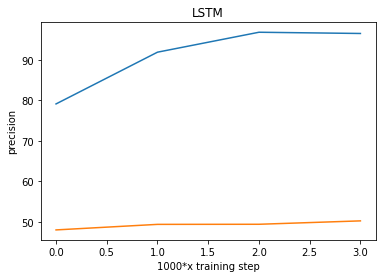

precision of the model on thevalidationdata: 52.06766891479492%
tensor([0.9318, 1.0000, 0.5094, 0.8769, 1.0000, 0.5595, 0.5837, 0.5075, 0.8984,
        0.5896, 1.0000, 1.0000, 1.0000, 1.0000, 0.9966, 0.9111, 0.9999, 1.0000,
        0.5051, 0.9290, 0.7833, 0.9053, 1.0000, 0.9999, 0.9928, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 0.9998, 1.0000, 0.8078, 1.0000, 1.0000,
        0.5152, 0.9990, 0.8062, 0.8306, 0.7295, 0.8202, 0.9999, 0.9452, 0.9982,
        1.0000, 0.5488, 1.0000, 0.7794, 0.7050, 0.9670, 1.0000, 0.9960, 0.9998,
        0.5235, 0.9996, 0.9995, 0.9381, 0.5977, 0.5758, 0.5633, 0.5649, 0.5874,
        0.5896, 0.6141, 0.6399, 1.0000, 0.9999, 0.9992, 0.7122, 1.0000, 0.9993,
        0.7118, 0.7072, 1.0000, 0.9886, 1.0000, 0.9498, 0.7394, 0.9931, 0.6377,
        0.5541, 0.9585, 1.0000, 0.8147, 0.8087, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 0.9993, 1.0000, 0.8188, 0.9935, 0.5899, 1.0000, 1.0000, 0.5014,
        0.7632], device='cuda:1')
current i is 88
Filter

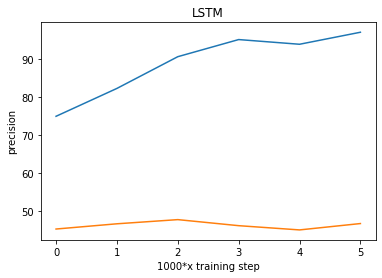

precision of the model on thevalidationdata: 46.264854431152344%
tensor([1.0000, 1.0000, 0.6706, 0.9997, 0.8089, 0.9997, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 0.9939, 0.9948, 1.0000, 1.0000, 0.8287,
        1.0000, 0.9150, 0.7560, 0.9978, 0.9898, 0.9999, 0.7335, 0.9232, 0.9999,
        0.8935, 0.6213, 1.0000, 0.6306, 1.0000, 1.0000, 1.0000, 0.6323, 1.0000,
        0.6004, 0.6660, 0.6812, 0.9999, 0.9999, 1.0000, 0.9997, 0.7714, 0.9999,
        1.0000, 1.0000, 0.7697, 0.9944, 0.9724, 0.9998, 1.0000, 0.9950, 0.9950,
        1.0000, 1.0000, 0.9988, 1.0000, 1.0000, 0.9991, 1.0000, 0.9998, 0.9878,
        0.9949, 0.9959, 1.0000, 0.8032, 0.7042, 0.5164, 0.9988, 0.8693, 0.9983,
        0.9822, 0.5856, 0.9875, 0.9471, 0.9480, 0.5911, 1.0000, 0.9991, 1.0000,
        0.9738, 0.9287, 1.0000, 0.9979, 1.0000, 0.5694, 0.5384, 0.5242, 0.6159,
        0.9907, 0.8043, 0.7799, 1.0000, 1.0000, 0.6738, 0.5352, 1.0000, 0.9901,
        0.9998], device='cuda:1')
current i is 89
Filte

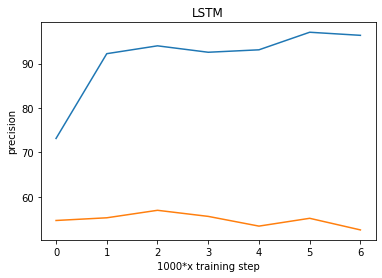

precision of the model on thevalidationdata: 52.18254089355469%
tensor([0.9967, 0.8896, 0.9744, 0.9931, 0.9944, 0.9999, 1.0000, 1.0000, 0.9985,
        0.7687, 0.6792, 0.5574, 0.5291, 0.5323, 0.5365, 0.9678, 0.5261, 0.5260,
        0.8744, 0.5296, 0.6362, 0.8681, 0.9955, 1.0000, 0.8807, 1.0000, 0.9976,
        0.9990, 0.9940, 0.9731, 0.5608, 0.7267, 0.5248, 0.9984, 1.0000, 1.0000,
        0.5264, 0.5268, 0.5273, 0.5315, 0.5316, 0.6011, 0.5262, 0.5255, 0.5262,
        0.9992, 0.6252, 0.5086, 0.9945, 0.6654, 0.6147, 0.9909, 0.8030, 0.6532,
        0.5230, 0.5852, 0.5236, 0.8388, 0.7291, 0.9997, 0.9914, 1.0000, 1.0000,
        1.0000, 1.0000, 0.9999, 0.7359, 0.8948, 0.9864, 0.7029, 0.8499, 0.9996,
        1.0000, 0.7713, 0.9449, 1.0000, 0.9962, 0.8302, 0.5462, 0.5063, 0.5460,
        0.7133, 0.9999, 0.9977, 1.0000, 0.9999, 1.0000, 0.5460, 0.6876, 0.5549,
        0.5430, 0.7533, 0.5300, 0.5332, 0.5545, 0.6066, 0.5339, 0.5278, 0.5270,
        0.5382], device='cuda:1')


In [50]:
result = LSTM_rolling_window(df_train_dict, df_valid_dict)

In [51]:
def transform_dict_to_df(result):
    result_df_dict={}
    for i in result.keys():
        valid_index_list, score, predicted, train_label_list = result[str(i)]
        first = np.array(valid_index_list)[:,0].reshape(-1,)
        second = np.array(valid_index_list)[:,1].reshape(-1,)
        third = score.cpu().reshape(-1,1).reshape(-1,)
        fourth = train_label_list.reshape(-1,)
        fifth = predicted.reshape(-1,) 
        third = np.array(third)
        fifth = np.array(fifth.cpu())
        data = np.array([first,second,third,fourth,fifth])
        data = np.transpose(data, (1,0))
        result_df_dict[str(i)] = pd.DataFrame(data=data, columns=['date','index','score','label','prediction'])
    return result_df_dict

In [55]:
result_df_dict = transform_dict_to_df(result)

In [53]:
def pre_processing(result_df_dict):
    processed = {}
    for i in result_df_dict.keys():
        print(i)
        df = result_df_dict[str(i)]
        df['prediction'] = df['prediction'].astype('float64')
        df['label'] = df['label'].astype('float64')
        df['score'] = df['score'].astype('float64')
        idx = df[df['prediction']==0].index
        df.loc[idx,'score'] = 1-df.loc[idx,'score']
        print(df)
        processed[str(i)] = df
    return processed

In [54]:
processed = pre_processing(result_df_dict)

1
            date      index         score  label  prediction
0     2013-03-14  000001.SZ  2.754000e-05    1.0         0.0
1     2013-03-15  000001.SZ  7.909470e-01    0.0         1.0
2     2013-03-18  000001.SZ  1.956366e-01    0.0         0.0
3     2013-03-14  000002.SZ  9.999962e-01    0.0         1.0
4     2013-03-15  000002.SZ  1.300000e-06    1.0         0.0
...          ...        ...           ...    ...         ...
1833  2013-03-15  603077.SH  1.000000e-07    0.0         0.0
1834  2013-03-18  603077.SH  0.000000e+00    0.0         0.0
1835  2013-03-14  603766.SH  9.999375e-01    1.0         1.0
1836  2013-03-15  603766.SH  9.999866e-01    0.0         1.0
1837  2013-03-18  603766.SH  9.999999e-01    1.0         1.0

[1838 rows x 5 columns]
2
           date      index     score  label  prediction
0    2013-04-15  000001.SZ  0.999874    0.0         1.0
1    2013-04-15  000002.SZ  1.000000    1.0         1.0
2    2013-04-15  000008.SZ  0.969898    0.0         1.0
3    2013-04-15

            date      index     score  label  prediction
0     2014-04-11  000001.SZ  0.009801    0.0         0.0
1     2014-04-14  000001.SZ  0.010612    0.0         0.0
2     2014-04-11  000002.SZ  0.997454    0.0         1.0
3     2014-04-14  000002.SZ  0.000183    0.0         0.0
4     2014-04-11  000008.SZ  0.998524    0.0         1.0
...          ...        ...       ...    ...         ...
1154  2014-04-14  603077.SH  0.396513    0.0         0.0
1155  2014-04-11  603766.SH  0.002447    0.0         0.0
1156  2014-04-14  603766.SH  0.105705    1.0         0.0
1157  2014-04-11  603993.SH  0.000087    1.0         0.0
1158  2014-04-14  603993.SH  0.474390    1.0         0.0

[1159 rows x 5 columns]
16
           date      index     score  label  prediction
0    2014-05-12  000001.SZ  0.999947    0.0         1.0
1    2014-05-12  000002.SZ  0.999751    1.0         1.0
2    2014-05-12  000009.SZ  0.126518    0.0         0.0
3    2014-05-12  000012.SZ  1.000000    0.0         1.0
4    201

            date      index     score  label  prediction
0     2015-03-12  000001.SZ  0.999999    1.0         1.0
1     2015-03-13  000001.SZ  0.018166    1.0         0.0
2     2015-03-16  000001.SZ  0.999984    0.0         1.0
3     2015-03-12  000002.SZ  0.000026    0.0         0.0
4     2015-03-13  000002.SZ  0.916893    0.0         1.0
...          ...        ...       ...    ...         ...
1685  2015-03-13  603766.SH  0.703511    1.0         1.0
1686  2015-03-16  603766.SH  0.551131    1.0         1.0
1687  2015-03-12  603993.SH  0.939846    1.0         1.0
1688  2015-03-13  603993.SH  0.988946    1.0         1.0
1689  2015-03-16  603993.SH  0.025750    0.0         0.0

[1690 rows x 5 columns]
28
            date      index     score  label  prediction
0     2015-04-10  000001.SZ  0.411882    0.0         0.0
1     2015-04-13  000001.SZ  0.405482    0.0         0.0
2     2015-04-10  000002.SZ  0.998933    0.0         1.0
3     2015-04-13  000002.SZ  0.998462    0.0         1.0
4  

            date      index     score  label  prediction
0     2016-04-08  000001.SZ  0.999997    1.0         1.0
1     2016-04-11  000001.SZ  0.999032    0.0         1.0
2     2016-04-08  000008.SZ  0.342018    0.0         0.0
3     2016-04-11  000008.SZ  0.983457    0.0         1.0
4     2016-04-08  000009.SZ  0.305787    0.0         0.0
...          ...        ...       ...    ...         ...
1181  2016-04-11  603899.SH  0.994772    0.0         1.0
1182  2016-04-08  603939.SH  0.400424    1.0         0.0
1183  2016-04-11  603939.SH  0.425729    0.0         0.0
1184  2016-04-08  603993.SH  0.660588    0.0         1.0
1185  2016-04-11  603993.SH  0.916502    0.0         1.0

[1186 rows x 5 columns]
42
            date      index         score  label  prediction
0     2016-05-06  000001.SZ  8.403317e-01    1.0         1.0
1     2016-05-09  000001.SZ  7.000000e-07    0.0         0.0
2     2016-05-06  000008.SZ  9.997761e-01    1.0         1.0
3     2016-05-09  000008.SZ  6.954499e-01   

            date      index     score  label  prediction
0     2017-05-05  000001.SZ  1.000000    0.0         1.0
1     2017-05-08  000001.SZ  1.000000    1.0         1.0
2     2017-05-05  000002.SZ  0.000032    0.0         0.0
3     2017-05-08  000002.SZ  0.999640    1.0         1.0
4     2017-05-05  000008.SZ  0.000116    0.0         0.0
...          ...        ...       ...    ...         ...
1287  2017-05-08  603939.SH  0.548854    1.0         1.0
1288  2017-05-05  603986.SH  0.071334    1.0         0.0
1289  2017-05-08  603986.SH  0.999654    1.0         1.0
1290  2017-05-05  603993.SH  0.936448    1.0         1.0
1291  2017-05-08  603993.SH  0.000016    1.0         0.0

[1292 rows x 5 columns]
56
           date      index     score  label  prediction
0    2017-06-05  000001.SZ  0.446523    0.0         0.0
1    2017-06-05  000002.SZ  0.530323    0.0         1.0
2    2017-06-05  000008.SZ  0.059606    0.0         0.0
3    2017-06-05  000009.SZ  0.987052    0.0         1.0
4    201

           date      index     score  label  prediction
0    2018-04-09  000001.SZ  1.000000    1.0         1.0
1    2018-04-09  000002.SZ  0.000000    0.0         0.0
2    2018-04-09  000008.SZ  0.999999    0.0         1.0
3    2018-04-09  000009.SZ  0.039701    0.0         0.0
4    2018-04-09  000012.SZ  0.903295    0.0         1.0
..          ...        ...       ...    ...         ...
689  2018-04-09  603888.SH  0.000086    0.0         0.0
690  2018-04-09  603899.SH  0.689752    1.0         1.0
691  2018-04-09  603939.SH  1.000000    0.0         1.0
692  2018-04-09  603986.SH  0.002710    0.0         0.0
693  2018-04-09  603993.SH  0.000011    1.0         0.0

[694 rows x 5 columns]
68
           date      index         score  label  prediction
0    2018-05-07  000001.SZ  1.000000e+00    1.0         1.0
1    2018-05-07  000002.SZ  1.000000e+00    1.0         1.0
2    2018-05-07  000009.SZ  1.000000e-07    1.0         0.0
3    2018-05-07  000012.SZ  2.036496e-01    0.0         0.0
4

            date      index     score  label  prediction
0     2019-04-04  000001.SZ  1.000000    1.0         1.0
1     2019-04-08  000001.SZ  1.000000    0.0         1.0
2     2019-04-04  000002.SZ  0.999998    0.0         1.0
3     2019-04-08  000002.SZ  0.907735    1.0         1.0
4     2019-04-04  000008.SZ  1.000000    0.0         1.0
...          ...        ...       ...    ...         ...
1504  2019-04-08  603899.SH  0.342911    0.0         0.0
1505  2019-04-04  603939.SH  0.000005    0.0         0.0
1506  2019-04-08  603939.SH  0.224703    1.0         0.0
1507  2019-04-04  603993.SH  1.000000    1.0         1.0
1508  2019-04-08  603993.SH  0.000043    0.0         0.0

[1509 rows x 5 columns]
82
            date      index         score  label  prediction
0     2019-05-30  000001.SZ  9.987755e-01    1.0         1.0
1     2019-05-31  000001.SZ  1.052624e-02    0.0         0.0
2     2019-06-03  000001.SZ  2.400000e-07    1.0         0.0
3     2019-05-30  000002.SZ  1.390845e-02   

In [56]:
def sort_top_k(result_df_dict,k):
    top_k_df={}
    for i in result_df_dict.keys():
        #print(i)
        temp = result_df_dict[str(i)].sort_values('score', axis=0, ascending=False).groupby(by = 'date').head(k)
        #print(temp)
        top_k_df[str(i)] = temp
    return top_k_df

In [57]:
def precision_top_k(head):
    pre=[]
    for i in head.keys():
        pre.append(sum(head[str(i)]['label']*head[str(i)]['prediction'])/sum(head[str(i)]['prediction']))
    return pre

In [58]:
def mult_k(processed,k):
    pre_dict={}
    for i in k:
        print(i)
        head = sort_top_k(processed,i)
        pre_dict[str(i)]=precision_top_k(head)
    for i in k:
        plt.plot(pre_dict[str(i)],label='top'+str(i))
        plt.legend()
    plt.ylabel('precision')
    plt.show()
    return pre_dict

10
20
40
80
160


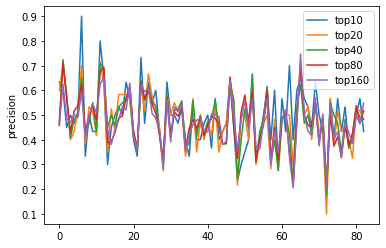

In [59]:
precision_diction = mult_k(processed,[10,20,40,80,160])

In [60]:
for i in precision_diction.keys():
    print('top'+str(i),'mean precision:',sum(precision_diction[str(i)])/len(precision_diction[str(i)]))

top10 mean precision: 0.4895582329317268
top20 mean precision: 0.47901606425702803
top40 mean precision: 0.48002008032128507
top80 mean precision: 0.47531967492611954
top160 mean precision: 0.4719830680779509


In [61]:
from classification_models import BasicBlock
from classification_models import ResNet1D_LSTM

In [64]:
def unroll_data(join_df, gap_day, roll_day, debug=False):
    # 把前后时间差距大的地方切开
    start = time.time()
    
    all_dfs = []
    
    for code, grp in join_df.groupby('stock_code'):
        grp = grp.sort_index()
        split_point = [0]
        for i in range(len(grp.index) - 1):
            if type(grp.index[i][0]) == str:
                current_day = datetime.strptime(grp.index[i+1][0], '%Y-%m-%d')
                pre_day = datetime.strptime(grp.index[i][0], '%Y-%m-%d')
                gap = (current_day - pre_day).days
            else:
                gap = grp.index[i+1][0] - grp.index[i][0]
            if gap > gap_day:
                if debug:
                    print(grp.index[i+1][0])
                    print(grp.index[i][0])
                    print(gap)
                split_point.append(i+1)
        split_point.append(len(grp.index))
    
        for i in range(len(split_point) - 1):
            if split_point[i+1] - split_point[i] > roll_day:
                all_dfs.append(grp.iloc[split_point[i]:split_point[i+1]])
    time_spend = time.time() - start
    print('Filter large gap...\nTime: %.3f'%(time_spend))
    
        # 把数据展开成sequence
    data_list = []
    label_list = []
    index_list = []

    start = time.time()

    for df in all_dfs:
        grp_data = df.sort_index()
        data_fetch = []
        label_fetch = []
        index = []

        for i in range(grp_data.shape[0] - roll_day):
            data_fetch.append(list(range(i, i + roll_day)))
            label_fetch.append(i + roll_day)
            index.append(grp_data.index[i + roll_day])        

        data_fetch = np.array(data_fetch)
        label_fetch = np.array(label_fetch)

        data = np.take(grp_data.values[:, :-1], data_fetch, axis=0)
        #print(data.shape)
        data = np.transpose(data,(0,2,1))
        label = np.take(grp_data.values[:,-1], label_fetch, axis=0)

        index_list = index_list + index
        data_list.append(data)
        label_list.append(label)
    #print(data_list)
    if len(data_list) != 0:
        data_list = np.concatenate(data_list, axis=0)
        label_list = np.concatenate(label_list, axis=0)

    print('Unrolling Data...\nTime: %.3f s'%(time.time() - start))
    
    return index_list, data_list, label_list

In [65]:
def ResNet1D_LSTM_rolling_window(df_train_dict, df_valid_dict):
    softmax = nn.Softmax(-1)
    result = {}
    for i in range(1, len(df_train_dict)):
        print("current i is",i)
        temp_df = df_train_dict[str(i)].set_index(['trade_date', 'stock_code'])
        train_index_list, train_data_list, train_label_list = unroll_data(temp_df, 100, 8, debug=False)

        temp_df = df_valid_dict[str(i)].set_index(['trade_date', 'stock_code'])        
        valid_index_list, valid_data_list, valid_label_list = unroll_data(temp_df, 100, 8, debug=False)    
        if len(valid_data_list) == 0:
            continue
        train_index_list, train_data_list, train_label_list = nan_dele(train_index_list, train_data_list, train_label_list)
        valid_index_list, valid_data_list, valid_label_list = nan_dele(valid_index_list, valid_data_list, valid_label_list)
        print(train_data_list.shape, valid_data_list.shape)

        sequence_length = 10  # 序列长度，将图像的每一列作为一个序列
        feature_channel=42
        hidden_size = 256  # 隐藏层的size
        num_layers =  3 # 有多少层
        num_classes = 2
        batch_size = 256
        num_epochs = 200
        learning_rate = 0.001
        device = torch.device("cuda:1")
        
        train_loader, valid_loader = load_data(
            train_index_list, train_data_list, train_label_list,valid_index_list, valid_data_list, valid_label_list, batch_size)
        
        lstm = ResNet1D_LSTM(BasicBlock, [1,2,1], num_classes=num_classes, feature_channel=feature_channel,
                        hidden_size=hidden_size,num_layers=num_layers,device = torch.device("cuda:1"))
        lstm.to(device)
        # Loss and Optimizer
        loss_function = nn.CrossEntropyLoss()
        optimizer = torch.optim.Adam(lstm.parameters(), lr=learning_rate)

        _, _, model = training(lstm, num_epochs, train_loader,valid_loader, loss_function, optimizer, device, softmax)
        
        for _, images, labels in valid_loader:
            num,valid_pre, predicted=predict_precision(model,images,labels,device,predict_type='validation',softmax=softmax)
        #num = softmax(num)
        print(num[0:100])
        result[str(i)] = valid_index_list, num, predicted, valid_label_list
    
    return result

current i is 1
Filter large gap...
Time: 3.535
Unrolling Data...
Time: 2.335 s
Filter large gap...
Time: 3.242
Unrolling Data...
Time: 2.158 s
(4274, 42, 8) (1838, 42, 8)
precision of the model on thetrainingdata: 85.56700897216797%
precision of the model on thevalidationdata: 51.76678466796875%
precision of the model on thetrainingdata: 94.59459686279297%
precision of the model on thevalidationdata: 49.19236373901367%
precision of the model on thetrainingdata: 95.32710266113281%
precision of the model on thevalidationdata: 49.00284957885742%


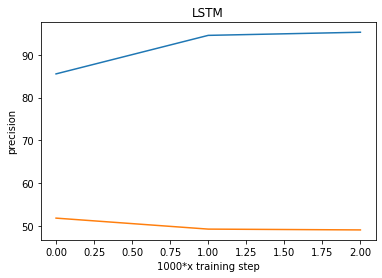

precision of the model on thevalidationdata: 48.724178314208984%
tensor([0.9992, 0.9971, 0.9565, 1.0000, 0.9993, 0.9999, 0.9709, 0.7945, 0.9717,
        0.9984, 0.9996, 0.9685, 0.5345, 0.5828, 0.5060, 0.9996, 0.7202, 0.9983,
        0.9977, 0.7027, 0.9977, 0.7905, 0.9789, 0.9924, 0.9721, 0.6285, 0.9803,
        0.5478, 0.9964, 0.6141, 0.9611, 0.9885, 0.9374, 0.5907, 0.6051, 0.5319,
        0.9583, 0.7195, 0.9993, 0.6646, 0.9776, 0.6794, 0.9943, 0.7018, 0.9659,
        0.8767, 0.9993, 0.8892, 0.9931, 0.9986, 0.9974, 0.9670, 0.9962, 0.9524,
        0.9855, 0.9985, 0.9935, 0.9993, 0.9994, 0.9285, 0.9709, 0.9998, 0.8624,
        0.9807, 0.9997, 1.0000, 0.9997, 0.9974, 0.9988, 0.9999, 0.9757, 0.9927,
        0.9866, 0.8633, 0.9930, 0.9893, 0.9969, 0.9988, 0.9019, 0.9990, 0.7275,
        0.7300, 0.7117, 0.6301, 0.9983, 0.9982, 0.9942, 0.8158, 0.5742, 0.8671,
        0.5197, 0.9706, 0.5553, 0.8568, 0.7732, 0.6418, 0.5135, 0.6136, 0.7747,
        0.9679], device='cuda:1')
current i is 2
Filter

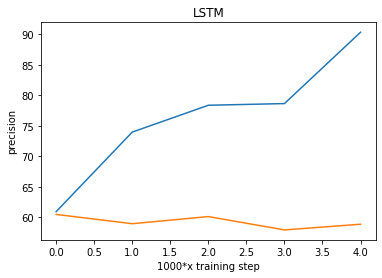

precision of the model on thevalidationdata: 60.63218307495117%
tensor([0.9341, 0.9997, 0.9981, 0.6943, 0.9299, 0.6126, 0.5491, 0.8424, 0.8934,
        0.9646, 0.9460, 0.7441, 0.9854, 0.7365, 0.9637, 0.9995, 0.9944, 0.6797,
        0.7572, 0.9812, 0.9886, 0.9909, 0.8029, 0.9987, 0.8065, 0.9236, 0.8984,
        0.8110, 0.9999, 0.5699, 0.6390, 0.9988, 0.9926, 0.9925, 0.9851, 0.9983,
        0.9181, 0.9975, 0.9997, 0.8921, 0.8117, 1.0000, 0.8672, 0.5887, 0.6431,
        1.0000, 0.8071, 0.5038, 0.9998, 0.6122, 0.5432, 0.9983, 0.9647, 0.6401,
        0.9919, 0.7230, 0.9980, 0.9967, 0.9995, 0.9688, 0.9653, 0.6721, 0.7831,
        0.5210, 0.9984, 0.6277, 0.9752, 1.0000, 0.6282, 0.9728, 1.0000, 0.9447,
        0.9927, 0.6897, 1.0000, 0.5834, 0.9911, 0.7182, 0.9180, 0.9995, 0.6422,
        1.0000, 0.7679, 0.9954, 0.9758, 0.9996, 0.6255, 0.8501, 0.9997, 0.5624,
        0.9270, 0.6308, 0.6979, 1.0000, 0.9827, 0.9776, 0.8220, 0.6797, 0.9821,
        0.9999], device='cuda:1')
current i is 3
Filter 

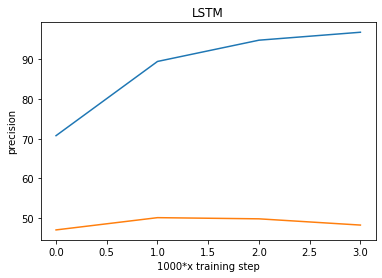

precision of the model on thevalidationdata: 50.073638916015625%
tensor([0.5647, 0.9992, 0.9803, 0.9977, 0.9941, 0.9934, 0.6003, 0.9848, 0.9999,
        0.9996, 0.9958, 0.6195, 0.9992, 0.9965, 0.9994, 0.9995, 0.9853, 0.9821,
        0.9999, 0.9860, 0.9942, 0.9994, 0.8200, 0.9968, 0.9994, 0.9720, 0.9999,
        0.9997, 0.9986, 0.7300, 0.9992, 0.9782, 0.9846, 0.9426, 0.9987, 0.5874,
        0.9914, 0.6166, 0.9937, 0.9963, 0.9484, 0.8477, 0.6474, 0.9998, 0.9930,
        0.9606, 0.9998, 0.7810, 0.9982, 0.9994, 0.6059, 0.5207, 0.5302, 0.9949,
        0.9956, 0.9996, 0.9996, 0.9760, 0.8349, 0.8907, 0.9146, 0.9998, 0.9983,
        0.9998, 0.9184, 0.9924, 0.9372, 0.9822, 0.9605, 0.7154, 0.5651, 0.9987,
        0.8602, 0.5748, 0.5066, 0.9050, 0.9981, 0.9995, 0.9815, 0.9846, 0.7114,
        0.8775, 0.9974, 0.9942, 0.9808, 0.9998, 0.9998, 0.9597, 0.5201, 0.9976,
        0.8120, 0.9838, 0.7657, 0.5295, 0.5058, 0.9853, 0.9778, 0.9994, 0.9542,
        0.9897], device='cuda:1')
current i is 5
Filter

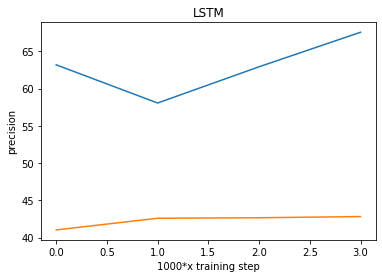

precision of the model on thevalidationdata: 42.9735221862793%
tensor([0.5078, 0.8037, 0.5694, 0.9107, 0.6358, 0.7178, 0.8632, 0.6679, 0.7529,
        0.7391, 0.6979, 0.8008, 0.5797, 0.5355, 0.6182, 0.5707, 0.9461, 0.5964,
        0.6301, 0.5661, 0.5147, 0.5401, 0.6751, 0.5343, 0.5639, 0.6586, 0.7739,
        0.9152, 0.7594, 0.9210, 0.6189, 0.5564, 0.9548, 0.6145, 0.6017, 0.8266,
        0.5369, 0.8847, 0.8859, 0.6463, 0.6464, 0.9297, 0.5528, 0.6737, 0.6071,
        0.6412, 0.5291, 0.6467, 0.7823, 0.7253, 0.9523, 0.7096, 0.7188, 0.5962,
        0.9257, 0.8215, 0.8766, 0.8828, 0.8521, 0.8788, 0.6196, 0.5260, 0.8638,
        0.8858, 0.8757, 0.7085, 0.5216, 0.6753, 0.9180, 0.9839, 0.6676, 0.5858,
        0.8574, 0.7509, 0.8504, 0.5811, 0.5159, 0.7808, 0.5576, 0.5050, 0.5655,
        0.9746, 0.6380, 0.8690, 0.5770, 0.7302, 0.6315, 0.9479, 0.7095, 0.9569,
        0.6382, 0.8479, 0.5145, 0.7347, 0.8486, 0.9108, 0.6821, 0.5758, 0.7545,
        0.7291], device='cuda:1')
current i is 6
Filter l

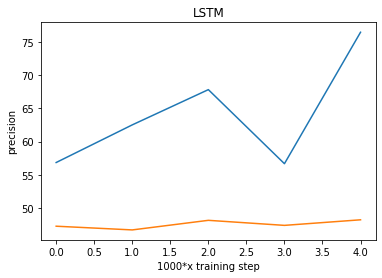

precision of the model on thevalidationdata: 47.45762634277344%
tensor([0.6187, 0.9134, 0.6959, 0.6542, 0.5868, 0.5807, 0.6064, 0.8590, 0.6319,
        0.5922, 0.8156, 0.5972, 0.7046, 0.6110, 0.6735, 0.9539, 0.9497, 0.5533,
        0.9373, 0.8223, 0.6124, 0.5540, 0.6610, 0.7062, 0.7860, 0.5854, 0.9664,
        0.5735, 0.5250, 0.5041, 0.8171, 0.6933, 0.5825, 0.7655, 0.6409, 0.6215,
        0.6378, 0.6607, 0.5652, 0.7285, 0.5942, 0.5839, 0.6338, 0.6620, 0.6443,
        0.9627, 0.7992, 0.5772, 0.7628, 0.8882, 0.6942, 0.7158, 0.5516, 0.7461,
        0.5862, 0.5717, 0.8263, 0.5942, 0.7746, 0.9411, 0.9033, 0.8366, 0.8014,
        0.8884, 0.6747, 0.5670, 0.7513, 0.5792, 0.7171, 0.8539, 0.5326, 0.6524,
        0.7354, 0.5061, 0.5135, 0.5515, 0.6294, 0.6126, 0.7169, 0.6590, 0.5596,
        0.6745, 0.8555, 0.6620, 0.7684, 0.7178, 0.6348, 0.6388, 0.5817, 0.6155,
        0.5441, 0.5448, 0.5622, 0.5396, 0.7127, 0.5511, 0.6261, 0.7662, 0.5475,
        0.7896], device='cuda:1')
current i is 7
Filter 

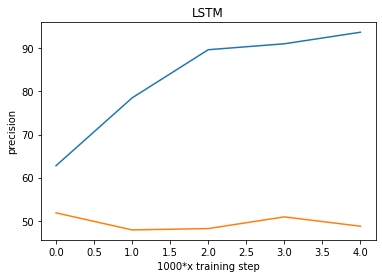

precision of the model on thevalidationdata: 48.870391845703125%
tensor([1.0000, 0.9952, 0.9990, 0.5339, 0.7251, 0.9854, 0.7477, 0.5957, 0.5520,
        0.6494, 0.5732, 0.6826, 0.8542, 0.7607, 0.5797, 0.9502, 0.9348, 0.9911,
        0.9989, 0.9999, 0.7851, 0.9546, 0.9995, 0.9925, 0.9981, 0.9645, 0.9828,
        0.5473, 0.9960, 0.9984, 0.9163, 0.9216, 0.9470, 0.7374, 0.8368, 0.9938,
        1.0000, 0.9863, 0.9779, 0.6269, 0.9314, 0.9806, 0.5934, 0.8066, 0.9907,
        0.9997, 0.9999, 0.9996, 0.9966, 0.9998, 0.8583, 0.7216, 0.8751, 0.6487,
        0.8014, 0.7887, 0.8851, 0.5282, 0.9493, 0.5564, 0.9955, 0.9300, 0.8272,
        0.9892, 0.9989, 0.9931, 1.0000, 0.9935, 0.7797, 0.9992, 0.9983, 0.8409,
        0.9804, 0.9853, 0.9998, 0.9996, 0.9995, 0.9482, 0.9999, 0.9998, 0.9653,
        0.9769, 0.5818, 0.9493, 1.0000, 0.9998, 0.9568, 0.9644, 0.6561, 0.7348,
        0.9999, 0.8590, 0.9111, 0.8144, 0.9690, 1.0000, 1.0000, 0.7309, 0.9895,
        0.9990], device='cuda:1')
current i is 8
Filter

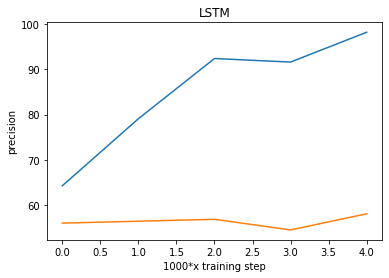

precision of the model on thevalidationdata: 56.065574645996094%
tensor([0.9986, 0.5202, 0.6905, 0.9998, 0.7841, 0.9716, 0.8602, 0.9976, 0.8971,
        0.9746, 0.9562, 0.6971, 0.9966, 0.8920, 0.9751, 0.9973, 0.9925, 0.9374,
        0.9973, 0.9976, 0.9996, 0.9994, 0.9993, 0.9973, 0.9970, 0.9292, 0.9737,
        0.9938, 0.6937, 0.9972, 0.9964, 0.8896, 0.8972, 0.9896, 0.9949, 0.6340,
        0.9934, 0.9999, 0.5343, 0.9493, 0.9759, 0.5311, 0.9970, 0.9737, 0.9994,
        0.9990, 0.9157, 0.6026, 0.7039, 0.7930, 0.7398, 0.9933, 0.9863, 1.0000,
        0.9565, 0.6185, 0.9768, 0.9890, 0.9926, 0.9800, 0.9999, 0.9664, 0.9152,
        0.9451, 0.9984, 0.6414, 0.9328, 0.8165, 0.9917, 0.7926, 0.5412, 0.9912,
        0.9508, 0.9380, 0.8172, 0.5825, 0.6530, 0.6117, 0.9987, 0.9998, 0.7049,
        0.9153, 0.9949, 0.9965, 0.5556, 0.9991, 0.9998, 0.9767, 0.6020, 0.9886,
        1.0000, 0.9996, 0.6690, 0.7381, 0.9990, 0.5192, 0.6689, 0.9972, 0.5911,
        0.9008], device='cuda:1')
current i is 9
Filter

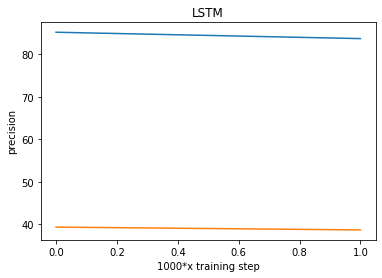

precision of the model on thevalidationdata: 37.52362823486328%
tensor([0.5746, 0.9999, 0.9978, 0.7457, 0.9851, 0.9956, 0.9836, 0.9998, 0.9039,
        0.9957, 0.9997, 0.9999, 0.9942, 0.9999, 0.9999, 0.7476, 0.8806, 0.9831,
        0.9999, 0.9966, 0.5645, 0.9999, 0.9924, 0.9743, 0.9983, 1.0000, 0.9978,
        0.5235, 0.9936, 0.8208, 0.9982, 0.6374, 0.5872, 0.9956, 0.9986, 0.5702,
        0.8985, 0.9726, 0.6494, 0.9971, 0.9998, 0.9955, 0.9199, 0.9908, 0.9505,
        0.5072, 0.6931, 0.9915, 0.9797, 0.9739, 0.9856, 0.9590, 0.9997, 0.9955,
        0.9999, 0.8585, 0.8745, 0.9744, 0.9987, 0.9847, 0.9999, 0.9988, 0.9999,
        0.7867, 0.9428, 0.8781, 0.8996, 0.9540, 0.8695, 0.9949, 0.9972, 0.9617,
        0.5974, 0.9840, 0.9982, 0.9989, 0.9979, 0.9998, 0.9667, 0.9998, 0.6737,
        0.9988, 0.9486, 0.5732, 0.9880, 0.5574, 0.7378, 0.5452, 0.9231, 0.5082,
        0.9504, 0.9948, 0.9995, 0.9927, 0.9833, 0.8766, 0.9998, 0.5049, 0.9289,
        0.8635], device='cuda:1')
current i is 10
Filter

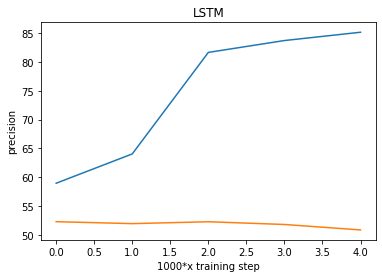

precision of the model on thevalidationdata: 52.1929817199707%
tensor([0.9986, 0.7365, 0.9937, 0.9980, 0.9997, 0.9944, 0.9137, 0.9995, 0.9999,
        0.9998, 0.9999, 0.8433, 0.9994, 0.9999, 0.9130, 0.9995, 1.0000, 0.9994,
        0.9984, 0.9998, 0.8815, 0.6626, 0.9989, 0.5297, 0.9931, 1.0000, 0.9997,
        0.9989, 0.5714, 0.9998, 1.0000, 0.9744, 0.9976, 0.8180, 0.9108, 0.9998,
        0.8970, 1.0000, 0.7021, 0.9968, 0.9998, 0.9988, 0.7984, 0.9905, 0.9698,
        0.6877, 0.9972, 0.9988, 0.9676, 0.9811, 0.9991, 0.6302, 0.5654, 0.9915,
        0.9997, 0.9993, 1.0000, 0.8790, 0.9670, 0.8420, 0.9994, 0.9997, 0.9968,
        0.6473, 0.9999, 0.9905, 0.9911, 0.9803, 0.9079, 0.9983, 0.9966, 0.9996,
        0.8062, 0.9998, 0.9999, 0.9992, 0.5889, 0.9998, 0.9892, 0.5438, 0.9914,
        0.9989, 0.9999, 1.0000, 0.9565, 0.9784, 0.9995, 0.9935, 0.9950, 0.9164,
        0.9872, 0.9507, 0.9859, 0.9049, 0.9989, 0.9919, 0.9997, 0.9976, 0.9356,
        0.9896], device='cuda:1')
current i is 11
Filter 

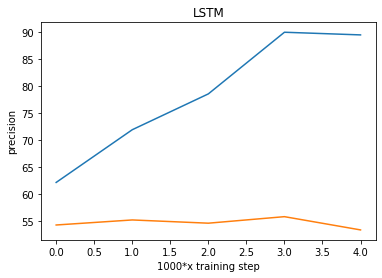

precision of the model on thevalidationdata: 54.26774597167969%
tensor([0.6280, 0.5900, 0.6614, 0.5437, 0.5282, 0.5510, 0.9499, 0.6199, 0.5532,
        0.8445, 0.8563, 0.7530, 0.6728, 0.5499, 0.5513, 0.9836, 0.9991, 0.9765,
        0.7113, 0.9984, 0.9994, 0.7593, 0.6958, 0.6010, 0.7683, 0.9458, 0.9716,
        0.9473, 0.9906, 0.9988, 0.8101, 0.7354, 0.7207, 0.5543, 0.5377, 0.5674,
        0.7251, 0.5275, 0.5822, 0.5128, 0.9290, 0.5898, 0.9993, 0.5379, 0.5403,
        0.6067, 0.5100, 0.5167, 0.5540, 0.5364, 0.5629, 0.5616, 0.9777, 0.5211,
        0.9024, 0.9844, 0.9853, 0.5784, 0.5555, 0.5578, 0.8676, 0.9962, 0.6130,
        0.9992, 0.6591, 0.6348, 0.8516, 0.7551, 0.9846, 0.5514, 0.5807, 0.6568,
        0.6481, 0.5105, 0.8036, 0.6094, 0.5286, 0.5597, 0.9213, 0.6473, 0.5377,
        0.9934, 0.8820, 0.9891, 0.8628, 0.5941, 0.5403, 0.8031, 0.7025, 0.8084,
        0.6595, 0.5492, 0.6946, 0.5745, 0.5417, 0.5597, 0.9922, 0.9804, 0.5551,
        0.9934], device='cuda:1')
current i is 12
Filter

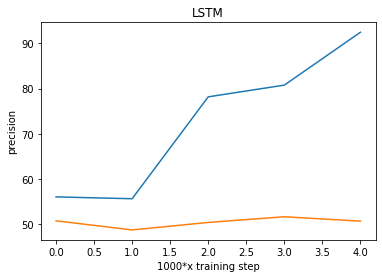

precision of the model on thevalidationdata: 51.28571319580078%
tensor([0.9740, 0.9345, 0.9705, 0.9548, 0.7173, 0.9607, 0.5617, 0.9861, 0.7499,
        0.5869, 0.9783, 0.9265, 0.6522, 0.9569, 0.7876, 0.9978, 0.9911, 0.8084,
        0.6989, 0.5399, 0.9941, 0.9629, 0.5880, 0.6058, 0.7317, 0.9954, 0.9999,
        0.7877, 0.7524, 0.9392, 0.9917, 0.5978, 0.9983, 0.6643, 0.9362, 0.9761,
        0.8606, 0.9721, 0.6232, 0.6375, 0.7404, 0.5731, 0.9830, 0.9704, 0.6875,
        0.5399, 0.9930, 0.9967, 0.9818, 0.9768, 0.9953, 0.5784, 0.6382, 0.9349,
        0.9765, 0.5695, 0.9989, 0.6687, 0.9429, 0.7286, 0.8094, 0.7825, 0.7794,
        0.6569, 0.9982, 0.8356, 0.9999, 0.8146, 0.9988, 0.9992, 0.9640, 0.9955,
        0.5301, 0.9147, 0.9991, 0.6050, 0.7551, 0.5777, 0.9938, 0.6888, 0.7686,
        0.9910, 0.8533, 0.8877, 0.9586, 0.7440, 0.9384, 0.6018, 0.7098, 0.8179,
        0.9304, 1.0000, 0.8502, 0.6425, 0.8675, 0.6679, 0.8885, 0.6919, 0.9950,
        0.6971], device='cuda:1')
current i is 13
Filter

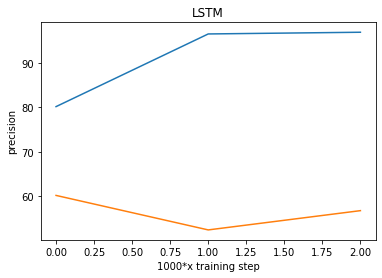

precision of the model on thevalidationdata: 58.64263153076172%
tensor([0.7113, 0.7671, 0.7992, 0.7045, 0.9977, 0.9986, 0.9991, 0.9998, 0.9674,
        1.0000, 0.9877, 0.8021, 0.6053, 0.5071, 0.5498, 0.6593, 0.5624, 0.7033,
        0.9855, 1.0000, 0.9957, 0.9999, 0.9751, 0.9999, 0.6375, 0.9655, 0.9988,
        0.7977, 0.6454, 0.7617, 0.9543, 0.5212, 0.6124, 0.7278, 0.8814, 0.6246,
        0.8754, 0.7593, 0.5417, 0.9673, 0.9160, 0.9735, 0.8671, 0.9536, 0.6191,
        0.9557, 0.9531, 0.5296, 0.7756, 0.6401, 0.6851, 0.9996, 0.9857, 0.9986,
        0.5515, 0.8524, 0.5294, 0.9991, 0.9992, 0.9513, 0.5459, 0.6458, 0.6524,
        0.9648, 0.8547, 0.9771, 0.9768, 0.8171, 0.6058, 0.9871, 0.7933, 0.9946,
        0.6639, 0.8992, 0.7295, 0.6036, 0.7072, 0.5872, 0.8077, 0.8568, 0.9999,
        0.9720, 0.9998, 0.9997, 0.7194, 0.9418, 0.6545, 0.6108, 0.5853, 0.7192,
        0.7972, 0.8613, 0.6590, 0.9705, 0.6357, 0.5807, 0.6236, 0.7035, 0.5787,
        0.6994], device='cuda:1')
current i is 15
Filter

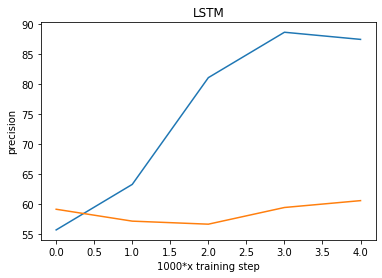

precision of the model on thevalidationdata: 60.297767639160156%
tensor([0.6973, 0.5870, 0.9927, 0.9994, 0.9281, 0.7877, 0.7071, 0.8892, 0.6371,
        0.9988, 0.5811, 0.9228, 0.9300, 0.9991, 0.9992, 0.9415, 0.9305, 1.0000,
        0.9829, 0.9997, 0.9981, 0.9866, 0.9959, 1.0000, 0.9983, 0.9961, 0.9740,
        0.9998, 0.9987, 0.9442, 0.9479, 0.8197, 1.0000, 0.9408, 0.9647, 0.9495,
        0.9992, 0.9997, 0.9908, 0.9823, 0.9976, 0.9401, 0.9963, 0.9973, 0.9998,
        0.5859, 0.9999, 0.8844, 0.9267, 0.9964, 0.9988, 0.9990, 0.9861, 0.8528,
        0.9999, 0.9738, 0.6031, 0.9985, 0.9848, 0.9088, 0.9919, 0.6983, 0.9998,
        0.9935, 0.9999, 0.9900, 0.9884, 0.8829, 0.8650, 0.9990, 0.9941, 0.9998,
        1.0000, 0.8892, 0.9099, 0.9929, 0.9811, 0.7559, 0.8032, 0.7367, 0.9986,
        0.9993, 0.9885, 0.6122, 0.9993, 0.9998, 0.9477, 0.9577, 1.0000, 0.9928,
        0.9964, 0.5851, 0.9977, 0.9999, 0.9998, 0.9840, 0.9941, 0.7020, 0.8710,
        0.9992], device='cuda:1')
current i is 16
Filte

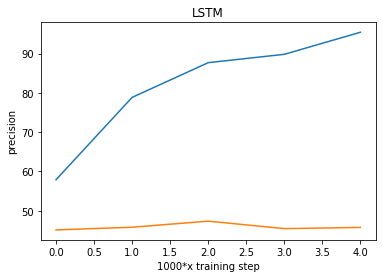

precision of the model on thevalidationdata: 45.733787536621094%
tensor([0.9697, 0.9960, 0.8565, 0.9529, 0.6023, 0.9967, 0.8721, 0.8490, 0.9689,
        0.6903, 0.7140, 0.9343, 0.7793, 0.9999, 0.9029, 0.6160, 0.7689, 0.9879,
        0.6540, 0.9941, 0.9634, 0.9168, 0.5566, 0.9999, 0.9991, 0.6102, 0.7303,
        0.9368, 0.8890, 0.6208, 0.9715, 0.8778, 0.9317, 0.9784, 0.5069, 0.8593,
        0.7703, 0.6451, 0.8756, 0.9994, 0.5568, 0.9998, 0.8744, 0.7556, 0.7281,
        0.9823, 0.9302, 1.0000, 0.9999, 0.7697, 0.8376, 0.9312, 0.7948, 0.8949,
        0.7294, 0.9966, 0.5882, 0.6193, 0.5540, 0.8817, 0.7221, 0.8117, 0.7015,
        0.6479, 0.9108, 0.6052, 0.6706, 0.9219, 0.5460, 0.9840, 0.7513, 0.9567,
        0.7281, 0.5410, 0.9984, 0.6305, 0.6913, 0.9277, 0.9877, 0.8234, 0.6935,
        0.9301, 0.9984, 0.5785, 0.8302, 0.7362, 0.9947, 0.5760, 0.9746, 0.6472,
        0.5853, 0.6132, 0.6697, 0.9845, 0.9398, 0.5190, 0.9377, 0.8392, 0.8816,
        0.6401], device='cuda:1')
current i is 17
Filte

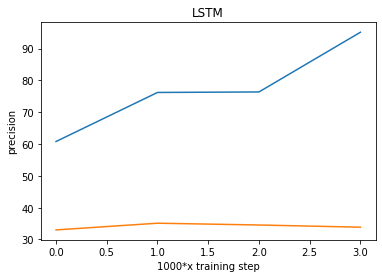

precision of the model on thevalidationdata: 33.6976318359375%
tensor([0.9675, 0.9688, 0.8305, 0.9969, 0.9884, 1.0000, 0.9988, 0.9741, 0.7500,
        0.9672, 0.9979, 0.9935, 0.6623, 0.9914, 0.8933, 0.9931, 0.9855, 0.9977,
        0.9975, 0.9974, 0.9329, 0.8025, 0.8375, 0.9943, 0.9957, 0.9993, 0.9993,
        0.8925, 0.9980, 0.8192, 0.9594, 0.9956, 0.9952, 0.7158, 0.9996, 0.6367,
        0.5223, 0.5008, 0.5120, 0.9980, 0.9742, 0.9996, 0.9950, 0.9747, 0.8041,
        0.9992, 0.9959, 0.7836, 0.9978, 0.8178, 0.7816, 1.0000, 1.0000, 0.8489,
        0.9928, 1.0000, 0.9967, 0.9691, 0.9998, 0.9998, 0.9995, 0.9930, 1.0000,
        0.9999, 0.9957, 0.5042, 0.9987, 0.9988, 0.9967, 0.9977, 0.9971, 0.9930,
        0.9993, 0.9794, 0.9997, 0.6956, 0.9894, 0.8511, 0.9550, 0.5081, 1.0000,
        1.0000, 0.9995, 0.9619, 0.7728, 0.9997, 0.8287, 0.5046, 0.9994, 0.9130,
        0.5415, 0.6787, 0.8588, 0.8178, 0.9995, 0.9896, 1.0000, 0.9938, 0.9842,
        0.9942], device='cuda:1')
current i is 18
Filter 

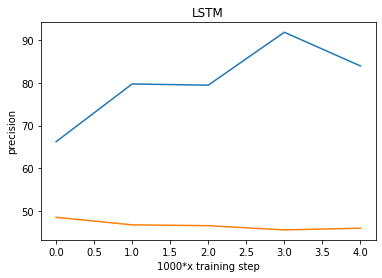

precision of the model on thevalidationdata: 45.94240951538086%
tensor([0.7675, 0.9997, 0.9951, 0.9168, 0.9759, 0.9739, 0.9990, 1.0000, 0.9999,
        0.8512, 0.9950, 0.8849, 0.7091, 0.6176, 0.9869, 0.6289, 0.8946, 0.8862,
        0.9181, 0.9400, 0.8195, 0.8581, 0.9998, 1.0000, 0.9832, 0.9067, 0.9886,
        0.9992, 0.9995, 0.9897, 0.9999, 0.9972, 0.9914, 0.6316, 0.9893, 0.9906,
        0.8691, 0.8507, 0.6938, 0.9997, 0.9934, 0.9943, 0.9993, 0.9999, 0.9983,
        0.9276, 0.9987, 0.7749, 0.9821, 0.9624, 0.9966, 0.9909, 0.7828, 0.9999,
        0.9955, 0.8019, 0.9999, 0.9191, 0.9999, 0.9985, 1.0000, 0.9941, 0.9999,
        0.9990, 0.5507, 0.9992, 0.9987, 0.9999, 0.9977, 0.9999, 0.9993, 0.5048,
        0.9995, 0.9990, 0.7328, 0.8947, 0.9996, 0.7987, 0.9986, 0.8529, 0.9962,
        0.9996, 0.9504, 0.9996, 0.9863, 0.6319, 0.9763, 0.9312, 0.5008, 0.9209,
        1.0000, 0.9875, 0.9879, 0.9835, 0.8594, 0.9735, 0.8155, 0.9934, 0.6913,
        0.6597], device='cuda:1')
current i is 19
Filter

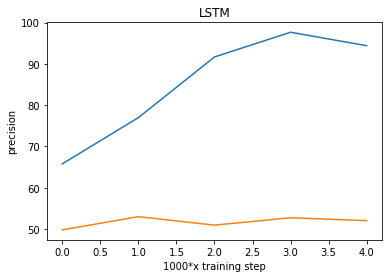

precision of the model on thevalidationdata: 51.278926849365234%
tensor([1.0000, 0.9985, 0.9999, 0.9999, 0.9272, 1.0000, 0.9861, 0.9991, 0.9998,
        0.7765, 0.6141, 0.9636, 0.7547, 0.9863, 0.9594, 0.5818, 0.9714, 0.9257,
        0.9984, 0.9756, 0.6979, 0.9999, 0.9556, 0.9999, 1.0000, 0.6414, 0.8442,
        0.7616, 1.0000, 0.9999, 1.0000, 0.9971, 1.0000, 1.0000, 0.9999, 1.0000,
        0.6988, 0.5446, 0.9924, 0.9985, 1.0000, 0.9997, 0.9999, 1.0000, 0.9999,
        1.0000, 0.9988, 0.9919, 1.0000, 0.9963, 0.9944, 0.9999, 0.9968, 0.9842,
        0.9387, 0.5155, 0.5140, 0.7743, 0.8508, 0.9506, 0.9960, 0.9844, 0.9928,
        0.9828, 0.9849, 0.8207, 0.9540, 0.9743, 0.7645, 0.8864, 0.9790, 0.9898,
        0.9622, 0.9914, 0.9992, 0.9726, 0.9518, 0.9992, 0.9953, 0.9993, 0.7833,
        0.9999, 0.5521, 0.9984, 0.9970, 0.9965, 0.6967, 0.9958, 1.0000, 0.9999,
        0.9990, 0.9999, 0.5116, 0.5512, 0.9058, 0.9997, 0.5852, 1.0000, 0.9990,
        0.7775], device='cuda:1')
current i is 20
Filte

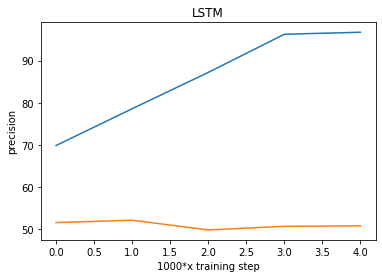

precision of the model on thevalidationdata: 51.730960845947266%
tensor([0.9876, 0.9876, 0.9574, 0.6049, 0.9686, 0.9955, 0.9412, 0.5274, 0.7371,
        0.5576, 0.9720, 0.9904, 0.9085, 0.9281, 0.9976, 0.8523, 0.9960, 0.9229,
        0.9978, 0.9926, 0.9999, 0.9591, 0.9981, 1.0000, 0.7837, 0.9974, 0.9708,
        0.9998, 0.9993, 0.6667, 0.9847, 0.9697, 0.9976, 0.5515, 0.5313, 0.5399,
        0.8677, 0.8619, 0.9045, 0.9991, 0.7871, 0.9985, 0.6000, 0.7940, 0.8404,
        0.9854, 0.9989, 0.5311, 0.9952, 0.9341, 0.6909, 0.9977, 0.9990, 0.9996,
        0.9972, 0.5165, 0.9998, 0.8532, 0.9905, 0.5976, 0.9591, 0.9996, 0.9994,
        0.9985, 0.8621, 0.9996, 0.9950, 0.9992, 0.5929, 0.7322, 0.6813, 0.5343,
        0.7132, 0.8221, 0.9347, 0.9541, 0.5854, 0.8056, 0.7894, 0.9651, 0.9057,
        0.9694, 0.9216, 0.9449, 0.9991, 0.9990, 0.9912, 0.9918, 0.9836, 0.9996,
        0.9884, 0.9987, 1.0000, 0.9882, 0.9018, 0.7695, 0.8579, 0.9604, 0.9998,
        0.9950], device='cuda:1')
current i is 22
Filte

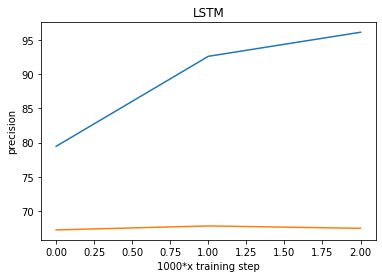

precision of the model on thevalidationdata: 65.72238159179688%
tensor([0.9934, 0.9996, 0.9997, 0.9271, 0.5117, 0.9157, 0.9915, 0.6583, 0.9809,
        0.9907, 0.8776, 0.6581, 0.6569, 0.9440, 0.7001, 0.9897, 0.5528, 0.8611,
        0.9947, 0.9439, 0.7133, 0.5460, 0.6933, 0.8500, 0.6122, 0.5639, 0.5431,
        0.5243, 0.9486, 0.9277, 0.6347, 0.9476, 0.7237, 0.8280, 0.5454, 0.5033,
        0.5759, 0.7421, 0.8640, 0.8309, 0.9925, 0.7584, 0.9486, 0.9973, 0.7674,
        0.7672, 0.8202, 0.5614, 0.5202, 0.9794, 0.9925, 0.9796, 0.9817, 0.9943,
        0.9529, 0.7952, 1.0000, 0.9844, 0.7859, 0.6173, 0.9747, 0.5308, 0.5406,
        0.5236, 0.5212, 0.9641, 0.8769, 0.6805, 0.5668, 0.5505, 0.8812, 0.9309,
        0.9974, 0.5028, 0.7734, 0.7436, 0.8028, 0.6049, 0.5862, 0.9918, 0.9968,
        0.7267, 0.6059, 0.5560, 0.5256, 0.7110, 0.5327, 0.5416, 0.8909, 0.8725,
        0.9454, 0.5887, 0.7431, 0.5222, 0.9867, 0.7262, 0.9990, 0.7053, 0.5448,
        0.5176], device='cuda:1')
current i is 23
Filter

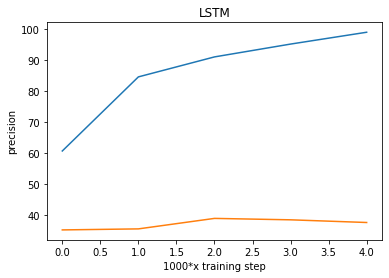

precision of the model on thevalidationdata: 36.10062789916992%
tensor([0.9995, 0.9293, 0.9998, 0.5175, 0.9996, 0.9997, 1.0000, 0.9310, 0.9999,
        0.5552, 0.9960, 0.9215, 0.9998, 0.9984, 0.9948, 1.0000, 0.9600, 0.9999,
        0.7832, 0.9999, 0.7590, 0.9997, 0.9985, 0.9999, 0.9631, 0.9790, 0.9950,
        0.9844, 0.9999, 0.9337, 0.6215, 1.0000, 0.9208, 0.7754, 0.5863, 0.9846,
        0.9791, 0.9993, 0.9973, 0.9998, 0.9993, 1.0000, 1.0000, 0.9411, 0.9999,
        0.8465, 0.7647, 0.9999, 1.0000, 0.6002, 0.9999, 0.9554, 0.9924, 0.9988,
        0.8954, 0.9905, 0.9999, 0.9820, 0.9858, 0.9563, 0.8348, 0.9495, 0.9999,
        0.9997, 0.5250, 0.9768, 0.9791, 0.9816, 0.9847, 0.9975, 0.9970, 1.0000,
        0.6333, 0.7854, 0.9978, 0.8227, 0.9999, 0.9870, 0.9997, 0.9999, 0.9843,
        1.0000, 1.0000, 0.9859, 1.0000, 0.9997, 0.9647, 1.0000, 1.0000, 0.9638,
        0.9358, 0.9359, 1.0000, 0.9793, 0.9986, 0.9979, 0.8739, 0.9232, 0.7494,
        0.9987], device='cuda:1')
current i is 24
Filter

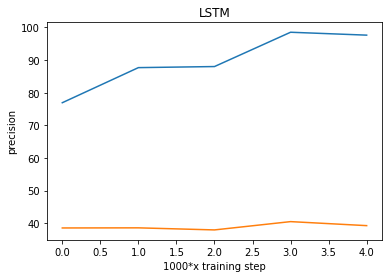

precision of the model on thevalidationdata: 37.79661178588867%
tensor([1.0000, 0.7250, 0.9854, 1.0000, 0.9988, 0.9982, 0.9839, 0.8243, 0.9996,
        0.9999, 0.9785, 0.9575, 0.9989, 0.5485, 0.6328, 0.8611, 0.6668, 0.6581,
        0.6069, 0.9924, 0.9989, 0.9991, 1.0000, 0.9839, 0.9790, 0.9977, 0.9083,
        0.9999, 0.9439, 0.9996, 0.9823, 0.9994, 1.0000, 0.9981, 0.9017, 0.9992,
        0.9710, 0.9995, 0.9969, 0.9991, 0.9985, 0.7941, 0.8846, 1.0000, 0.9999,
        0.9985, 0.9850, 0.9891, 0.8726, 0.6451, 0.8282, 0.9882, 1.0000, 0.9945,
        0.9989, 0.8796, 0.6725, 0.9979, 0.9962, 0.9946, 0.8344, 0.5889, 0.6562,
        0.9814, 0.9980, 0.9576, 0.9082, 0.9998, 0.9999, 0.9481, 0.9882, 0.9998,
        0.9999, 0.9995, 0.9564, 0.9822, 0.9997, 0.7382, 0.7887, 0.9930, 0.7266,
        1.0000, 0.9993, 0.9998, 0.5545, 0.9902, 0.9997, 0.9990, 0.9859, 0.9992,
        0.7009, 0.8126, 0.9999, 0.9997, 0.9967, 0.9978, 0.9996, 0.9959, 0.9856,
        0.8813], device='cuda:1')
current i is 25
Filter

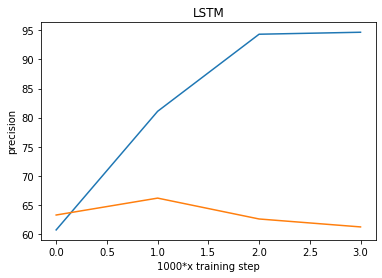

precision of the model on thevalidationdata: 62.45398712158203%
tensor([0.6976, 0.9151, 0.9849, 0.9997, 0.7682, 0.9987, 0.9990, 0.9986, 0.9899,
        0.7033, 0.9955, 0.8554, 0.9474, 0.9998, 0.9360, 0.9994, 0.6237, 0.9854,
        0.7164, 0.9960, 0.9711, 0.9918, 0.9949, 0.9435, 0.9786, 0.7923, 0.9985,
        0.9986, 0.5002, 0.7432, 0.8235, 0.9857, 0.7381, 0.9937, 0.9945, 0.9970,
        0.6301, 0.9095, 0.9846, 0.9973, 0.9939, 0.9960, 0.9978, 0.9925, 0.9687,
        0.6757, 0.9204, 0.9990, 0.9983, 0.9984, 0.9997, 0.9996, 0.9986, 0.9870,
        0.9833, 0.6752, 0.8058, 0.9995, 0.9997, 0.9996, 0.5414, 0.9931, 0.9994,
        0.9176, 0.9441, 0.8279, 0.7287, 0.6538, 0.7992, 0.9927, 0.9960, 0.7239,
        0.9736, 0.5991, 0.9997, 0.9507, 0.7817, 0.9994, 0.8061, 0.9979, 0.9990,
        0.9306, 0.9602, 0.8471, 0.9974, 0.8957, 0.7694, 0.7310, 0.6721, 0.8541,
        0.8705, 0.6802, 0.5461, 0.9934, 0.6752, 0.9828, 0.9956, 0.6842, 0.9959,
        0.9993], device='cuda:1')
current i is 26
Filter

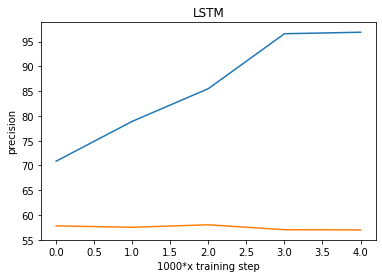

precision of the model on thevalidationdata: 58.66666793823242%
tensor([1.0000, 0.9600, 1.0000, 1.0000, 0.9396, 1.0000, 0.9941, 0.9307, 0.9283,
        0.9569, 0.5995, 0.6041, 0.9984, 0.9993, 0.9964, 0.9996, 0.9541, 0.9939,
        0.9965, 0.9904, 0.9997, 0.8356, 0.9906, 0.7572, 1.0000, 0.7896, 0.9999,
        0.7522, 0.9689, 0.9776, 0.9619, 0.9593, 0.9986, 0.9960, 1.0000, 0.9949,
        0.9974, 0.8599, 0.9644, 0.9821, 0.9943, 0.9990, 0.5314, 0.7403, 0.6027,
        0.9976, 0.9761, 0.9983, 0.9189, 0.9694, 1.0000, 0.8785, 0.7917, 0.8342,
        0.8177, 0.9891, 0.9989, 0.8272, 0.9490, 0.8538, 0.5669, 0.9235, 1.0000,
        0.9688, 1.0000, 1.0000, 0.9519, 0.9146, 0.9679, 0.8144, 0.9998, 0.9999,
        0.9987, 0.9804, 0.9998, 0.7411, 0.9962, 0.8431, 0.6949, 0.8508, 0.8721,
        0.9977, 0.6717, 0.7137, 0.9993, 0.6669, 0.9999, 0.9048, 0.7027, 0.9680,
        0.9968, 0.9298, 0.7970, 0.9990, 0.8870, 0.8011, 0.8847, 0.5500, 0.9999,
        0.9838], device='cuda:1')
current i is 27
Filter

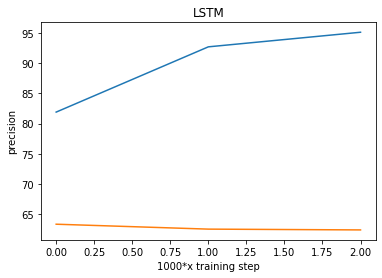

precision of the model on thevalidationdata: 61.26213455200195%
tensor([0.9493, 0.9890, 0.9993, 0.9977, 0.6845, 0.7034, 0.9988, 0.5413, 1.0000,
        1.0000, 0.9224, 1.0000, 0.9976, 0.9993, 0.9999, 0.9993, 0.9997, 0.9933,
        0.8610, 0.9861, 0.9999, 1.0000, 1.0000, 0.9838, 0.9999, 0.9999, 0.9999,
        0.9639, 0.9717, 0.9998, 0.8563, 1.0000, 0.9933, 0.9628, 0.9999, 0.9990,
        0.9546, 0.9998, 0.9838, 0.7586, 0.9337, 0.9999, 1.0000, 0.9999, 1.0000,
        0.9995, 1.0000, 0.9993, 0.9944, 0.5908, 0.9987, 0.6247, 0.9986, 0.9996,
        0.9862, 0.9921, 0.9779, 0.9370, 0.9986, 0.9999, 0.9818, 0.9928, 0.9999,
        0.9968, 0.9997, 1.0000, 0.9997, 1.0000, 0.9904, 0.9999, 0.9999, 1.0000,
        0.6716, 0.9708, 0.9998, 1.0000, 0.9998, 1.0000, 0.9959, 0.9997, 0.8632,
        0.8380, 0.6058, 0.8182, 0.9993, 0.9999, 0.9999, 0.9993, 1.0000, 0.9999,
        0.9999, 0.9044, 0.9599, 0.9998, 0.7313, 0.9347, 0.9996, 0.9942, 0.9595,
        0.7100], device='cuda:1')
current i is 28
Filter

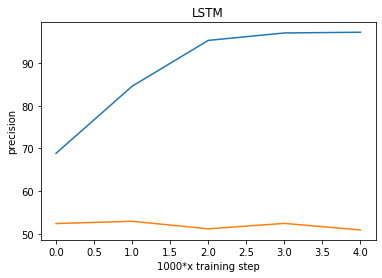

precision of the model on thevalidationdata: 50.86505126953125%
tensor([0.9997, 0.9977, 0.9998, 0.9451, 0.9029, 0.9836, 0.9824, 0.9988, 0.7197,
        0.9768, 0.9999, 0.9887, 0.9974, 0.9994, 0.9998, 0.7738, 0.9984, 0.9964,
        0.9965, 0.9997, 0.9965, 0.9994, 0.9951, 0.9989, 0.9949, 0.9994, 0.9027,
        0.6292, 1.0000, 0.9986, 0.9997, 0.9998, 0.7931, 0.9145, 0.9848, 0.6030,
        0.8792, 0.9948, 1.0000, 0.9978, 0.9846, 0.7289, 0.9953, 0.9992, 0.9942,
        0.9975, 0.9999, 0.6186, 0.9990, 0.9999, 0.9034, 0.8452, 0.9944, 0.9576,
        0.9844, 0.9991, 0.9995, 0.8714, 0.9875, 0.9883, 0.9798, 1.0000, 0.9994,
        0.5473, 0.9822, 0.9987, 0.9974, 0.9754, 0.9996, 0.9999, 0.9968, 0.9626,
        0.7104, 0.9999, 0.9961, 0.5604, 0.9505, 0.9985, 0.5193, 0.6794, 0.7907,
        0.9830, 0.5588, 0.7081, 0.9851, 0.9964, 0.9692, 0.9973, 0.8962, 0.9590,
        0.9997, 0.9969, 0.9985, 0.9998, 0.9929, 0.9999, 0.9700, 0.9952, 1.0000,
        0.9995], device='cuda:1')
current i is 29
Filter

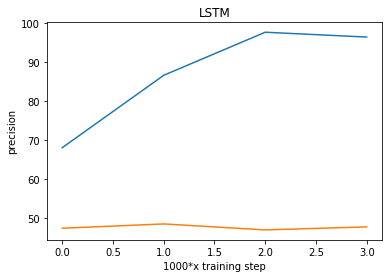

precision of the model on thevalidationdata: 46.32478713989258%
tensor([0.9993, 0.9916, 0.9992, 0.9784, 0.9963, 0.9694, 0.9727, 0.9576, 0.9858,
        0.9296, 0.7673, 0.8741, 0.9033, 0.8473, 0.5892, 0.9748, 0.8682, 0.7264,
        0.6169, 0.9995, 0.5612, 0.6769, 0.9822, 0.9994, 0.9978, 1.0000, 0.9999,
        0.9633, 0.7300, 0.9939, 0.9970, 0.9387, 0.9961, 0.7351, 0.9431, 0.9974,
        0.5446, 0.5492, 0.8947, 0.5881, 0.9833, 0.9937, 0.7559, 0.7274, 0.7625,
        0.8626, 0.9971, 0.9840, 0.9998, 0.9986, 0.6595, 0.7361, 0.5919, 0.7534,
        0.9998, 0.9999, 0.9995, 0.9995, 0.7581, 0.7194, 0.9401, 1.0000, 0.9943,
        0.6171, 0.9927, 0.9996, 0.8888, 0.9771, 0.8948, 0.7800, 0.9999, 0.9998,
        0.8136, 0.8133, 0.9798, 0.8036, 0.5081, 0.9979, 0.8702, 0.7939, 0.8363,
        0.7947, 0.9992, 0.5335, 0.9180, 0.5657, 0.9951, 0.9663, 0.7809, 0.8791,
        0.9898, 0.9257, 0.9990, 0.9999, 0.8882, 0.9998, 0.9996, 0.9956, 0.9988,
        0.9090], device='cuda:1')
current i is 30
Filter

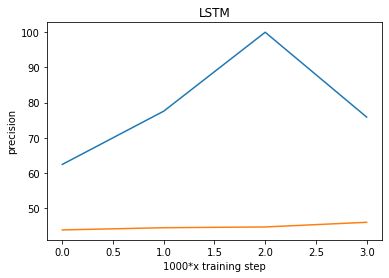

precision of the model on thevalidationdata: 45.978755950927734%
tensor([0.9955, 0.9865, 0.9787, 0.9432, 0.9991, 0.9996, 0.9384, 0.5738, 0.6976,
        0.9632, 0.9335, 0.9776, 0.9905, 0.7532, 0.9097, 0.9993, 0.9981, 0.7679,
        0.9998, 0.9803, 0.9903, 0.9990, 0.9995, 0.5648, 0.9865, 0.9998, 0.9986,
        0.9975, 0.9980, 0.9411, 0.9685, 0.9994, 0.9946, 0.9995, 0.9078, 0.9981,
        0.9998, 0.9995, 0.8910, 0.9732, 0.9809, 0.9994, 0.5183, 0.9842, 0.9976,
        0.9135, 0.5030, 0.9912, 0.9994, 0.9999, 0.9996, 0.8795, 0.9425, 0.9991,
        0.9659, 0.9753, 0.9671, 0.9993, 0.9993, 0.9995, 0.9494, 0.8449, 0.9968,
        0.9977, 0.9818, 0.9998, 0.8251, 0.9947, 0.9827, 0.9988, 0.9996, 0.9982,
        0.9994, 0.9996, 0.9994, 0.9872, 0.9995, 0.9896, 0.9868, 0.9988, 0.9910,
        0.9999, 0.9998, 0.9996, 0.9067, 0.9997, 0.9998, 0.9993, 0.9996, 0.7914,
        0.9940, 0.9716, 0.8557, 0.9997, 0.9883, 0.8088, 0.9996, 0.5790, 0.6128,
        0.8754], device='cuda:1')
current i is 31
Filte

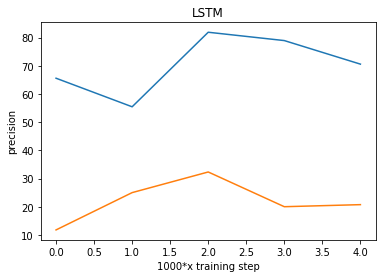

precision of the model on thevalidationdata: 25.0%
tensor([0.6462, 0.5709, 0.6782, 0.7672, 0.6217, 0.5858, 0.6146, 0.5875, 0.8010,
        0.7546, 0.6153, 0.5956, 0.6043, 0.5974, 0.8264, 0.7398, 0.5468, 0.8624,
        0.9060, 0.9667, 0.6068, 0.5874, 0.6184, 0.5914, 0.6191, 0.5857, 0.6227,
        0.5957, 0.6046, 0.5877, 0.6201, 0.5881, 0.5279, 0.9941, 0.6179, 0.5887,
        0.6038, 0.6051, 0.6251, 0.6217, 0.5873, 0.6193, 0.5976, 0.6300, 0.5811,
        0.6210, 0.5871, 0.6069, 0.5965, 0.9002, 0.9300, 0.6610, 0.5808, 0.6201,
        0.5885, 0.6184, 0.5882, 0.8763, 0.5228, 0.6207, 0.5841, 0.6196, 0.6225,
        0.5864, 0.5986, 0.6025, 0.6075, 0.6014, 0.6147, 0.5915, 0.6141, 0.5871,
        0.7931, 0.9787, 0.6115, 0.5943, 0.6058, 0.5963, 0.6107, 0.5850, 0.6246,
        0.5809, 0.9690, 0.9737, 0.6180, 0.5904, 0.9483, 0.9887, 0.6156, 0.5912,
        0.8089, 0.5223, 0.6206, 0.5786, 0.8221, 0.6019, 0.6168, 0.5829, 0.9057,
        0.5215], device='cuda:1')
current i is 32
Filter large gap...

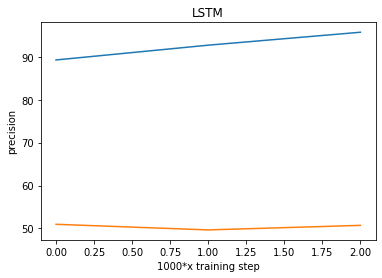

precision of the model on thevalidationdata: 52.45398712158203%
tensor([0.7798, 0.9942, 0.9874, 0.9682, 0.9992, 0.9956, 0.9979, 0.8799, 0.9991,
        0.9980, 0.9990, 0.9909, 0.9938, 0.9984, 0.9985, 0.5439, 0.9915, 0.9985,
        0.9988, 0.6964, 0.9908, 0.9897, 0.9984, 0.9702, 0.7745, 0.9897, 0.9980,
        0.8975, 0.9939, 0.9286, 0.9887, 0.9947, 0.9946, 0.6587, 0.9985, 0.9985,
        0.9636, 0.9688, 0.9994, 0.9921, 0.9968, 0.9723, 0.9915, 0.9991, 0.9992,
        0.9991, 0.9993, 0.9551, 0.8166, 0.9975, 0.9756, 0.9832, 0.9974, 0.5952,
        0.9807, 0.9959, 0.9992, 0.9992, 0.9987, 0.9854, 0.9986, 0.9974, 0.9985,
        0.9988, 0.9982, 0.9959, 0.9918, 0.9974, 0.9907, 0.9985, 0.9988, 0.9907,
        0.9931, 0.9909, 0.9994, 0.9991, 0.9894, 0.9847, 0.9978, 0.9967, 0.5655,
        0.9746, 0.9049, 0.9979, 0.9955, 0.9973, 0.8865, 0.9986, 0.9993, 0.9988,
        0.9972, 0.9990, 0.9951, 0.9960, 0.9987, 0.9971, 0.9988, 0.9912, 0.9990,
        0.9873], device='cuda:1')
current i is 33
Filter

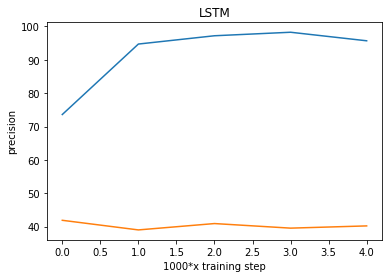

precision of the model on thevalidationdata: 40.21526336669922%
tensor([0.9946, 1.0000, 0.9998, 0.7641, 0.9918, 0.9998, 1.0000, 0.9920, 0.9799,
        0.9979, 1.0000, 0.9998, 0.9999, 0.9999, 0.9999, 0.9982, 0.9996, 0.9184,
        0.9999, 1.0000, 0.9975, 0.9999, 0.9992, 0.5041, 0.9999, 0.9999, 0.9053,
        0.8927, 1.0000, 0.9999, 0.8856, 0.9998, 0.9989, 0.9839, 0.9984, 0.7555,
        0.8758, 0.9999, 0.9999, 0.6119, 0.6346, 0.9995, 0.9978, 0.9977, 0.9999,
        0.5579, 1.0000, 0.9998, 1.0000, 1.0000, 0.9971, 0.9599, 0.5466, 0.9986,
        0.9946, 0.9994, 0.9928, 0.5459, 0.9845, 0.9946, 0.9994, 0.9999, 0.9992,
        1.0000, 0.9938, 0.9957, 1.0000, 0.9998, 0.9328, 0.9322, 0.9492, 0.9692,
        0.9995, 0.9994, 0.9995, 1.0000, 0.9837, 0.9568, 0.9998, 1.0000, 0.9997,
        0.9954, 0.9972, 0.9970, 0.9851, 0.9991, 0.9993, 0.9995, 0.8574, 0.9996,
        0.8503, 0.9909, 0.8955, 0.9787, 0.9997, 0.9998, 0.7545, 0.9978, 0.9912,
        0.9999], device='cuda:1')
current i is 34
Filter

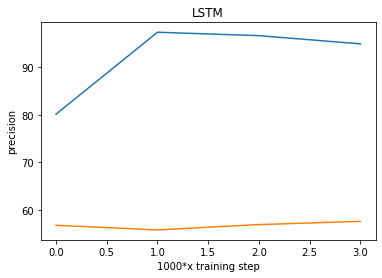

precision of the model on thevalidationdata: 53.96825408935547%
tensor([0.9715, 0.9565, 0.7511, 0.9936, 0.9865, 0.9902, 0.9985, 0.8024, 0.9909,
        0.9779, 0.9852, 0.9959, 0.8414, 0.9945, 0.9349, 0.9165, 0.9973, 0.9482,
        0.9538, 0.9963, 0.8704, 0.9970, 0.9937, 0.9975, 0.9893, 0.9960, 0.9915,
        0.9950, 0.8374, 0.9930, 0.9956, 0.9868, 0.9800, 0.9815, 0.5743, 0.9388,
        0.9759, 0.9968, 0.6857, 0.5661, 0.9349, 0.9916, 0.9025, 0.9730, 0.9663,
        0.9928, 0.9640, 0.8367, 0.9936, 0.9958, 0.9864, 0.9929, 0.9914, 0.9805,
        0.9862, 0.9835, 0.9726, 0.9651, 0.8728, 0.9688, 0.9948, 0.9461, 0.9921,
        0.9935, 0.9914, 0.9918, 0.9969, 0.9974, 0.9665, 0.9981, 0.9976, 0.9723,
        0.9939, 0.7485, 0.9905, 0.9966, 0.6611, 0.9017, 0.9937, 0.9935, 0.9544,
        0.9942, 0.9961, 0.9214, 0.9947, 0.5737, 0.9848, 0.9911, 0.8448, 0.9925,
        0.9921, 0.9736, 0.9701, 0.9934, 0.6313, 0.9204, 0.9977, 0.9954, 0.9953,
        0.9697], device='cuda:1')
current i is 35
Filter

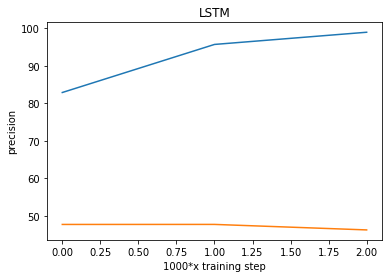

precision of the model on thevalidationdata: 46.25407028198242%
tensor([0.9999, 0.7189, 1.0000, 0.9988, 1.0000, 0.9999, 0.7485, 0.7992, 0.9997,
        1.0000, 1.0000, 0.9942, 0.9997, 0.7273, 0.9959, 1.0000, 0.9972, 0.9940,
        0.9999, 0.9983, 0.8748, 0.9388, 0.9999, 0.5656, 0.6510, 0.9137, 0.9998,
        0.9988, 0.9995, 0.9342, 0.9866, 0.6865, 0.9999, 0.8496, 0.9982, 0.9993,
        0.6351, 1.0000, 0.9963, 0.6057, 0.5637, 0.9981, 0.9976, 0.9999, 0.9980,
        0.9982, 0.9999, 0.9987, 1.0000, 0.9998, 0.9778, 0.9988, 0.9407, 0.9958,
        0.9744, 0.7666, 0.9996, 0.9996, 0.5723, 0.9997, 0.9942, 0.9960, 0.7637,
        0.9991, 0.9997, 0.9783, 0.9898, 0.9965, 0.9754, 0.9115, 0.6634, 0.9918,
        0.9997, 0.5919, 0.9995, 0.7345, 0.5570, 0.9990, 0.9193, 1.0000, 1.0000,
        0.9971, 0.9734, 0.9688, 0.9182, 0.9993, 0.9997, 0.9091, 0.8834, 0.9791,
        0.9960, 0.7034, 0.9787, 0.7302, 0.9820, 0.9868, 0.8840, 0.8844, 0.9921,
        0.9998], device='cuda:1')
current i is 36
Filter

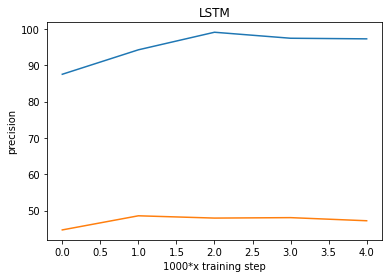

precision of the model on thevalidationdata: 47.12990951538086%
tensor([0.9998, 0.5964, 0.9314, 0.9817, 0.9883, 0.9999, 0.9998, 0.6685, 0.9996,
        0.9868, 0.9999, 0.9965, 0.9318, 0.8666, 0.9916, 1.0000, 1.0000, 0.8785,
        0.9685, 0.9794, 0.8941, 1.0000, 1.0000, 0.9988, 0.9999, 0.9977, 0.9857,
        1.0000, 0.9926, 0.9458, 1.0000, 0.9996, 0.8508, 0.9989, 0.9997, 0.9222,
        0.9999, 0.9999, 0.9992, 1.0000, 1.0000, 0.9994, 0.9998, 0.9970, 0.9995,
        0.8770, 0.9685, 1.0000, 1.0000, 0.8709, 0.9996, 1.0000, 0.9983, 1.0000,
        0.9664, 0.8510, 0.8899, 1.0000, 0.8401, 0.8204, 0.9986, 0.9956, 0.9979,
        0.5801, 0.9771, 0.9990, 0.9997, 0.7330, 0.9992, 0.9995, 1.0000, 0.9907,
        0.9427, 0.9997, 1.0000, 0.9999, 0.9853, 1.0000, 1.0000, 0.8639, 0.8659,
        0.7377, 0.9985, 0.5012, 0.9787, 1.0000, 0.9890, 0.9991, 0.9939, 0.9999,
        0.9999, 0.8734, 0.9550, 0.9994, 0.9856, 0.7041, 0.9916, 0.9998, 0.9999,
        0.9993], device='cuda:1')
current i is 37
Filter

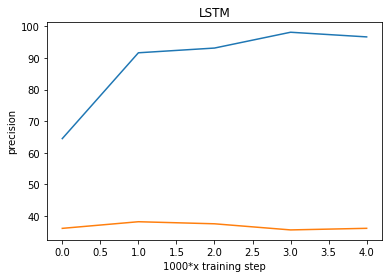

precision of the model on thevalidationdata: 35.985313415527344%
tensor([0.9882, 0.9997, 0.9999, 0.6571, 1.0000, 0.8120, 0.5343, 0.9625, 0.8983,
        0.9056, 0.9839, 0.7953, 1.0000, 0.9978, 0.9628, 0.8915, 0.8819, 0.9283,
        0.9981, 0.7595, 1.0000, 0.7344, 0.9986, 0.8707, 0.9379, 0.9043, 0.9996,
        0.9749, 1.0000, 0.9715, 0.7335, 0.8923, 0.9856, 0.7163, 0.6758, 0.9430,
        0.9961, 0.9992, 0.9917, 0.9979, 0.9989, 1.0000, 0.9976, 1.0000, 0.9993,
        0.6779, 0.8819, 0.6222, 0.9810, 0.9055, 0.9984, 1.0000, 0.5135, 0.9995,
        0.8690, 0.5628, 0.9709, 0.9135, 0.9063, 0.9980, 0.9548, 0.9999, 1.0000,
        0.9956, 0.9962, 0.9998, 0.9990, 0.9988, 0.8443, 0.7761, 0.6363, 0.9607,
        0.7130, 0.9996, 0.9908, 0.9915, 0.6560, 0.9580, 0.9999, 0.9994, 0.9788,
        0.9989, 0.8178, 0.9606, 0.9956, 0.7129, 0.8693, 0.9744, 1.0000, 0.9988,
        0.8442, 0.9473, 0.8086, 0.8563, 0.6403, 0.9753, 0.6233, 0.6342, 0.6807,
        0.9645], device='cuda:1')
current i is 38
Filte

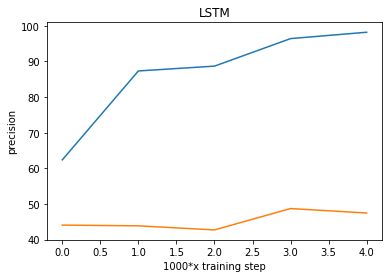

precision of the model on thevalidationdata: 50.39246368408203%
tensor([0.8005, 0.9900, 0.9743, 0.8703, 1.0000, 0.7843, 0.8525, 0.8379, 0.9598,
        0.9928, 0.9999, 0.8612, 0.6640, 0.7673, 0.9844, 0.9999, 0.9997, 0.6020,
        0.8726, 0.9027, 0.6825, 0.6346, 0.8593, 0.8659, 0.7073, 0.7825, 0.5340,
        0.8148, 0.9669, 0.8959, 0.8086, 0.7651, 0.9696, 0.8975, 0.9998, 0.9368,
        0.7993, 0.9989, 0.9928, 0.7349, 0.6212, 0.9416, 0.8412, 0.9506, 0.8417,
        0.5576, 0.9618, 0.7725, 0.5132, 0.9903, 0.8836, 0.5516, 0.9260, 1.0000,
        0.8337, 0.9784, 0.8855, 0.9994, 0.9997, 0.8542, 0.8038, 0.5921, 0.7331,
        0.9987, 0.9993, 0.6778, 0.8436, 0.8404, 0.7016, 0.5671, 0.9739, 0.5971,
        0.7572, 0.6300, 0.7496, 0.9724, 0.9446, 0.9976, 0.8539, 0.9986, 0.9058,
        0.9560, 0.9998, 0.8726, 1.0000, 0.9998, 0.9996, 0.9862, 0.9993, 0.9977,
        0.5076, 0.6626, 0.8933, 0.7236, 0.7115, 0.5854, 0.9427, 0.7918, 0.8529,
        0.8929], device='cuda:1')
current i is 39
Filter

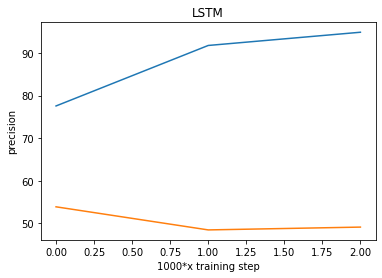

precision of the model on thevalidationdata: 49.16792678833008%
tensor([0.9953, 0.8951, 0.7220, 0.9332, 0.9999, 1.0000, 0.9880, 0.6396, 1.0000,
        0.9999, 0.9840, 0.9998, 0.9188, 0.9988, 1.0000, 1.0000, 1.0000, 0.9999,
        0.7787, 1.0000, 0.9104, 0.6353, 1.0000, 0.9976, 0.9957, 0.9747, 0.9906,
        0.7638, 0.9999, 1.0000, 0.8298, 0.5100, 0.6306, 0.7456, 1.0000, 0.9969,
        0.9989, 0.9922, 0.8493, 0.9682, 0.9998, 0.9922, 0.9998, 0.9999, 0.9616,
        0.9956, 0.9989, 0.9996, 0.9998, 0.9999, 0.9401, 0.9392, 0.8737, 0.9926,
        0.9962, 0.9857, 0.9999, 0.9837, 0.5627, 0.8764, 0.9999, 1.0000, 0.9999,
        0.9998, 0.9889, 0.9536, 1.0000, 0.9498, 0.5915, 0.9999, 0.9924, 0.9639,
        0.6106, 0.6581, 0.9352, 1.0000, 0.9260, 0.5557, 0.7990, 0.9952, 0.9999,
        0.8717, 0.9538, 0.9998, 0.9988, 1.0000, 0.8421, 0.9520, 1.0000, 1.0000,
        0.9986, 0.9934, 0.9649, 1.0000, 1.0000, 1.0000, 0.9750, 0.9929, 0.9999,
        0.9948], device='cuda:1')
current i is 41
Filter

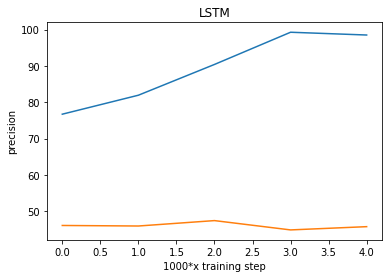

precision of the model on thevalidationdata: 45.35714340209961%
tensor([0.9999, 0.9987, 0.9996, 0.9977, 0.9996, 0.9988, 0.9976, 0.6108, 0.9993,
        0.9539, 1.0000, 0.9482, 0.9866, 0.9999, 1.0000, 0.9999, 0.9931, 0.8895,
        0.8893, 0.7660, 0.8901, 0.9954, 0.7429, 0.9600, 0.6475, 0.9999, 0.9983,
        1.0000, 0.9997, 0.5455, 0.9824, 0.9999, 0.9741, 0.7173, 0.9883, 0.9933,
        0.9904, 0.7853, 0.9996, 0.9999, 0.9878, 0.9999, 0.9945, 0.6599, 0.9985,
        0.9969, 0.9129, 0.9998, 0.9993, 0.9997, 0.9896, 0.7489, 0.9998, 0.9999,
        0.9699, 1.0000, 0.7361, 0.9974, 0.9992, 0.9998, 0.9997, 0.9961, 0.9939,
        0.9302, 0.9987, 0.9999, 0.7759, 0.9965, 0.9996, 0.9984, 0.9999, 1.0000,
        0.9991, 0.9915, 0.9996, 0.9997, 1.0000, 0.9714, 0.9977, 0.9985, 0.9976,
        0.9998, 0.9945, 0.9995, 0.9286, 0.9999, 0.9924, 0.9950, 1.0000, 0.9999,
        0.9975, 0.9874, 0.9454, 0.9996, 0.9940, 0.9421, 0.6039, 0.7290, 0.9906,
        1.0000], device='cuda:1')
current i is 42
Filter

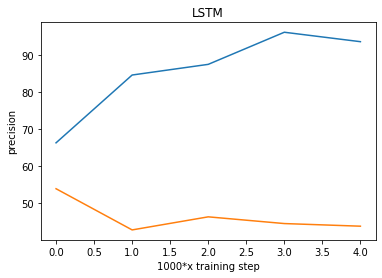

precision of the model on thevalidationdata: 42.63038635253906%
tensor([0.6886, 0.9942, 0.9898, 0.9996, 0.7817, 0.8912, 0.8942, 0.9142, 0.5288,
        0.9865, 0.8587, 0.5507, 0.7971, 0.5916, 0.9986, 0.5540, 0.8622, 0.5559,
        0.6822, 0.9617, 0.9043, 0.6355, 0.9985, 0.9994, 0.7091, 0.7860, 0.7579,
        0.9021, 0.8152, 0.7463, 0.9999, 0.9176, 0.7470, 0.5022, 0.5115, 0.9663,
        0.9998, 0.9584, 0.7513, 0.7679, 0.6441, 0.7402, 0.7071, 0.8408, 0.7454,
        0.7452, 0.5932, 0.9991, 0.9394, 0.6862, 0.9994, 0.8824, 0.6898, 0.9955,
        0.9994, 0.6874, 0.9446, 0.9935, 0.9992, 0.9854, 0.9065, 0.7647, 0.9395,
        0.9880, 0.9937, 0.5032, 0.9107, 0.9932, 0.8768, 0.7209, 0.5250, 0.5344,
        0.7587, 0.9982, 0.9807, 0.9997, 0.9996, 0.6993, 0.5493, 0.5721, 0.6837,
        0.6702, 0.9262, 0.5633, 0.7642, 0.9945, 0.9710, 0.9731, 0.7574, 0.9999,
        0.8023, 0.8732, 0.5691, 0.7709, 0.9804, 0.8492, 0.9998, 0.9970, 0.9993,
        0.5768], device='cuda:1')
current i is 43
Filter

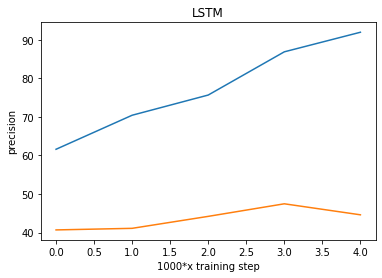

precision of the model on thevalidationdata: 47.28773498535156%
tensor([0.8765, 0.8956, 1.0000, 0.9993, 0.7933, 0.9975, 0.8195, 0.9997, 0.9908,
        0.5228, 0.9168, 0.6434, 0.9485, 0.9653, 0.9999, 0.9996, 0.9844, 0.9825,
        0.9885, 0.9746, 0.5102, 0.6870, 0.9937, 0.9957, 0.5354, 0.9865, 0.5211,
        1.0000, 0.9826, 1.0000, 0.8733, 0.7202, 0.9606, 0.9978, 0.9707, 0.9645,
        0.8669, 0.6680, 0.9862, 0.9988, 0.7749, 0.9988, 0.9471, 0.9919, 0.9974,
        0.7155, 0.5123, 0.9977, 0.9945, 0.9080, 0.6356, 0.7660, 0.6517, 0.8747,
        0.9999, 0.9816, 0.9420, 0.7442, 0.9662, 1.0000, 0.7879, 0.8493, 0.9876,
        0.6368, 0.9967, 0.9971, 0.9903, 0.9770, 0.9633, 0.5096, 0.5563, 0.9425,
        0.9889, 0.7820, 0.9707, 0.5253, 0.6117, 0.9176, 0.7662, 0.9037, 0.9948,
        1.0000, 0.9973, 1.0000, 0.9979, 0.6873, 0.6529, 0.9993, 0.7073, 0.9968,
        0.9826, 0.9929, 0.8687, 0.9441, 0.7352, 0.9850, 0.9468, 0.6023, 0.9105,
        0.6847], device='cuda:1')
current i is 44
Filter

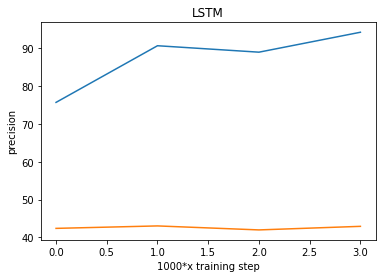

precision of the model on thevalidationdata: 41.902835845947266%
tensor([0.9999, 0.8049, 0.7674, 0.9534, 0.7519, 0.9922, 0.9997, 0.6004, 0.9855,
        0.9989, 0.8971, 0.9998, 0.5144, 0.9964, 1.0000, 1.0000, 0.9956, 0.7429,
        0.9401, 0.8896, 0.9999, 1.0000, 0.9131, 0.9523, 0.9992, 0.5007, 0.9999,
        0.9315, 0.9954, 0.9998, 0.7104, 0.9965, 0.5013, 0.9801, 0.9918, 0.9598,
        0.7139, 0.9064, 0.9992, 0.9999, 1.0000, 0.9999, 0.9954, 0.9885, 0.9981,
        0.9418, 0.8339, 0.9850, 0.9991, 0.8639, 0.9942, 0.5174, 0.9994, 0.5692,
        1.0000, 0.9939, 0.9993, 0.9873, 0.9995, 0.9974, 0.7180, 0.8573, 0.8712,
        0.7254, 1.0000, 0.9989, 0.9937, 0.5068, 0.9873, 0.9999, 0.9990, 0.9804,
        1.0000, 0.9976, 0.5657, 0.9970, 0.7817, 1.0000, 1.0000, 0.7496, 0.9998,
        1.0000, 0.9999, 0.9993, 0.9972, 0.9911, 0.8611, 0.8416, 0.9726, 0.8643,
        0.9393, 0.8621, 0.8950, 0.9985, 0.6814, 0.9945, 0.9996, 0.7465, 0.7676,
        0.9606], device='cuda:1')
current i is 45
Filte

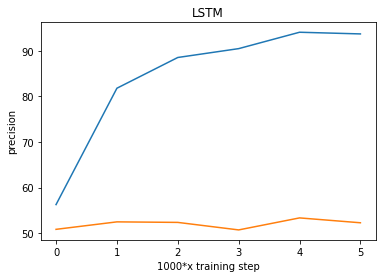

precision of the model on thevalidationdata: 52.25490188598633%
tensor([0.9018, 0.8946, 0.9997, 0.7818, 0.7302, 0.5806, 0.5286, 0.9973, 0.8581,
        0.6542, 0.7137, 0.6580, 0.9065, 0.9985, 0.8789, 0.9974, 0.9984, 0.9793,
        0.9994, 0.9694, 0.6426, 0.9993, 0.9992, 0.8695, 0.9955, 0.9984, 0.9042,
        0.6568, 0.6182, 0.6065, 0.9993, 0.8214, 0.9978, 0.9113, 0.9990, 0.9978,
        0.7371, 0.7046, 0.7721, 0.8085, 0.6738, 0.7072, 0.9947, 0.9983, 0.9715,
        0.9994, 0.9995, 0.9997, 0.6748, 0.7388, 0.8520, 0.6883, 0.9442, 0.7109,
        0.6712, 0.7109, 0.9994, 0.9992, 0.9193, 0.9862, 0.9960, 0.8924, 0.9938,
        0.9979, 0.9987, 0.9442, 0.9770, 0.7428, 0.9828, 0.6386, 0.7039, 0.9064,
        0.5583, 0.9656, 0.7244, 0.6237, 0.9702, 0.8541, 0.5025, 0.9987, 0.8531,
        0.8787, 0.9990, 0.9333, 0.9872, 0.9991, 0.7939, 0.6739, 0.5163, 0.9171,
        0.5614, 0.9997, 0.9685, 0.5871, 0.8002, 0.9991, 0.5852, 0.8789, 0.9998,
        0.6702], device='cuda:1')
current i is 46
Filter

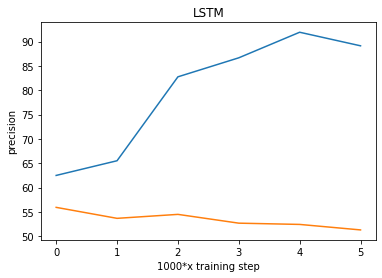

precision of the model on thevalidationdata: 51.30434799194336%
tensor([0.6852, 0.9453, 0.9969, 1.0000, 0.9768, 1.0000, 0.9996, 0.7162, 0.7666,
        0.9803, 0.9725, 0.9109, 0.6723, 0.9962, 0.9761, 0.9374, 0.5645, 0.8896,
        1.0000, 0.9999, 0.9387, 0.9997, 0.9602, 1.0000, 1.0000, 0.9830, 0.9095,
        0.9985, 0.9991, 1.0000, 0.8413, 0.9989, 0.9998, 0.6095, 0.9997, 0.9106,
        0.9976, 0.9961, 0.6761, 1.0000, 0.9141, 0.9880, 0.9987, 0.9832, 0.9962,
        0.9999, 1.0000, 0.9893, 0.9996, 1.0000, 0.9986, 0.9600, 0.9965, 0.8796,
        0.7176, 0.9997, 0.9786, 0.9996, 0.6941, 0.9962, 0.6957, 0.7458, 1.0000,
        0.9937, 0.9957, 0.9931, 0.8504, 1.0000, 0.9564, 0.6967, 0.9999, 0.5414,
        0.9999, 0.9986, 0.9635, 0.9789, 0.9999, 1.0000, 0.9997, 0.9858, 0.9992,
        0.9914, 0.9842, 0.7301, 0.9978, 0.9953, 0.5857, 0.9987, 0.9821, 0.9184,
        0.9999, 0.9937, 1.0000, 0.9841, 0.7807, 0.9945, 0.9766, 1.0000, 0.9669,
        0.6885], device='cuda:1')
current i is 47
Filter

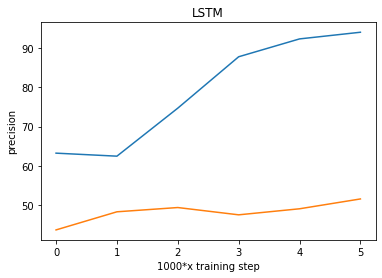

precision of the model on thevalidationdata: 51.64834976196289%
tensor([0.9097, 0.9479, 0.6787, 0.9997, 0.7967, 0.8502, 0.9964, 0.5679, 0.5688,
        0.5604, 0.5191, 0.9965, 0.8667, 0.9853, 0.9607, 0.9984, 0.7745, 0.7694,
        0.9994, 1.0000, 0.9254, 0.7249, 1.0000, 0.7881, 0.7631, 0.5051, 0.7907,
        0.9849, 0.9847, 0.9978, 0.6570, 0.8918, 0.8151, 0.5894, 0.6579, 0.9883,
        0.8189, 0.8773, 0.8842, 0.8010, 0.9958, 0.9835, 0.9999, 0.9971, 0.9667,
        0.5091, 0.8318, 0.8334, 0.7832, 0.8609, 0.9930, 0.9997, 0.8974, 0.9997,
        0.9966, 0.9524, 0.7824, 0.5529, 0.7088, 0.5355, 0.5964, 0.9703, 0.9999,
        0.8379, 0.5640, 0.9875, 0.9698, 0.9980, 1.0000, 0.6387, 0.9336, 0.5268,
        0.8250, 0.9733, 0.9456, 0.5804, 0.5549, 0.9850, 0.9493, 0.8446, 0.7400,
        0.9909, 0.9132, 0.9856, 0.5649, 0.8483, 0.9982, 0.9967, 0.9928, 0.5978,
        0.8264, 0.9532, 0.9996, 0.9992, 0.8108, 0.9995, 0.9730, 0.8885, 0.8976,
        0.9843], device='cuda:1')
current i is 48
Filter

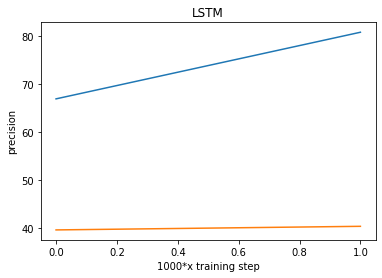

precision of the model on thevalidationdata: 39.21282958984375%
tensor([0.9339, 0.9607, 0.9905, 0.9415, 0.7976, 0.8550, 0.7900, 0.9581, 0.9157,
        0.9981, 0.9898, 0.9955, 0.9982, 0.9936, 0.9935, 0.8431, 0.9906, 0.8913,
        0.9979, 0.9273, 0.9977, 0.9974, 0.9014, 0.9343, 0.8771, 0.9954, 0.8871,
        0.9947, 0.9939, 0.9959, 0.5933, 0.6425, 0.6737, 0.7865, 0.9966, 0.9838,
        0.8078, 0.9049, 0.6757, 0.7425, 0.9668, 0.6559, 0.8945, 0.9759, 0.9971,
        0.8984, 0.9805, 0.8850, 0.5238, 0.5402, 0.9971, 0.9327, 0.6062, 0.7543,
        0.7631, 0.9740, 0.6106, 0.9530, 0.7909, 0.9523, 0.9977, 0.9164, 0.5856,
        0.7362, 0.8140, 0.9989, 0.5651, 0.9931, 0.9781, 0.6372, 0.9418, 0.9995,
        0.9996, 0.9963, 0.9964, 0.5367, 0.8676, 0.9968, 0.9923, 0.9869, 0.7670,
        0.9590, 0.9260, 0.7996, 0.7465, 0.7412, 0.9967, 0.7092, 0.9140, 0.8374,
        0.9975, 0.9913, 0.9978, 0.8415, 0.9589, 0.6139, 0.9177, 0.9899, 0.9882,
        0.9885], device='cuda:1')
current i is 49
Filter

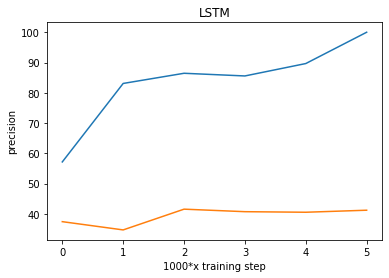

precision of the model on thevalidationdata: 41.185646057128906%
tensor([0.9871, 0.9994, 0.9999, 0.9972, 0.7033, 0.9999, 1.0000, 0.9949, 0.9997,
        0.6564, 0.9468, 0.9998, 0.9992, 0.9994, 0.9998, 0.9997, 0.7795, 0.9995,
        0.9946, 0.9190, 0.9999, 0.9981, 0.9382, 0.9646, 0.6705, 0.9988, 0.9995,
        0.8772, 0.9966, 0.9993, 0.9990, 0.9903, 0.9836, 0.5863, 0.5155, 0.5490,
        0.9998, 0.9986, 0.9999, 0.8487, 1.0000, 0.9598, 0.9998, 0.9999, 0.9991,
        1.0000, 0.9997, 0.8055, 0.6779, 0.9789, 0.9983, 0.9940, 0.9999, 0.9991,
        0.5050, 0.9825, 0.5152, 0.7511, 0.6415, 0.6780, 1.0000, 0.8836, 0.9983,
        0.9957, 0.9838, 0.9971, 0.9916, 0.9999, 0.9830, 0.9615, 0.9132, 0.9997,
        0.9910, 0.9865, 0.9964, 0.5669, 0.9995, 0.8899, 0.9890, 0.9367, 0.9991,
        1.0000, 0.9243, 1.0000, 0.9992, 0.7823, 0.9971, 0.9998, 0.9993, 0.9996,
        0.5940, 0.9997, 0.7099, 0.9995, 0.9979, 0.9993, 0.8554, 0.7595, 0.8550,
        0.6533], device='cuda:1')
current i is 50
Filte

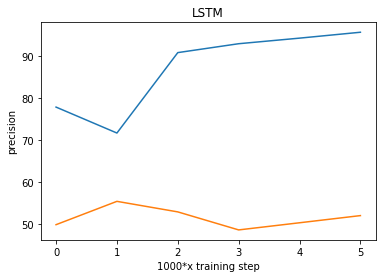

precision of the model on thevalidationdata: 51.95729446411133%
tensor([0.7468, 0.9928, 0.9991, 0.5448, 0.9048, 0.6889, 0.5322, 0.8077, 0.5102,
        0.9981, 1.0000, 0.9985, 0.5115, 0.7482, 0.6429, 0.5188, 0.5061, 0.5082,
        0.5079, 0.5145, 0.5130, 0.7814, 0.7112, 0.5009, 0.6485, 0.5245, 0.6104,
        0.9999, 0.9990, 1.0000, 0.8727, 0.9794, 0.8803, 0.9737, 0.7498, 0.5157,
        0.9824, 0.6722, 0.9779, 0.6632, 0.8881, 0.8629, 0.9952, 0.5542, 0.9995,
        0.5231, 0.5179, 0.5670, 0.8645, 0.7913, 0.5833, 0.5120, 0.5124, 0.5132,
        0.9966, 0.6142, 0.5007, 0.8948, 0.9764, 0.9591, 0.9998, 0.8383, 0.9608,
        0.5263, 0.8581, 0.5756, 0.5215, 0.6644, 0.5175, 0.5107, 0.5300, 0.5133,
        0.8281, 0.9510, 0.9982, 0.8505, 0.9996, 0.9998, 0.9875, 0.9822, 0.8214,
        0.9997, 0.6432, 0.9899, 0.9987, 0.9772, 0.6891, 0.5135, 0.5975, 0.5162,
        1.0000, 0.9242, 0.9964, 0.9998, 0.9996, 0.7481, 0.9834, 0.8867, 0.5761,
        0.9989], device='cuda:1')
current i is 51
Filter

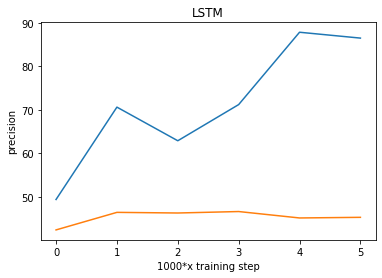

precision of the model on thevalidationdata: 45.249595642089844%
tensor([0.9957, 0.9668, 0.9999, 0.9979, 0.9994, 0.9969, 0.9901, 0.8902, 0.9936,
        0.9997, 0.6280, 0.9124, 0.9883, 0.8942, 0.9976, 0.9973, 0.9134, 0.8321,
        0.8186, 0.7523, 0.9593, 0.9966, 0.9977, 0.6361, 1.0000, 0.9977, 0.7761,
        0.9467, 0.9947, 0.8873, 0.9713, 1.0000, 0.5497, 0.7714, 0.6733, 0.8687,
        0.9981, 0.9960, 0.6320, 0.8287, 0.9066, 0.9988, 0.5413, 0.9892, 0.9022,
        0.9389, 0.9199, 0.9681, 0.9570, 0.7378, 0.5680, 0.9988, 0.5545, 0.9462,
        0.9968, 0.6924, 0.5722, 0.9991, 0.6762, 0.8767, 0.9982, 1.0000, 0.7293,
        0.6015, 0.8511, 0.9951, 0.8675, 0.9971, 0.9886, 0.5067, 0.9696, 0.9801,
        0.7593, 0.9998, 0.7404, 0.8868, 0.9990, 0.5928, 0.5388, 0.9960, 0.9832,
        0.9827, 0.9201, 0.9831, 0.9921, 0.9763, 0.9109, 0.9975, 1.0000, 0.9838,
        0.7973, 0.9477, 0.6987, 0.6696, 0.9065, 0.9449, 0.9996, 0.9978, 0.5580,
        0.9994], device='cuda:1')
current i is 52
Filte

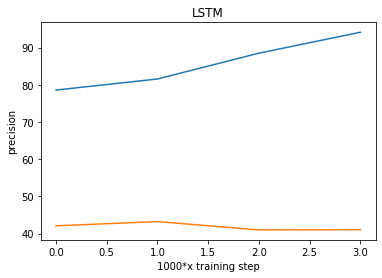

precision of the model on thevalidationdata: 40.4040412902832%
tensor([0.8607, 0.5464, 0.6560, 0.6074, 0.5558, 0.6942, 0.5260, 0.5839, 0.5026,
        0.6420, 0.9279, 0.9982, 0.5791, 0.5912, 0.5976, 0.9793, 0.9974, 0.8880,
        0.7879, 0.8412, 0.9962, 0.7793, 0.6316, 0.5324, 0.9463, 0.5727, 0.9886,
        0.7453, 0.5089, 0.7688, 0.6330, 0.6593, 0.6579, 0.9854, 0.7711, 0.6256,
        0.5598, 0.5715, 0.5828, 0.7002, 0.8164, 0.7380, 0.9532, 0.7316, 0.9877,
        0.9126, 0.9355, 0.9829, 0.9929, 0.9693, 0.9952, 0.9563, 0.9084, 0.8632,
        0.9961, 0.9530, 0.9985, 0.9700, 0.9061, 0.9578, 0.6335, 0.5982, 0.7834,
        0.9926, 0.9935, 0.9969, 0.8473, 0.9595, 0.5431, 0.9074, 0.9588, 0.8600,
        0.5044, 0.5524, 0.5006, 0.7918, 0.6432, 0.9278, 0.6150, 0.8920, 0.8011,
        0.9586, 0.9813, 0.9931, 0.5270, 0.6087, 0.5249, 0.6745, 0.5676, 0.7959,
        0.9627, 0.9622, 0.9961, 0.9753, 0.9841, 0.9426, 0.7130, 0.5322, 0.8617,
        0.5848], device='cuda:1')
current i is 54
Filter 

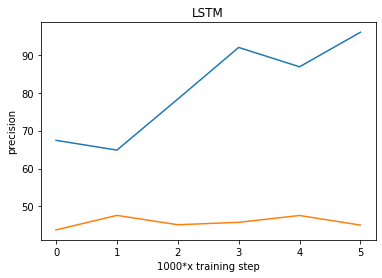

precision of the model on thevalidationdata: 46.47887420654297%
tensor([0.9811, 0.5086, 0.9518, 0.6144, 0.9066, 0.6302, 0.5489, 0.8355, 0.9607,
        0.9980, 0.9428, 0.7308, 0.9975, 0.5134, 0.6075, 0.8192, 0.5492, 0.5855,
        0.5875, 0.9771, 0.9826, 0.9997, 0.6602, 0.9999, 0.5267, 0.5163, 0.7373,
        0.9573, 0.9999, 0.9416, 0.9967, 0.9638, 0.9921, 0.7767, 0.9917, 0.9940,
        0.9963, 0.8713, 0.9969, 0.9464, 1.0000, 0.5542, 0.8753, 0.5125, 0.9649,
        0.9364, 0.5634, 0.5130, 0.9967, 0.6037, 0.9972, 0.9842, 0.5667, 0.9921,
        0.6363, 0.9999, 0.9490, 0.7978, 0.7048, 0.7903, 0.5522, 0.7940, 0.9757,
        0.6922, 0.9999, 0.9999, 0.5636, 0.9990, 1.0000, 0.9834, 0.5673, 0.9997,
        0.5120, 0.5979, 1.0000, 0.9999, 0.9866, 0.6581, 0.8949, 0.9987, 0.9978,
        0.5355, 0.9790, 0.9197, 0.9985, 0.9437, 0.9999, 0.5405, 0.5665, 0.9992,
        0.6693, 0.6937, 0.9781, 0.9587, 0.9856, 0.9433, 0.9996, 0.9733, 0.7804,
        0.9980], device='cuda:1')
current i is 55
Filter

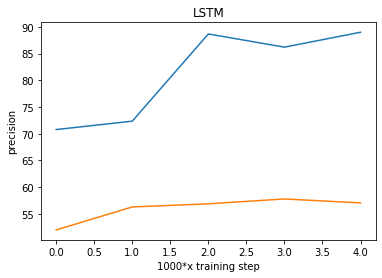

precision of the model on thevalidationdata: 57.0324592590332%
tensor([0.8175, 0.7912, 0.9962, 0.9119, 0.5202, 0.5048, 0.8003, 0.7520, 0.5683,
        0.6020, 0.9963, 0.9997, 0.8041, 0.9066, 0.8230, 0.5746, 0.9997, 0.7240,
        0.9962, 0.8704, 0.7619, 0.5192, 0.7057, 0.8336, 0.9984, 0.9998, 0.5078,
        0.6860, 0.5643, 0.5909, 0.8261, 0.9761, 0.9959, 0.8104, 0.9995, 0.9961,
        0.9925, 0.6048, 0.5688, 0.5462, 0.6498, 0.9999, 0.7589, 0.5429, 0.6094,
        0.6943, 0.5164, 0.9415, 0.9939, 0.5472, 0.5099, 0.9999, 0.9997, 0.6026,
        0.8753, 0.9696, 0.5812, 0.5883, 0.9993, 1.0000, 0.5753, 0.9976, 0.5354,
        0.9176, 0.8981, 0.5923, 0.5695, 0.9957, 0.8792, 0.7041, 0.9987, 0.6812,
        0.8829, 0.5921, 0.9939, 0.5194, 0.6082, 0.8199, 0.5502, 0.5788, 0.5701,
        0.5390, 0.5333, 0.9223, 1.0000, 0.5582, 0.6795, 0.6593, 0.5389, 0.9999,
        0.9999, 0.9987, 0.9999, 0.7845, 0.9886, 0.8696, 0.8987, 0.9998, 0.7835,
        0.8027], device='cuda:1')
current i is 56
Filter 

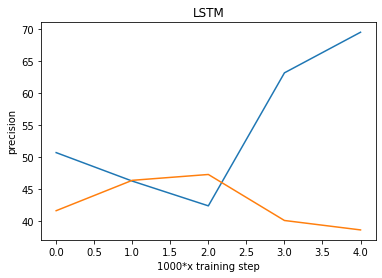

precision of the model on thevalidationdata: 39.69230651855469%
tensor([0.9454, 0.9236, 0.6343, 0.6817, 0.5949, 0.7838, 0.6679, 0.8798, 0.5006,
        0.7669, 0.8896, 0.5592, 0.7741, 0.9820, 0.6518, 0.7861, 0.7073, 0.6200,
        0.5886, 0.8327, 0.7174, 0.6953, 0.7500, 0.9879, 0.8880, 0.6388, 0.5340,
        0.7033, 0.6907, 0.6068, 0.7953, 0.6548, 0.6051, 0.5865, 0.7066, 0.7773,
        0.7630, 0.7623, 0.6978, 0.7038, 0.5211, 0.5175, 0.7284, 0.8104, 0.5160,
        0.7321, 0.7244, 0.7944, 0.6672, 0.9683, 0.6827, 0.5271, 0.5494, 0.9098,
        0.9643, 0.5333, 0.9108, 0.7136, 0.5665, 0.6736, 0.5441, 0.6276, 0.9382,
        0.6293, 0.6628, 0.6390, 0.5347, 0.6144, 0.8178, 0.5997, 0.6473, 0.6090,
        0.7432, 0.7441, 0.5689, 0.5676, 0.6319, 0.5672, 0.6471, 0.8121, 0.7064,
        0.7867, 0.8189, 0.5930, 0.9022, 0.7637, 0.8289, 0.7418, 0.7006, 0.7953,
        0.6870, 0.7751, 0.6411, 0.8513, 0.9739, 0.8127, 0.6288, 0.5337, 0.7599,
        0.5921], device='cuda:1')
current i is 57
Filter

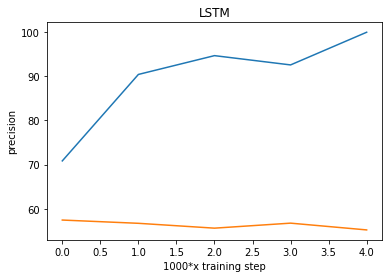

precision of the model on thevalidationdata: 55.82524108886719%
tensor([0.9124, 0.9941, 0.9992, 0.9977, 0.9989, 0.9888, 0.9992, 0.9999, 0.9587,
        0.9574, 0.9884, 0.9997, 0.9396, 0.5520, 0.8972, 0.9999, 0.8534, 0.9988,
        0.7754, 0.9997, 0.9991, 1.0000, 1.0000, 0.8302, 0.9692, 0.9819, 0.9997,
        0.9959, 0.9958, 0.8851, 0.9812, 0.9862, 0.9975, 0.9999, 1.0000, 0.9989,
        0.9846, 0.9948, 0.9436, 1.0000, 0.9410, 0.9998, 0.5042, 0.9564, 0.9897,
        0.9999, 0.9560, 0.9993, 1.0000, 1.0000, 0.9997, 0.9997, 0.9926, 1.0000,
        0.5923, 0.9865, 0.9779, 0.9967, 0.9872, 0.9965, 0.9912, 0.9933, 0.9584,
        0.9467, 0.9997, 0.9999, 0.8455, 0.8909, 0.9998, 1.0000, 0.9943, 0.8057,
        0.9167, 1.0000, 0.9998, 0.9836, 0.7137, 0.9989, 0.6550, 1.0000, 0.9441,
        0.9509, 0.9982, 0.9970, 0.8579, 0.9403, 0.9669, 0.6462, 0.9977, 0.9942,
        0.9980, 0.5043, 0.9988, 0.9900, 0.9987, 1.0000, 0.9994, 0.9831, 0.7743,
        0.9998], device='cuda:1')
current i is 58
Filter

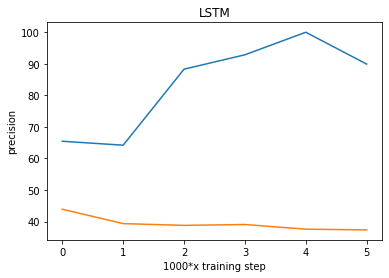

precision of the model on thevalidationdata: 36.658355712890625%
tensor([0.9999, 0.9981, 0.9819, 0.8716, 0.9375, 0.9179, 0.9755, 1.0000, 0.9986,
        0.6268, 0.8834, 0.9694, 0.5205, 0.9349, 0.5753, 0.7082, 0.9882, 0.5171,
        0.8542, 0.9008, 0.5276, 0.6787, 0.6000, 0.9986, 0.6791, 0.9913, 0.9790,
        0.9878, 0.9891, 0.9859, 0.9996, 0.9919, 0.9993, 0.9632, 0.9715, 0.9985,
        0.9182, 0.9979, 0.9504, 0.9731, 0.9964, 0.5505, 0.5775, 0.5169, 0.8687,
        0.9974, 0.7044, 0.5340, 0.7436, 0.8362, 0.7698, 0.9998, 0.9999, 0.5725,
        0.9672, 0.5531, 0.7996, 0.9954, 0.9992, 0.5983, 0.6013, 0.6219, 0.9133,
        0.9274, 0.9960, 0.7713, 0.7345, 0.9912, 0.8688, 0.5486, 0.9968, 0.5317,
        0.7811, 0.6931, 0.5153, 0.7943, 0.5594, 0.9993, 0.7452, 0.9998, 0.5477,
        0.9997, 0.8035, 0.8858, 0.7968, 0.8670, 0.9998, 0.9967, 0.6264, 0.9675,
        0.8940, 0.9988, 0.9973, 0.9998, 0.9984, 0.5054, 0.9964, 0.9939, 0.7742,
        0.9645], device='cuda:1')
current i is 59
Filte

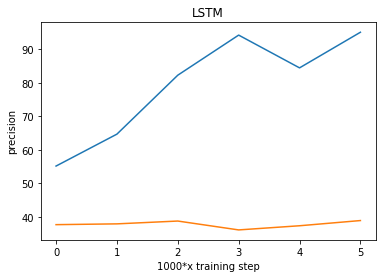

precision of the model on thevalidationdata: 38.100101470947266%
tensor([0.8614, 0.7969, 0.8186, 0.9877, 0.5803, 0.7370, 0.9993, 0.9943, 0.9997,
        0.5477, 0.9753, 0.9283, 0.9351, 0.9999, 0.8431, 0.9822, 0.9643, 0.9669,
        0.9989, 0.8257, 0.9988, 0.5585, 0.7517, 0.9980, 0.5001, 0.6475, 0.7007,
        0.8825, 0.9787, 0.8920, 0.9032, 0.9910, 0.9713, 0.5031, 0.5547, 0.7605,
        0.6047, 0.9957, 0.9993, 0.9998, 0.8762, 0.9517, 0.9996, 0.6183, 0.9827,
        0.5606, 0.9862, 0.9878, 0.9971, 0.9856, 0.8493, 0.6859, 0.5744, 0.5996,
        0.6816, 0.9985, 0.9699, 0.6640, 0.9345, 0.6855, 0.9919, 0.8739, 0.9798,
        0.9992, 0.7694, 0.9998, 0.6609, 0.6580, 0.7299, 0.9999, 0.9975, 0.9673,
        0.6095, 0.6247, 0.7101, 0.9843, 0.7186, 0.5370, 0.5993, 0.6177, 0.8125,
        0.9997, 0.7639, 0.9993, 0.9882, 0.9993, 0.9175, 0.9849, 0.6490, 0.9901,
        0.6027, 0.7277, 0.6298, 0.5952, 0.6214, 0.5744, 0.6523, 0.5829, 0.5377,
        0.7945], device='cuda:1')
current i is 60
Filte

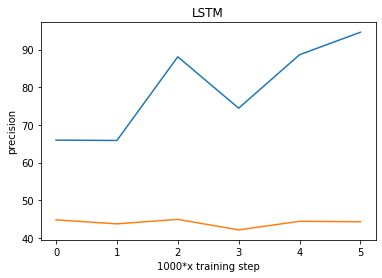

precision of the model on thevalidationdata: 44.989105224609375%
tensor([0.9411, 0.5899, 0.6545, 0.9405, 0.9993, 0.9825, 0.8598, 0.6404, 1.0000,
        0.9979, 0.7276, 0.9983, 0.5199, 0.7828, 0.9968, 0.9745, 0.9838, 0.8747,
        0.8169, 0.5274, 0.6927, 0.8639, 0.9995, 0.7876, 0.7988, 0.7147, 0.5906,
        0.6407, 0.9943, 0.9124, 0.9998, 0.5644, 0.5564, 0.9981, 0.7941, 0.9781,
        0.6210, 0.7540, 0.6742, 0.9143, 0.9096, 0.8728, 0.9998, 0.9998, 0.5438,
        0.7554, 0.9999, 0.9046, 0.9851, 0.9861, 0.9992, 0.8709, 0.6396, 0.8035,
        0.9444, 0.7927, 0.7880, 0.6851, 0.5033, 0.8225, 0.8459, 0.9389, 0.6873,
        0.9999, 0.9998, 0.9866, 0.9610, 0.8514, 0.7805, 0.9035, 0.9358, 1.0000,
        0.9997, 0.9364, 0.9888, 0.9147, 0.8258, 0.8534, 0.9999, 0.9978, 0.9857,
        0.5609, 0.9962, 0.7463, 0.9852, 0.7616, 0.5583, 0.9378, 0.9980, 0.6007,
        0.8591, 0.8969, 0.9752, 0.9999, 1.0000, 0.9997, 0.9988, 0.6904, 0.9887,
        1.0000], device='cuda:1')
current i is 61
Filte

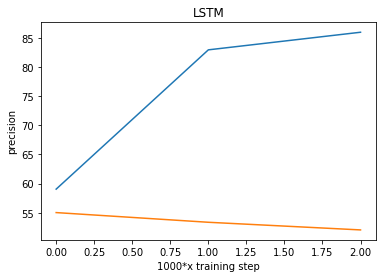

precision of the model on thevalidationdata: 53.787879943847656%
tensor([0.9462, 0.5271, 0.9989, 1.0000, 0.9904, 0.9228, 0.7372, 0.9399, 0.8460,
        0.5616, 0.8709, 0.5188, 0.9854, 0.6521, 0.9676, 0.9994, 0.9975, 0.5261,
        0.9994, 0.9998, 0.9789, 0.8130, 0.6129, 0.7424, 0.5496, 0.9989, 0.9609,
        0.9984, 0.8512, 0.9996, 0.9518, 0.6107, 1.0000, 0.9211, 0.5357, 0.9993,
        0.8204, 0.9938, 0.8142, 0.9877, 0.9939, 0.9686, 0.9999, 1.0000, 0.9423,
        0.9953, 0.8554, 0.9375, 0.9927, 1.0000, 0.9442, 0.8221, 0.9993, 0.9987,
        0.9441, 0.9988, 0.9382, 0.7453, 0.8427, 0.6594, 0.8743, 0.9979, 0.9952,
        0.9962, 0.9947, 0.9464, 0.9057, 0.9995, 0.9975, 0.9994, 0.9357, 0.9964,
        0.9686, 0.9944, 0.9988, 0.9982, 0.9997, 0.9999, 0.9071, 0.9998, 1.0000,
        0.7142, 0.9165, 0.8450, 0.5523, 0.9999, 0.5368, 0.6362, 0.9741, 0.6331,
        0.9969, 0.6493, 0.5363, 0.5496, 0.9960, 0.9910, 0.9987, 0.9735, 0.9485,
        0.9356], device='cuda:1')
current i is 62
Filte

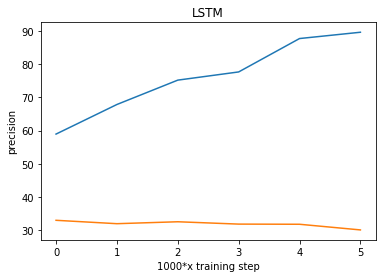

precision of the model on thevalidationdata: 32.5%
tensor([0.9998, 0.9512, 0.9633, 0.8782, 0.9989, 0.7827, 0.9438, 0.7895, 0.6947,
        0.9452, 0.7115, 0.9968, 0.9342, 0.9170, 0.9921, 0.9894, 0.7421, 0.7682,
        0.9945, 0.9983, 0.7864, 0.9932, 0.9995, 0.9996, 0.9998, 0.6798, 0.5097,
        0.9648, 0.9915, 0.9900, 0.7415, 0.7069, 0.8159, 0.9999, 0.5631, 0.5013,
        0.8973, 0.8128, 0.6525, 0.5234, 0.9240, 0.9891, 0.9739, 0.9915, 0.9923,
        0.9987, 0.9993, 0.9998, 0.9118, 0.8163, 0.9476, 0.9868, 0.9726, 0.9630,
        0.9155, 0.9893, 0.9975, 0.9652, 0.9963, 0.9766, 0.9208, 0.7491, 0.6231,
        0.9995, 0.9749, 0.9810, 0.9999, 0.9996, 0.9996, 0.6083, 0.6068, 0.9320,
        0.6148, 0.5021, 0.9653, 0.9934, 0.9950, 0.9996, 0.9702, 0.9339, 0.9927,
        0.5170, 0.9990, 0.7660, 0.9998, 0.9999, 0.5129, 0.8786, 0.6961, 0.9123,
        0.8953, 0.9986, 0.7607, 0.6540, 0.5209, 0.9344, 0.9873, 0.9667, 0.9947,
        0.8477], device='cuda:1')
current i is 63
Filter large gap...

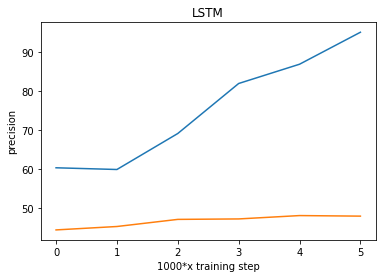

precision of the model on thevalidationdata: 46.60377502441406%
tensor([0.9394, 0.9996, 0.9996, 0.8134, 0.9571, 0.9517, 0.9973, 0.9830, 0.9867,
        0.9998, 0.9995, 0.9987, 0.8802, 0.7323, 0.7273, 0.9497, 0.9978, 0.9999,
        0.9887, 0.9999, 0.9055, 0.7933, 0.9853, 0.6486, 0.8937, 0.9781, 0.5120,
        0.9987, 0.9888, 0.9688, 0.9956, 0.9968, 1.0000, 0.9596, 0.9886, 0.8830,
        0.8909, 0.8020, 0.9999, 0.9987, 0.9994, 0.9009, 1.0000, 0.9999, 0.9508,
        1.0000, 0.9993, 0.6704, 0.5862, 0.9932, 0.8084, 0.9157, 0.9992, 0.9997,
        0.9278, 0.8111, 0.6007, 0.9842, 0.9819, 0.9999, 0.9945, 0.5880, 0.9987,
        0.9985, 0.9796, 0.9667, 0.9731, 0.8116, 0.5536, 0.9278, 0.9992, 0.5496,
        0.6063, 0.5212, 0.7299, 0.9998, 0.9969, 0.9992, 0.5360, 0.9512, 0.9923,
        0.9155, 0.8030, 0.5285, 0.8981, 0.9996, 0.6965, 0.5942, 0.9996, 0.9591,
        0.9018, 0.9793, 0.8470, 0.7024, 0.9661, 0.7269, 0.9985, 0.9996, 1.0000,
        0.9999], device='cuda:1')
current i is 64
Filter

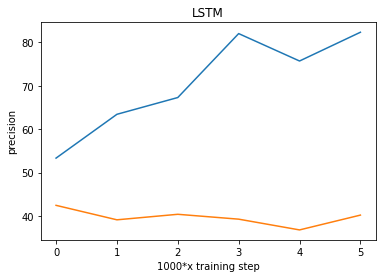

precision of the model on thevalidationdata: 39.82558059692383%
tensor([0.6419, 0.8180, 0.5100, 0.9605, 0.9976, 0.9988, 0.9521, 0.9854, 0.9997,
        0.8535, 0.9998, 0.9995, 0.9983, 0.6431, 0.9315, 0.6990, 0.8775, 0.9966,
        0.9987, 0.7781, 0.5927, 0.5237, 0.9988, 0.9038, 0.9762, 0.9967, 0.7693,
        0.9586, 0.9859, 0.9907, 0.9978, 0.5726, 0.9176, 0.9997, 0.5357, 0.9978,
        0.9938, 0.9964, 0.8684, 0.9827, 0.5010, 0.6738, 0.7260, 0.9566, 0.8373,
        0.5831, 0.7556, 0.8694, 0.9997, 0.5628, 0.9997, 0.9016, 0.5506, 0.7937,
        0.9996, 0.9989, 0.8125, 0.9149, 0.9612, 0.9888, 0.9987, 0.9917, 0.9855,
        0.5362, 0.6786, 0.9996, 0.6372, 0.9995, 0.9989, 0.9992, 0.9970, 0.9996,
        0.9423, 0.9933, 0.5308, 0.9574, 0.9279, 0.8968, 0.9817, 0.9854, 0.9997,
        0.9770, 0.9956, 0.9994, 0.9825, 0.9944, 0.9961, 0.9089, 0.9808, 0.9989,
        0.9978, 0.5595, 0.5029, 0.9968, 0.9998, 0.8876, 0.9985, 0.7641, 0.5067,
        0.9878], device='cuda:1')
current i is 65
Filter

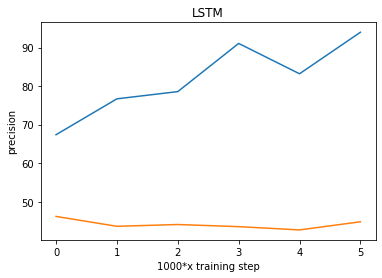

precision of the model on thevalidationdata: 44.79591751098633%
tensor([0.9855, 0.8535, 0.9796, 0.9899, 0.9562, 0.9996, 0.9469, 0.5756, 0.9798,
        0.5948, 0.7668, 0.5815, 0.5896, 0.5724, 0.5073, 0.5759, 0.5169, 0.5770,
        0.5670, 0.7559, 0.7070, 0.9811, 0.7501, 0.5455, 0.9458, 0.7976, 0.5745,
        0.5959, 0.6393, 0.5946, 0.5689, 0.5896, 0.6203, 0.8823, 0.6454, 0.9906,
        0.5811, 0.6173, 0.5844, 0.5974, 0.5312, 0.5183, 0.6612, 0.6638, 0.5831,
        0.9929, 0.5544, 0.8321, 0.9908, 0.9839, 0.9974, 0.5225, 0.5540, 0.5792,
        0.9999, 0.9699, 0.9950, 0.9998, 0.8451, 0.5068, 0.5140, 0.5989, 0.8252,
        0.5090, 0.5484, 0.5719, 0.9837, 0.9697, 0.9694, 0.9927, 0.8651, 0.5151,
        0.5077, 0.9999, 1.0000, 0.6272, 0.8383, 0.8693, 0.9802, 0.9965, 0.6579,
        0.5153, 0.5137, 0.5529, 0.6048, 0.5973, 0.5608, 0.6110, 0.6199, 0.8864,
        0.9180, 0.9996, 0.9890, 0.9987, 0.9442, 0.6841, 0.7379, 0.6478, 0.6693,
        0.6129], device='cuda:1')
current i is 66
Filter

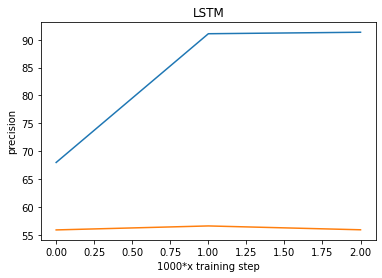

precision of the model on thevalidationdata: 55.511810302734375%
tensor([0.8719, 0.9849, 0.9991, 0.9994, 0.6307, 0.6282, 1.0000, 0.9999, 0.9989,
        0.9994, 0.9158, 0.9997, 1.0000, 0.9992, 1.0000, 0.9897, 0.9839, 0.9720,
        0.9999, 0.9736, 0.9998, 1.0000, 0.8918, 1.0000, 0.9546, 0.9994, 0.9951,
        1.0000, 0.9769, 0.9999, 1.0000, 0.9992, 0.6294, 1.0000, 0.9986, 1.0000,
        0.9998, 0.9894, 1.0000, 0.9848, 0.9806, 0.9998, 1.0000, 0.9845, 0.9998,
        0.9835, 0.9999, 0.7566, 0.9991, 0.9985, 1.0000, 0.9997, 1.0000, 0.9986,
        0.9946, 0.8737, 0.9972, 1.0000, 1.0000, 1.0000, 1.0000, 0.9999, 1.0000,
        1.0000, 0.6627, 1.0000, 0.9998, 1.0000, 0.9998, 1.0000, 0.8639, 0.9999,
        0.9999, 0.5730, 0.9899, 0.9999, 0.9992, 1.0000, 0.9999, 0.9995, 0.9995,
        0.9997, 0.8732, 0.9986, 1.0000, 0.9999, 1.0000, 1.0000, 0.8202, 0.9996,
        1.0000, 0.9987, 1.0000, 0.9902, 0.6806, 1.0000, 1.0000, 0.9971, 1.0000,
        0.9997], device='cuda:1')
current i is 67
Filte

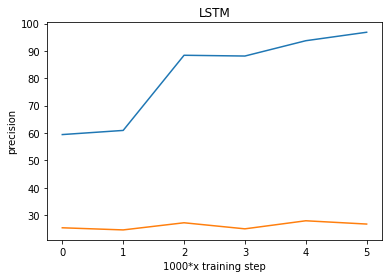

precision of the model on thevalidationdata: 23.32361602783203%
tensor([0.8640, 0.9997, 0.9823, 0.9900, 0.6815, 0.9741, 0.9819, 0.9976, 0.9541,
        0.9971, 0.9211, 0.9911, 0.9918, 0.6789, 0.9911, 0.9999, 0.7266, 0.8568,
        0.7234, 0.9957, 0.6751, 0.9436, 0.9960, 0.9978, 0.9629, 0.9709, 1.0000,
        0.9232, 1.0000, 0.5463, 0.8949, 0.7014, 0.8464, 0.8024, 0.9841, 0.9437,
        0.9840, 0.7696, 0.8659, 0.9842, 0.9909, 0.9421, 0.9991, 0.9977, 0.9643,
        0.5991, 0.9674, 0.9999, 0.5976, 0.8918, 0.8925, 0.8222, 0.9945, 0.8350,
        0.7656, 0.7470, 0.9994, 0.9996, 0.9955, 0.8118, 0.6995, 0.8488, 0.9762,
        0.7858, 0.9988, 0.7770, 0.9645, 0.9883, 0.9009, 0.8507, 0.9999, 0.7104,
        0.7256, 0.9999, 0.9672, 0.8313, 0.9736, 0.9637, 0.5974, 0.7695, 0.5740,
        0.9935, 0.6326, 0.9998, 0.8257, 0.9357, 0.7688, 0.9988, 0.6001, 0.5570,
        0.8175, 0.6942, 0.9897, 0.9998, 0.9523, 0.6271, 0.9157, 0.8046, 0.9936,
        0.5166], device='cuda:1')
current i is 68
Filter

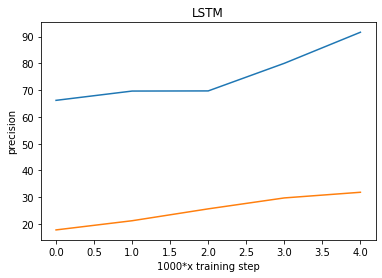

precision of the model on thevalidationdata: 26.690391540527344%
tensor([0.9942, 0.9834, 0.6401, 0.6649, 0.9847, 0.5580, 0.6442, 0.5807, 0.5045,
        0.9613, 0.5938, 0.5758, 0.9988, 0.9951, 0.5387, 0.5101, 0.9273, 0.9626,
        0.9924, 0.9987, 0.6822, 0.9988, 0.6958, 0.8711, 0.8754, 0.6027, 0.6256,
        0.9984, 0.7682, 0.9114, 0.9561, 0.9875, 0.9927, 0.9152, 0.6144, 0.5652,
        0.5154, 0.9984, 0.6933, 0.9981, 0.9923, 0.6396, 0.9809, 0.9546, 0.7681,
        0.7224, 0.6951, 0.9978, 0.9986, 0.7992, 0.9873, 0.9948, 0.9909, 0.9720,
        0.9924, 0.6890, 0.9095, 0.6414, 0.8721, 0.8737, 0.7483, 0.9941, 0.9925,
        0.7265, 0.9924, 0.8408, 0.8766, 0.6799, 0.6716, 0.7308, 0.6369, 0.9333,
        0.9984, 0.9928, 0.7329, 0.6712, 0.6770, 0.5515, 0.9586, 0.9987, 0.9820,
        0.9620, 0.5506, 0.9992, 0.9690, 0.9953, 0.8063, 0.9390, 0.9964, 0.7187,
        0.9945, 0.9713, 0.9925, 0.5940, 0.9964, 0.9704, 0.6535, 0.9870, 0.9990,
        0.8554], device='cuda:1')
current i is 69
Filte

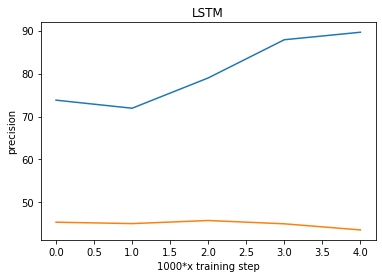

precision of the model on thevalidationdata: 43.29999923706055%
tensor([0.7055, 0.5527, 0.5742, 0.8729, 0.9733, 0.6292, 0.9478, 0.9993, 0.9955,
        0.9997, 0.9324, 0.8679, 0.9874, 0.9272, 0.9948, 0.5435, 0.6327, 0.5445,
        0.9999, 0.9999, 0.9891, 0.9961, 0.9994, 0.9977, 0.9730, 0.6470, 0.9595,
        0.5559, 0.5893, 0.7595, 0.9965, 0.8454, 0.9913, 0.9979, 0.9999, 0.9986,
        0.7217, 0.9995, 0.9954, 0.8896, 0.9325, 0.7506, 0.9871, 0.8610, 0.9881,
        0.9999, 0.9929, 0.9987, 0.9993, 0.9155, 0.9903, 0.9695, 0.7243, 0.7213,
        0.9996, 0.9490, 1.0000, 0.9093, 0.8824, 0.9957, 0.9993, 1.0000, 0.9635,
        0.8569, 0.7913, 0.8619, 0.9710, 0.8449, 0.9162, 0.9780, 0.7657, 0.8365,
        0.9920, 0.6611, 0.9999, 0.9577, 0.6030, 0.9726, 0.9004, 1.0000, 0.9992,
        0.9643, 0.9124, 0.6823, 0.8385, 1.0000, 0.8382, 0.9632, 0.9955, 0.9954,
        0.9703, 0.6480, 0.9535, 0.9761, 0.8657, 0.5342, 0.9797, 0.9068, 0.7610,
        0.9961], device='cuda:1')
current i is 70
Filter

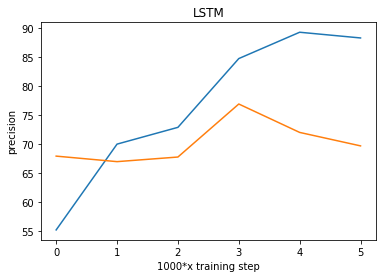

precision of the model on thevalidationdata: 72.74590301513672%
tensor([0.5013, 0.8778, 0.9942, 0.5857, 0.9178, 0.9356, 0.9567, 0.9934, 0.9558,
        0.9974, 0.7495, 0.5325, 0.8702, 0.9960, 0.8289, 0.9729, 0.7862, 0.9983,
        0.7861, 0.5560, 0.5698, 0.7944, 0.8754, 0.9760, 0.5734, 0.9994, 0.7033,
        0.5151, 0.6333, 0.9735, 0.8914, 0.9768, 0.9709, 0.8503, 0.5248, 0.6845,
        0.9869, 0.9877, 0.5755, 0.9318, 0.6665, 0.9986, 0.9472, 0.9883, 0.5072,
        0.7315, 0.9784, 0.6136, 0.8857, 0.9953, 0.9609, 0.6439, 0.9821, 0.7351,
        0.8229, 0.9095, 0.6694, 0.9809, 0.9961, 0.9999, 0.9624, 0.5608, 0.7973,
        0.8047, 0.9962, 0.9845, 0.9655, 0.7970, 0.9834, 0.9999, 0.5121, 0.8691,
        0.9998, 0.9875, 0.6068, 0.8144, 0.8005, 0.7838, 0.6176, 0.5426, 0.7764,
        0.9362, 0.9978, 0.6069, 0.9979, 0.9987, 0.8629, 0.7493, 1.0000, 0.9983,
        0.9543, 0.8974, 0.6469, 0.5136, 0.9495, 0.9993, 0.9060, 0.7540, 0.7084,
        0.7464], device='cuda:1')
current i is 71
Filter

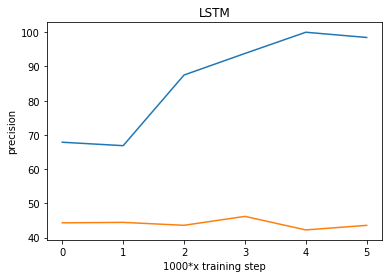

precision of the model on thevalidationdata: 45.43589782714844%
tensor([0.6101, 0.9579, 0.7333, 0.6472, 0.9807, 0.9949, 0.9998, 1.0000, 0.7332,
        0.9986, 0.9597, 0.9989, 0.9701, 0.9951, 0.9985, 0.9999, 1.0000, 0.9926,
        1.0000, 0.9988, 0.8618, 0.9886, 0.9999, 0.8677, 0.6891, 0.9999, 1.0000,
        0.9997, 0.5937, 0.9670, 0.8381, 0.9999, 0.7803, 1.0000, 0.9753, 0.9876,
        0.8370, 0.9894, 0.9993, 0.9969, 0.6507, 0.9998, 0.5715, 0.9799, 0.9875,
        0.9993, 0.9999, 1.0000, 0.9763, 0.9115, 0.9991, 0.7103, 1.0000, 0.9990,
        1.0000, 1.0000, 0.8948, 0.9677, 0.7218, 0.9757, 1.0000, 0.9627, 0.9830,
        0.5199, 0.9988, 0.8366, 0.9987, 0.9025, 0.5900, 0.9470, 1.0000, 0.9995,
        0.9999, 0.9982, 0.9992, 0.9830, 0.9663, 0.9909, 0.9997, 0.8335, 0.9578,
        0.9941, 1.0000, 0.7034, 1.0000, 0.9768, 0.8583, 0.7101, 0.9994, 0.9971,
        0.7380, 0.9976, 0.9784, 0.9979, 0.9991, 0.9948, 0.9973, 0.9290, 1.0000,
        0.9994], device='cuda:1')
current i is 72
Filter

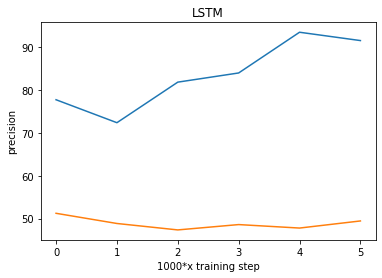

precision of the model on thevalidationdata: 49.32279968261719%
tensor([0.9738, 0.9959, 0.9804, 0.9935, 0.9615, 0.9998, 0.7786, 0.7296, 0.8484,
        0.9217, 0.8147, 0.9072, 0.9998, 0.9057, 0.9941, 0.7317, 0.6543, 0.5018,
        0.9942, 0.9815, 0.9825, 0.5329, 0.9957, 0.5874, 0.5516, 0.5393, 0.5810,
        0.5947, 0.8679, 0.6482, 0.5374, 0.8676, 0.9312, 0.5770, 0.7267, 0.9684,
        0.8384, 0.9755, 0.7729, 0.6625, 0.6431, 0.5393, 0.8692, 0.9303, 0.7471,
        1.0000, 1.0000, 0.9999, 0.9999, 0.9202, 0.9999, 0.9966, 0.7553, 0.9643,
        0.5072, 0.5404, 0.6935, 0.9976, 0.9860, 0.9939, 0.5121, 0.7086, 0.7892,
        0.9921, 0.9489, 0.8833, 0.5612, 0.9632, 0.7512, 0.9611, 0.9574, 0.8924,
        0.8288, 0.9599, 0.9576, 0.9984, 0.9999, 0.9992, 0.9993, 0.9865, 0.9933,
        0.9540, 0.5296, 0.9614, 0.7941, 0.8334, 0.8608, 0.7235, 0.5252, 0.8482,
        0.8966, 0.9838, 0.6770, 0.9778, 0.8749, 0.9820, 0.8431, 0.9969, 0.9807,
        0.9410], device='cuda:1')
current i is 73
Filter

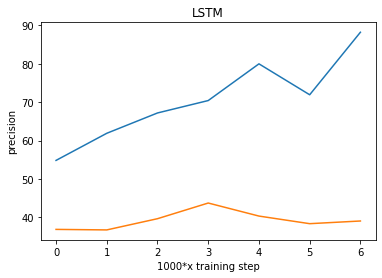

precision of the model on thevalidationdata: 39.0476188659668%
tensor([0.9364, 0.9897, 0.9997, 0.9897, 0.9972, 0.9847, 0.9957, 0.5895, 0.7798,
        0.7771, 0.6531, 0.9895, 0.9439, 0.5707, 0.9985, 0.9851, 0.6870, 0.5971,
        0.6264, 0.9771, 0.6430, 0.6663, 0.9981, 0.9721, 0.9914, 0.9972, 0.9930,
        0.9972, 0.8543, 0.9474, 0.9752, 0.8528, 0.9170, 0.8774, 0.8436, 0.9587,
        0.9975, 0.9921, 0.8794, 0.5070, 0.8333, 0.5075, 0.8844, 0.6805, 0.5612,
        0.7664, 0.9931, 0.9868, 0.5380, 0.5679, 0.9887, 0.9894, 0.9879, 0.9557,
        0.7824, 0.9957, 0.7916, 0.9978, 0.9289, 0.7748, 0.9833, 0.6361, 0.9946,
        0.9993, 0.9985, 0.7906, 0.7155, 0.7477, 0.8822, 0.9758, 0.9991, 0.5786,
        0.6830, 0.8536, 0.8817, 0.7863, 0.6673, 0.6921, 0.7794, 0.7426, 0.5210,
        0.6504, 0.7700, 0.9684, 0.9981, 0.7829, 0.6640, 0.6579, 0.9888, 0.9814,
        0.8268, 0.9943, 0.9889, 0.9004, 0.9935, 0.7983, 0.9603, 0.9983, 0.9941,
        0.5118], device='cuda:1')
current i is 74
Filter 

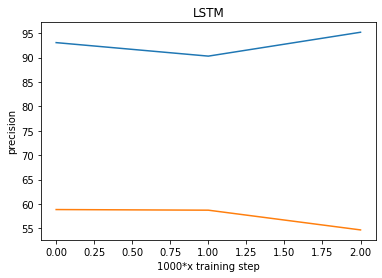

precision of the model on thevalidationdata: 57.40319061279297%
tensor([0.9923, 0.9989, 0.9222, 0.9933, 0.9244, 0.9982, 0.6752, 0.6718, 0.8993,
        0.8650, 0.9725, 0.8943, 0.9187, 0.9825, 0.8719, 0.7946, 0.9645, 0.8863,
        0.9607, 0.8991, 0.8705, 0.9029, 0.9757, 0.8094, 0.9884, 0.8497, 0.9518,
        0.5298, 0.9855, 0.9861, 0.8227, 0.7878, 0.5872, 0.9887, 0.9116, 0.9578,
        0.7833, 0.9980, 0.9933, 0.9677, 0.9626, 0.7127, 0.7754, 0.5740, 0.8118,
        0.5776, 0.8211, 0.9221, 0.8231, 0.7627, 0.8485, 0.8854, 0.8651, 0.8724,
        0.8814, 0.7447, 0.7543, 0.8100, 0.8427, 0.9957, 0.9825, 0.7785, 0.7348,
        0.8983, 0.7456, 0.6986, 0.8542, 0.9756, 0.6995, 0.9318, 0.8422, 0.9886,
        0.8818, 0.7684, 0.9192, 0.7739, 0.7757, 0.8232, 0.8942, 0.9203, 0.9615,
        0.9750, 0.8147, 0.9692, 0.7800, 0.9588, 0.9992, 0.7427, 0.9746, 0.9977,
        0.9970, 0.9095, 0.9724, 0.8995, 0.7464, 0.9686, 0.8117, 0.7208, 0.9808,
        0.7990], device='cuda:1')
current i is 75
Filter

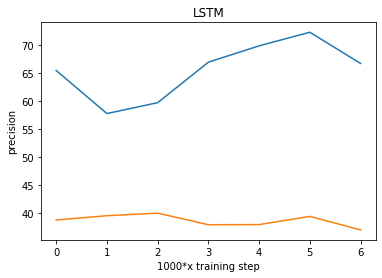

precision of the model on thevalidationdata: 36.99283981323242%
tensor([0.6208, 0.5259, 0.7646, 0.5944, 0.9580, 0.5212, 0.9963, 0.6059, 0.8283,
        0.7692, 0.9401, 0.6242, 0.5511, 0.9810, 0.5195, 0.6043, 0.6942, 0.9476,
        0.5019, 0.5823, 0.7438, 0.9023, 0.6970, 0.9985, 0.8871, 0.5075, 0.9607,
        0.9189, 0.5727, 0.8717, 0.6892, 0.6226, 0.8620, 0.7253, 0.6708, 0.6266,
        0.6551, 0.7027, 0.6784, 0.9805, 0.7400, 0.8864, 0.8869, 0.6206, 0.6272,
        0.5411, 0.6309, 0.9243, 0.8300, 0.6190, 0.9667, 0.8203, 0.8372, 0.5172,
        0.5391, 0.5876, 0.5915, 0.8101, 0.6324, 0.8699, 0.7259, 0.5594, 0.5446,
        0.7841, 0.7637, 0.5687, 0.8381, 0.8594, 0.6814, 0.9673, 0.8245, 0.8413,
        0.8135, 0.5602, 0.9899, 0.9048, 0.8291, 0.5750, 0.5840, 0.5437, 0.7469,
        0.8377, 0.5571, 0.5453, 0.9161, 0.7305, 0.8209, 0.8460, 0.9878, 0.5579,
        0.9922, 0.5002, 0.9685, 0.8382, 0.6229, 0.6637, 0.6796, 0.8682, 0.9127,
        0.8276], device='cuda:1')
current i is 76
Filter

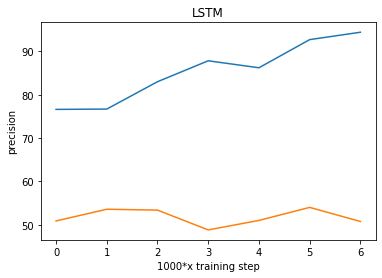

precision of the model on thevalidationdata: 50.732460021972656%
tensor([0.9882, 0.9774, 0.5254, 0.9998, 0.9233, 0.5546, 0.6541, 0.5329, 0.8782,
        0.5791, 0.7057, 0.6104, 0.7669, 0.5578, 0.6111, 0.8002, 0.9521, 0.9651,
        1.0000, 0.9997, 0.8256, 0.5002, 0.5883, 0.6115, 0.9471, 0.9461, 0.5427,
        0.9962, 0.7841, 0.7369, 0.7132, 0.9627, 0.5941, 0.5199, 0.5882, 0.6013,
        0.5114, 0.9680, 0.8859, 0.8597, 0.8037, 0.6217, 0.9884, 0.6438, 0.9809,
        0.9830, 0.8205, 0.7705, 0.6552, 0.9565, 0.5447, 0.6123, 0.9893, 0.9127,
        0.9322, 0.5150, 0.5062, 0.5181, 0.8494, 0.7053, 0.7669, 0.9999, 0.9990,
        1.0000, 0.9998, 0.8746, 0.9936, 0.9992, 0.6666, 0.6842, 0.5781, 0.9028,
        0.9573, 0.9939, 0.9739, 0.9978, 0.8455, 0.6236, 0.9530, 0.9837, 0.6553,
        0.7535, 0.5730, 0.5317, 0.8381, 0.7043, 0.9011, 0.9995, 1.0000, 0.9464,
        0.9911, 0.7732, 0.9993, 0.7007, 0.5073, 0.7521, 0.7187, 0.5021, 0.5900,
        0.6121], device='cuda:1')
current i is 77
Filte

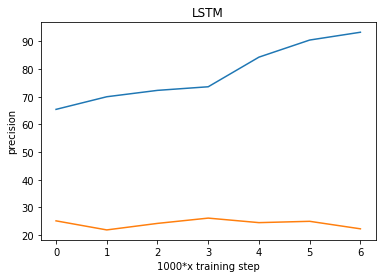

precision of the model on thevalidationdata: 25.560537338256836%
tensor([0.5959, 0.9998, 0.9998, 0.9998, 0.8601, 0.9991, 0.8919, 0.9999, 0.8870,
        0.9994, 0.9954, 0.9999, 0.9995, 0.8997, 0.9984, 0.9999, 0.9998, 0.8880,
        0.9999, 0.9993, 0.6386, 0.9102, 0.9865, 0.9897, 0.9995, 0.9623, 0.9985,
        0.6854, 0.8105, 0.7582, 0.5827, 0.5177, 0.9995, 0.9996, 0.5190, 0.9122,
        0.9821, 0.9998, 0.9287, 0.9999, 0.9999, 0.8034, 0.9682, 0.9999, 0.9999,
        0.9835, 0.9985, 0.9995, 0.9996, 0.5126, 0.5963, 0.9981, 0.9772, 0.9996,
        0.9999, 0.9533, 0.9998, 0.9814, 0.9996, 0.9951, 0.9621, 0.9277, 0.9857,
        0.9984, 0.9663, 0.9981, 0.9987, 0.9506, 0.9816, 0.9999, 0.9984, 0.9997,
        0.8223, 0.9999, 0.9963, 0.8708, 0.8764, 0.9413, 0.9999, 0.9762, 0.9999,
        0.9935, 0.9999, 0.9993, 0.9342, 0.9663, 0.9999, 0.9891, 0.9230, 0.9960,
        0.9991, 0.9953, 0.9996, 0.8580, 0.9999, 0.8175, 0.9181, 0.9998, 0.9942,
        0.8556], device='cuda:1')
current i is 78
Filte

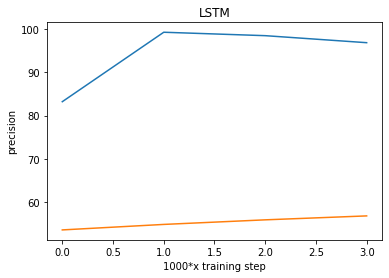

precision of the model on thevalidationdata: 54.964176177978516%
tensor([1.0000, 0.9999, 0.9999, 1.0000, 1.0000, 0.9916, 0.9997, 0.9947, 0.9878,
        1.0000, 0.9960, 1.0000, 0.7252, 0.9996, 0.6360, 0.9977, 1.0000, 0.9993,
        1.0000, 0.9494, 1.0000, 1.0000, 1.0000, 0.7607, 0.9693, 0.9593, 0.9995,
        0.9993, 0.9920, 0.5272, 1.0000, 0.6170, 0.9759, 1.0000, 0.9970, 0.9983,
        0.8954, 0.9999, 0.9908, 1.0000, 0.9999, 0.8056, 0.9998, 0.9997, 0.5499,
        1.0000, 1.0000, 0.8805, 0.9971, 1.0000, 1.0000, 0.8081, 0.9553, 0.9895,
        0.9414, 0.9967, 1.0000, 0.9970, 0.9999, 0.9999, 0.9985, 0.9993, 0.9999,
        0.8151, 0.9806, 0.9998, 0.8985, 0.9994, 0.8019, 0.9939, 0.9909, 0.9315,
        0.9999, 0.9860, 1.0000, 0.9999, 1.0000, 0.9998, 0.9950, 1.0000, 0.9998,
        1.0000, 0.8783, 0.7695, 0.9945, 1.0000, 0.9680, 0.5417, 0.9967, 0.6710,
        0.9184, 0.9682, 0.9993, 0.7504, 0.9990, 0.9133, 0.9997, 0.9972, 0.9880,
        1.0000], device='cuda:1')
current i is 80
Filte

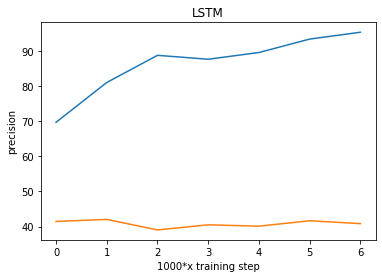

precision of the model on thevalidationdata: 40.701072692871094%
tensor([0.8785, 0.9963, 0.9628, 0.9839, 0.5111, 0.9283, 0.8831, 0.9831, 0.8937,
        0.9639, 0.8468, 0.9937, 0.6261, 0.9411, 0.9467, 0.7829, 0.6873, 0.9915,
        0.9885, 0.9987, 0.7911, 0.9993, 0.6502, 0.9878, 0.8885, 0.8990, 0.7790,
        0.9985, 0.9685, 0.6130, 0.9693, 0.9998, 0.5273, 0.9757, 0.9143, 0.9991,
        0.8468, 0.9980, 0.9551, 0.9428, 0.9954, 0.6061, 0.8923, 0.9796, 0.9985,
        0.9956, 0.5009, 0.9963, 0.9977, 0.7633, 0.9922, 0.7118, 0.9971, 0.8136,
        0.9256, 0.9980, 0.6193, 0.9454, 1.0000, 0.9818, 0.6573, 0.9708, 0.8966,
        0.5113, 0.5712, 0.9994, 0.7477, 0.7540, 0.5840, 0.9962, 0.5309, 0.9664,
        0.9813, 1.0000, 0.7575, 0.9730, 0.9488, 0.9986, 0.9946, 0.9873, 0.8759,
        0.9986, 0.7512, 0.9968, 0.6689, 0.9806, 0.5906, 0.8374, 0.9798, 0.5211,
        0.9681, 0.8515, 0.9881, 0.9964, 0.9544, 0.5133, 0.9408, 0.9960, 0.9724,
        0.9978], device='cuda:1')
current i is 81
Filte

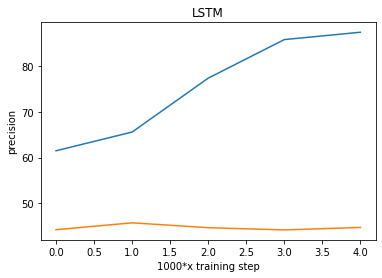

precision of the model on thevalidationdata: 45.4945068359375%
tensor([0.8365, 0.8716, 0.7260, 0.7066, 0.9889, 0.9808, 0.6659, 0.9958, 0.9992,
        0.9966, 0.9999, 0.9947, 0.5565, 0.9879, 0.9939, 0.9778, 0.9997, 0.7170,
        0.9999, 0.9998, 0.8317, 0.8039, 0.9225, 0.7542, 1.0000, 1.0000, 0.9989,
        0.9649, 0.8720, 0.9888, 0.9997, 0.9995, 1.0000, 0.8075, 0.9869, 0.8398,
        0.9768, 1.0000, 0.6202, 0.9995, 0.9889, 0.9905, 0.9606, 0.7320, 0.9993,
        0.9558, 0.9997, 0.9993, 0.9081, 0.9984, 0.9999, 0.9827, 0.8637, 0.7155,
        0.9918, 0.9430, 0.9877, 0.9999, 0.5176, 0.8583, 0.9998, 0.9966, 0.5941,
        0.9991, 0.9908, 0.8427, 0.9593, 0.8442, 0.8840, 0.9996, 0.9670, 0.9988,
        0.9970, 0.9793, 0.9908, 0.9305, 0.7513, 0.9609, 0.5462, 0.9981, 1.0000,
        0.9994, 0.8826, 0.9996, 0.8559, 0.5692, 0.7481, 0.5642, 0.7403, 0.9357,
        0.9649, 0.9999, 0.5628, 0.9958, 0.9983, 0.9827, 0.9997, 0.9998, 0.9998,
        0.9862], device='cuda:1')
current i is 83
Filter 

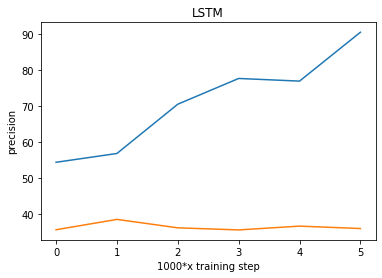

precision of the model on thevalidationdata: 36.62628173828125%
tensor([0.9975, 0.9998, 0.9730, 0.9963, 0.9995, 0.9992, 0.9989, 0.9252, 0.9996,
        0.9946, 0.9005, 0.9827, 0.7617, 0.5689, 1.0000, 0.9900, 0.9972, 0.9843,
        0.9853, 0.9998, 0.9999, 0.9998, 0.8917, 1.0000, 0.9862, 0.9997, 0.9948,
        0.9999, 0.9598, 0.9874, 0.9999, 0.9901, 0.9436, 0.6909, 0.9526, 0.9580,
        0.9997, 0.9698, 0.9938, 0.9947, 0.9992, 0.9997, 0.5207, 0.9924, 0.6542,
        0.8470, 0.9925, 0.8315, 1.0000, 0.9982, 0.9997, 0.9541, 0.9893, 0.9993,
        0.5457, 0.9993, 0.9992, 0.9565, 0.9988, 1.0000, 0.8213, 0.9998, 0.9374,
        0.7755, 0.9997, 0.8191, 0.9858, 0.9962, 1.0000, 0.9950, 0.8181, 0.7347,
        0.9885, 0.9989, 0.9968, 0.9985, 0.6695, 0.7238, 0.9999, 0.9999, 0.9313,
        0.8052, 0.9872, 0.9960, 0.9978, 0.9998, 0.7419, 0.8302, 0.7711, 0.7770,
        0.9978, 0.9937, 0.8109, 0.9162, 0.8727, 0.6526, 0.7408, 0.9655, 1.0000,
        0.9779], device='cuda:1')
current i is 84
Filter

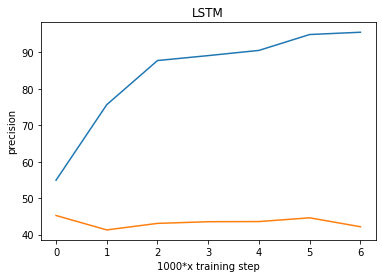

precision of the model on thevalidationdata: 44.39691925048828%
tensor([0.9998, 0.9992, 0.9999, 1.0000, 0.9970, 0.9792, 0.9773, 0.7134, 0.9897,
        0.7993, 0.7965, 0.6065, 0.8421, 0.9331, 0.9920, 0.9784, 0.9255, 0.9981,
        0.6698, 0.6792, 0.6650, 0.8027, 0.6181, 0.5406, 0.5457, 0.7264, 0.7116,
        0.9957, 0.9992, 0.9163, 0.6645, 0.5238, 0.6250, 0.9973, 0.6069, 0.9921,
        0.9811, 0.9997, 0.9884, 0.9863, 0.9838, 0.5281, 0.8892, 0.7319, 0.7344,
        0.9983, 0.7353, 0.9983, 0.9794, 0.7066, 0.9978, 0.9992, 0.7808, 0.9869,
        1.0000, 0.9840, 0.8568, 0.9604, 0.5052, 0.5786, 0.5580, 0.6523, 0.8047,
        0.9955, 1.0000, 0.9999, 0.9016, 0.9996, 1.0000, 0.6134, 0.5497, 0.5108,
        0.8959, 0.9879, 0.9878, 0.6903, 0.7049, 0.6902, 0.9903, 0.9929, 0.9732,
        0.9755, 0.8593, 0.5347, 0.9996, 0.5650, 0.8046, 0.9999, 0.8686, 0.9984,
        0.6582, 0.5665, 0.5665, 0.7499, 0.7748, 0.6511, 0.6884, 0.7785, 0.8247,
        0.6990], device='cuda:1')
current i is 85
Filter

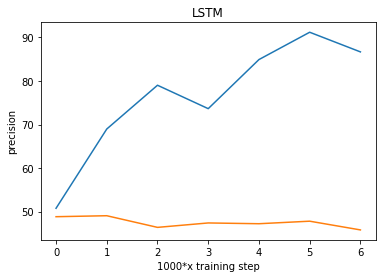

precision of the model on thevalidationdata: 45.498008728027344%
tensor([0.7145, 0.5683, 0.9993, 0.9933, 0.5997, 0.9980, 0.9950, 0.9730, 0.9605,
        0.9997, 0.8896, 0.7166, 0.6566, 0.9925, 0.9710, 0.9990, 0.9986, 0.9983,
        0.9998, 0.9979, 0.9447, 0.9980, 0.9996, 0.9995, 0.9924, 0.8142, 0.9363,
        0.7844, 0.8017, 0.7035, 0.9853, 0.9466, 0.8901, 0.9991, 0.9940, 0.6003,
        0.9778, 0.7889, 0.7387, 0.9936, 0.9472, 0.9997, 0.9931, 0.9968, 0.9600,
        0.9082, 0.8130, 0.9854, 0.9993, 0.9638, 0.9999, 0.9975, 0.9954, 0.5864,
        0.9931, 0.8273, 0.9973, 0.9548, 0.9480, 0.6845, 0.8067, 0.9999, 0.9987,
        0.9957, 0.9671, 0.9640, 0.9991, 0.6380, 0.9405, 0.9999, 0.9865, 0.9994,
        0.9987, 0.9806, 0.9994, 0.9718, 0.9994, 0.9873, 0.7140, 0.7694, 0.9987,
        0.9889, 0.9957, 0.9874, 0.9998, 0.9996, 0.9989, 0.9705, 1.0000, 0.9987,
        0.9998, 0.6875, 1.0000, 0.5271, 0.9998, 0.6655, 0.9968, 0.7954, 0.9995,
        0.9995], device='cuda:1')
current i is 86
Filte

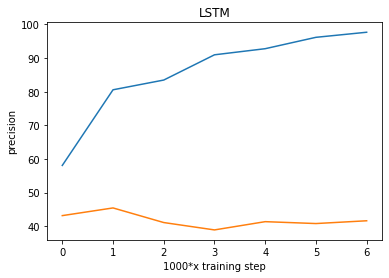

precision of the model on thevalidationdata: 41.204437255859375%
tensor([0.9998, 0.9981, 1.0000, 0.9999, 0.9311, 1.0000, 0.9939, 0.9996, 0.9966,
        0.7551, 0.5727, 0.9997, 0.9790, 0.9265, 0.9805, 0.8455, 0.9973, 0.9976,
        0.9988, 0.9998, 0.8065, 0.8740, 1.0000, 0.8980, 1.0000, 0.9757, 0.9945,
        0.9807, 0.9954, 0.7385, 0.5120, 0.9837, 0.7125, 0.9359, 0.7288, 0.9989,
        0.9986, 0.9506, 0.9061, 0.9991, 0.6178, 0.5100, 0.7954, 0.8844, 0.8236,
        0.9819, 0.9925, 0.9987, 0.9988, 0.9984, 0.9193, 0.7545, 0.9558, 0.8865,
        0.9977, 0.8377, 0.9673, 0.9683, 0.9964, 0.9987, 0.9973, 1.0000, 0.9986,
        0.9919, 0.9995, 1.0000, 0.9260, 0.9999, 0.9968, 0.9984, 0.9984, 0.9927,
        0.9732, 0.9999, 0.9030, 0.9958, 0.9281, 0.9988, 0.9997, 0.9998, 1.0000,
        0.9744, 0.9305, 0.9999, 0.9969, 0.5915, 1.0000, 0.9933, 0.9955, 0.7443,
        0.9885, 0.9999, 0.9577, 0.9613, 0.9990, 0.9915, 0.9938, 1.0000, 0.6215,
        0.9384], device='cuda:1')
current i is 87
Filte

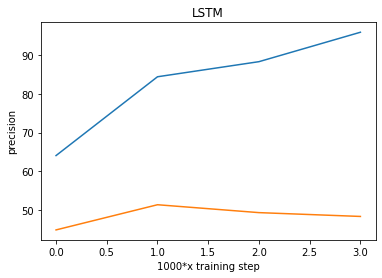

precision of the model on thevalidationdata: 47.832584381103516%
tensor([0.9951, 0.9999, 0.9988, 0.9993, 0.9999, 0.6753, 0.9984, 0.5877, 0.9394,
        0.9999, 0.7943, 0.9292, 0.9100, 0.6219, 0.9985, 0.9999, 0.7247, 0.9982,
        0.9735, 0.9991, 0.9377, 0.9987, 0.7281, 0.9998, 0.5026, 0.5014, 0.9764,
        0.5514, 0.8262, 0.9565, 0.9859, 0.9995, 0.9994, 0.9979, 0.9997, 0.9990,
        0.9978, 0.9993, 0.9927, 0.9999, 0.9891, 0.9923, 0.8197, 0.9345, 0.5615,
        0.6234, 0.9999, 0.9986, 0.9242, 0.9996, 0.7556, 0.9970, 0.9948, 0.9997,
        0.7429, 0.9997, 0.9996, 0.7609, 0.9993, 0.9942, 0.9986, 0.9997, 0.8492,
        0.9167, 0.9999, 0.6942, 0.9998, 0.8160, 0.9973, 0.9999, 0.8950, 0.9970,
        0.9999, 0.9996, 0.9988, 0.9996, 0.5430, 0.8811, 0.9993, 0.6017, 0.9911,
        0.9999, 0.9427, 0.9993, 0.9999, 0.9992, 0.9152, 0.6357, 0.5127, 0.9990,
        0.5673, 0.9922, 0.9963, 0.6159, 0.9982, 0.9992, 0.9999, 0.8782, 0.9990,
        0.9477], device='cuda:1')
current i is 88
Filte

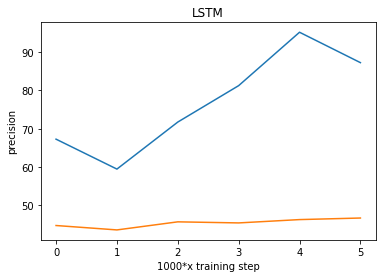

precision of the model on thevalidationdata: 46.823768615722656%
tensor([0.9997, 0.9875, 0.9080, 0.9963, 0.9999, 0.9894, 0.5749, 0.8083, 0.9227,
        0.7737, 0.9254, 0.8344, 0.7370, 0.6686, 0.9142, 0.9613, 0.8349, 0.9610,
        0.5280, 0.9309, 0.8948, 0.9974, 0.9294, 0.7811, 0.9989, 0.9752, 0.9997,
        0.9361, 0.9914, 0.8432, 0.9968, 0.9996, 0.8074, 0.9901, 0.6072, 0.9985,
        0.5347, 0.9993, 0.9990, 0.8741, 0.7262, 0.9482, 0.9201, 0.9631, 0.9494,
        0.7818, 0.5867, 0.7449, 0.9998, 0.9958, 0.9118, 0.9852, 0.9999, 0.9998,
        1.0000, 0.9993, 0.9394, 0.9969, 0.9049, 1.0000, 0.8114, 0.6106, 0.9775,
        0.9999, 0.9942, 0.9218, 0.9918, 0.9999, 0.9992, 0.7972, 0.6522, 0.8649,
        0.9889, 0.6565, 0.9953, 0.9999, 0.9996, 0.9887, 0.9845, 0.9112, 0.9720,
        0.9362, 0.5929, 0.9039, 0.7165, 0.7426, 0.5892, 0.9998, 0.9996, 0.9993,
        0.9993, 1.0000, 0.9990, 0.9987, 0.9073, 0.9416, 0.9937, 0.8875, 0.6233,
        0.8314], device='cuda:1')
current i is 89
Filte

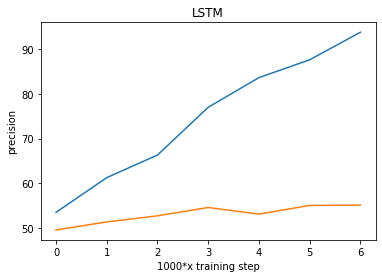

precision of the model on thevalidationdata: 55.04241180419922%
tensor([0.7479, 0.9545, 0.9716, 0.9999, 0.9999, 0.9541, 0.7434, 0.9998, 0.9799,
        0.9983, 0.8816, 0.9264, 0.9999, 0.9999, 0.9910, 0.9800, 0.7698, 0.9655,
        0.8984, 0.8581, 0.5327, 0.5741, 0.9998, 1.0000, 0.5655, 0.8915, 0.6638,
        0.6289, 0.6692, 0.8906, 0.9832, 1.0000, 0.9907, 0.9295, 0.8992, 0.7321,
        0.8872, 0.9999, 0.9901, 0.7120, 0.9981, 1.0000, 1.0000, 0.8693, 0.9995,
        0.9852, 0.9998, 0.9998, 0.9998, 1.0000, 0.9999, 1.0000, 0.9996, 0.9381,
        1.0000, 0.9955, 0.9776, 0.5926, 0.9959, 0.7697, 0.9956, 0.9999, 0.6716,
        0.9022, 0.8585, 0.9799, 0.9794, 0.9889, 0.9547, 0.9918, 0.9999, 0.9996,
        0.8274, 0.9909, 0.6345, 0.9596, 0.9386, 0.9996, 0.9769, 0.8757, 0.9695,
        0.9340, 0.9947, 0.6919, 0.9939, 1.0000, 0.9999, 0.9970, 0.9974, 1.0000,
        0.8339, 0.9776, 0.9843, 1.0000, 0.9530, 0.9999, 0.7645, 0.9102, 0.9990,
        0.5162], device='cuda:1')


In [81]:
result = ResNet1D_LSTM_rolling_window(df_train_dict, df_valid_dict)

In [82]:
result_df_dict = transform_dict_to_df(result)

In [83]:
processed = pre_processing(result_df_dict)

1
            date      index     score  label  prediction
0     2013-03-14  000001.SZ  0.999184    1.0         1.0
1     2013-03-15  000001.SZ  0.997058    0.0         1.0
2     2013-03-18  000001.SZ  0.043454    0.0         0.0
3     2013-03-14  000002.SZ  0.999975    0.0         1.0
4     2013-03-15  000002.SZ  0.000721    1.0         0.0
...          ...        ...       ...    ...         ...
1833  2013-03-15  603077.SH  0.015624    0.0         0.0
1834  2013-03-18  603077.SH  0.535810    0.0         1.0
1835  2013-03-14  603766.SH  0.025394    1.0         0.0
1836  2013-03-15  603766.SH  0.000208    0.0         0.0
1837  2013-03-18  603766.SH  0.006129    1.0         0.0

[1838 rows x 5 columns]
2
           date      index     score  label  prediction
0    2013-04-15  000001.SZ  0.934111    0.0         1.0
1    2013-04-15  000002.SZ  0.999690    1.0         1.0
2    2013-04-15  000008.SZ  0.998070    0.0         1.0
3    2013-04-15  000009.SZ  0.305654    1.0         0.0
4    20

            date      index     score  label  prediction
0     2015-01-15  000001.SZ  0.697649    0.0         1.0
1     2015-01-16  000001.SZ  0.084893    1.0         0.0
2     2015-01-19  000001.SZ  0.015125    0.0         0.0
3     2015-01-15  000002.SZ  0.000332    0.0         0.0
4     2015-01-16  000002.SZ  0.231809    1.0         0.0
...          ...        ...       ...    ...         ...
1740  2015-01-16  603369.SH  0.924955    0.0         1.0
1741  2015-01-19  603369.SH  0.386051    1.0         0.0
1742  2015-01-15  603993.SH  0.561826    1.0         1.0
1743  2015-01-16  603993.SH  0.989983    1.0         1.0
1744  2015-01-19  603993.SH  0.012337    1.0         0.0

[1745 rows x 5 columns]
26
            date      index     score  label  prediction
0     2015-02-12  000001.SZ  0.999998    0.0         1.0
1     2015-02-13  000001.SZ  0.040006    0.0         0.0
2     2015-02-16  000001.SZ  0.999960    0.0         1.0
3     2015-02-12  000002.SZ  0.999999    1.0         1.0
4  

            date      index     score  label  prediction
0     2016-11-17  000001.SZ  0.987089    1.0         1.0
1     2016-11-18  000001.SZ  0.000645    1.0         0.0
2     2016-11-21  000001.SZ  0.000080    1.0         0.0
3     2016-11-17  000002.SZ  0.002816    1.0         0.0
4     2016-11-18  000002.SZ  0.296695    0.0         0.0
...          ...        ...       ...    ...         ...
1890  2016-11-18  603939.SH  0.122700    1.0         0.0
1891  2016-11-21  603939.SH  0.053858    1.0         0.0
1892  2016-11-17  603993.SH  0.985765    0.0         1.0
1893  2016-11-18  603993.SH  0.000031    0.0         0.0
1894  2016-11-21  603993.SH  0.001804    1.0         0.0

[1895 rows x 5 columns]
50
            date      index     score  label  prediction
0     2016-12-15  000001.SZ  0.746778    0.0         1.0
1     2016-12-16  000001.SZ  0.992778    0.0         1.0
2     2016-12-19  000001.SZ  0.000876    0.0         0.0
3     2016-12-15  000002.SZ  0.544755    1.0         1.0
4  

            date      index     score  label  prediction
0     2018-10-18  000001.SZ  0.007664    1.0         0.0
1     2018-10-19  000001.SZ  0.001126    0.0         0.0
2     2018-10-22  000001.SZ  0.922212    1.0         1.0
3     2018-10-18  000002.SZ  0.993258    1.0         1.0
4     2018-10-19  000002.SZ  0.075554    0.0         0.0
...          ...        ...       ...    ...         ...
2180  2018-10-19  603986.SH  0.284450    1.0         0.0
2181  2018-10-22  603986.SH  0.932285    0.0         1.0
2182  2018-10-18  603993.SH  0.254631    0.0         0.0
2183  2018-10-19  603993.SH  0.220447    1.0         0.0
2184  2018-10-22  603993.SH  0.273716    1.0         0.0

[2185 rows x 5 columns]
75
            date      index     score  label  prediction
0     2018-11-15  000001.SZ  0.620771    0.0         1.0
1     2018-11-16  000001.SZ  0.474082    1.0         0.0
2     2018-11-19  000001.SZ  0.764585    1.0         1.0
3     2018-11-15  000002.SZ  0.594442    1.0         1.0
4  

10
20
40
80
160


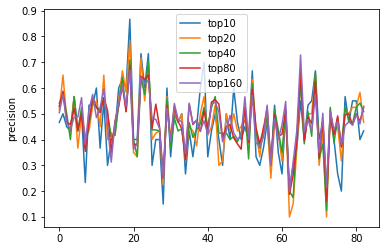

In [84]:
precision_diction = mult_k(processed,[10,20,40,80,160])

In [85]:
for i in precision_diction.keys():
    print('top'+str(i),'mean precision:',sum(precision_diction[str(i)])/len(precision_diction[str(i)]))

top10 mean precision: 0.45220883534136536
top20 mean precision: 0.4583333333333333
top40 mean precision: 0.4594299734147859
top80 mean precision: 0.46711809340356625
top160 mean precision: 0.4687716650189541


In [70]:
from wavenet import *

In [71]:
def wavenet_rolling_window(df_train_dict, df_valid_dict):
    softmax = nn.Softmax(-1)
    result = {}
    for i in range(1, len(df_train_dict)):
        print("current i is",i)
        temp_df = df_train_dict[str(i)].set_index(['trade_date', 'stock_code'])
        train_index_list, train_data_list, train_label_list = unroll_data(temp_df, 100, 8, debug=False)

        temp_df = df_valid_dict[str(i)].set_index(['trade_date', 'stock_code'])        
        valid_index_list, valid_data_list, valid_label_list = unroll_data(temp_df, 100, 8, debug=False)    
        if len(valid_data_list) == 0:
            continue
        train_index_list, train_data_list, train_label_list = nan_dele(train_index_list, train_data_list, train_label_list)
        valid_index_list, valid_data_list, valid_label_list = nan_dele(valid_index_list, valid_data_list, valid_label_list)
        print(train_data_list.shape, valid_data_list.shape)

        num_classes=2 
        in_depth=64 
        in_channels=42 
        skip_channels=64 
        dilation_depth=3 
        device= torch.device("cuda:1")
        batch_size=128
        learning_rate=0.0001
        num_epochs=1000
        device = torch.device("cuda:1")
        
        train_loader, valid_loader = load_data(
            train_index_list, train_data_list, train_label_list,valid_index_list, valid_data_list, valid_label_list, batch_size)
        
        lstm = WaveNet(num_classes, in_depth, in_channels, skip_channels, dilation_depth, device)
        lstm.to(device)
        # Loss and Optimizer
        loss_function = nn.CrossEntropyLoss()
        optimizer = torch.optim.Adam(lstm.parameters(), lr=learning_rate)

        _, _, model = training(lstm, num_epochs, train_loader,valid_loader, loss_function, optimizer, device, softmax)
        
        for _, images, labels in valid_loader:
            num,valid_pre, predicted=predict_precision(model,images,labels,device,predict_type='validation',softmax=softmax)
        #num = softmax(num)
        print(num[0:100])
        result[str(i)] = valid_index_list, num, predicted, valid_label_list
    
    return result

current i is 1
Filter large gap...
Time: 3.690
Unrolling Data...
Time: 2.191 s
Filter large gap...
Time: 2.890
Unrolling Data...
Time: 2.052 s
(4274, 42, 8) (1838, 42, 8)
precision of the model on thetrainingdata: 65.95744323730469%
precision of the model on thevalidationdata: 50.47801208496094%
precision of the model on thetrainingdata: 65.38461303710938%
precision of the model on thevalidationdata: 51.06951904296875%
precision of the model on thetrainingdata: 65.30612182617188%
precision of the model on thevalidationdata: 50.22222137451172%
precision of the model on thetrainingdata: 77.19298553466797%
precision of the model on thevalidationdata: 50.393699645996094%
precision of the model on thetrainingdata: 82.08955383300781%
precision of the model on thevalidationdata: 50.111358642578125%
precision of the model on thetrainingdata: 83.82353210449219%
precision of the model on thevalidationdata: 49.55849838256836%
precision of the model on thetrainingdata: 82.45613861083984%
precision

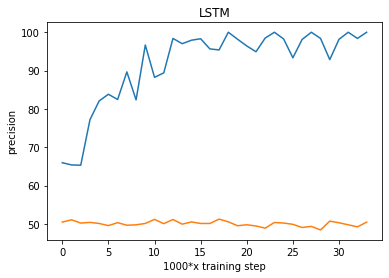

precision of the model on thevalidationdata: 50.469482421875%
tensor([0.9998, 0.6350, 0.8710, 0.8329, 0.6377, 1.0000, 0.9994, 0.5341, 0.8517,
        0.9473, 0.5687, 1.0000, 1.0000, 1.0000, 0.9974, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 0.9996, 0.6100, 0.9999, 0.6736, 0.9994, 0.7922, 0.8536,
        1.0000, 0.9775, 1.0000, 0.9890, 1.0000, 1.0000, 0.8596, 0.9998, 1.0000,
        0.9975, 0.9999, 1.0000, 0.9997, 0.7159, 1.0000, 0.9987, 1.0000, 1.0000,
        1.0000, 1.0000, 0.8293, 0.9706, 0.8115, 0.9567, 0.9996, 1.0000, 0.9971,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 0.9865, 1.0000, 0.9996, 1.0000,
        1.0000, 1.0000, 0.9996, 0.9831, 0.9613, 0.9998, 1.0000, 1.0000, 1.0000,
        0.9998, 1.0000, 0.9870, 0.9903, 0.9395, 0.9747, 0.9777, 0.5923, 1.0000,
        1.0000, 0.9319, 0.8794, 1.0000, 0.9877, 0.8546, 0.8421, 0.9791, 0.9787,
        1.0000, 1.0000, 0.9536, 1.0000, 1.0000, 0.9560, 0.9999, 0.9999, 1.0000,
        0.9982], device='cuda:1')
current i is 2
Filter la

precision of the model on thetrainingdata: 100.0%
precision of the model on thevalidationdata: 56.949153900146484%


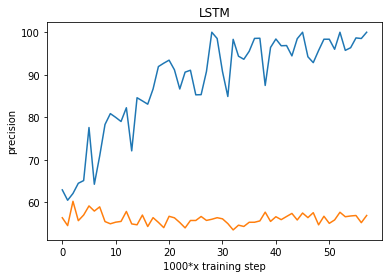

precision of the model on thevalidationdata: 56.949153900146484%
tensor([1.0000, 0.9948, 1.0000, 0.9747, 1.0000, 0.9982, 1.0000, 1.0000, 1.0000,
        0.9987, 0.9957, 0.9999, 0.9988, 0.9997, 1.0000, 0.6873, 0.9999, 1.0000,
        0.9603, 1.0000, 0.9392, 0.5186, 1.0000, 0.9285, 1.0000, 0.9441, 0.6091,
        0.9997, 0.9995, 1.0000, 1.0000, 0.9887, 0.9752, 0.9977, 0.9998, 0.9894,
        0.9521, 1.0000, 1.0000, 1.0000, 1.0000, 0.9999, 1.0000, 0.9850, 0.9966,
        0.9896, 0.5549, 0.7912, 0.7985, 0.8342, 1.0000, 0.9940, 0.8592, 1.0000,
        0.9275, 1.0000, 0.6971, 0.7064, 0.9973, 1.0000, 0.7649, 0.7748, 1.0000,
        1.0000, 0.9990, 0.7505, 1.0000, 0.9367, 1.0000, 0.9966, 0.9977, 1.0000,
        1.0000, 1.0000, 0.9928, 0.9802, 1.0000, 1.0000, 1.0000, 0.7670, 0.9746,
        0.9730, 0.9979, 0.6955, 0.9906, 0.9998, 0.7728, 0.9419, 0.8224, 0.9999,
        0.9511, 0.9799, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 0.9995, 0.9975,
        0.7463], device='cuda:1')
current i is 3
Filter

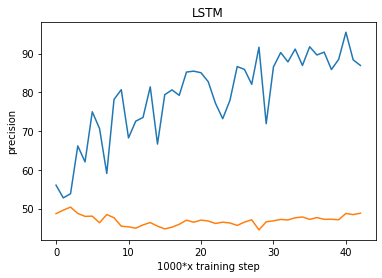

precision of the model on thevalidationdata: 48.81889724731445%
tensor([0.9557, 0.5800, 1.0000, 1.0000, 0.9415, 0.5247, 0.9185, 0.9999, 0.9772,
        0.9988, 0.9960, 0.9475, 0.9895, 0.9722, 0.9913, 1.0000, 1.0000, 0.9684,
        0.5784, 0.9971, 0.8541, 1.0000, 1.0000, 0.7498, 1.0000, 0.9387, 0.9885,
        0.8765, 0.6198, 1.0000, 0.6410, 0.6398, 0.9737, 0.9961, 1.0000, 0.9883,
        1.0000, 0.5978, 0.9445, 0.9983, 0.9953, 1.0000, 0.9989, 1.0000, 1.0000,
        0.7419, 0.5463, 0.9907, 1.0000, 1.0000, 0.9999, 0.9996, 0.6273, 0.9954,
        0.9966, 1.0000, 0.9999, 0.9991, 0.9688, 1.0000, 1.0000, 0.9587, 0.9531,
        1.0000, 1.0000, 1.0000, 0.5475, 0.5569, 0.7686, 1.0000, 1.0000, 1.0000,
        0.9999, 0.8507, 0.9682, 1.0000, 1.0000, 0.7619, 0.9999, 0.9817, 1.0000,
        1.0000, 1.0000, 0.9596, 0.9996, 0.9995, 1.0000, 0.9988, 1.0000, 0.9503,
        1.0000, 0.9971, 0.9688, 1.0000, 0.9999, 0.6350, 1.0000, 0.9999, 1.0000,
        1.0000], device='cuda:1')
current i is 5
Filter 

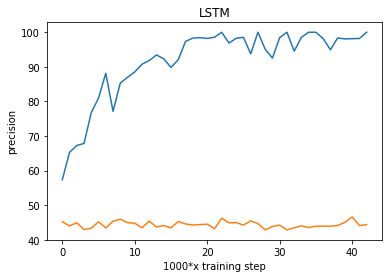

precision of the model on thevalidationdata: 44.36201858520508%
tensor([1.0000, 1.0000, 0.8886, 0.9824, 1.0000, 0.7138, 1.0000, 0.9997, 0.9785,
        0.9244, 0.9998, 0.9963, 0.9966, 0.9271, 1.0000, 0.8547, 0.6927, 0.9571,
        0.9994, 0.7689, 0.8771, 0.9999, 0.7859, 1.0000, 0.5002, 0.9909, 0.9982,
        1.0000, 1.0000, 1.0000, 0.9930, 1.0000, 0.9991, 0.7971, 0.9959, 0.6760,
        0.8596, 0.8128, 0.6605, 0.9997, 0.8645, 0.9946, 0.6150, 0.9999, 1.0000,
        0.9906, 0.8728, 1.0000, 1.0000, 0.9993, 0.9704, 0.7742, 0.8486, 0.9625,
        1.0000, 1.0000, 0.9999, 0.8589, 0.8925, 0.9999, 0.9990, 0.6020, 0.9580,
        1.0000, 0.9205, 0.9991, 1.0000, 1.0000, 1.0000, 0.8580, 0.8730, 0.9573,
        1.0000, 0.9771, 0.9932, 0.9998, 0.8482, 0.9980, 1.0000, 0.9992, 0.9983,
        0.9814, 0.9897, 0.7110, 1.0000, 1.0000, 0.9998, 0.9999, 1.0000, 0.9728,
        1.0000, 0.9850, 0.9913, 0.6464, 0.9852, 1.0000, 0.9985, 0.9980, 0.7308,
        1.0000], device='cuda:1')
current i is 6
Filter 

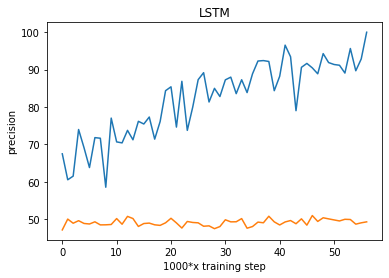

precision of the model on thevalidationdata: 49.315067291259766%
tensor([0.9030, 0.9160, 0.9964, 0.7738, 0.9599, 0.8647, 0.9964, 0.9963, 0.9900,
        0.5925, 0.9358, 0.9978, 0.9967, 0.8378, 0.9858, 0.9946, 0.9547, 0.5308,
        1.0000, 0.8711, 0.8137, 0.9995, 0.9979, 0.9304, 0.9976, 0.9901, 0.9994,
        0.9678, 0.6350, 0.9163, 0.8231, 0.9955, 1.0000, 0.6918, 0.5283, 0.9697,
        1.0000, 0.5023, 0.9981, 1.0000, 0.8400, 0.9697, 0.9987, 1.0000, 0.5195,
        0.8617, 0.5217, 0.9224, 0.8277, 0.9782, 0.5327, 0.6108, 0.9853, 0.9988,
        0.7333, 0.9960, 0.9929, 0.9169, 0.9998, 0.8991, 0.9509, 1.0000, 0.9580,
        0.6645, 0.9887, 0.9160, 1.0000, 0.7038, 0.9755, 0.9995, 0.9990, 0.9991,
        0.9999, 1.0000, 0.8033, 0.9564, 0.9858, 0.8632, 0.7038, 1.0000, 0.5292,
        0.9399, 0.9989, 0.9165, 0.9760, 0.9989, 0.9770, 0.9986, 0.7170, 0.8273,
        0.9945, 0.9460, 0.9759, 0.7552, 0.9967, 0.9035, 0.9776, 0.9949, 0.9802,
        0.9999], device='cuda:1')
current i is 7
Filter

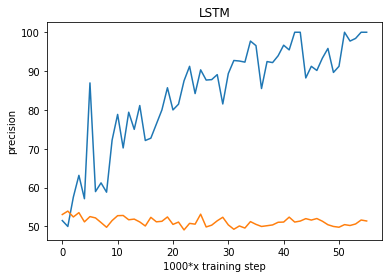

precision of the model on thevalidationdata: 51.408451080322266%
tensor([0.7623, 0.9576, 0.9993, 0.8861, 1.0000, 1.0000, 0.9995, 1.0000, 1.0000,
        0.9934, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 0.9978, 1.0000, 1.0000,
        0.7012, 0.9735, 0.9436, 0.5934, 0.9931, 0.9999, 0.9441, 0.9995, 0.6353,
        0.9697, 0.9997, 0.9944, 0.7816, 0.9310, 0.9992, 0.8584, 0.9073, 0.7775,
        0.9976, 1.0000, 0.9996, 0.8390, 0.9581, 0.9954, 0.6131, 0.8988, 0.8666,
        0.9008, 0.9972, 1.0000, 1.0000, 0.9999, 0.9959, 0.9998, 1.0000, 1.0000,
        0.9958, 1.0000, 0.7575, 1.0000, 1.0000, 0.9981, 0.7063, 0.9995, 1.0000,
        0.9368, 0.9992, 0.9972, 0.9095, 0.9853, 1.0000, 0.7301, 0.9545, 1.0000,
        0.9809, 0.9808, 0.9994, 0.9794, 0.9837, 0.9986, 0.9180, 1.0000, 0.9907,
        0.5349, 0.9571, 0.9967, 0.9980, 1.0000, 1.0000, 1.0000, 1.0000, 0.8516,
        0.8508, 1.0000, 0.9512, 0.9815, 0.9976, 0.9948, 0.9724, 0.8096, 1.0000,
        0.9895], device='cuda:1')
current i is 8
Filter

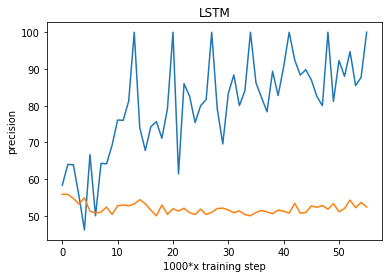

precision of the model on thevalidationdata: 52.380950927734375%
tensor([0.9301, 1.0000, 0.9649, 0.8446, 0.9997, 0.6971, 1.0000, 0.9538, 0.8790,
        1.0000, 0.9998, 1.0000, 0.8442, 0.9221, 0.9999, 0.9988, 0.9843, 1.0000,
        1.0000, 0.9995, 0.9219, 1.0000, 0.9976, 1.0000, 1.0000, 1.0000, 1.0000,
        0.7283, 0.9695, 0.9998, 0.9014, 0.8535, 1.0000, 0.5681, 0.7275, 1.0000,
        1.0000, 0.9376, 1.0000, 1.0000, 1.0000, 0.9957, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 0.9280, 1.0000, 0.9998, 0.9996, 0.9968, 1.0000, 0.7903,
        0.9988, 0.8877, 1.0000, 0.9976, 1.0000, 1.0000, 1.0000, 1.0000, 0.9997,
        0.9985, 0.8203, 0.5227, 0.7509, 1.0000, 1.0000, 0.5742, 1.0000, 0.9997,
        0.9904, 0.9985, 0.9064, 0.9524, 1.0000, 0.8449, 0.9235, 1.0000, 0.9996,
        0.9914, 1.0000, 0.8081, 1.0000, 0.9998, 0.9930, 1.0000, 0.9541, 0.5531,
        0.7244, 0.9669, 1.0000, 0.8435, 0.9878, 0.9987, 0.9999, 1.0000, 0.8668,
        0.5826], device='cuda:1')
current i is 9
Filter

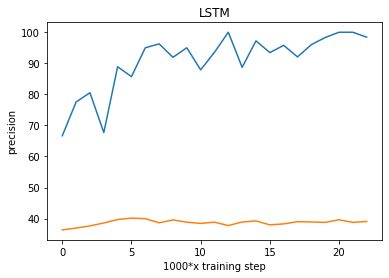

precision of the model on thevalidationdata: 39.06560516357422%
tensor([0.9802, 0.9414, 1.0000, 0.9985, 1.0000, 1.0000, 1.0000, 0.9920, 1.0000,
        0.7014, 0.9958, 1.0000, 1.0000, 1.0000, 0.9913, 0.9383, 0.9174, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 0.9987, 0.9998, 1.0000,
        0.9335, 1.0000, 1.0000, 1.0000, 0.9240, 0.9992, 0.9999, 0.9855, 1.0000,
        0.9412, 1.0000, 0.9866, 0.9928, 0.9952, 0.9988, 0.9732, 0.9868, 0.6939,
        0.9950, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 0.9440, 0.9915, 0.7736,
        1.0000, 1.0000, 1.0000, 0.9194, 0.6254, 0.9987, 0.9986, 0.9977, 1.0000,
        1.0000, 1.0000, 0.9999, 1.0000, 0.9232, 1.0000, 0.9875, 1.0000, 0.9989,
        0.9750, 0.9548, 0.9726, 0.9991, 1.0000, 0.9914, 0.9764, 0.9463, 0.9742,
        0.8675, 0.9879, 0.8658, 0.5061, 1.0000, 1.0000, 0.9139, 0.9799, 1.0000,
        1.0000, 0.9760, 0.9999, 0.9961, 0.9951, 1.0000, 0.5047, 0.9741, 1.0000,
        1.0000], device='cuda:1')
current i is 10
Filter

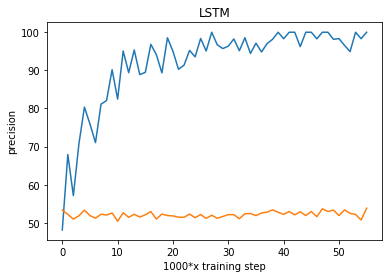

precision of the model on thevalidationdata: 53.846153259277344%
tensor([0.9988, 0.9999, 0.5085, 0.9988, 0.9625, 0.8684, 1.0000, 1.0000, 0.8245,
        0.6156, 1.0000, 0.9845, 0.9353, 0.9997, 0.9696, 0.9039, 0.8704, 0.9989,
        0.9998, 0.9993, 0.5983, 0.9449, 1.0000, 0.9774, 0.9998, 1.0000, 0.9999,
        0.9978, 0.9991, 0.9636, 0.9777, 1.0000, 1.0000, 0.8062, 0.8329, 0.9879,
        1.0000, 0.8801, 0.6607, 1.0000, 0.8855, 0.9295, 0.9544, 0.9997, 0.7916,
        0.9968, 1.0000, 0.9753, 1.0000, 0.5934, 0.9727, 0.9309, 1.0000, 0.7914,
        1.0000, 0.5918, 0.9970, 0.9999, 1.0000, 0.9999, 0.9998, 1.0000, 0.9354,
        0.5169, 0.9160, 1.0000, 0.9899, 0.9973, 0.9957, 0.9985, 0.9999, 0.9785,
        0.9577, 1.0000, 0.9959, 1.0000, 0.6671, 1.0000, 0.5451, 0.6102, 1.0000,
        0.5795, 0.8962, 0.9573, 1.0000, 0.8581, 0.9861, 0.5715, 0.9999, 0.9999,
        0.7806, 1.0000, 0.9999, 0.9992, 1.0000, 0.9771, 1.0000, 0.7875, 0.8235,
        0.9615], device='cuda:1')
current i is 11
Filte

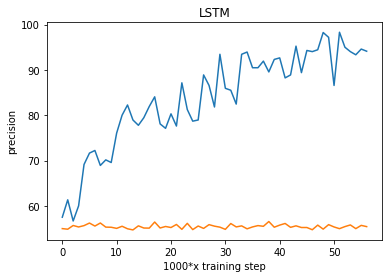

precision of the model on thevalidationdata: 55.42495346069336%
tensor([1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 0.9985,
        0.9753, 0.9991, 0.9983, 0.9780, 1.0000, 1.0000, 0.9913, 0.8944, 0.9081,
        0.9998, 0.9987, 0.7455, 1.0000, 1.0000, 0.9980, 0.9831, 0.7814, 0.5180,
        0.9985, 0.9998, 1.0000, 0.8330, 0.9992, 1.0000, 1.0000, 1.0000, 0.9968,
        0.6705, 1.0000, 0.9983, 1.0000, 1.0000, 0.9993, 0.9999, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 0.9966, 0.9984, 0.7932, 0.9999, 1.0000,
        0.5762, 0.9998, 0.7505, 1.0000, 1.0000, 1.0000, 0.8058, 1.0000, 1.0000,
        1.0000, 0.9982, 1.0000, 1.0000, 0.9709, 1.0000, 1.0000, 1.0000, 1.0000,
        0.7594, 1.0000, 0.9382, 0.9996, 1.0000, 1.0000, 1.0000, 0.9998, 1.0000,
        0.7443, 0.8114, 0.9997, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 0.9988, 1.0000, 0.8324, 1.0000, 1.0000, 0.9946, 1.0000, 1.0000,
        0.7890], device='cuda:1')
current i is 12
Filter

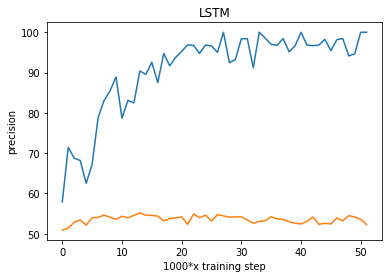

precision of the model on thevalidationdata: 52.26244354248047%
tensor([0.9992, 1.0000, 0.9646, 0.8271, 1.0000, 1.0000, 0.9997, 0.8850, 0.7154,
        0.6231, 0.9963, 1.0000, 0.7383, 0.9936, 1.0000, 0.9722, 1.0000, 1.0000,
        0.9958, 1.0000, 1.0000, 1.0000, 0.6867, 0.6378, 0.9901, 0.8708, 0.5381,
        0.9999, 0.9998, 1.0000, 0.6185, 0.9125, 0.6752, 0.5234, 0.9665, 0.9797,
        0.7983, 1.0000, 0.9999, 1.0000, 0.9998, 0.9959, 0.6089, 0.9964, 0.9998,
        1.0000, 0.9179, 0.9998, 1.0000, 0.9995, 0.9677, 0.9999, 0.8640, 0.9999,
        1.0000, 0.9992, 0.9964, 0.9999, 1.0000, 0.5136, 0.9807, 0.9966, 0.9726,
        0.9985, 1.0000, 1.0000, 1.0000, 0.9940, 0.9993, 0.7470, 1.0000, 1.0000,
        0.9883, 0.9999, 0.7402, 0.9976, 0.6138, 0.9998, 1.0000, 0.9972, 0.9993,
        0.8983, 1.0000, 0.9538, 1.0000, 0.7238, 1.0000, 1.0000, 1.0000, 1.0000,
        0.9691, 0.8448, 0.9970, 0.8566, 0.7091, 0.9360, 0.9026, 0.9799, 0.9832,
        0.9998], device='cuda:1')
current i is 13
Filter

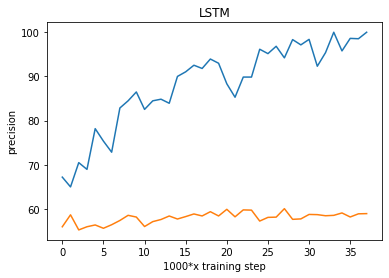

precision of the model on thevalidationdata: 58.955223083496094%
tensor([1.0000, 0.6353, 1.0000, 0.6266, 0.9723, 0.8440, 1.0000, 0.7585, 0.9967,
        0.9547, 0.7527, 0.8894, 0.8731, 1.0000, 1.0000, 1.0000, 1.0000, 0.9706,
        0.5159, 0.9629, 0.9998, 0.9931, 0.9983, 0.9180, 0.9955, 0.9999, 0.8057,
        0.7413, 0.7856, 0.6047, 0.5649, 0.9956, 1.0000, 0.9663, 0.8933, 0.8412,
        1.0000, 0.9993, 0.6140, 1.0000, 0.9995, 1.0000, 1.0000, 0.9998, 1.0000,
        1.0000, 1.0000, 1.0000, 0.6733, 1.0000, 1.0000, 0.8463, 0.9515, 0.9741,
        0.9962, 1.0000, 1.0000, 0.9987, 0.9999, 0.9633, 1.0000, 1.0000, 1.0000,
        0.9997, 0.9194, 0.9103, 0.5185, 0.9600, 0.8919, 1.0000, 0.5567, 0.9998,
        1.0000, 1.0000, 1.0000, 0.9999, 0.9581, 1.0000, 0.8412, 0.9208, 0.7863,
        0.9911, 0.5740, 0.7353, 1.0000, 0.9818, 1.0000, 0.9995, 0.9967, 0.8413,
        1.0000, 1.0000, 0.9707, 0.8919, 1.0000, 0.8519, 0.9960, 1.0000, 1.0000,
        1.0000], device='cuda:1')
current i is 15
Filte

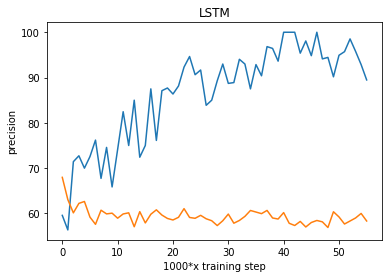

precision of the model on thevalidationdata: 58.33333206176758%
tensor([0.9926, 0.9983, 0.9329, 0.7707, 0.8639, 0.9237, 0.8893, 0.9938, 1.0000,
        0.9974, 0.5870, 0.6980, 0.8313, 0.5502, 0.9991, 0.9970, 1.0000, 0.5710,
        0.8685, 0.9998, 0.9875, 1.0000, 0.8773, 0.6588, 1.0000, 0.9999, 0.9995,
        0.9998, 0.8919, 0.9968, 0.9910, 1.0000, 0.9857, 0.9983, 1.0000, 0.9766,
        1.0000, 0.9494, 0.8901, 0.9412, 0.9968, 0.9999, 0.9728, 1.0000, 1.0000,
        0.9909, 1.0000, 0.9667, 0.9997, 0.8626, 1.0000, 0.7641, 0.5900, 0.9672,
        0.7639, 0.9858, 1.0000, 1.0000, 0.9972, 0.9691, 0.9627, 1.0000, 0.9750,
        0.9999, 0.9360, 1.0000, 0.9963, 0.8300, 0.7375, 1.0000, 0.6711, 0.8963,
        0.9781, 0.9144, 0.5155, 0.9977, 0.7838, 0.8644, 0.9300, 0.9936, 0.9976,
        0.9945, 0.9210, 0.9771, 0.9100, 0.8799, 0.9999, 0.9262, 0.9920, 0.9967,
        0.8481, 0.9003, 0.6831, 0.6518, 0.9737, 0.9697, 0.9343, 0.9994, 1.0000,
        0.8560], device='cuda:1')
current i is 16
Filter

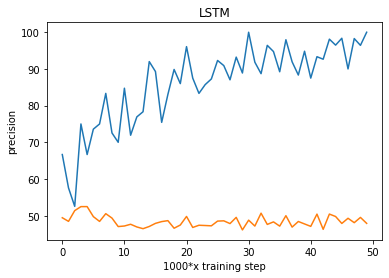

precision of the model on thevalidationdata: 47.906978607177734%
tensor([0.9452, 0.9999, 0.9946, 0.9151, 1.0000, 0.9546, 1.0000, 0.9999, 0.9997,
        0.9521, 0.5988, 0.7386, 1.0000, 0.9976, 0.9294, 1.0000, 0.7444, 1.0000,
        0.5966, 0.6757, 1.0000, 0.8204, 1.0000, 0.9999, 0.9996, 0.9986, 0.9996,
        1.0000, 0.9298, 0.9430, 0.9468, 0.7460, 1.0000, 0.9994, 0.9997, 0.7881,
        0.9841, 1.0000, 0.9007, 0.9838, 0.8196, 0.9545, 0.8941, 0.9494, 0.9670,
        0.9962, 1.0000, 0.9993, 0.6820, 1.0000, 1.0000, 0.9564, 1.0000, 1.0000,
        0.9759, 0.8749, 1.0000, 1.0000, 0.6938, 1.0000, 0.8427, 1.0000, 0.7094,
        1.0000, 0.6447, 0.8135, 0.9968, 1.0000, 1.0000, 0.9999, 0.9999, 1.0000,
        0.9904, 0.9996, 1.0000, 0.6570, 1.0000, 0.9069, 0.8927, 0.8896, 0.9997,
        1.0000, 1.0000, 1.0000, 0.6710, 0.9997, 0.7238, 0.9951, 0.8722, 1.0000,
        1.0000, 0.9921, 0.9932, 0.9997, 0.5749, 0.9776, 0.9998, 0.9965, 0.5074,
        0.9996], device='cuda:1')
current i is 17
Filte

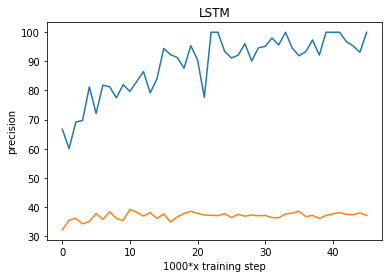

precision of the model on thevalidationdata: 37.0577278137207%
tensor([0.9994, 0.8820, 0.5963, 0.9997, 0.5173, 0.9999, 0.9739, 0.9999, 0.9223,
        0.8283, 1.0000, 1.0000, 0.8182, 0.7417, 0.9795, 0.9831, 0.9999, 0.6850,
        0.9625, 0.7951, 1.0000, 1.0000, 0.9692, 1.0000, 0.9993, 0.8020, 0.9895,
        0.9991, 1.0000, 0.9981, 0.9658, 0.6175, 1.0000, 0.9994, 0.9994, 0.9998,
        0.7048, 1.0000, 0.9999, 0.9931, 0.9443, 0.9998, 0.9995, 0.9971, 0.9989,
        1.0000, 0.9956, 0.5145, 1.0000, 0.9606, 0.8541, 0.9985, 1.0000, 0.9985,
        0.8762, 0.9974, 0.8497, 0.8726, 0.7209, 0.9816, 0.9989, 0.5813, 0.9655,
        0.9874, 0.9999, 0.6479, 0.9989, 0.9999, 0.9855, 0.7892, 0.9997, 0.9972,
        0.5960, 1.0000, 1.0000, 1.0000, 0.6613, 0.6143, 1.0000, 0.8022, 0.9204,
        0.6698, 0.9425, 0.9999, 0.9577, 0.6341, 0.9850, 1.0000, 1.0000, 0.7580,
        0.9086, 1.0000, 1.0000, 0.9865, 1.0000, 0.9992, 0.9996, 0.8778, 0.9304,
        0.7546], device='cuda:1')
current i is 18
Filter 

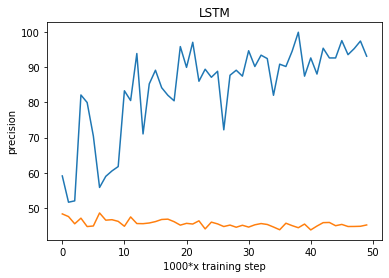

precision of the model on thevalidationdata: 45.140663146972656%
tensor([1.0000, 0.8781, 0.7295, 0.7499, 0.9519, 0.7241, 0.9937, 0.9342, 0.9993,
        0.9477, 0.6980, 0.9845, 0.9994, 0.9981, 0.5036, 0.7327, 0.7459, 0.9985,
        0.9917, 1.0000, 0.9096, 0.7860, 0.8834, 0.9998, 0.9994, 0.7865, 0.9871,
        0.8703, 0.9954, 0.9998, 0.9834, 0.7573, 0.9365, 0.9092, 0.6624, 0.7567,
        1.0000, 0.5570, 0.8422, 0.7990, 0.9999, 0.8932, 0.6413, 0.9238, 0.9998,
        0.7590, 0.9649, 0.9992, 0.9999, 0.9771, 0.5668, 0.6873, 0.9927, 0.7962,
        0.5362, 0.8345, 0.6802, 0.9993, 0.9961, 0.6386, 0.5991, 0.9215, 0.8392,
        0.9999, 0.8545, 0.9371, 0.5427, 0.9915, 1.0000, 0.9489, 0.9999, 0.5614,
        0.8839, 0.9752, 1.0000, 0.9752, 0.9977, 0.9991, 0.9629, 0.7717, 0.9810,
        0.9998, 0.5996, 0.9784, 0.9997, 0.8236, 0.9952, 0.9035, 0.9733, 0.9997,
        0.9946, 0.7363, 0.9228, 0.5223, 0.9869, 1.0000, 0.9859, 0.9770, 0.7141,
        0.9972], device='cuda:1')
current i is 19
Filte

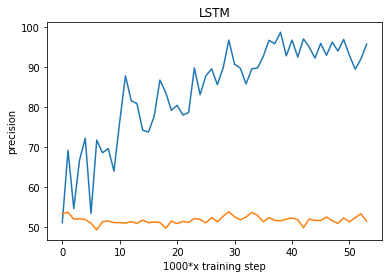

precision of the model on thevalidationdata: 51.411041259765625%
tensor([0.6698, 1.0000, 0.9548, 0.9762, 0.7135, 0.9997, 0.8911, 0.8415, 0.9889,
        0.9999, 0.9511, 0.7340, 0.9985, 0.9926, 0.9972, 0.9939, 0.9931, 0.9987,
        0.7850, 0.9823, 0.9995, 0.7848, 0.9999, 0.9817, 0.9639, 0.9820, 0.7548,
        0.9943, 0.9225, 0.9475, 0.9992, 0.9975, 0.9978, 0.9415, 0.6433, 0.6819,
        0.6867, 0.8640, 0.9971, 0.7464, 1.0000, 1.0000, 0.9997, 0.6571, 0.9736,
        0.7836, 0.9921, 0.5543, 0.5226, 0.8018, 0.6655, 0.8503, 0.9992, 0.9695,
        0.9808, 0.7805, 0.5362, 0.9448, 0.7621, 0.9963, 0.9506, 1.0000, 0.8247,
        0.9994, 0.8772, 0.8629, 0.7785, 0.9907, 0.9734, 1.0000, 1.0000, 0.9999,
        0.5175, 0.9825, 0.8184, 0.6890, 0.8339, 0.9885, 0.8927, 0.9593, 0.9352,
        0.8105, 0.9832, 1.0000, 0.5667, 0.9996, 0.5149, 0.9827, 0.9929, 0.9998,
        0.9998, 0.8664, 0.8314, 0.9798, 0.7694, 0.9874, 0.9995, 0.9450, 0.9637,
        1.0000], device='cuda:1')
current i is 20
Filte

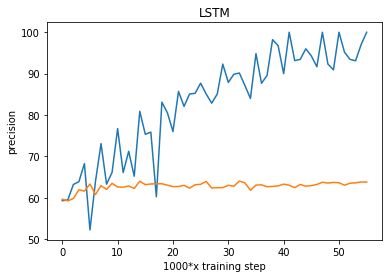

precision of the model on thevalidationdata: 63.77952575683594%
tensor([1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 0.9881, 0.9999, 1.0000,
        1.0000, 0.9986, 0.9997, 0.9675, 0.9380, 1.0000, 0.9999, 0.9999, 0.9859,
        0.9997, 0.9950, 0.6225, 0.9780, 1.0000, 1.0000, 0.9175, 1.0000, 0.9618,
        0.9989, 1.0000, 0.9963, 0.9061, 0.9957, 0.7071, 1.0000, 1.0000, 1.0000,
        0.9999, 0.8550, 0.8523, 1.0000, 0.9999, 0.5289, 0.9962, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 0.6168, 1.0000, 0.9967, 0.9853,
        0.9160, 0.6215, 1.0000, 1.0000, 0.9725, 0.9998, 1.0000, 0.9765, 1.0000,
        0.9978, 0.9930, 1.0000, 1.0000, 0.9999, 0.9988, 1.0000, 1.0000, 0.9999,
        1.0000, 1.0000, 1.0000, 0.9954, 0.9999, 0.5330, 0.9198, 1.0000, 1.0000,
        1.0000, 1.0000, 0.5066, 0.9961, 1.0000, 1.0000, 0.6708, 0.9932, 0.8090,
        0.9968, 0.9618, 0.9989, 0.9941, 0.9636, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000], device='cuda:1')
current i is 21
Filter

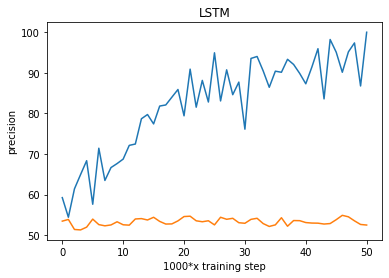

precision of the model on thevalidationdata: 52.50569534301758%
tensor([0.9991, 1.0000, 1.0000, 0.8906, 0.9969, 0.9992, 0.9913, 0.9649, 0.9993,
        0.9958, 0.8552, 0.6502, 0.9979, 0.9965, 1.0000, 0.9997, 0.5973, 0.9844,
        0.9975, 0.9634, 0.8927, 0.7944, 0.9855, 0.9997, 0.9413, 1.0000, 0.9692,
        0.9833, 0.9627, 0.7199, 0.9970, 0.9865, 0.5403, 0.9644, 0.9673, 1.0000,
        0.9685, 0.9662, 0.8431, 0.7880, 0.5096, 0.9747, 0.7408, 1.0000, 1.0000,
        0.9397, 0.9976, 0.5237, 0.7296, 0.9247, 0.9280, 0.9847, 0.9932, 0.9405,
        0.9822, 0.5628, 0.9998, 0.9499, 0.9995, 0.9993, 0.9983, 0.9333, 0.7406,
        1.0000, 0.9565, 0.9964, 0.9978, 0.9991, 0.7031, 0.9958, 0.9993, 1.0000,
        0.7752, 0.5893, 0.9985, 0.5235, 0.9726, 0.9968, 0.8567, 0.7059, 0.8054,
        1.0000, 0.7320, 0.9999, 0.9938, 0.6939, 0.6614, 0.9850, 0.5735, 0.9960,
        0.9289, 1.0000, 0.9659, 0.8616, 0.5648, 0.9999, 0.9999, 0.8621, 0.9981,
        0.9994], device='cuda:1')
current i is 22
Filter

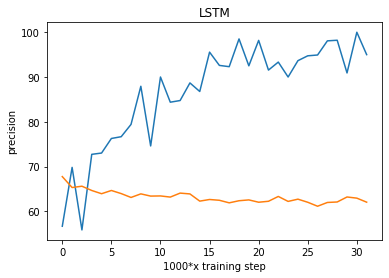

precision of the model on thevalidationdata: 62.04081726074219%
tensor([0.5539, 0.5837, 0.9956, 0.9997, 0.9990, 1.0000, 0.9855, 0.9760, 0.9929,
        0.9988, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 0.5041, 0.9999, 1.0000,
        1.0000, 0.9394, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 0.9999,
        1.0000, 1.0000, 0.9950, 1.0000, 0.9999, 0.9760, 0.9999, 0.9890, 1.0000,
        0.9991, 1.0000, 1.0000, 1.0000, 0.9999, 0.5750, 0.9984, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 0.8938, 0.9371, 1.0000, 0.9999, 0.7575, 1.0000,
        0.9875, 0.9999, 0.9398, 0.9995, 0.7657, 0.9470, 0.9072, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 0.8568, 1.0000, 1.0000, 0.9506, 1.0000, 0.9982,
        0.6991, 1.0000, 0.9141, 1.0000, 0.7894, 1.0000, 1.0000, 1.0000, 0.9990,
        0.9974, 0.9999, 1.0000, 0.8941, 1.0000, 1.0000, 1.0000, 1.0000, 0.9435,
        1.0000, 1.0000, 0.8943, 0.9001, 0.9998, 1.0000, 0.9737, 1.0000, 1.0000,
        1.0000], device='cuda:1')
current i is 23
Filter

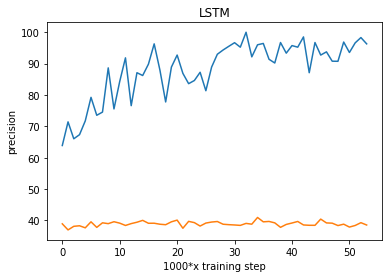

precision of the model on thevalidationdata: 38.54595184326172%
tensor([0.9999, 1.0000, 0.9529, 1.0000, 0.9996, 0.9972, 0.9744, 0.7153, 0.9764,
        0.7974, 1.0000, 0.9637, 0.9684, 0.9726, 0.9318, 0.9895, 0.9786, 0.7100,
        0.9879, 0.8148, 0.6853, 0.9996, 0.9336, 0.9999, 0.9997, 0.7811, 0.9771,
        1.0000, 1.0000, 0.7706, 1.0000, 0.9996, 0.6088, 0.9933, 0.8611, 0.9985,
        0.6978, 0.8911, 0.9959, 0.9997, 1.0000, 0.9905, 0.8911, 0.9997, 0.5116,
        0.7328, 0.9876, 1.0000, 0.6320, 0.7563, 0.9995, 0.7424, 1.0000, 0.8505,
        0.9354, 1.0000, 1.0000, 0.5241, 0.9191, 0.6042, 0.9998, 1.0000, 0.9506,
        1.0000, 1.0000, 1.0000, 1.0000, 0.9208, 0.9506, 0.9907, 1.0000, 0.9814,
        0.9820, 0.9631, 0.9978, 0.9804, 0.9963, 0.6370, 1.0000, 0.9402, 0.9999,
        1.0000, 0.9874, 0.9997, 0.9925, 0.9988, 0.8807, 0.9993, 0.8334, 0.7475,
        0.5234, 1.0000, 1.0000, 0.9951, 1.0000, 0.6471, 1.0000, 0.9630, 1.0000,
        0.9950], device='cuda:1')
current i is 24
Filter

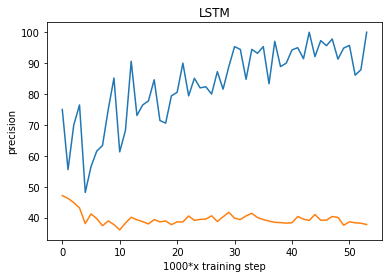

precision of the model on thevalidationdata: 37.761192321777344%
tensor([0.5903, 0.6465, 0.9994, 0.6343, 0.8940, 0.8115, 0.9958, 0.6322, 0.7646,
        0.9982, 0.9559, 0.6283, 0.6406, 1.0000, 0.9015, 0.9990, 0.8569, 0.9842,
        0.9999, 1.0000, 0.9810, 0.5305, 0.5478, 1.0000, 0.9516, 0.9804, 0.9792,
        1.0000, 0.9998, 0.9528, 0.9998, 0.8216, 0.8546, 0.9771, 0.8465, 0.9674,
        0.7758, 0.5354, 1.0000, 0.6046, 0.8779, 0.8902, 0.9991, 0.9591, 1.0000,
        0.9962, 0.9637, 0.9401, 0.8684, 0.8714, 0.9628, 1.0000, 0.9329, 1.0000,
        1.0000, 0.8411, 0.9931, 0.9903, 1.0000, 0.9928, 0.9937, 0.9978, 0.8666,
        0.9999, 0.9156, 0.9705, 0.8347, 0.9998, 0.9711, 1.0000, 0.9999, 1.0000,
        0.9975, 0.9763, 0.7572, 1.0000, 0.9183, 0.9853, 0.8975, 0.5303, 1.0000,
        0.6783, 1.0000, 0.9997, 1.0000, 0.9916, 1.0000, 1.0000, 0.9989, 0.9920,
        0.7927, 1.0000, 0.9997, 0.9905, 0.9790, 0.9997, 1.0000, 0.9995, 0.9967,
        0.7433], device='cuda:1')
current i is 25
Filte

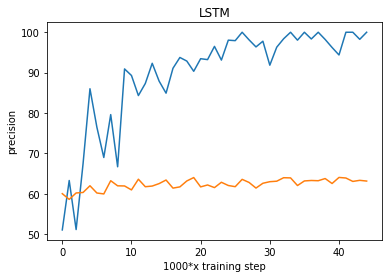

precision of the model on thevalidationdata: 63.125%
tensor([1.0000, 0.9894, 0.6942, 0.5515, 0.9985, 0.9787, 0.8683, 0.7720, 0.7356,
        0.9995, 1.0000, 1.0000, 1.0000, 0.9536, 0.6766, 0.9994, 1.0000, 1.0000,
        0.9114, 0.9945, 1.0000, 0.9998, 1.0000, 0.9977, 0.9800, 1.0000, 0.9618,
        0.5736, 1.0000, 1.0000, 1.0000, 0.9996, 1.0000, 0.9966, 0.7688, 1.0000,
        1.0000, 0.9844, 0.9998, 1.0000, 0.9958, 1.0000, 1.0000, 0.9926, 0.9755,
        0.7858, 1.0000, 1.0000, 0.8280, 1.0000, 0.9663, 0.9687, 0.6123, 0.5383,
        0.9965, 1.0000, 1.0000, 0.9999, 0.9915, 0.9953, 0.9999, 0.6743, 0.8583,
        0.9998, 0.9797, 1.0000, 0.8440, 1.0000, 0.9804, 0.9996, 0.6178, 1.0000,
        0.7645, 0.9890, 0.9965, 0.9998, 0.9999, 0.9997, 0.9998, 0.9980, 0.9994,
        0.9216, 0.9507, 0.7424, 1.0000, 1.0000, 0.9999, 0.9888, 1.0000, 1.0000,
        0.7936, 0.9993, 1.0000, 0.9978, 1.0000, 0.6090, 1.0000, 0.6100, 0.9384,
        0.6182], device='cuda:1')
current i is 26
Filter large gap.

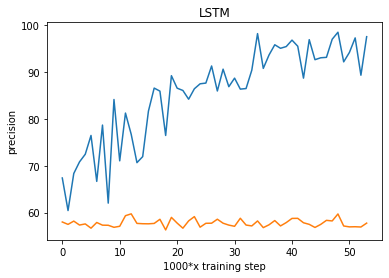

precision of the model on thevalidationdata: 57.754520416259766%
tensor([1.0000, 1.0000, 0.6759, 1.0000, 1.0000, 1.0000, 0.5136, 0.9918, 1.0000,
        1.0000, 0.9944, 0.7104, 0.6404, 0.8140, 0.9894, 0.9632, 1.0000, 0.6915,
        0.9888, 0.9998, 0.9529, 1.0000, 1.0000, 0.9986, 0.9340, 0.9970, 0.9677,
        0.9994, 0.9868, 0.5764, 1.0000, 1.0000, 0.5671, 0.9998, 0.9995, 0.9990,
        0.9989, 0.9954, 1.0000, 0.8618, 0.9991, 0.9989, 0.9434, 0.9913, 0.5363,
        0.9763, 0.9942, 0.9055, 0.9991, 0.9867, 0.6396, 0.9953, 0.9999, 1.0000,
        0.5152, 0.9990, 1.0000, 0.9021, 1.0000, 1.0000, 0.8026, 0.6986, 0.9761,
        0.9966, 0.9874, 0.8787, 0.8328, 0.9999, 1.0000, 0.9976, 0.9929, 0.6987,
        0.9848, 0.9985, 1.0000, 0.6217, 0.9987, 0.8733, 0.8393, 0.9855, 1.0000,
        0.8356, 1.0000, 0.6299, 0.9915, 0.9986, 0.9662, 0.9998, 0.6224, 1.0000,
        0.8720, 1.0000, 0.9998, 0.8648, 1.0000, 1.0000, 0.6625, 1.0000, 1.0000,
        1.0000], device='cuda:1')
current i is 27
Filte

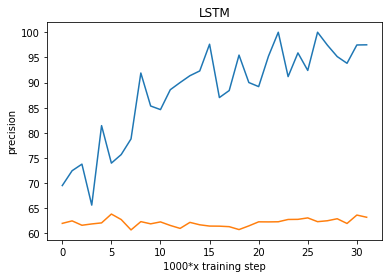

precision of the model on thevalidationdata: 63.20855712890625%
tensor([0.9963, 1.0000, 0.6269, 0.9678, 0.9992, 0.9999, 0.9940, 0.9999, 1.0000,
        0.9999, 0.8115, 0.9991, 0.9997, 0.9739, 0.9983, 0.9981, 0.9907, 1.0000,
        0.6879, 0.8727, 0.9955, 0.9604, 0.9994, 0.9996, 1.0000, 1.0000, 0.8252,
        1.0000, 0.9999, 0.9416, 0.9996, 0.7036, 0.9276, 0.9998, 0.9961, 1.0000,
        0.9992, 1.0000, 1.0000, 0.9739, 0.9992, 0.9990, 0.8001, 0.9946, 0.6049,
        1.0000, 1.0000, 0.6650, 1.0000, 0.9978, 1.0000, 1.0000, 0.9944, 0.9851,
        0.5050, 0.9422, 0.9999, 0.9999, 0.9772, 0.9982, 0.9987, 1.0000, 0.9994,
        0.6024, 0.9135, 0.9999, 0.8649, 0.9879, 0.5578, 0.8787, 0.9755, 0.9997,
        1.0000, 1.0000, 1.0000, 0.9711, 0.9361, 0.8415, 0.7840, 0.9247, 0.5797,
        0.9968, 0.9011, 0.7892, 1.0000, 0.9393, 0.9275, 0.9761, 1.0000, 0.9988,
        0.9614, 0.7849, 1.0000, 0.9943, 0.9993, 0.9996, 0.9929, 0.9997, 0.5686,
        1.0000], device='cuda:1')
current i is 28
Filter

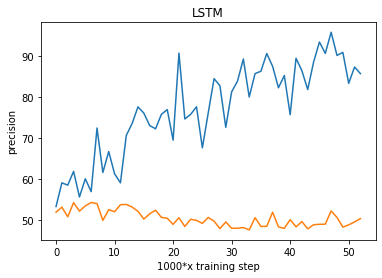

precision of the model on thevalidationdata: 50.260868072509766%
tensor([0.9744, 0.8601, 0.5230, 0.9958, 0.7526, 0.9966, 0.9980, 0.8892, 0.9996,
        0.9953, 0.9988, 0.9922, 0.5107, 0.7739, 0.7639, 0.6396, 0.6965, 0.5142,
        0.9863, 0.5673, 0.8193, 0.9619, 0.9998, 0.9722, 0.8283, 0.8358, 0.9999,
        1.0000, 0.9221, 0.7481, 0.5212, 0.9231, 0.9637, 0.7037, 0.9989, 1.0000,
        1.0000, 0.9644, 0.9999, 0.9968, 0.5732, 0.6822, 0.9810, 0.9784, 0.9994,
        0.9970, 0.9920, 0.9442, 0.9996, 1.0000, 0.5665, 0.9251, 0.5200, 0.9999,
        0.9557, 0.8276, 0.8782, 0.9787, 0.9932, 0.9094, 1.0000, 1.0000, 0.9840,
        0.9933, 0.7677, 0.9624, 0.9978, 0.9418, 0.7523, 0.8956, 0.9999, 0.9972,
        0.9887, 0.7875, 0.9434, 0.9688, 0.9992, 0.9871, 0.9432, 0.7181, 0.9755,
        0.7681, 0.9941, 1.0000, 0.9996, 0.9935, 0.7844, 0.9582, 0.8862, 0.8262,
        0.8942, 0.9907, 0.8367, 0.9912, 0.9678, 0.7368, 0.9944, 0.9927, 0.9998,
        0.9999], device='cuda:1')
current i is 29
Filte

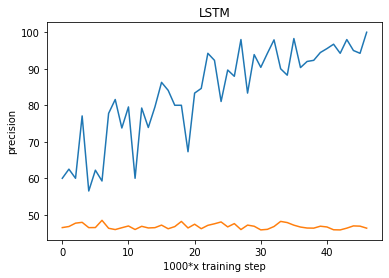

precision of the model on thevalidationdata: 46.33757781982422%
tensor([1.0000, 1.0000, 1.0000, 1.0000, 0.9895, 0.9970, 1.0000, 0.7494, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 0.9572, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 0.9890, 0.5759, 1.0000,
        0.9988, 1.0000, 0.9985, 1.0000, 1.0000, 0.8315, 0.9830, 1.0000, 1.0000,
        0.9993, 1.0000, 1.0000, 0.9936, 0.9963, 0.6853, 1.0000, 1.0000, 0.9400,
        0.9999, 0.9983, 1.0000, 0.9925, 0.9999, 1.0000, 0.9784, 1.0000, 0.9777,
        1.0000, 1.0000, 0.9410, 0.9823, 1.0000, 1.0000, 0.9723, 0.9550, 1.0000,
        1.0000, 0.9563, 0.9856, 0.9191, 0.8631, 1.0000, 1.0000, 0.9255, 0.8882,
        1.0000, 0.9838, 1.0000, 0.9268, 1.0000, 0.9756, 0.9998, 1.0000, 1.0000,
        0.9999, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 0.9993,
        1.0000, 0.9923, 1.0000, 1.0000, 0.7749, 0.9999, 1.0000, 1.0000, 0.9967,
        0.5647], device='cuda:1')
current i is 30
Filter

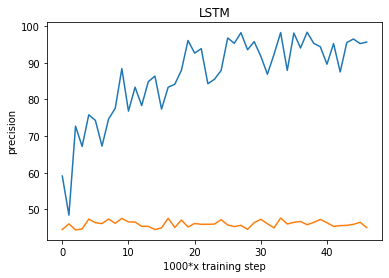

precision of the model on thevalidationdata: 45.036319732666016%
tensor([0.9983, 0.9976, 0.7235, 0.9992, 0.9981, 0.9725, 0.7848, 0.8048, 0.5490,
        0.9994, 0.9976, 0.9959, 1.0000, 0.9957, 0.5972, 1.0000, 0.8500, 0.5063,
        0.7362, 0.9953, 0.9786, 0.9551, 0.5789, 0.8692, 0.9047, 0.8687, 0.9773,
        0.9999, 1.0000, 0.5620, 0.9991, 0.9103, 0.9968, 0.5009, 0.9304, 0.9490,
        0.6168, 0.9918, 0.6310, 0.9957, 1.0000, 0.8200, 0.8163, 0.9124, 1.0000,
        0.9591, 1.0000, 0.9917, 0.9161, 0.9999, 0.9988, 1.0000, 0.9980, 0.8727,
        0.7401, 0.9965, 0.5244, 0.5794, 0.7119, 0.9395, 0.9965, 0.9996, 0.9978,
        0.5272, 0.9952, 0.9999, 0.8897, 0.5975, 0.9980, 0.9902, 0.7661, 0.9999,
        0.9752, 0.8108, 0.7148, 0.5427, 0.7912, 0.5870, 0.8823, 0.9910, 0.5298,
        0.5251, 0.8128, 0.8100, 0.9754, 1.0000, 1.0000, 0.7975, 0.9988, 0.6777,
        0.9999, 1.0000, 1.0000, 0.9567, 1.0000, 0.9995, 0.9889, 1.0000, 0.8715,
        0.8984], device='cuda:1')
current i is 31
Filte

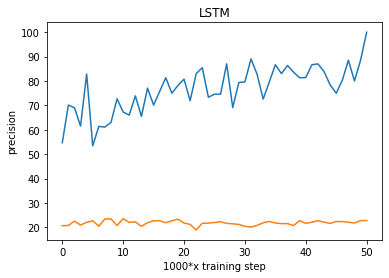

precision of the model on thevalidationdata: 22.799097061157227%
tensor([1.0000, 1.0000, 0.9882, 0.9907, 1.0000, 1.0000, 0.9984, 0.9912, 1.0000,
        0.9999, 1.0000, 1.0000, 1.0000, 0.9618, 1.0000, 1.0000, 0.9996, 0.9998,
        0.9889, 1.0000, 0.9999, 0.9176, 1.0000, 1.0000, 1.0000, 0.7866, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 0.9676, 1.0000,
        0.9997, 0.9760, 0.5190, 0.9997, 0.9838, 1.0000, 0.9975, 0.9997, 0.9461,
        0.7135, 0.9993, 1.0000, 1.0000, 0.7486, 0.9990, 1.0000, 0.9997, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 0.6253, 0.9998, 1.0000, 1.0000, 1.0000,
        0.7680, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 0.9999, 1.0000,
        1.0000, 1.0000, 0.9957, 1.0000, 0.8752, 1.0000, 1.0000, 0.9132, 1.0000,
        1.0000, 0.9999, 0.9945, 1.0000, 1.0000, 0.8863, 1.0000, 1.0000, 0.9999,
        1.0000, 1.0000, 1.0000, 0.9912, 0.7689, 0.7703, 1.0000, 0.9907, 1.0000,
        1.0000], device='cuda:1')
current i is 32
Filte

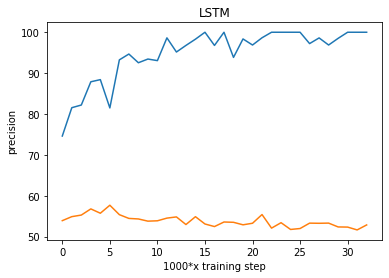

precision of the model on thevalidationdata: 52.8532600402832%
tensor([1.0000, 1.0000, 1.0000, 0.9977, 1.0000, 1.0000, 1.0000, 0.5595, 0.9999,
        0.9985, 1.0000, 0.9898, 0.9947, 0.9979, 0.9941, 0.9912, 0.9984, 0.9993,
        1.0000, 1.0000, 0.9962, 0.6722, 0.5237, 0.9783, 0.8874, 1.0000, 1.0000,
        0.7829, 1.0000, 0.9954, 0.9151, 0.9697, 0.9671, 0.9924, 0.9999, 1.0000,
        0.9989, 1.0000, 0.7511, 0.9853, 0.9997, 1.0000, 0.6184, 1.0000, 1.0000,
        0.9380, 0.9995, 1.0000, 1.0000, 0.9914, 0.9366, 0.9994, 0.9991, 0.9079,
        0.9993, 0.9999, 1.0000, 0.9786, 1.0000, 0.9605, 0.9890, 0.9971, 0.9949,
        1.0000, 0.9999, 0.9992, 0.7583, 0.9972, 0.7485, 0.5938, 0.8946, 1.0000,
        1.0000, 0.9653, 1.0000, 0.9994, 0.9777, 1.0000, 0.6660, 1.0000, 1.0000,
        0.9931, 0.9925, 0.9980, 1.0000, 0.9952, 1.0000, 0.9950, 1.0000, 0.9309,
        1.0000, 1.0000, 0.7435, 0.9999, 1.0000, 0.9999, 0.9739, 0.9996, 1.0000,
        0.6443], device='cuda:1')
current i is 33
Filter 

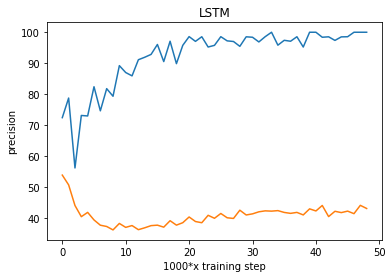

precision of the model on thevalidationdata: 43.18488693237305%
tensor([1.0000, 0.9054, 0.5098, 1.0000, 1.0000, 1.0000, 1.0000, 0.9684, 0.6234,
        1.0000, 0.9998, 1.0000, 1.0000, 0.8828, 0.9999, 1.0000, 1.0000, 0.9988,
        0.9995, 0.9992, 0.9996, 1.0000, 0.9975, 0.5610, 0.9253, 1.0000, 0.9397,
        1.0000, 0.9997, 0.8432, 1.0000, 0.9995, 0.9998, 1.0000, 0.9904, 0.9997,
        1.0000, 1.0000, 0.8752, 1.0000, 0.9994, 0.9671, 0.9912, 1.0000, 0.8184,
        1.0000, 1.0000, 0.8387, 1.0000, 1.0000, 0.7769, 1.0000, 1.0000, 0.9997,
        1.0000, 0.9998, 0.6765, 1.0000, 0.9914, 0.5449, 0.9933, 1.0000, 0.9899,
        1.0000, 0.8695, 0.9972, 0.9338, 1.0000, 0.8627, 1.0000, 1.0000, 0.8802,
        1.0000, 0.9998, 0.9469, 0.9952, 0.9800, 0.9722, 1.0000, 0.9774, 0.7739,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 0.9272, 0.7897, 0.9944, 1.0000,
        0.9963, 0.8268, 0.9680, 0.9933, 0.9995, 0.9886, 0.9923, 0.9999, 0.9929,
        1.0000], device='cuda:1')
current i is 34
Filter

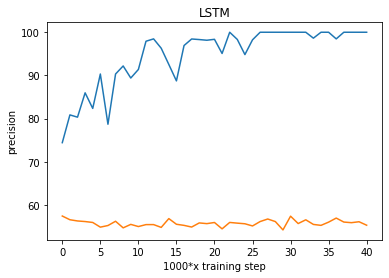

precision of the model on thevalidationdata: 55.29411697387695%
tensor([1.0000, 1.0000, 0.9321, 0.8110, 1.0000, 1.0000, 0.9793, 0.9994, 1.0000,
        0.9541, 1.0000, 0.6181, 1.0000, 1.0000, 0.6530, 0.9600, 0.9988, 1.0000,
        0.7106, 1.0000, 1.0000, 0.9568, 0.8684, 0.9998, 1.0000, 0.9761, 0.9789,
        0.9314, 0.9970, 1.0000, 1.0000, 1.0000, 1.0000, 0.6920, 0.9959, 0.9999,
        0.7398, 1.0000, 1.0000, 0.9999, 1.0000, 0.9993, 1.0000, 1.0000, 0.9113,
        0.9780, 0.8984, 0.9951, 0.9577, 1.0000, 0.9293, 0.9955, 0.9977, 0.9999,
        1.0000, 1.0000, 0.9995, 0.9948, 0.9815, 0.6727, 1.0000, 1.0000, 1.0000,
        0.9951, 0.9999, 0.9223, 0.9973, 0.7008, 1.0000, 1.0000, 1.0000, 0.6384,
        1.0000, 0.8158, 1.0000, 0.9913, 0.9996, 1.0000, 0.7328, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 0.9128, 0.7689, 0.9535, 1.0000, 1.0000,
        0.9239, 1.0000, 1.0000, 0.8445, 1.0000, 1.0000, 0.9382, 0.9997, 0.9994,
        0.9868], device='cuda:1')
current i is 35
Filter

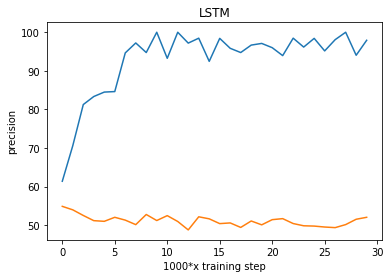

precision of the model on thevalidationdata: 52.01612854003906%
tensor([1.0000, 1.0000, 0.9986, 0.6815, 1.0000, 0.9999, 1.0000, 0.9999, 0.9387,
        0.9758, 1.0000, 0.9997, 1.0000, 0.9999, 0.9990, 1.0000, 0.9951, 0.7984,
        0.9999, 0.9705, 1.0000, 0.9576, 1.0000, 0.9997, 1.0000, 0.8739, 0.6811,
        0.7684, 0.9999, 0.9604, 0.5524, 1.0000, 0.9995, 0.9271, 1.0000, 0.9992,
        1.0000, 0.5771, 0.9999, 0.8988, 1.0000, 1.0000, 0.6939, 1.0000, 1.0000,
        0.7248, 0.9998, 0.8322, 0.9981, 1.0000, 0.9749, 0.9352, 0.9955, 0.9990,
        0.9989, 0.9994, 0.9974, 0.9883, 0.9991, 0.9929, 0.9999, 0.9885, 0.9991,
        0.9988, 0.7939, 0.7023, 0.9921, 0.9422, 0.9991, 0.9840, 0.6353, 0.8344,
        1.0000, 0.9553, 1.0000, 0.9454, 0.9319, 1.0000, 0.9974, 1.0000, 0.9130,
        1.0000, 0.9922, 1.0000, 1.0000, 1.0000, 0.9894, 0.9784, 0.7718, 1.0000,
        0.9974, 0.9948, 1.0000, 1.0000, 1.0000, 0.5184, 0.9912, 0.9619, 0.9552,
        0.9656], device='cuda:1')
current i is 36
Filter

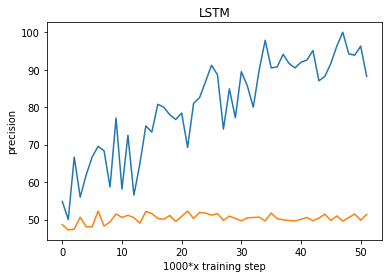

precision of the model on thevalidationdata: 51.39092254638672%
tensor([0.9614, 0.8169, 0.9223, 0.8773, 0.9991, 1.0000, 0.9999, 0.8286, 0.5259,
        1.0000, 0.9982, 0.8712, 0.9975, 0.9992, 0.9998, 0.9678, 0.9991, 0.9857,
        0.9936, 0.8465, 0.9913, 0.9931, 1.0000, 0.6038, 0.9305, 0.9998, 0.9775,
        0.9116, 0.8005, 0.9393, 0.9927, 0.9992, 0.8539, 0.9957, 0.7533, 0.7933,
        0.9993, 0.7331, 0.5379, 0.9996, 1.0000, 0.9992, 0.9929, 0.8809, 0.6161,
        1.0000, 0.6524, 0.9110, 0.9704, 0.9340, 0.9598, 0.9808, 0.9123, 0.9757,
        0.8142, 1.0000, 1.0000, 1.0000, 0.9995, 0.6384, 0.7929, 0.7329, 0.9158,
        0.8328, 0.7492, 0.9850, 0.9943, 0.8846, 0.9373, 0.9972, 1.0000, 0.9999,
        0.8135, 0.9987, 0.9992, 0.9564, 1.0000, 0.8186, 0.9605, 0.9999, 0.9770,
        0.9894, 0.9230, 1.0000, 1.0000, 0.9906, 1.0000, 0.7403, 0.9998, 0.8666,
        0.9950, 0.9853, 0.9850, 0.6566, 0.9737, 0.8982, 0.8360, 0.9669, 0.9741,
        0.9994], device='cuda:1')
current i is 37
Filter

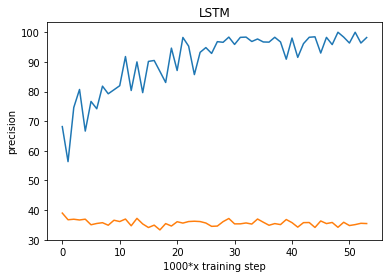

precision of the model on thevalidationdata: 35.48009490966797%
tensor([1.0000, 1.0000, 0.9999, 0.9863, 0.9999, 0.9998, 1.0000, 0.8772, 0.6813,
        1.0000, 0.6663, 0.9997, 0.9998, 1.0000, 0.9997, 0.9996, 0.9976, 0.7093,
        0.9999, 0.8003, 0.8283, 1.0000, 0.9906, 1.0000, 1.0000, 0.9924, 0.9994,
        0.6374, 0.8703, 0.6036, 1.0000, 0.7849, 0.7605, 0.7252, 0.8979, 0.5801,
        0.9996, 0.9863, 0.9101, 0.9398, 0.7165, 1.0000, 1.0000, 0.9850, 0.9995,
        0.9940, 0.9063, 1.0000, 0.6699, 0.5072, 0.9960, 0.9991, 1.0000, 1.0000,
        0.9440, 0.6152, 0.8377, 1.0000, 0.9709, 0.9928, 1.0000, 0.9188, 0.9039,
        0.9787, 0.9292, 1.0000, 1.0000, 0.5162, 1.0000, 0.9948, 0.9018, 0.9850,
        1.0000, 0.7668, 1.0000, 0.9887, 0.6034, 0.8976, 0.9561, 0.9805, 0.9137,
        1.0000, 0.9923, 0.9198, 0.7126, 0.7198, 0.9582, 0.9799, 0.9878, 0.9999,
        1.0000, 0.8545, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 0.9875, 0.9994,
        0.9996], device='cuda:1')
current i is 38
Filter

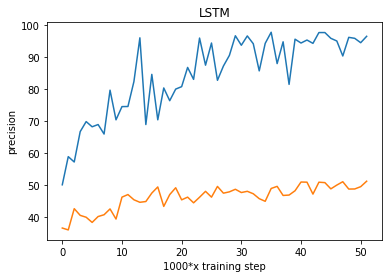

precision of the model on thevalidationdata: 51.12016296386719%
tensor([1.0000, 0.9994, 1.0000, 0.9996, 0.9985, 0.9999, 0.9820, 1.0000, 1.0000,
        0.7590, 0.9967, 1.0000, 1.0000, 0.9853, 1.0000, 1.0000, 0.9995, 0.8700,
        0.8814, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 0.9996, 1.0000,
        0.9950, 0.6589, 1.0000, 1.0000, 0.9987, 1.0000, 0.9318, 0.5105, 1.0000,
        1.0000, 0.8191, 1.0000, 0.9259, 0.9981, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 0.9043, 1.0000, 1.0000, 0.9906, 1.0000, 1.0000, 0.9711, 1.0000,
        0.9975, 0.9678, 0.9999, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        0.9977, 0.9962, 1.0000, 0.9997, 0.9995, 1.0000, 0.9414, 0.9997, 1.0000,
        1.0000, 1.0000, 0.9998, 0.9566, 0.9975, 1.0000, 0.9995, 0.7621, 0.9997,
        0.9998, 0.9894, 1.0000, 0.6034, 0.9975, 0.9973, 1.0000, 0.9856, 0.5539,
        0.9996, 1.0000, 1.0000, 0.5367, 1.0000, 1.0000, 1.0000, 1.0000, 0.9752,
        0.9999], device='cuda:1')
current i is 39
Filter

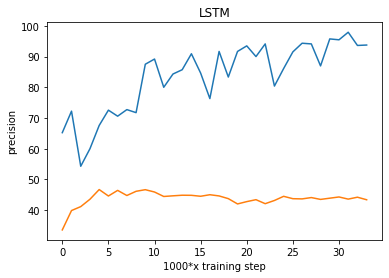

precision of the model on thevalidationdata: 43.37700271606445%
tensor([1.0000, 0.9999, 0.9984, 1.0000, 0.9596, 0.5530, 0.9911, 1.0000, 1.0000,
        0.9999, 1.0000, 1.0000, 0.9993, 1.0000, 1.0000, 1.0000, 0.9255, 1.0000,
        0.9827, 0.8955, 1.0000, 0.9809, 0.9941, 0.7218, 0.9999, 0.7612, 1.0000,
        1.0000, 1.0000, 0.5149, 1.0000, 1.0000, 1.0000, 0.8941, 1.0000, 0.9989,
        1.0000, 1.0000, 0.9107, 0.9235, 1.0000, 1.0000, 0.9998, 0.9997, 0.9044,
        0.9999, 0.9995, 0.5340, 0.9251, 1.0000, 0.9986, 0.9997, 1.0000, 0.9998,
        0.9222, 0.9934, 0.5786, 0.7203, 1.0000, 0.8967, 0.5566, 0.9618, 0.9930,
        1.0000, 1.0000, 1.0000, 0.9999, 0.5609, 1.0000, 0.9983, 0.9989, 0.5145,
        1.0000, 1.0000, 1.0000, 0.9999, 0.8762, 0.9996, 0.9866, 0.9365, 1.0000,
        0.6923, 1.0000, 0.9085, 0.5564, 1.0000, 0.8102, 0.9986, 0.9999, 0.9508,
        1.0000, 1.0000, 0.9952, 0.5790, 0.9999, 0.6386, 0.9999, 1.0000, 0.8123,
        1.0000], device='cuda:1')
current i is 41
Filter

precision of the model on thetrainingdata: 93.93939208984375%
precision of the model on thevalidationdata: 42.932861328125%


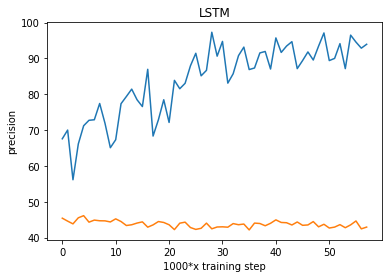

precision of the model on thevalidationdata: 42.932861328125%
tensor([0.9811, 0.9997, 0.9998, 0.9999, 1.0000, 0.9465, 0.9999, 0.9998, 0.9997,
        0.9739, 0.9998, 0.9992, 0.6044, 0.9997, 0.9976, 0.9995, 0.9421, 1.0000,
        0.5764, 1.0000, 0.9844, 0.9520, 0.9466, 0.9926, 0.9990, 0.9998, 0.9967,
        0.9886, 1.0000, 0.9994, 1.0000, 0.5092, 0.9862, 0.9974, 0.6232, 0.9981,
        0.6325, 0.6724, 1.0000, 0.9268, 0.6864, 0.8791, 0.9771, 0.9910, 0.9254,
        0.9416, 1.0000, 0.9958, 0.9643, 0.9970, 0.7265, 0.9433, 0.9840, 0.6025,
        0.9678, 0.9899, 1.0000, 0.9867, 0.5088, 1.0000, 0.9998, 0.9992, 0.9846,
        1.0000, 0.9999, 1.0000, 1.0000, 0.6288, 0.9841, 0.9438, 1.0000, 0.9999,
        1.0000, 0.9990, 0.7911, 0.9644, 0.9963, 1.0000, 0.9741, 1.0000, 0.9512,
        0.9994, 0.6711, 0.9997, 1.0000, 0.9983, 0.7806, 0.9997, 1.0000, 0.9807,
        1.0000, 0.6034, 0.9973, 0.9992, 0.9998, 0.9945, 0.7354, 1.0000, 0.5418,
        0.5713], device='cuda:1')
current i is 42
Filter l

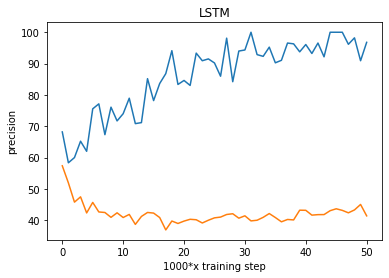

precision of the model on thevalidationdata: 41.396507263183594%
tensor([0.9430, 0.6825, 0.9997, 0.9936, 0.9989, 0.6963, 0.9429, 0.5787, 0.7395,
        0.9400, 0.9997, 1.0000, 0.5988, 0.9989, 0.9957, 0.9845, 0.9961, 0.9996,
        1.0000, 0.7610, 0.7906, 1.0000, 0.9583, 0.9987, 0.8858, 0.6484, 0.9986,
        0.8488, 0.7143, 1.0000, 0.9998, 0.9999, 1.0000, 0.7124, 0.6822, 0.9708,
        0.9308, 1.0000, 0.5689, 0.9974, 1.0000, 0.9999, 1.0000, 0.9914, 0.9982,
        0.9957, 1.0000, 0.9997, 0.9999, 0.8540, 0.9800, 0.9998, 0.9821, 0.8734,
        0.9994, 0.9969, 1.0000, 1.0000, 0.9999, 0.9923, 0.7585, 1.0000, 0.9837,
        1.0000, 0.9925, 0.9458, 0.9908, 1.0000, 0.8952, 0.7300, 0.8604, 0.8962,
        0.9961, 0.9996, 0.9526, 1.0000, 0.9999, 0.6749, 0.9342, 1.0000, 0.9236,
        0.9991, 1.0000, 0.9771, 0.9998, 0.5753, 0.9730, 0.9556, 0.9999, 0.9018,
        0.9298, 0.9150, 0.9953, 1.0000, 1.0000, 0.9757, 1.0000, 1.0000, 1.0000,
        0.9935], device='cuda:1')
current i is 43
Filte

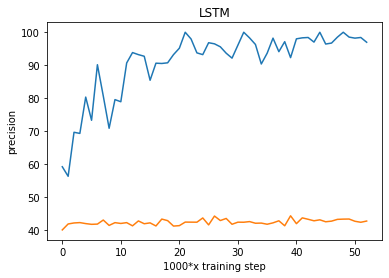

precision of the model on thevalidationdata: 42.8086051940918%
tensor([0.9900, 0.9696, 1.0000, 0.8136, 1.0000, 0.9915, 0.9979, 0.9415, 1.0000,
        0.9907, 0.9995, 0.9711, 0.5992, 0.9868, 0.9965, 0.9997, 0.9971, 0.5639,
        0.9302, 1.0000, 0.5896, 1.0000, 0.9947, 1.0000, 0.9977, 0.7863, 0.9892,
        0.9883, 1.0000, 0.9997, 0.9983, 0.9991, 0.9891, 1.0000, 1.0000, 0.9008,
        0.9337, 0.7867, 0.9711, 0.8826, 0.9973, 1.0000, 0.8575, 0.9923, 1.0000,
        0.9799, 0.9984, 1.0000, 0.5584, 0.9722, 0.9992, 0.7597, 0.7822, 0.6797,
        0.7877, 1.0000, 1.0000, 1.0000, 0.5810, 1.0000, 0.8754, 0.7270, 0.8349,
        0.9961, 1.0000, 1.0000, 0.9559, 1.0000, 0.9912, 0.8832, 0.8992, 0.9690,
        0.8264, 1.0000, 0.7350, 0.5288, 0.9999, 0.9994, 0.7411, 0.9990, 1.0000,
        0.9972, 0.9927, 0.9973, 0.9550, 0.8700, 1.0000, 0.9649, 0.9999, 1.0000,
        0.9999, 1.0000, 0.9999, 0.9870, 1.0000, 1.0000, 1.0000, 0.9974, 0.9912,
        0.9982], device='cuda:1')
current i is 44
Filter 

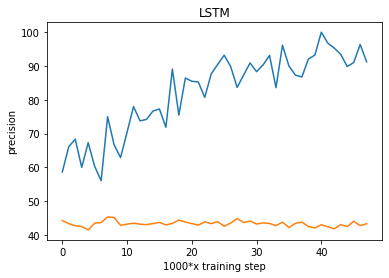

precision of the model on thevalidationdata: 43.30010986328125%
tensor([0.8366, 0.6453, 0.9111, 0.6744, 0.9985, 0.5140, 0.5304, 0.5567, 0.9670,
        0.9980, 0.8718, 0.8242, 0.9781, 0.9959, 0.9969, 0.5890, 0.5613, 0.9925,
        0.9621, 0.9978, 0.9998, 0.9363, 1.0000, 0.9999, 0.7767, 0.9715, 0.7696,
        0.9923, 0.8340, 0.7783, 0.8517, 0.9733, 1.0000, 0.9980, 0.8010, 0.9710,
        0.9118, 0.9914, 0.5625, 0.9973, 0.5309, 0.9887, 0.9521, 0.9948, 0.7978,
        0.5700, 0.9522, 1.0000, 0.9694, 0.9994, 0.9999, 0.9545, 0.9971, 0.5303,
        1.0000, 0.9429, 0.7767, 0.9985, 0.7323, 1.0000, 1.0000, 0.9981, 1.0000,
        0.7712, 0.6828, 1.0000, 1.0000, 0.7689, 0.9853, 0.9993, 1.0000, 0.9352,
        0.9879, 0.7675, 0.9999, 0.9959, 0.8391, 0.7643, 0.8239, 0.9967, 0.9922,
        0.9999, 0.9998, 0.9255, 0.9977, 0.9387, 0.6705, 0.8032, 0.8512, 0.9157,
        0.9988, 0.5501, 0.8617, 0.9990, 0.9283, 0.6671, 0.8294, 0.9983, 0.9992,
        0.9937], device='cuda:1')
current i is 45
Filter

precision of the model on thetrainingdata: 93.10344696044922%
precision of the model on thevalidationdata: 50.64516067504883%
precision of the model on thetrainingdata: 94.11764526367188%
precision of the model on thevalidationdata: 51.16988754272461%


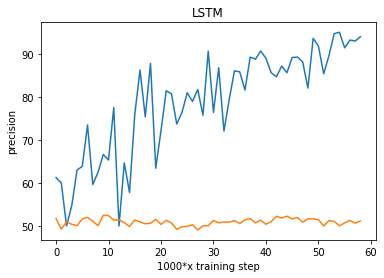

precision of the model on thevalidationdata: 51.16988754272461%
tensor([1.0000, 0.9995, 0.9593, 1.0000, 1.0000, 1.0000, 0.6839, 0.7734, 1.0000,
        1.0000, 1.0000, 1.0000, 0.6331, 0.7928, 1.0000, 1.0000, 1.0000, 0.6014,
        0.9999, 0.9998, 0.9999, 0.9922, 0.7644, 0.9827, 0.5715, 0.6171, 0.9866,
        1.0000, 1.0000, 0.9999, 0.9244, 0.5582, 0.8657, 0.9216, 1.0000, 1.0000,
        1.0000, 0.9915, 1.0000, 1.0000, 1.0000, 1.0000, 0.9993, 1.0000, 1.0000,
        0.9967, 0.9998, 0.8662, 0.8438, 0.7206, 0.9677, 1.0000, 0.6009, 1.0000,
        1.0000, 1.0000, 0.9817, 0.9997, 0.9953, 0.9138, 1.0000, 0.8432, 1.0000,
        1.0000, 0.9983, 0.9749, 1.0000, 0.9524, 0.9978, 1.0000, 0.9968, 0.9711,
        1.0000, 0.9944, 0.7253, 1.0000, 1.0000, 0.5783, 0.9983, 1.0000, 0.9162,
        0.9964, 0.8596, 0.9247, 0.9849, 0.9383, 1.0000, 0.9999, 0.8050, 0.9804,
        0.5609, 0.9575, 0.6613, 1.0000, 0.8979, 0.8983, 0.9027, 0.9096, 1.0000,
        0.9902], device='cuda:1')
current i is 46
Filter

precision of the model on thetrainingdata: 96.29629516601562%
precision of the model on thevalidationdata: 48.76462936401367%
precision of the model on thetrainingdata: 98.24561309814453%
precision of the model on thevalidationdata: 48.314605712890625%


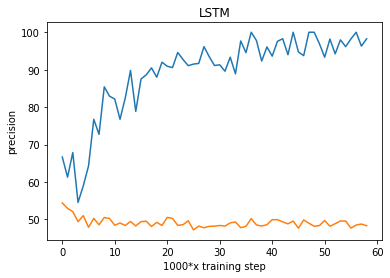

precision of the model on thevalidationdata: 48.314605712890625%
tensor([0.8103, 0.9179, 0.9999, 0.9240, 0.9999, 0.9999, 1.0000, 0.9986, 0.9123,
        1.0000, 1.0000, 0.6527, 0.5432, 0.9996, 0.9738, 0.9863, 0.9985, 0.9996,
        1.0000, 1.0000, 0.8584, 0.9924, 0.9996, 1.0000, 1.0000, 1.0000, 0.9807,
        0.8831, 0.9997, 0.9977, 0.9665, 0.9964, 0.9308, 0.6109, 1.0000, 0.6826,
        0.9844, 0.9568, 1.0000, 0.9985, 1.0000, 0.6803, 1.0000, 0.9969, 0.9997,
        1.0000, 1.0000, 0.9995, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        0.9999, 0.9992, 0.9999, 0.7892, 0.8227, 0.9999, 0.6049, 0.9997, 0.9709,
        0.7392, 0.9978, 0.9889, 0.9989, 0.9962, 0.9972, 0.9434, 1.0000, 1.0000,
        0.9858, 0.9735, 0.9515, 0.9571, 0.9768, 1.0000, 0.9784, 0.5797, 0.9850,
        1.0000, 0.9857, 1.0000, 1.0000, 0.7329, 0.9957, 0.9999, 0.9981, 0.8908,
        0.9998, 0.9999, 1.0000, 1.0000, 0.9701, 1.0000, 0.9997, 0.9805, 0.9999,
        0.9998], device='cuda:1')
current i is 47
Filte

precision of the model on thetrainingdata: 98.11320495605469%
precision of the model on thevalidationdata: 48.97260284423828%
precision of the model on thetrainingdata: 91.83673095703125%
precision of the model on thevalidationdata: 48.1605339050293%


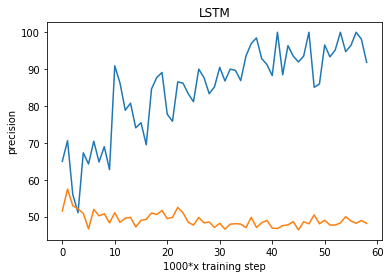

precision of the model on thevalidationdata: 46.88644790649414%
tensor([1.0000, 1.0000, 1.0000, 1.0000, 0.9001, 1.0000, 1.0000, 0.9812, 0.5936,
        0.9950, 0.9834, 0.9805, 0.5576, 0.9342, 0.9988, 0.9988, 0.7041, 0.5410,
        0.9999, 0.9998, 0.9705, 0.9999, 0.9255, 1.0000, 0.9997, 1.0000, 0.9007,
        0.5556, 0.9288, 1.0000, 0.9150, 0.9725, 0.9299, 1.0000, 0.9999, 0.5534,
        0.8952, 0.9751, 1.0000, 0.9850, 0.6722, 0.7852, 0.7090, 0.9944, 0.9999,
        0.9971, 0.9633, 0.6069, 1.0000, 1.0000, 0.9999, 0.8763, 1.0000, 0.9965,
        0.9999, 1.0000, 1.0000, 0.8471, 0.9353, 0.9998, 0.9617, 1.0000, 0.8024,
        0.7294, 0.9619, 0.6933, 1.0000, 0.9901, 1.0000, 0.9757, 0.9822, 0.6848,
        1.0000, 0.9990, 0.9996, 1.0000, 1.0000, 1.0000, 0.7215, 0.8729, 0.8557,
        0.9734, 0.9880, 1.0000, 0.8733, 0.5270, 0.7372, 0.9913, 0.7636, 0.6754,
        0.9979, 1.0000, 0.6716, 0.9728, 0.7433, 0.7561, 1.0000, 0.5139, 1.0000,
        0.9314], device='cuda:1')
current i is 48
Filter

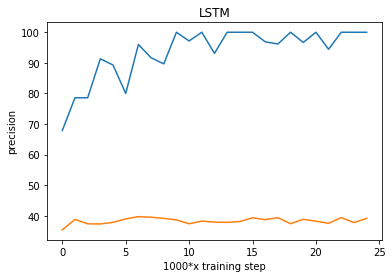

precision of the model on thevalidationdata: 39.14002227783203%
tensor([0.9738, 0.5283, 1.0000, 0.8754, 0.9803, 0.9409, 0.9122, 0.9976, 0.9999,
        0.9997, 0.5372, 0.9943, 0.6804, 0.9581, 0.9994, 0.9909, 0.5239, 0.8077,
        0.9998, 1.0000, 0.9996, 0.5422, 0.9039, 1.0000, 0.9415, 0.9681, 0.9991,
        0.6263, 0.9911, 0.9982, 0.8382, 1.0000, 0.9840, 0.5021, 1.0000, 1.0000,
        0.9684, 0.9984, 0.9842, 0.9878, 1.0000, 0.9879, 0.9974, 0.9982, 1.0000,
        1.0000, 0.9729, 0.9895, 0.9997, 0.5904, 0.9612, 0.9647, 0.9983, 0.7197,
        0.9995, 1.0000, 1.0000, 0.9951, 0.9170, 1.0000, 1.0000, 0.5672, 0.7321,
        0.7980, 0.9840, 0.5884, 1.0000, 0.8433, 0.8841, 0.9997, 0.8774, 0.9955,
        0.9987, 1.0000, 0.9999, 0.9971, 0.9980, 1.0000, 0.8729, 0.9878, 1.0000,
        0.8530, 0.8314, 0.9890, 0.9685, 1.0000, 1.0000, 1.0000, 0.9899, 0.9999,
        0.9999, 0.6947, 0.5236, 0.9992, 1.0000, 0.8631, 0.9527, 0.6552, 1.0000,
        0.9749], device='cuda:1')
current i is 49
Filter

precision of the model on thetrainingdata: 92.68292999267578%
precision of the model on thevalidationdata: 36.612701416015625%


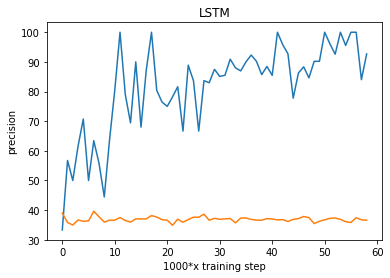

precision of the model on thevalidationdata: 37.135276794433594%
tensor([0.9999, 0.9805, 0.9948, 0.7067, 1.0000, 0.9947, 0.9989, 0.9340, 0.9999,
        0.5342, 0.9999, 0.9337, 0.9963, 0.9980, 0.9462, 0.9589, 0.9998, 1.0000,
        0.6369, 0.6536, 0.9962, 0.9391, 0.9935, 0.9708, 0.9661, 0.8569, 0.9997,
        0.9203, 0.9994, 0.6432, 0.9959, 1.0000, 0.9846, 0.9999, 0.9994, 0.9975,
        0.5123, 0.6840, 1.0000, 0.9483, 0.9904, 0.7909, 0.7014, 0.9723, 0.9999,
        0.5410, 0.9994, 0.9891, 0.9940, 0.9021, 0.5354, 0.9740, 0.9834, 0.8028,
        0.6506, 0.5393, 0.7718, 0.9633, 0.9998, 0.9986, 0.9656, 0.9999, 0.9697,
        0.7245, 0.9991, 0.6780, 0.9990, 0.5866, 0.5901, 0.8533, 0.9999, 0.8030,
        0.7073, 0.6007, 0.7208, 1.0000, 1.0000, 0.9995, 1.0000, 0.7574, 1.0000,
        0.9952, 0.9996, 0.9962, 0.9813, 0.9762, 0.7875, 0.8482, 0.8639, 0.9787,
        0.9348, 0.9999, 0.9829, 0.9999, 0.9881, 0.9982, 0.9996, 0.5852, 1.0000,
        0.5612], device='cuda:1')
current i is 50
Filte

precision of the model on thetrainingdata: 92.0%
precision of the model on thevalidationdata: 57.39130401611328%


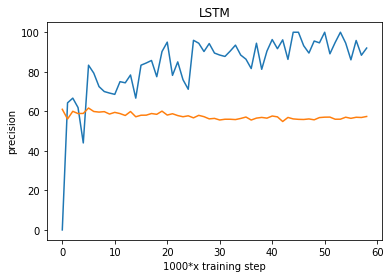

precision of the model on thevalidationdata: 57.00365447998047%
tensor([1.0000, 0.9342, 1.0000, 1.0000, 1.0000, 1.0000, 0.8946, 1.0000, 0.5706,
        1.0000, 1.0000, 1.0000, 1.0000, 0.9999, 1.0000, 0.9668, 1.0000, 1.0000,
        0.9986, 0.9997, 1.0000, 1.0000, 1.0000, 0.9897, 1.0000, 1.0000, 0.9810,
        0.9970, 0.9971, 0.7056, 1.0000, 1.0000, 0.6100, 1.0000, 1.0000, 1.0000,
        0.8995, 0.9998, 0.9898, 1.0000, 0.9858, 0.6882, 0.9998, 0.9941, 0.8539,
        1.0000, 1.0000, 0.9997, 1.0000, 0.9998, 0.9997, 1.0000, 1.0000, 0.9994,
        0.7274, 1.0000, 1.0000, 0.7736, 0.9877, 0.9997, 1.0000, 1.0000, 0.9812,
        0.9709, 0.9946, 1.0000, 1.0000, 0.9923, 0.9934, 1.0000, 1.0000, 0.9997,
        0.9859, 0.9777, 0.8653, 0.9999, 1.0000, 0.6493, 0.9991, 0.9741, 0.8953,
        0.7177, 0.8106, 0.9999, 0.5941, 0.9999, 1.0000, 1.0000, 0.9999, 1.0000,
        0.9168, 0.7067, 0.9964, 1.0000, 0.9839, 0.6113, 1.0000, 1.0000, 0.9999,
        0.9878], device='cuda:1')
current i is 51
Filter

precision of the model on thetrainingdata: 98.30508422851562%
precision of the model on thevalidationdata: 47.58064651489258%


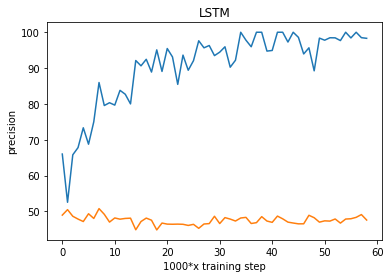

precision of the model on thevalidationdata: 48.14814758300781%
tensor([1.0000, 0.9991, 0.9998, 0.8908, 1.0000, 1.0000, 0.9998, 1.0000, 0.9997,
        0.9999, 0.9605, 0.9718, 1.0000, 1.0000, 0.9996, 1.0000, 0.9896, 1.0000,
        0.9793, 0.9996, 0.9449, 0.9338, 1.0000, 0.9993, 0.9620, 1.0000, 1.0000,
        1.0000, 0.9394, 0.7285, 1.0000, 0.9682, 0.9919, 1.0000, 0.9998, 0.9792,
        1.0000, 1.0000, 0.9897, 0.9578, 0.9301, 0.9093, 0.9987, 0.9963, 0.7433,
        0.9222, 0.5522, 0.5866, 1.0000, 0.9947, 0.5747, 0.9954, 0.9331, 0.8245,
        1.0000, 1.0000, 1.0000, 1.0000, 0.9890, 0.9988, 0.9885, 0.9346, 0.9696,
        0.9365, 1.0000, 0.9311, 0.9998, 0.9997, 0.9939, 1.0000, 1.0000, 0.9934,
        1.0000, 1.0000, 0.9991, 0.8216, 0.9963, 1.0000, 1.0000, 0.9997, 1.0000,
        1.0000, 0.9448, 1.0000, 0.8311, 1.0000, 0.8246, 0.9999, 0.9995, 0.9972,
        1.0000, 1.0000, 1.0000, 1.0000, 0.8658, 0.9869, 0.9956, 1.0000, 0.9999,
        0.9997], device='cuda:1')
current i is 52
Filter

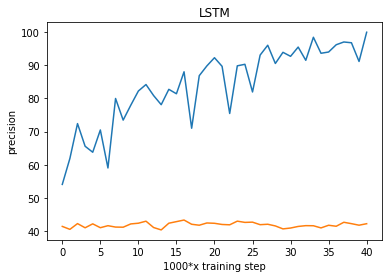

precision of the model on thevalidationdata: 42.185791015625%
tensor([1.0000, 1.0000, 0.9998, 0.6499, 0.8242, 0.9381, 0.7130, 0.9936, 1.0000,
        0.9994, 0.9327, 1.0000, 0.9952, 1.0000, 1.0000, 0.7694, 0.9997, 1.0000,
        1.0000, 0.9936, 1.0000, 0.9647, 0.9588, 1.0000, 0.9306, 0.9990, 0.9996,
        0.5978, 0.9366, 1.0000, 1.0000, 1.0000, 1.0000, 0.9601, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 0.9974, 0.9999, 0.5339, 0.9698, 0.9893, 0.9856,
        0.9858, 0.9976, 0.8817, 1.0000, 0.9855, 0.6027, 0.9985, 0.6627, 1.0000,
        1.0000, 0.9234, 0.9968, 1.0000, 0.9887, 0.9301, 0.9545, 1.0000, 0.8279,
        0.9939, 0.9114, 1.0000, 0.8628, 0.9231, 0.7362, 0.9997, 0.8764, 0.9787,
        0.9893, 1.0000, 1.0000, 0.5443, 1.0000, 1.0000, 1.0000, 0.9998, 0.9991,
        0.9952, 1.0000, 1.0000, 1.0000, 0.9999, 1.0000, 0.7576, 1.0000, 0.9916,
        0.6739, 0.9802, 0.9970, 0.6484, 0.7746, 1.0000, 0.9130, 1.0000, 0.5203,
        0.9999], device='cuda:1')
current i is 54
Filter l

precision of the model on thetrainingdata: 97.95918273925781%
precision of the model on thevalidationdata: 49.10394287109375%
precision of the model on thetrainingdata: 95.0%
precision of the model on thevalidationdata: 50.0%


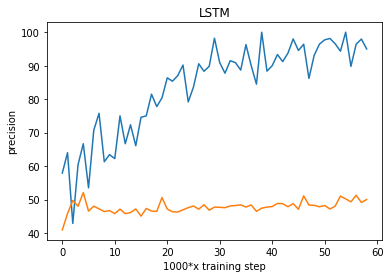

precision of the model on thevalidationdata: 48.657718658447266%
tensor([0.9999, 0.9997, 0.9811, 1.0000, 0.9987, 0.9518, 1.0000, 0.9991, 0.6535,
        0.9987, 0.9994, 0.9748, 0.9305, 0.9896, 0.9942, 0.9664, 0.9612, 0.6919,
        1.0000, 0.9986, 0.9921, 0.9981, 1.0000, 0.9972, 0.8114, 0.8923, 0.8670,
        0.7092, 0.9999, 0.9535, 0.7679, 0.9335, 0.8583, 0.5275, 1.0000, 0.9626,
        0.9391, 0.9935, 0.9780, 0.9908, 0.9872, 1.0000, 0.5833, 0.5615, 1.0000,
        0.9826, 0.7426, 0.9543, 0.7093, 0.9621, 1.0000, 1.0000, 0.7226, 0.9998,
        0.5843, 0.9943, 0.9750, 0.9859, 1.0000, 1.0000, 0.8498, 0.9725, 0.9978,
        0.9885, 0.9939, 0.5899, 1.0000, 0.9992, 1.0000, 1.0000, 0.9998, 0.9823,
        0.9863, 0.5862, 0.9981, 0.9998, 0.9703, 0.8661, 1.0000, 0.5575, 0.9644,
        0.8553, 0.9944, 0.9876, 0.9043, 0.8842, 0.9685, 0.9972, 0.9251, 0.9125,
        0.9923, 0.9776, 0.9542, 0.9813, 0.9923, 1.0000, 0.6166, 0.9883, 0.9577,
        0.9848], device='cuda:1')
current i is 55
Filte

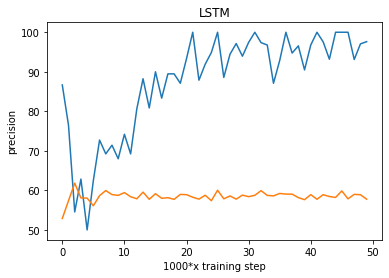

precision of the model on thevalidationdata: 57.77385330200195%
tensor([1.0000, 1.0000, 1.0000, 0.9893, 1.0000, 1.0000, 0.7438, 0.6253, 0.9884,
        1.0000, 0.9991, 0.6771, 0.9999, 0.9287, 0.9999, 1.0000, 0.8982, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 0.9590, 0.5814, 0.5180, 0.9823, 0.9989,
        1.0000, 0.8682, 1.0000, 1.0000, 0.9938, 0.9363, 0.9985, 0.9537, 1.0000,
        0.9984, 0.9752, 0.9903, 1.0000, 1.0000, 0.9400, 0.5177, 0.9874, 1.0000,
        0.9989, 0.5856, 0.9771, 1.0000, 1.0000, 0.8547, 1.0000, 0.9996, 1.0000,
        1.0000, 0.7538, 0.9093, 1.0000, 0.8030, 0.9768, 0.5841, 0.9310, 0.9997,
        0.8817, 0.7861, 1.0000, 1.0000, 0.9995, 1.0000, 0.9687, 0.9974, 0.9063,
        1.0000, 0.9985, 0.9359, 0.6862, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 0.8035, 1.0000, 0.8402, 0.6444, 0.9959, 1.0000, 0.5365,
        1.0000, 0.9678, 0.9991, 1.0000, 1.0000, 0.9880, 0.9978, 0.6969, 0.9997,
        0.9211], device='cuda:1')
current i is 56
Filter

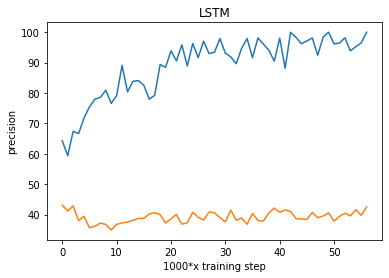

precision of the model on thevalidationdata: 42.5101203918457%
tensor([0.8872, 1.0000, 0.8800, 0.8214, 0.8580, 1.0000, 0.9963, 0.9274, 0.7444,
        1.0000, 1.0000, 1.0000, 1.0000, 0.9812, 0.7903, 0.9998, 1.0000, 1.0000,
        0.9932, 0.9998, 1.0000, 1.0000, 1.0000, 0.6469, 0.9826, 1.0000, 0.9134,
        0.9984, 1.0000, 0.9977, 1.0000, 0.7930, 0.9979, 1.0000, 0.9615, 0.9601,
        1.0000, 0.9468, 0.9852, 0.9891, 0.9579, 0.9850, 0.9995, 1.0000, 0.9980,
        0.5650, 0.9663, 0.9952, 0.5796, 0.7310, 1.0000, 1.0000, 0.7092, 0.8051,
        0.9998, 0.9071, 0.9654, 0.9996, 1.0000, 1.0000, 0.9984, 0.8037, 0.6549,
        1.0000, 1.0000, 1.0000, 0.9988, 1.0000, 0.9851, 0.6512, 0.9998, 0.8347,
        1.0000, 1.0000, 0.9601, 1.0000, 0.7362, 0.9927, 1.0000, 0.8792, 0.9999,
        0.9959, 0.9902, 1.0000, 0.5986, 1.0000, 0.7510, 0.9998, 1.0000, 0.6266,
        1.0000, 1.0000, 0.7087, 1.0000, 1.0000, 0.9999, 0.8271, 0.8821, 1.0000,
        1.0000], device='cuda:1')
current i is 57
Filter 

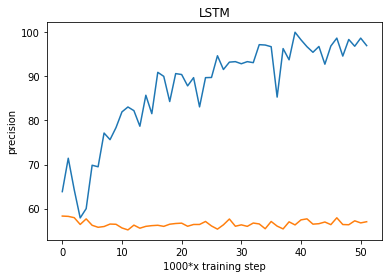

precision of the model on thevalidationdata: 57.03493881225586%
tensor([0.9999, 0.9990, 1.0000, 0.9997, 1.0000, 0.9946, 1.0000, 0.9731, 0.6397,
        0.8217, 0.9976, 0.9974, 0.9947, 0.9994, 0.9924, 0.6820, 0.9995, 0.9498,
        0.6187, 1.0000, 0.7800, 0.7992, 0.7451, 0.9993, 0.5755, 1.0000, 0.9996,
        0.9110, 0.9906, 0.9923, 0.7315, 0.9633, 0.9924, 0.9857, 0.9738, 0.8836,
        0.9831, 0.9948, 0.9970, 0.9489, 1.0000, 1.0000, 1.0000, 1.0000, 0.9959,
        1.0000, 0.6386, 1.0000, 0.8970, 0.9245, 1.0000, 0.9999, 1.0000, 0.9849,
        0.9999, 0.9972, 1.0000, 0.9738, 0.5263, 0.9089, 0.9448, 1.0000, 0.9999,
        0.9991, 0.9968, 0.9976, 0.9152, 0.9175, 0.9535, 0.5366, 1.0000, 1.0000,
        0.9335, 0.9998, 0.9996, 0.9972, 0.5611, 0.6273, 0.6940, 0.6424, 0.9915,
        0.8510, 0.9381, 0.6343, 1.0000, 0.9929, 0.8714, 1.0000, 0.7486, 1.0000,
        0.9863, 0.9489, 0.8805, 0.9985, 0.9661, 0.9982, 0.9879, 0.9815, 0.6839,
        0.9969], device='cuda:1')
current i is 58
Filter

precision of the model on thetrainingdata: 100.0%
precision of the model on thevalidationdata: 37.39021301269531%
precision of the model on thetrainingdata: 91.66666412353516%
precision of the model on thevalidationdata: 37.3831787109375%


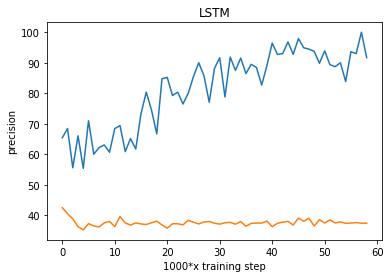

precision of the model on thevalidationdata: 38.02647399902344%
tensor([0.6856, 1.0000, 1.0000, 1.0000, 0.6761, 0.9873, 0.9686, 1.0000, 0.9154,
        0.9983, 0.9660, 0.8357, 1.0000, 1.0000, 0.9954, 0.5830, 0.8880, 0.9948,
        1.0000, 1.0000, 1.0000, 0.9918, 0.9441, 0.9816, 0.9984, 0.5333, 0.6775,
        0.9994, 0.9892, 0.9732, 0.6370, 0.8731, 0.5764, 0.6696, 0.5850, 0.9967,
        0.9996, 0.7994, 1.0000, 0.9997, 0.8751, 0.6210, 1.0000, 0.9999, 0.9842,
        0.9999, 0.9985, 0.9938, 1.0000, 1.0000, 0.9936, 0.5982, 0.9645, 0.9955,
        0.9565, 0.9933, 0.9988, 0.6614, 0.8865, 1.0000, 1.0000, 0.9999, 0.9999,
        0.9976, 0.5108, 0.9986, 0.8921, 0.9938, 1.0000, 1.0000, 0.9972, 1.0000,
        0.7462, 0.9983, 1.0000, 1.0000, 1.0000, 0.9826, 0.9999, 0.9998, 0.9866,
        0.9924, 0.9961, 0.9999, 0.9073, 0.9654, 0.9952, 0.6902, 1.0000, 1.0000,
        0.8867, 0.9967, 0.7643, 0.9599, 1.0000, 0.9740, 0.9992, 0.9989, 0.9239,
        0.9886], device='cuda:1')
current i is 59
Filter

precision of the model on thetrainingdata: 96.36363983154297%
precision of the model on thevalidationdata: 38.356163024902344%
precision of the model on thetrainingdata: 91.66666412353516%
precision of the model on thevalidationdata: 37.826961517333984%


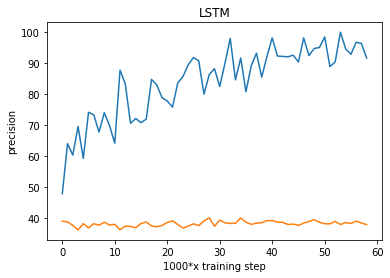

precision of the model on thevalidationdata: 37.421382904052734%
tensor([0.7517, 0.7351, 0.9999, 0.7982, 0.9991, 0.9927, 0.9981, 0.9999, 0.9330,
        0.6380, 0.9831, 0.5034, 0.9288, 0.5849, 0.8923, 0.9957, 0.5292, 0.9977,
        0.9666, 1.0000, 0.9991, 0.5434, 1.0000, 0.8525, 0.9967, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 0.9891, 0.9380, 0.9983, 0.7190, 0.9776, 0.9811,
        0.9999, 0.9754, 0.9238, 1.0000, 0.5324, 1.0000, 1.0000, 1.0000, 0.9670,
        0.9861, 1.0000, 0.9331, 0.9889, 1.0000, 0.7870, 0.9994, 1.0000, 1.0000,
        0.9999, 0.9576, 0.9851, 0.9629, 0.6587, 0.9720, 0.8010, 1.0000, 1.0000,
        0.9416, 0.9998, 0.9444, 0.6481, 0.9275, 1.0000, 0.9981, 0.9989, 0.9982,
        0.7842, 1.0000, 0.7968, 0.9247, 0.6310, 0.9060, 0.9722, 0.9951, 0.9599,
        0.9637, 0.9999, 0.8383, 0.8993, 1.0000, 0.7815, 1.0000, 0.9966, 0.6989,
        0.8689, 1.0000, 0.5330, 0.9495, 1.0000, 0.9994, 1.0000, 0.5831, 0.9999,
        0.9996], device='cuda:1')
current i is 60
Filte

precision of the model on thetrainingdata: 97.01492309570312%
precision of the model on thevalidationdata: 43.438453674316406%
precision of the model on thetrainingdata: 95.38461303710938%
precision of the model on thevalidationdata: 42.51496887207031%


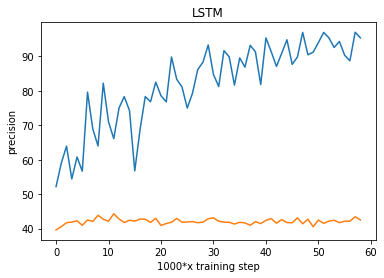

precision of the model on thevalidationdata: 41.090145111083984%
tensor([0.8569, 0.5909, 1.0000, 0.9775, 0.6952, 0.9960, 0.6144, 0.5482, 0.9999,
        0.5773, 0.9807, 0.5326, 0.7279, 0.9664, 0.9695, 1.0000, 0.9980, 1.0000,
        0.8291, 0.5512, 1.0000, 0.6336, 0.7078, 1.0000, 1.0000, 1.0000, 1.0000,
        0.9998, 0.9940, 0.9953, 1.0000, 1.0000, 1.0000, 0.8460, 0.9735, 1.0000,
        0.9832, 0.7074, 0.8481, 0.6533, 0.8029, 0.9046, 0.9887, 0.9755, 1.0000,
        0.9842, 0.9961, 0.9172, 0.6914, 0.5186, 0.9922, 0.5704, 0.9044, 0.6319,
        0.9990, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        0.9293, 0.9952, 1.0000, 0.9997, 1.0000, 1.0000, 0.9541, 0.9980, 0.8008,
        0.9687, 1.0000, 0.8310, 0.9868, 0.5229, 0.9490, 0.9634, 1.0000, 1.0000,
        0.8947, 1.0000, 0.7415, 0.9997, 1.0000, 1.0000, 1.0000, 1.0000, 0.9468,
        0.9953, 0.6735, 0.9157, 0.9871, 0.7764, 0.9878, 0.9999, 0.5335, 0.9479,
        0.5745], device='cuda:1')
current i is 61
Filte

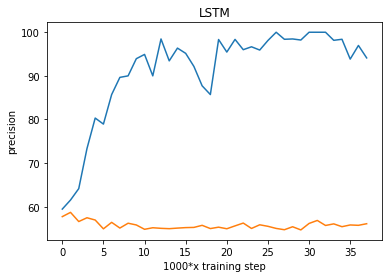

precision of the model on thevalidationdata: 56.104652404785156%
tensor([0.9928, 0.6442, 0.6840, 0.8690, 0.9982, 0.9963, 0.9952, 0.6637, 1.0000,
        1.0000, 1.0000, 1.0000, 0.8704, 1.0000, 1.0000, 0.9998, 1.0000, 0.9998,
        0.9113, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 0.9988, 0.9970,
        0.8857, 1.0000, 0.8406, 0.5572, 0.9997, 1.0000, 0.9981, 1.0000, 0.7272,
        0.9980, 1.0000, 1.0000, 0.9751, 1.0000, 1.0000, 1.0000, 0.9937, 0.9717,
        0.9963, 0.6415, 1.0000, 1.0000, 0.7268, 1.0000, 0.9996, 0.8834, 0.9756,
        0.8352, 0.9437, 0.5102, 0.5034, 1.0000, 1.0000, 0.6475, 0.6684, 0.8993,
        0.5992, 1.0000, 0.8937, 0.7609, 0.9655, 0.9407, 1.0000, 0.8219, 0.8435,
        0.7824, 0.9651, 1.0000, 0.9967, 0.9896, 0.9878, 0.9469, 0.8879, 1.0000,
        1.0000, 0.9958, 0.9906, 0.9780, 0.9592, 1.0000, 1.0000, 1.0000, 1.0000,
        0.9998, 0.8013, 0.9988, 0.9963, 0.9391, 0.7329, 1.0000, 1.0000, 1.0000,
        1.0000], device='cuda:1')
current i is 62
Filte

precision of the model on thetrainingdata: 96.29629516601562%
precision of the model on thevalidationdata: 29.727272033691406%
precision of the model on thetrainingdata: 93.33333587646484%
precision of the model on thevalidationdata: 29.633113861083984%


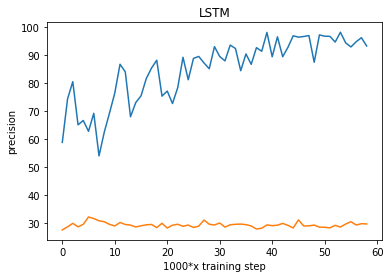

precision of the model on thevalidationdata: 28.942115783691406%
tensor([0.9328, 0.9996, 0.5047, 0.9939, 0.9945, 0.9975, 0.9999, 0.6280, 0.9601,
        0.9944, 0.9573, 0.9769, 0.9707, 1.0000, 0.9585, 1.0000, 0.9982, 0.6343,
        1.0000, 0.5549, 1.0000, 0.5614, 0.9047, 0.9079, 0.8569, 1.0000, 1.0000,
        0.9990, 0.9871, 0.8429, 0.9996, 1.0000, 1.0000, 0.8046, 0.9582, 0.9996,
        0.9995, 1.0000, 0.7826, 1.0000, 1.0000, 1.0000, 0.9995, 0.6312, 1.0000,
        1.0000, 0.6754, 0.7177, 0.8485, 0.9909, 1.0000, 0.9477, 0.5798, 0.8655,
        0.9603, 0.9582, 0.9925, 1.0000, 0.9995, 0.9906, 0.9995, 0.8128, 0.9965,
        0.9999, 0.9987, 0.7803, 0.9454, 0.9734, 1.0000, 0.9997, 1.0000, 0.9630,
        0.6893, 0.8550, 1.0000, 1.0000, 0.9998, 0.6904, 0.9999, 0.9385, 0.9941,
        0.9991, 0.9999, 0.8869, 0.9583, 0.7878, 0.8360, 0.9997, 0.9984, 0.9840,
        0.9980, 0.9841, 0.5022, 0.8701, 0.9641, 0.9836, 0.9983, 1.0000, 1.0000,
        1.0000], device='cuda:1')
current i is 63
Filte

precision of the model on thetrainingdata: 92.1875%
precision of the model on thevalidationdata: 45.97457504272461%
precision of the model on thetrainingdata: 89.85507202148438%
precision of the model on thevalidationdata: 44.792720794677734%


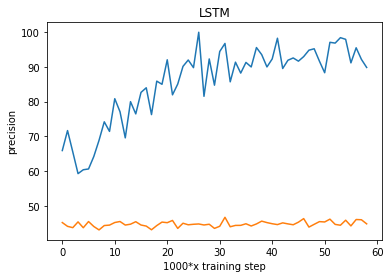

precision of the model on thevalidationdata: 45.20089340209961%
tensor([0.9883, 1.0000, 1.0000, 1.0000, 1.0000, 0.9998, 1.0000, 0.9999, 0.9941,
        1.0000, 0.9999, 1.0000, 0.9708, 0.6824, 0.9999, 0.9287, 0.9564, 0.7954,
        0.9081, 0.6186, 0.9276, 0.8472, 0.9990, 0.8137, 0.9999, 0.9994, 1.0000,
        0.9991, 0.9988, 0.9973, 0.9993, 0.9999, 0.9845, 0.9999, 1.0000, 0.9848,
        0.9999, 0.9928, 0.8087, 0.9944, 0.9108, 0.5099, 0.9650, 0.9999, 1.0000,
        0.9999, 0.8535, 0.9907, 0.7170, 1.0000, 1.0000, 0.9966, 0.8493, 0.9994,
        0.9998, 0.9997, 1.0000, 1.0000, 1.0000, 1.0000, 0.9906, 1.0000, 1.0000,
        1.0000, 0.9980, 0.9149, 1.0000, 0.7070, 0.5970, 1.0000, 1.0000, 0.7806,
        0.9999, 1.0000, 0.9950, 0.9708, 0.9990, 0.7812, 1.0000, 1.0000, 1.0000,
        0.9979, 0.8540, 1.0000, 1.0000, 1.0000, 0.9989, 0.9612, 0.9253, 0.8287,
        0.9649, 0.9359, 0.9987, 0.9998, 0.9971, 0.9263, 0.9597, 0.6409, 0.9672,
        0.9966], device='cuda:1')
current i is 64
Filter

precision of the model on thetrainingdata: 95.5882339477539%
precision of the model on thevalidationdata: 39.58904266357422%
precision of the model on thetrainingdata: 96.92308044433594%
precision of the model on thevalidationdata: 39.25373077392578%


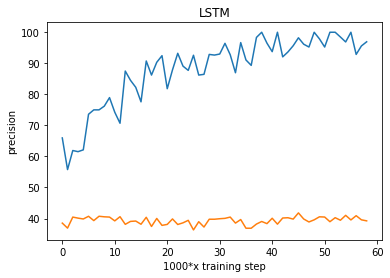

precision of the model on thevalidationdata: 39.485626220703125%
tensor([0.6884, 0.9879, 1.0000, 0.9968, 0.9375, 1.0000, 0.9993, 1.0000, 1.0000,
        0.9976, 0.5796, 0.9602, 0.9962, 0.9990, 0.9887, 0.9615, 0.9594, 1.0000,
        1.0000, 0.8428, 0.9892, 0.9792, 1.0000, 0.9993, 0.9927, 0.9836, 1.0000,
        0.5991, 0.9762, 0.9969, 0.9718, 0.9293, 0.8516, 0.9949, 0.9401, 1.0000,
        0.6251, 0.9092, 0.9999, 0.5558, 0.9993, 0.9073, 1.0000, 0.9992, 0.9996,
        0.9998, 0.9891, 1.0000, 0.6392, 0.9697, 0.6370, 1.0000, 1.0000, 0.9476,
        0.5273, 1.0000, 0.6324, 0.7861, 0.9718, 0.7605, 0.5988, 0.9903, 1.0000,
        0.8197, 1.0000, 0.9963, 0.8838, 0.9998, 0.9974, 1.0000, 0.9996, 0.7338,
        0.9539, 0.9955, 0.9999, 0.9994, 0.9998, 0.8505, 0.7430, 1.0000, 0.5192,
        0.9970, 1.0000, 1.0000, 0.9890, 0.9670, 0.9814, 1.0000, 0.9968, 1.0000,
        0.7995, 0.9931, 0.9999, 1.0000, 0.9999, 0.7838, 0.9986, 0.5174, 0.9990,
        0.9871], device='cuda:1')
current i is 65
Filte

precision of the model on thetrainingdata: 94.0%
precision of the model on thevalidationdata: 49.640289306640625%
precision of the model on thetrainingdata: 97.91666412353516%
precision of the model on thevalidationdata: 50.11848449707031%


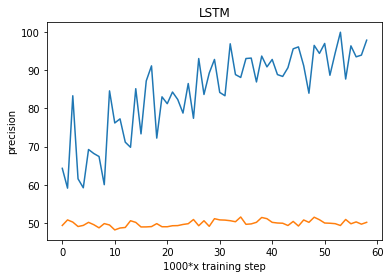

precision of the model on thevalidationdata: 49.64788818359375%
tensor([0.9921, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 0.9982, 1.0000, 1.0000,
        1.0000, 0.9860, 1.0000, 1.0000, 0.9575, 0.9917, 0.9856, 0.9812, 1.0000,
        1.0000, 0.5878, 0.9988, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        0.7886, 1.0000, 1.0000, 0.9997, 0.9999, 0.9992, 0.9992, 1.0000, 1.0000,
        0.6002, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 0.9290, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 0.9577, 0.9997,
        1.0000, 0.9976, 0.6953, 1.0000, 1.0000, 0.7834, 1.0000, 0.9438, 0.9999,
        1.0000, 0.8216, 0.9892, 1.0000, 0.9720, 0.9997, 1.0000, 1.0000, 0.9959,
        0.7292, 0.9964, 0.9942, 0.7071, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 0.7376, 1.0000, 1.0000, 0.9998, 1.0000, 0.9999, 0.9468,
        0.9948, 0.9876, 1.0000, 0.9941, 0.5076, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000], device='cuda:1')
current i is 66
Filter

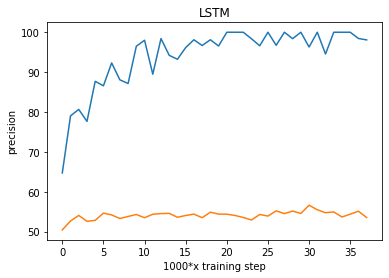

precision of the model on thevalidationdata: 53.52241516113281%
tensor([1.0000, 1.0000, 1.0000, 0.7988, 1.0000, 0.9857, 0.9982, 0.9999, 0.8269,
        1.0000, 0.6352, 0.8161, 0.9998, 0.5559, 0.9999, 0.9990, 1.0000, 0.9995,
        1.0000, 1.0000, 0.9853, 0.8595, 0.9999, 0.9837, 0.9562, 0.8136, 1.0000,
        0.9983, 0.9974, 0.9999, 0.9831, 0.9777, 0.7059, 0.8060, 0.9997, 1.0000,
        0.9645, 0.9921, 0.8959, 0.9871, 0.9990, 0.9977, 0.9413, 0.9965, 0.6194,
        0.7954, 0.9987, 1.0000, 0.9984, 0.7902, 1.0000, 0.9965, 1.0000, 0.9957,
        1.0000, 0.9611, 0.9210, 0.6574, 1.0000, 0.9675, 0.9977, 0.9998, 0.9983,
        0.9676, 0.9970, 0.9999, 0.9453, 1.0000, 0.9899, 1.0000, 0.9999, 0.9915,
        1.0000, 0.9998, 0.9954, 0.7291, 0.9736, 1.0000, 0.9984, 0.9882, 0.7631,
        0.9996, 0.9994, 0.8476, 0.5650, 0.9361, 0.9941, 0.9976, 1.0000, 0.9309,
        1.0000, 1.0000, 0.9986, 0.9946, 0.9992, 0.5259, 1.0000, 0.9996, 0.9999,
        0.9989], device='cuda:1')
current i is 67
Filter

precision of the model on thetrainingdata: 98.36065673828125%
precision of the model on thevalidationdata: 30.745342254638672%
precision of the model on thetrainingdata: 95.45454406738281%
precision of the model on thevalidationdata: 30.86419677734375%


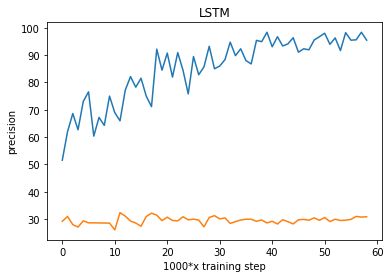

precision of the model on thevalidationdata: 29.607250213623047%
tensor([0.9911, 0.9999, 0.9998, 0.7197, 0.8034, 1.0000, 0.9966, 0.6447, 0.9553,
        0.8953, 0.9905, 0.9209, 0.9869, 0.9996, 1.0000, 0.9966, 0.9961, 0.9999,
        1.0000, 0.9871, 0.9934, 0.7420, 1.0000, 0.9499, 0.9881, 0.9996, 0.8518,
        0.6807, 0.9994, 1.0000, 0.9291, 1.0000, 1.0000, 1.0000, 0.8862, 0.9206,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 0.8798, 0.8014, 0.5072, 0.5982,
        1.0000, 0.9999, 1.0000, 0.9920, 0.8728, 1.0000, 0.9875, 1.0000, 0.5321,
        0.7514, 0.9703, 0.9994, 0.8068, 0.9866, 1.0000, 0.9955, 0.5880, 0.9762,
        0.9981, 0.8976, 1.0000, 0.9426, 0.7832, 0.9999, 0.9731, 0.9874, 0.9569,
        0.9956, 0.9834, 0.9940, 1.0000, 0.5358, 0.8091, 0.9981, 0.9659, 0.9898,
        0.7154, 0.9849, 0.8483, 1.0000, 0.9541, 0.9935, 1.0000, 0.9808, 0.9966,
        1.0000, 0.9967, 0.7961, 0.9934, 0.7132, 1.0000, 0.9999, 0.9948, 0.9997,
        0.8111], device='cuda:1')
current i is 68
Filte

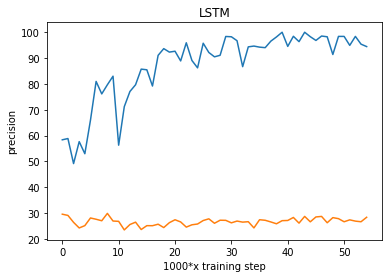

precision of the model on thevalidationdata: 28.328611373901367%
tensor([0.9986, 1.0000, 0.9692, 0.9995, 0.9998, 1.0000, 0.9898, 0.9994, 0.9561,
        0.9987, 0.7277, 0.9996, 1.0000, 0.9988, 0.9465, 0.9996, 1.0000, 0.9579,
        0.9997, 0.9912, 1.0000, 1.0000, 0.9922, 0.9999, 0.9972, 0.9999, 1.0000,
        0.9983, 1.0000, 0.9011, 0.9939, 0.9995, 0.5559, 0.9543, 0.8527, 0.9671,
        1.0000, 1.0000, 0.9397, 0.9995, 0.9999, 0.9192, 0.7219, 0.5458, 0.7188,
        1.0000, 0.9999, 1.0000, 0.9962, 0.9299, 1.0000, 0.8085, 0.9944, 0.9343,
        0.9941, 0.8091, 0.8212, 1.0000, 1.0000, 0.8885, 1.0000, 0.9031, 0.9849,
        0.9937, 0.9762, 0.9995, 1.0000, 0.9842, 0.9884, 0.8514, 0.9999, 0.7148,
        0.9404, 0.9982, 0.7621, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 0.6601,
        0.9600, 1.0000, 0.9998, 0.8449, 0.9999, 0.5440, 0.9945, 1.0000, 0.9963,
        1.0000, 0.9772, 0.9048, 1.0000, 1.0000, 0.9999, 0.5202, 0.9999, 0.9899,
        0.9990], device='cuda:1')
current i is 69
Filte

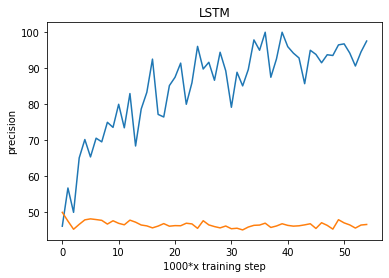

precision of the model on thevalidationdata: 46.6307258605957%
tensor([1.0000, 1.0000, 0.6014, 1.0000, 1.0000, 0.9954, 0.5460, 0.8199, 0.7347,
        0.7028, 1.0000, 1.0000, 1.0000, 1.0000, 0.6898, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 0.9403, 0.8790, 0.8575, 0.6539, 0.8708,
        1.0000, 1.0000, 1.0000, 1.0000, 0.9747, 0.7746, 0.9273, 0.7571, 0.5388,
        0.6557, 0.9947, 0.9999, 1.0000, 1.0000, 0.9826, 0.6481, 0.9899, 1.0000,
        0.5834, 0.6410, 0.9673, 0.9728, 0.9915, 1.0000, 1.0000, 0.8919, 0.5882,
        1.0000, 1.0000, 0.9089, 0.9595, 0.9787, 0.9448, 1.0000, 1.0000, 0.8256,
        1.0000, 0.5706, 1.0000, 1.0000, 0.8216, 0.9867, 1.0000, 0.8512, 0.7265,
        0.7945, 0.9997, 0.8956, 1.0000, 0.9126, 0.8473, 0.7215, 0.9981, 0.9958,
        1.0000, 1.0000, 0.8022, 1.0000, 1.0000, 0.9841, 1.0000, 1.0000, 0.5034,
        1.0000, 0.9417, 0.5235, 1.0000, 1.0000, 0.9985, 0.6955, 0.6583, 0.6647,
        0.9608], device='cuda:1')
current i is 70
Filter 

precision of the model on thetrainingdata: 94.82758331298828%
precision of the model on thevalidationdata: 76.95237731933594%
precision of the model on thetrainingdata: 98.21428680419922%
precision of the model on thevalidationdata: 74.41016387939453%


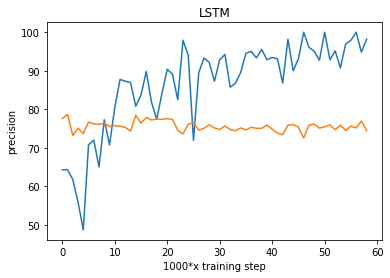

precision of the model on thevalidationdata: 74.55752563476562%
tensor([1.0000, 1.0000, 1.0000, 0.9983, 0.9997, 0.9471, 1.0000, 1.0000, 0.8380,
        0.6760, 0.9996, 0.6388, 1.0000, 0.9868, 0.5833, 0.6393, 1.0000, 1.0000,
        1.0000, 0.5765, 1.0000, 1.0000, 1.0000, 0.8439, 0.9988, 0.9535, 1.0000,
        0.5203, 1.0000, 0.5141, 0.9792, 0.9290, 1.0000, 0.9366, 0.9986, 0.9704,
        0.9796, 1.0000, 1.0000, 1.0000, 1.0000, 0.9271, 0.9998, 0.9542, 0.9987,
        0.9964, 0.9997, 0.9929, 1.0000, 0.7478, 1.0000, 0.9770, 1.0000, 0.9992,
        1.0000, 0.8035, 1.0000, 0.8036, 0.8568, 0.9797, 0.9509, 0.9506, 1.0000,
        0.9974, 1.0000, 0.7886, 0.9967, 0.9491, 1.0000, 0.7508, 1.0000, 0.8557,
        1.0000, 0.7496, 1.0000, 0.9993, 1.0000, 0.9607, 1.0000, 0.9940, 0.9973,
        0.9919, 0.9978, 0.9537, 0.9999, 1.0000, 0.9514, 0.9846, 1.0000, 0.9994,
        1.0000, 0.9407, 0.9999, 0.7543, 0.9999, 0.9750, 1.0000, 0.9077, 1.0000,
        0.9506], device='cuda:1')
current i is 71
Filter

precision of the model on thetrainingdata: 98.63013458251953%
precision of the model on thevalidationdata: 47.08480453491211%
precision of the model on thetrainingdata: 89.04109954833984%
precision of the model on thevalidationdata: 45.85448455810547%


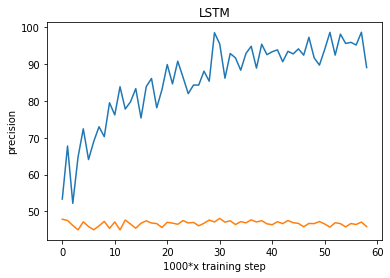

precision of the model on thevalidationdata: 46.0%
tensor([0.9071, 1.0000, 1.0000, 0.9166, 1.0000, 0.7825, 0.9999, 0.7955, 0.9781,
        0.9988, 0.9994, 1.0000, 1.0000, 0.9976, 0.9976, 0.9995, 1.0000, 0.8813,
        0.7702, 0.9998, 1.0000, 0.9992, 0.8437, 0.9932, 0.9982, 1.0000, 1.0000,
        0.9273, 1.0000, 0.9718, 0.9860, 1.0000, 1.0000, 0.9312, 0.9966, 0.7214,
        0.9938, 0.8791, 0.9920, 0.7437, 0.9577, 0.9890, 0.9927, 1.0000, 0.6756,
        0.9871, 1.0000, 0.9212, 1.0000, 0.9853, 1.0000, 0.9336, 0.9796, 0.9964,
        1.0000, 0.9999, 1.0000, 0.9992, 1.0000, 1.0000, 0.6379, 0.9999, 1.0000,
        1.0000, 1.0000, 1.0000, 0.6905, 0.9355, 0.9993, 0.6252, 0.9276, 0.9999,
        1.0000, 0.7725, 0.8848, 0.9990, 1.0000, 0.6369, 0.9927, 0.9798, 0.9498,
        1.0000, 0.9999, 0.8573, 0.9770, 1.0000, 0.9999, 0.9136, 0.9840, 0.9586,
        0.9509, 0.9981, 1.0000, 0.9966, 0.8768, 0.8863, 0.9998, 0.9835, 0.9946,
        0.9989], device='cuda:1')
current i is 72
Filter large gap...

precision of the model on thetrainingdata: 98.33333587646484%
precision of the model on thevalidationdata: 48.48484802246094%
precision of the model on thetrainingdata: 98.61111450195312%
precision of the model on thevalidationdata: 46.94881820678711%


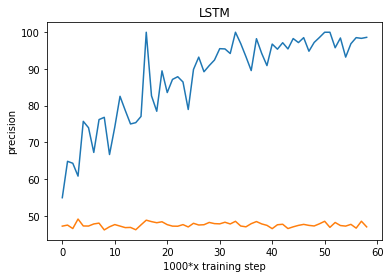

precision of the model on thevalidationdata: 47.55309295654297%
tensor([0.9977, 0.9990, 1.0000, 1.0000, 0.9998, 1.0000, 0.7283, 0.9994, 1.0000,
        1.0000, 0.7043, 0.9999, 0.9963, 0.6237, 1.0000, 0.6216, 1.0000, 0.6222,
        1.0000, 0.8639, 0.9991, 0.7117, 0.8200, 0.9986, 1.0000, 1.0000, 1.0000,
        0.9998, 0.9999, 1.0000, 0.9922, 0.9740, 1.0000, 1.0000, 0.9956, 1.0000,
        1.0000, 1.0000, 1.0000, 0.9985, 1.0000, 0.9999, 1.0000, 0.9977, 0.9950,
        0.8883, 0.8509, 1.0000, 0.9545, 0.9774, 0.9423, 0.8792, 0.5379, 0.7100,
        1.0000, 0.9998, 1.0000, 1.0000, 1.0000, 1.0000, 0.9996, 1.0000, 1.0000,
        0.9341, 0.9840, 0.9756, 1.0000, 1.0000, 0.8763, 0.9372, 0.9816, 0.9980,
        1.0000, 1.0000, 0.6146, 0.9948, 0.9043, 0.9983, 0.9929, 0.9887, 0.9979,
        0.9971, 1.0000, 1.0000, 1.0000, 0.9872, 0.9995, 1.0000, 0.9054, 0.9990,
        0.9995, 0.9795, 0.9975, 0.7956, 0.9952, 0.9514, 0.9998, 0.9831, 0.6476,
        0.5431], device='cuda:1')
current i is 73
Filter

precision of the model on thetrainingdata: 100.0%
precision of the model on thevalidationdata: 38.39285659790039%
precision of the model on thetrainingdata: 92.95774841308594%
precision of the model on thevalidationdata: 39.660491943359375%


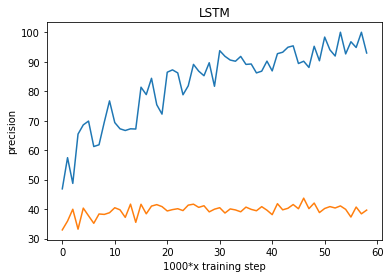

precision of the model on thevalidationdata: 39.11620330810547%
tensor([0.7184, 0.8875, 0.8943, 0.6303, 0.9009, 0.9906, 0.9921, 0.8063, 0.9993,
        0.7099, 0.7300, 0.8870, 0.8108, 0.9999, 0.8145, 0.9828, 1.0000, 0.8857,
        1.0000, 0.8814, 0.9997, 0.9992, 0.7300, 0.9564, 0.7888, 0.7901, 0.6566,
        0.9989, 0.9908, 0.5013, 0.5555, 0.7207, 0.9999, 1.0000, 0.7767, 0.6484,
        0.8533, 0.9861, 0.9998, 1.0000, 0.8949, 0.9736, 0.7474, 0.7530, 0.5954,
        0.7288, 0.9837, 0.8773, 0.5169, 1.0000, 0.9991, 0.9438, 0.9914, 0.9886,
        0.9527, 0.8872, 0.9200, 0.5820, 1.0000, 0.9953, 1.0000, 0.8513, 0.9608,
        0.7618, 0.5241, 0.9663, 0.9978, 0.5188, 0.9690, 0.6345, 0.9235, 0.9709,
        0.8399, 0.9998, 0.8618, 1.0000, 0.9944, 0.5270, 1.0000, 0.9979, 1.0000,
        0.9990, 0.9978, 1.0000, 0.9938, 0.8409, 0.8751, 0.9987, 0.9995, 0.7314,
        0.9718, 0.9984, 0.7689, 0.9869, 0.9805, 0.9998, 0.8639, 0.7009, 0.8253,
        0.5937], device='cuda:1')
current i is 74
Filter

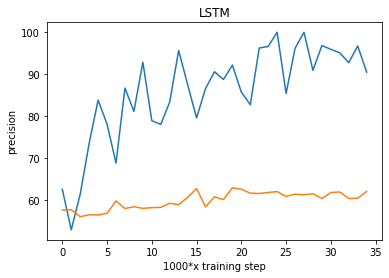

precision of the model on thevalidationdata: 61.97718811035156%
tensor([0.9761, 0.9721, 0.9395, 1.0000, 1.0000, 0.7585, 1.0000, 0.9631, 0.9999,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 0.9999, 1.0000, 1.0000, 0.9999,
        0.9915, 0.7068, 0.9636, 1.0000, 1.0000, 0.6797, 1.0000, 1.0000, 1.0000,
        0.6967, 1.0000, 0.8913, 0.8393, 0.9998, 0.8250, 0.9999, 0.9916, 0.8878,
        0.9971, 1.0000, 0.9949, 1.0000, 1.0000, 1.0000, 0.9847, 0.9905, 0.9992,
        0.6319, 1.0000, 0.9980, 0.8155, 1.0000, 0.9996, 0.5343, 1.0000, 0.9997,
        1.0000, 0.9999, 1.0000, 1.0000, 0.9635, 1.0000, 0.8917, 1.0000, 0.9998,
        0.8052, 1.0000, 1.0000, 0.7545, 1.0000, 1.0000, 1.0000, 1.0000, 0.9715,
        0.5948, 1.0000, 1.0000, 0.9981, 1.0000, 0.6515, 0.6873, 1.0000, 1.0000,
        0.9988, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 0.9331, 0.8922,
        0.7860, 0.9995, 0.9999, 0.9998, 1.0000, 1.0000, 1.0000, 1.0000, 0.9656,
        1.0000], device='cuda:1')
current i is 75
Filter

precision of the model on thetrainingdata: 90.90908813476562%
precision of the model on thevalidationdata: 37.42591094970703%
precision of the model on thetrainingdata: 94.11764526367188%
precision of the model on thevalidationdata: 36.880165100097656%


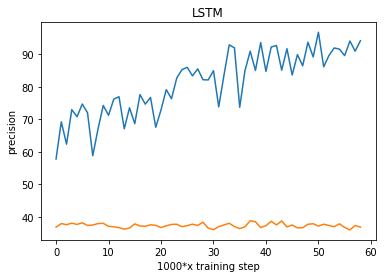

precision of the model on thevalidationdata: 37.25834655761719%
tensor([1.0000, 1.0000, 0.6342, 0.8534, 0.9893, 0.9959, 0.9107, 0.9924, 0.9581,
        0.5366, 0.6244, 0.9981, 0.7194, 0.9984, 0.5767, 0.9909, 0.9969, 0.8372,
        0.5413, 0.8897, 0.5479, 0.9561, 0.8647, 0.9974, 0.6129, 0.9993, 0.9531,
        0.6786, 0.5029, 0.9990, 0.9266, 0.9695, 0.9140, 0.8632, 0.5266, 0.8503,
        0.8775, 0.9299, 0.9992, 0.5203, 0.9875, 0.7323, 0.6764, 0.9959, 0.9131,
        0.6035, 0.9998, 0.8485, 0.9935, 0.5311, 0.9989, 0.8966, 0.7590, 0.9956,
        0.7397, 0.7527, 0.7381, 0.9389, 0.9731, 0.9957, 0.9806, 1.0000, 0.9998,
        0.7516, 0.8478, 0.8891, 0.9429, 0.9531, 0.8541, 0.5524, 0.9997, 0.9306,
        0.9092, 0.9976, 0.5387, 0.8513, 0.8766, 0.6263, 0.9987, 0.9950, 0.9930,
        1.0000, 0.9964, 0.9674, 0.5616, 0.9100, 0.9931, 0.8362, 0.9998, 0.8966,
        0.6825, 0.8524, 0.9997, 0.7511, 0.6903, 0.8272, 0.8188, 0.9828, 0.6570,
        0.5849], device='cuda:1')
current i is 76
Filter

precision of the model on thetrainingdata: 94.23076629638672%
precision of the model on thevalidationdata: 51.53313446044922%
precision of the model on thetrainingdata: 98.07691955566406%
precision of the model on thevalidationdata: 49.88789367675781%


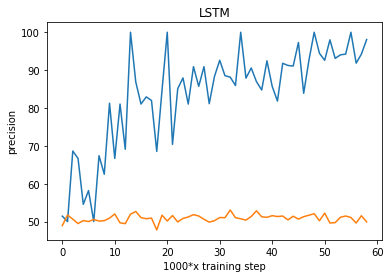

precision of the model on thevalidationdata: 51.73951721191406%
tensor([1.0000, 0.8520, 1.0000, 0.8359, 0.9364, 0.7520, 0.9986, 0.8523, 0.9034,
        1.0000, 0.9060, 1.0000, 1.0000, 0.9771, 1.0000, 0.7143, 0.6044, 0.9817,
        0.9389, 0.8718, 0.8287, 1.0000, 0.9980, 0.8611, 1.0000, 0.8957, 1.0000,
        0.9109, 1.0000, 0.8372, 1.0000, 0.6098, 0.9978, 0.9914, 1.0000, 0.7389,
        0.5650, 0.9384, 0.8729, 0.5319, 0.9381, 0.7578, 0.9655, 0.9782, 0.9997,
        0.9322, 1.0000, 1.0000, 0.9997, 1.0000, 0.9686, 1.0000, 1.0000, 0.8748,
        0.9971, 1.0000, 0.9705, 1.0000, 1.0000, 0.8993, 0.9488, 1.0000, 0.6774,
        0.9412, 1.0000, 0.5327, 0.9998, 1.0000, 1.0000, 0.7220, 0.9728, 0.9927,
        1.0000, 0.6232, 1.0000, 1.0000, 1.0000, 0.8867, 1.0000, 0.9962, 0.9991,
        1.0000, 0.9992, 0.8605, 0.9995, 1.0000, 0.8755, 0.7243, 0.7514, 0.7218,
        0.5195, 0.9535, 0.9998, 0.8407, 0.8623, 0.9542, 1.0000, 0.9173, 1.0000,
        1.0000], device='cuda:1')
current i is 77
Filter

precision of the model on thetrainingdata: 96.25%
precision of the model on thevalidationdata: 24.61928939819336%
precision of the model on thetrainingdata: 94.36619567871094%
precision of the model on thevalidationdata: 25.984251022338867%


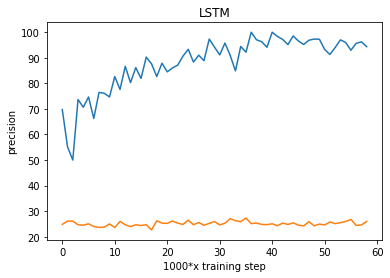

precision of the model on thevalidationdata: 25.392669677734375%
tensor([1.0000, 0.8615, 1.0000, 0.9972, 0.9997, 0.9987, 0.9987, 0.9991, 0.7542,
        0.9999, 0.9432, 0.9800, 0.9553, 0.9186, 0.9978, 0.9965, 0.9511, 0.9607,
        0.7769, 0.9774, 0.9999, 0.9993, 0.9996, 1.0000, 1.0000, 0.9756, 1.0000,
        0.9670, 0.5116, 0.6857, 0.9996, 0.9806, 1.0000, 0.9971, 0.9996, 0.9605,
        1.0000, 0.9277, 0.9469, 1.0000, 0.9784, 0.9998, 0.9989, 0.7866, 0.7584,
        0.9786, 0.7691, 0.9979, 1.0000, 0.6345, 0.9883, 0.8749, 1.0000, 0.9992,
        1.0000, 0.9994, 0.9992, 0.6256, 0.9994, 0.6643, 0.5526, 1.0000, 0.9595,
        0.5552, 0.9982, 0.8811, 0.9899, 0.9895, 0.9998, 0.9825, 0.7581, 0.9948,
        0.9935, 0.6744, 0.9940, 0.9999, 1.0000, 0.9998, 0.9997, 0.9751, 0.5443,
        1.0000, 0.7465, 0.9996, 1.0000, 0.7940, 0.9071, 0.9944, 0.8762, 1.0000,
        1.0000, 0.5133, 0.9998, 0.9334, 0.9988, 0.9814, 1.0000, 1.0000, 1.0000,
        0.9970], device='cuda:1')
current i is 78
Filte

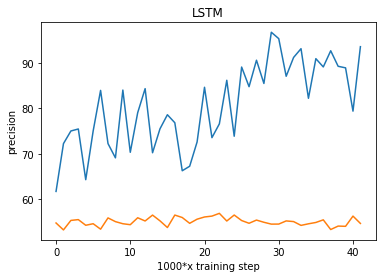

precision of the model on thevalidationdata: 54.660194396972656%
tensor([0.6278, 0.9965, 0.5640, 0.7849, 1.0000, 1.0000, 0.9992, 0.9992, 0.9943,
        0.9826, 0.7696, 0.7707, 0.8084, 0.6542, 0.9991, 0.5135, 1.0000, 0.6348,
        0.5232, 0.8723, 0.8832, 0.8874, 1.0000, 0.9626, 0.7185, 0.9712, 0.7467,
        0.9945, 0.5167, 0.9533, 0.6379, 0.9731, 0.9992, 0.9925, 0.5306, 0.9782,
        0.7939, 0.8822, 0.5057, 1.0000, 0.7309, 0.9679, 0.5744, 0.6134, 0.8749,
        0.9995, 0.8318, 0.9997, 0.9498, 0.9898, 1.0000, 0.7959, 0.8448, 0.9544,
        0.8166, 0.9994, 0.9981, 0.7365, 0.9539, 0.9996, 0.9746, 0.9831, 0.9998,
        0.8507, 0.5203, 0.9876, 0.6145, 0.9689, 0.7462, 0.9701, 0.9989, 0.9613,
        0.9776, 0.7685, 0.9986, 0.9448, 0.7064, 0.8627, 0.5324, 0.8761, 0.9950,
        0.8148, 0.9538, 0.9091, 0.9723, 0.9983, 0.8950, 0.9917, 0.8697, 1.0000,
        0.5941, 0.9963, 1.0000, 0.7546, 0.8090, 1.0000, 0.8746, 0.9850, 0.8920,
        0.5847], device='cuda:1')
current i is 80
Filte

precision of the model on thetrainingdata: 82.45613861083984%
precision of the model on thevalidationdata: 41.24223709106445%
precision of the model on thetrainingdata: 93.33333587646484%
precision of the model on thevalidationdata: 41.17647171020508%


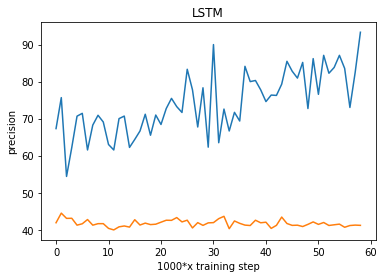

precision of the model on thevalidationdata: 41.4822998046875%
tensor([0.7994, 0.9598, 1.0000, 0.7860, 0.7931, 0.9600, 0.9147, 0.8725, 0.6848,
        0.9759, 0.8764, 0.5036, 0.7288, 0.6756, 0.9421, 0.9939, 0.9892, 0.7662,
        0.7843, 0.9321, 0.9977, 0.8412, 0.9989, 0.9630, 0.9692, 1.0000, 0.5187,
        0.8020, 0.7242, 0.9543, 0.9956, 0.7358, 0.9427, 0.7027, 0.8123, 0.9562,
        0.7774, 0.6985, 0.9805, 0.6799, 0.5048, 0.7205, 0.8811, 0.7663, 0.9726,
        0.7139, 0.8129, 0.7699, 0.9459, 0.8628, 0.8784, 0.9411, 0.5436, 0.8243,
        0.8960, 0.9398, 0.9396, 0.9607, 0.8696, 0.8323, 0.9247, 0.6668, 0.8884,
        0.7138, 0.9213, 0.6055, 0.6658, 0.9772, 0.8858, 0.7910, 0.5255, 0.8776,
        0.9109, 0.8128, 0.7403, 0.6888, 0.6458, 0.7918, 0.6665, 0.6065, 0.9296,
        0.5677, 0.8944, 0.9944, 0.8261, 0.6663, 0.8612, 0.9281, 0.9422, 0.9936,
        0.9979, 0.5932, 0.5076, 0.6384, 0.9767, 0.8483, 0.9788, 0.6597, 0.9548,
        0.5795], device='cuda:1')
current i is 81
Filter 

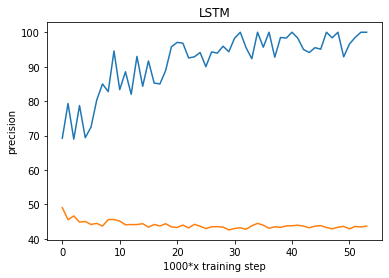

precision of the model on thevalidationdata: 43.73737335205078%
tensor([0.6254, 0.9999, 1.0000, 1.0000, 1.0000, 1.0000, 0.9996, 0.9217, 0.9802,
        0.9085, 0.9416, 0.9995, 0.9997, 1.0000, 0.9453, 0.6987, 0.9992, 0.5819,
        1.0000, 0.9783, 0.7198, 0.5167, 1.0000, 1.0000, 1.0000, 0.9657, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 0.8133, 1.0000, 1.0000, 1.0000, 0.9946,
        1.0000, 0.9869, 0.9999, 0.7021, 0.9738, 0.9769, 0.7943, 0.9343, 1.0000,
        1.0000, 1.0000, 1.0000, 0.7328, 0.9848, 0.7691, 1.0000, 1.0000, 1.0000,
        1.0000, 0.9629, 0.5245, 1.0000, 1.0000, 0.9830, 1.0000, 1.0000, 1.0000,
        1.0000, 0.7188, 0.5531, 0.9983, 0.9974, 1.0000, 0.9985, 1.0000, 0.9423,
        1.0000, 0.9999, 1.0000, 0.9999, 1.0000, 0.9738, 1.0000, 0.9999, 0.9935,
        1.0000, 0.9961, 0.9934, 1.0000, 0.6428, 1.0000, 1.0000, 0.9949, 0.9164,
        0.9999, 1.0000, 0.9053, 0.9383, 1.0000, 0.9459, 0.9428, 0.6962, 1.0000,
        0.6808], device='cuda:1')
current i is 83
Filter

precision of the model on thetrainingdata: 94.64286041259766%
precision of the model on thevalidationdata: 32.265193939208984%
precision of the model on thetrainingdata: 90.90908813476562%
precision of the model on thevalidationdata: 32.890995025634766%


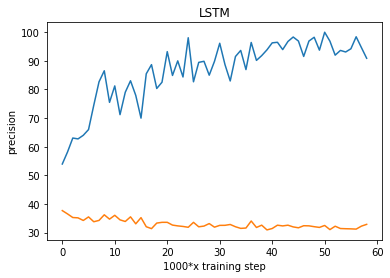

precision of the model on thevalidationdata: 32.555782318115234%
tensor([0.9275, 0.9768, 1.0000, 0.9981, 1.0000, 1.0000, 0.9887, 0.9927, 0.7602,
        0.9946, 0.9998, 0.9734, 1.0000, 1.0000, 0.9914, 0.9981, 0.9696, 0.9797,
        0.9923, 0.9998, 1.0000, 0.7246, 0.9970, 0.9943, 1.0000, 0.5408, 0.9992,
        0.9930, 1.0000, 0.9772, 0.9966, 0.9674, 0.8829, 0.9940, 0.6877, 0.5407,
        1.0000, 0.9587, 0.8149, 0.9995, 0.9994, 1.0000, 1.0000, 0.9411, 1.0000,
        0.9896, 1.0000, 1.0000, 0.9789, 0.8013, 0.6476, 0.9635, 0.6568, 0.9997,
        0.8485, 0.9992, 0.7031, 0.9556, 0.9735, 0.9912, 0.9755, 0.6649, 1.0000,
        0.7874, 0.9642, 1.0000, 0.9570, 0.9988, 0.9948, 1.0000, 0.6150, 0.9989,
        0.6517, 1.0000, 0.9952, 0.9998, 0.9999, 1.0000, 0.8161, 0.8963, 1.0000,
        1.0000, 0.9508, 1.0000, 0.9946, 1.0000, 0.9983, 0.9999, 0.9867, 0.9979,
        0.8704, 0.9924, 0.9349, 0.7240, 0.9954, 0.9288, 0.9747, 0.9991, 0.8312,
        0.9900], device='cuda:1')
current i is 84
Filte

precision of the model on thetrainingdata: 92.85713958740234%
precision of the model on thevalidationdata: 47.41144561767578%
precision of the model on thetrainingdata: 95.34883880615234%
precision of the model on thevalidationdata: 47.5909538269043%


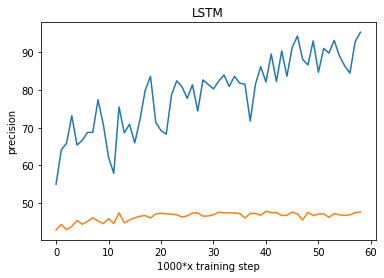

precision of the model on thevalidationdata: 47.59206771850586%
tensor([1.0000, 0.7457, 0.9679, 0.9999, 0.9999, 0.9897, 0.9999, 0.8889, 0.5865,
        0.9956, 0.9531, 1.0000, 0.9878, 0.9520, 0.9517, 1.0000, 0.6864, 0.9869,
        0.8415, 0.9957, 1.0000, 0.9622, 0.8716, 0.9924, 1.0000, 0.6195, 1.0000,
        0.9628, 0.9884, 0.9022, 0.9875, 0.7518, 0.9993, 0.9349, 0.9451, 0.9556,
        0.9991, 0.9734, 0.9042, 1.0000, 0.9992, 0.9999, 0.8561, 0.5711, 0.7204,
        0.7009, 0.8767, 0.9999, 0.8670, 0.6581, 1.0000, 0.7283, 0.6331, 1.0000,
        0.9996, 0.6065, 0.9224, 1.0000, 1.0000, 1.0000, 1.0000, 0.9266, 0.6911,
        0.8548, 0.8550, 1.0000, 0.9993, 0.9341, 0.9404, 0.9526, 0.9501, 0.9990,
        0.7551, 0.7074, 0.8114, 0.7684, 0.8472, 1.0000, 0.9910, 0.9632, 0.9973,
        0.8516, 0.9486, 0.8410, 0.9999, 0.9954, 0.5005, 0.6559, 0.9411, 0.9992,
        0.5607, 1.0000, 0.9990, 0.9304, 0.9546, 0.9933, 0.9990, 0.5465, 0.9982,
        0.9974], device='cuda:1')
current i is 85
Filter

precision of the model on thetrainingdata: 90.47618865966797%
precision of the model on thevalidationdata: 47.71529006958008%
precision of the model on thetrainingdata: 98.21428680419922%
precision of the model on thevalidationdata: 46.761985778808594%


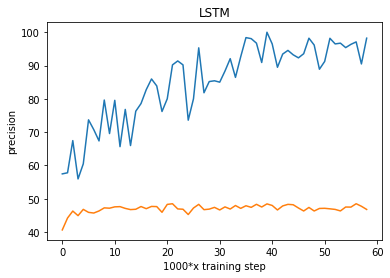

precision of the model on thevalidationdata: 47.33893585205078%
tensor([0.9992, 0.6970, 0.9117, 0.9509, 0.9373, 0.9993, 0.9945, 0.9097, 0.5930,
        0.9817, 0.6265, 0.9982, 0.9820, 0.8772, 0.8968, 0.9999, 0.9995, 0.7370,
        1.0000, 0.9878, 0.7850, 1.0000, 0.9847, 0.6704, 0.9995, 1.0000, 0.8742,
        0.9990, 0.8008, 0.9936, 0.5964, 0.7693, 0.8497, 0.9535, 0.9990, 0.8965,
        0.7899, 0.9996, 0.9998, 0.9288, 0.8054, 0.9993, 0.5559, 0.9963, 0.9967,
        0.5205, 0.8370, 0.7771, 0.9953, 0.8446, 0.7052, 0.8092, 0.7434, 1.0000,
        0.9900, 0.9989, 0.8937, 0.6181, 0.5758, 0.9911, 0.7684, 0.9998, 0.9795,
        0.8346, 0.9567, 0.9564, 0.9998, 1.0000, 0.9854, 1.0000, 1.0000, 0.9400,
        0.9338, 0.8370, 1.0000, 0.9530, 0.9984, 0.9999, 0.8446, 0.9003, 0.9849,
        0.9898, 0.9681, 0.9741, 0.9998, 1.0000, 0.9735, 0.8664, 0.8796, 1.0000,
        0.9980, 0.9259, 1.0000, 0.7895, 0.9996, 0.9994, 0.9453, 0.8495, 0.7941,
        0.8182], device='cuda:1')
current i is 86
Filter

precision of the model on thetrainingdata: 84.50704193115234%
precision of the model on thevalidationdata: 38.181819915771484%
precision of the model on thetrainingdata: 93.84615325927734%
precision of the model on thevalidationdata: 37.69784164428711%


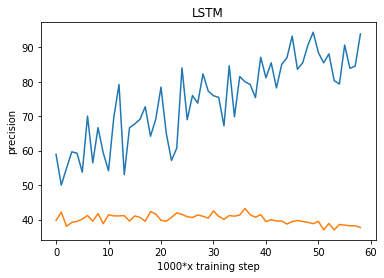

precision of the model on thevalidationdata: 36.764705657958984%
tensor([0.5729, 0.9617, 0.9773, 0.9975, 0.7596, 0.7387, 0.9935, 0.9611, 0.8845,
        0.8385, 0.9737, 0.9992, 0.9168, 0.6242, 0.9994, 0.9537, 0.9993, 1.0000,
        0.7932, 0.9440, 0.9709, 0.8889, 0.6583, 0.8114, 0.9269, 0.9424, 0.9609,
        1.0000, 0.5175, 0.9475, 0.6232, 0.7264, 0.6214, 0.5297, 0.9571, 0.9838,
        0.5027, 0.6538, 0.9685, 0.7767, 0.9995, 0.9677, 0.9991, 1.0000, 0.8944,
        0.5623, 0.8989, 0.7779, 0.9323, 0.8512, 0.5031, 0.9168, 0.7328, 0.9954,
        0.9946, 0.7928, 0.9535, 0.8965, 0.9653, 0.5722, 0.8763, 0.9557, 0.9999,
        0.8910, 0.9604, 0.9421, 0.9792, 0.9999, 0.7247, 0.7352, 0.9598, 0.9285,
        0.7598, 0.9980, 0.9974, 1.0000, 1.0000, 1.0000, 0.9913, 0.8902, 0.6872,
        0.8569, 0.9940, 0.8664, 1.0000, 0.9953, 0.7014, 0.7223, 0.7659, 0.8567,
        0.9322, 0.7574, 0.8825, 0.9774, 0.9749, 0.5043, 0.7928, 0.9947, 1.0000,
        0.9055], device='cuda:1')
current i is 87
Filte

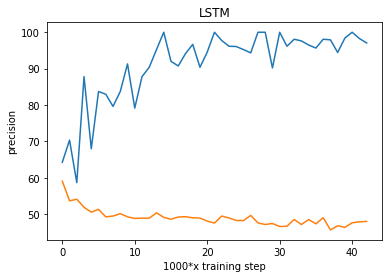

precision of the model on thevalidationdata: 48.04216766357422%
tensor([0.9994, 1.0000, 1.0000, 1.0000, 0.8863, 0.9750, 0.9768, 0.9455, 0.9991,
        0.9959, 1.0000, 0.9310, 1.0000, 0.9967, 0.9997, 1.0000, 0.9940, 0.9975,
        0.7152, 0.6359, 0.9969, 0.6489, 0.9988, 0.8181, 0.9818, 0.9996, 1.0000,
        0.9789, 0.9983, 1.0000, 1.0000, 1.0000, 1.0000, 0.9861, 1.0000, 0.9216,
        0.6120, 1.0000, 0.9662, 0.9750, 0.9877, 0.9998, 0.8361, 0.9988, 0.9999,
        1.0000, 0.5071, 1.0000, 1.0000, 0.6111, 1.0000, 0.6143, 0.9729, 1.0000,
        0.9972, 0.9897, 0.9978, 1.0000, 0.9978, 1.0000, 0.9999, 0.8585, 0.9999,
        0.9992, 1.0000, 0.9920, 1.0000, 0.9999, 1.0000, 0.9997, 0.6627, 0.7620,
        1.0000, 0.9858, 0.9995, 0.9975, 1.0000, 1.0000, 0.9979, 0.8228, 0.9999,
        0.9932, 0.7408, 0.8796, 1.0000, 0.8356, 0.9996, 0.9793, 1.0000, 0.9702,
        0.9997, 0.9967, 0.9991, 1.0000, 1.0000, 0.9990, 1.0000, 0.9935, 0.8628,
        0.9998], device='cuda:1')
current i is 88
Filter

precision of the model on thetrainingdata: 98.11320495605469%
precision of the model on thevalidationdata: 46.8937873840332%
precision of the model on thetrainingdata: 94.91525268554688%
precision of the model on thevalidationdata: 46.355140686035156%


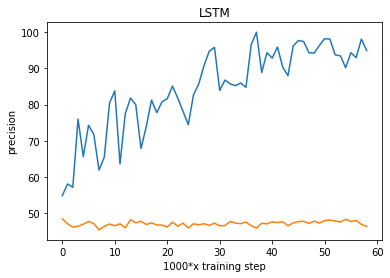

precision of the model on thevalidationdata: 47.85214614868164%
tensor([1.0000, 1.0000, 0.8963, 0.9025, 0.5042, 1.0000, 1.0000, 1.0000, 1.0000,
        0.9997, 1.0000, 1.0000, 1.0000, 0.9569, 0.6529, 1.0000, 0.9994, 0.9991,
        1.0000, 0.5109, 0.9669, 0.7897, 0.9988, 1.0000, 0.9773, 0.9594, 1.0000,
        1.0000, 0.7365, 0.7608, 0.9706, 0.9998, 0.9355, 1.0000, 1.0000, 1.0000,
        0.6784, 0.9739, 0.5474, 1.0000, 0.9428, 1.0000, 1.0000, 0.7933, 1.0000,
        1.0000, 0.6720, 1.0000, 0.7677, 0.9850, 0.9972, 0.9999, 0.6892, 0.9336,
        0.9986, 0.9884, 0.9981, 1.0000, 0.9106, 1.0000, 0.6024, 0.9868, 0.9964,
        0.9997, 1.0000, 0.9826, 0.9998, 0.9823, 0.9860, 0.9911, 1.0000, 1.0000,
        1.0000, 0.9217, 0.9031, 0.8829, 0.9884, 0.9975, 1.0000, 1.0000, 0.9917,
        0.9942, 1.0000, 1.0000, 0.9990, 0.8355, 0.9897, 0.9763, 0.9999, 0.9585,
        0.9747, 0.7928, 0.9635, 0.7215, 0.9782, 0.9977, 0.9978, 1.0000, 0.9997,
        0.6394], device='cuda:1')
current i is 89
Filter

precision of the model on thetrainingdata: 94.82758331298828%
precision of the model on thevalidationdata: 53.8053092956543%


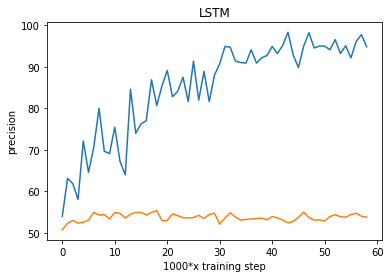

precision of the model on thevalidationdata: 53.89863586425781%
tensor([0.9983, 0.6910, 0.9840, 0.9716, 0.9731, 0.9366, 0.9995, 1.0000, 1.0000,
        0.9624, 0.9998, 0.9974, 0.9808, 0.9961, 0.9686, 0.9999, 0.5579, 0.9987,
        0.9737, 0.9994, 0.9923, 0.9486, 0.9997, 0.5703, 0.7904, 1.0000, 0.9878,
        0.9994, 0.7411, 0.8874, 0.8601, 0.9940, 0.9113, 1.0000, 1.0000, 0.8927,
        0.9322, 0.9999, 0.7833, 0.9101, 0.6488, 0.9636, 0.9088, 0.9946, 1.0000,
        1.0000, 1.0000, 0.9931, 0.8408, 0.9863, 0.9981, 0.9471, 0.9997, 0.5006,
        0.9996, 0.5062, 0.8010, 0.9926, 0.9967, 0.6659, 0.9999, 0.5605, 0.9976,
        1.0000, 1.0000, 0.9808, 0.9600, 1.0000, 0.9414, 0.9470, 0.9880, 1.0000,
        0.5923, 0.9999, 0.9584, 0.9839, 0.9462, 0.9969, 1.0000, 0.9972, 0.8971,
        0.8491, 0.9998, 0.9997, 0.9457, 0.9968, 0.6023, 0.9999, 0.9671, 0.9918,
        0.9997, 0.8317, 0.9994, 0.9982, 0.5048, 0.9966, 0.9987, 0.8168, 0.5409,
        0.9876], device='cuda:1')


In [72]:
result = wavenet_rolling_window(df_train_dict, df_valid_dict)

In [77]:
result_df_dict = transform_dict_to_df(result)

In [78]:
processed = pre_processing(result_df_dict)

1
            date      index     score  label  prediction
0     2013-03-14  000001.SZ  0.999831    1.0         1.0
1     2013-03-15  000001.SZ  0.635046    0.0         1.0
2     2013-03-18  000001.SZ  0.871011    0.0         1.0
3     2013-03-14  000002.SZ  0.832902    0.0         1.0
4     2013-03-15  000002.SZ  0.362314    1.0         0.0
...          ...        ...       ...    ...         ...
1833  2013-03-15  603077.SH  1.000000    0.0         1.0
1834  2013-03-18  603077.SH  1.000000    0.0         1.0
1835  2013-03-14  603766.SH  0.999990    1.0         1.0
1836  2013-03-15  603766.SH  0.996344    0.0         1.0
1837  2013-03-18  603766.SH  0.000000    1.0         0.0

[1838 rows x 5 columns]
2
           date      index     score  label  prediction
0    2013-04-15  000001.SZ  0.000000    0.0         0.0
1    2013-04-15  000002.SZ  0.005170    1.0         0.0
2    2013-04-15  000008.SZ  1.000000    0.0         1.0
3    2013-04-15  000009.SZ  0.025312    1.0         0.0
4    20

            date      index     score  label  prediction
0     2015-01-15  000001.SZ  1.000000    0.0         1.0
1     2015-01-16  000001.SZ  0.010602    1.0         0.0
2     2015-01-19  000001.SZ  0.305804    0.0         0.0
3     2015-01-15  000002.SZ  0.448539    0.0         0.0
4     2015-01-16  000002.SZ  0.001468    1.0         0.0
...          ...        ...       ...    ...         ...
1740  2015-01-16  603369.SH  0.000000    0.0         0.0
1741  2015-01-19  603369.SH  0.999928    1.0         1.0
1742  2015-01-15  603993.SH  0.018825    1.0         0.0
1743  2015-01-16  603993.SH  0.654126    1.0         1.0
1744  2015-01-19  603993.SH  0.000319    1.0         0.0

[1745 rows x 5 columns]
26
            date      index     score  label  prediction
0     2015-02-12  000001.SZ  1.000000    0.0         1.0
1     2015-02-13  000001.SZ  0.000000    0.0         0.0
2     2015-02-16  000001.SZ  0.675910    0.0         1.0
3     2015-02-12  000002.SZ  1.000000    1.0         1.0
4  

            date      index     score  label  prediction
0     2016-01-14  000001.SZ  1.000000    0.0         1.0
1     2016-01-15  000001.SZ  0.000568    0.0         0.0
2     2016-01-18  000001.SZ  0.000000    1.0         0.0
3     2016-01-14  000008.SZ  0.000357    1.0         0.0
4     2016-01-15  000008.SZ  0.001464    0.0         0.0
...          ...        ...       ...    ...         ...
1827  2016-01-15  603939.SH  0.000000    1.0         0.0
1828  2016-01-18  603939.SH  0.000000    1.0         0.0
1829  2016-01-14  603993.SH  0.001218    0.0         0.0
1830  2016-01-15  603993.SH  0.997525    0.0         1.0
1831  2016-01-18  603993.SH  0.000000    0.0         0.0

[1832 rows x 5 columns]
40
            date      index         score  label  prediction
0     2016-03-10  000001.SZ  2.384000e-05    0.0         0.0
1     2016-03-11  000001.SZ  1.277000e-04    0.0         0.0
2     2016-03-14  000001.SZ  9.984124e-01    1.0         1.0
3     2016-03-10  000008.SZ  9.999952e-01   

            date      index     score  label  prediction
0     2017-01-13  000001.SZ  0.000000    0.0         0.0
1     2017-01-16  000001.SZ  0.000895    0.0         0.0
2     2017-01-13  000008.SZ  0.999754    0.0         1.0
3     2017-01-16  000008.SZ  0.890837    0.0         1.0
4     2017-01-13  000009.SZ  0.000000    0.0         0.0
...          ...        ...       ...    ...         ...
1279  2017-01-16  603899.SH  0.999985    1.0         1.0
1280  2017-01-13  603939.SH  0.000000    0.0         0.0
1281  2017-01-16  603939.SH  1.000000    1.0         1.0
1282  2017-01-13  603993.SH  0.862417    1.0         1.0
1283  2017-01-16  603993.SH  0.863656    1.0         1.0

[1284 rows x 5 columns]
53
            date      index     score  label  prediction
0     2017-03-09  000001.SZ  1.000000    1.0         1.0
1     2017-03-10  000001.SZ  0.000000    0.0         0.0
2     2017-03-13  000001.SZ  0.000171    1.0         0.0
3     2017-03-09  000002.SZ  0.649935    1.0         1.0
4  

            date      index     score  label  prediction
0     2018-01-12  000001.SZ  0.311617    1.0         0.0
1     2018-01-15  000001.SZ  0.012082    0.0         0.0
2     2018-01-12  000002.SZ  0.000000    1.0         0.0
3     2018-01-15  000002.SZ  0.996763    1.0         1.0
4     2018-01-12  000008.SZ  0.937471    0.0         1.0
...          ...        ...       ...    ...         ...
1382  2018-01-15  603899.SH  0.999952    0.0         1.0
1383  2018-01-12  603939.SH  1.000000    0.0         1.0
1384  2018-01-15  603939.SH  0.001256    0.0         0.0
1385  2018-01-12  603993.SH  0.180600    0.0         0.0
1386  2018-01-15  603993.SH  0.004072    1.0         0.0

[1387 rows x 5 columns]
65
            date      index         score  label  prediction
0     2018-02-08  000001.SZ  9.921245e-01    0.0         1.0
1     2018-02-09  000001.SZ  9.999949e-01    0.0         1.0
2     2018-02-12  000001.SZ  1.000000e+00    1.0         1.0
3     2018-02-08  000002.SZ  1.000000e+00   

            date      index         score  label  prediction
0     2018-12-13  000001.SZ  0.000000e+00    0.0         0.0
1     2018-12-14  000001.SZ  8.519695e-01    1.0         1.0
2     2018-12-17  000001.SZ  1.000000e-07    0.0         0.0
3     2018-12-13  000002.SZ  8.359362e-01    0.0         1.0
4     2018-12-14  000002.SZ  6.356290e-02    1.0         0.0
...          ...        ...           ...    ...         ...
2250  2018-12-14  603986.SH  8.010000e-05    0.0         0.0
2251  2018-12-17  603986.SH  1.000000e+00    1.0         1.0
2252  2018-12-13  603993.SH  9.838167e-01    0.0         1.0
2253  2018-12-14  603993.SH  5.177706e-02    1.0         0.0
2254  2018-12-17  603993.SH  3.676530e-03    1.0         0.0

[2255 rows x 5 columns]
77
           date      index         score  label  prediction
0    2019-01-14  000001.SZ  3.600000e-07    0.0         0.0
1    2019-01-14  000002.SZ  8.614510e-01    0.0         1.0
2    2019-01-14  000008.SZ  9.999944e-01    0.0         1.0


10
20
40
80
160


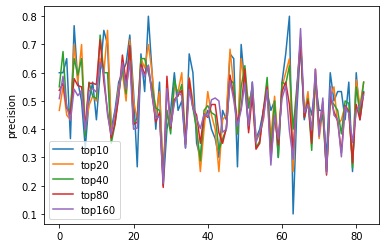

In [79]:
precision_diction = mult_k(processed,[10,20,40,80,160])

In [80]:
for i in precision_diction.keys():
    print('top'+str(i),'mean precision:',sum(precision_diction[str(i)])/len(precision_diction[str(i)]))

top10 mean precision: 0.503012048192771
top20 mean precision: 0.49598393574297195
top40 mean precision: 0.49071285140562254
top80 mean precision: 0.4787901606425703
top160 mean precision: 0.4763304368372808
